In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Azzahra\.conda\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and preprocess data
data = pd.read_csv('bank-full.csv', delimiter=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## EDA

In [4]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000



Target Variable Distribution:


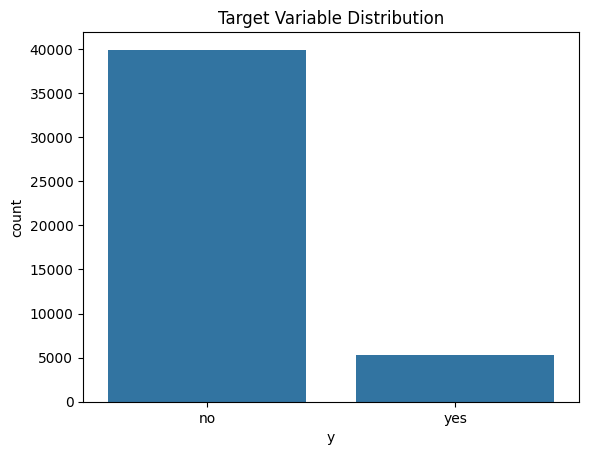

In [5]:
print("\nTarget Variable Distribution:")
sns.countplot(x='y', data=data)
plt.title('Target Variable Distribution')
plt.show()


Correlation Heatmap:


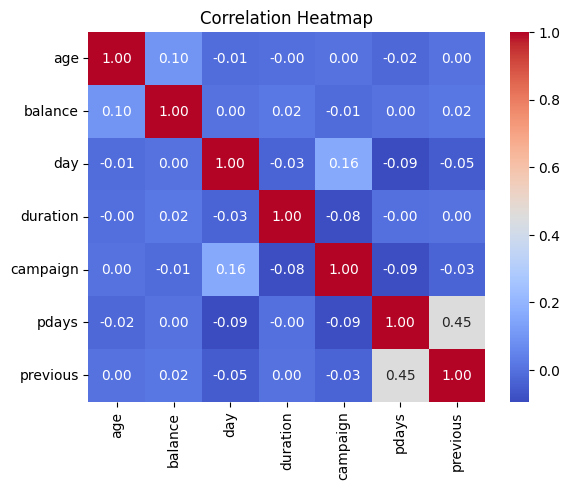

In [6]:
print("\nCorrelation Heatmap:")
corr = data.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Bidirectional RNN

In [7]:
# preprocessing
X = data.drop('y', axis=1)
X = pd.get_dummies(X)
y = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [8]:
# Define Bidirectional RNN model
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, pooling='max'):
        super(BiRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.pooling = pooling
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        if self.pooling == 'max':
            out = torch.max(out, dim=1).values
        elif self.pooling == 'avg':
            out = torch.mean(out, dim=1)
        out = self.fc(out)
        return out


In [9]:
# Define training and evaluation loop
def train_model(model, optimizer, criterion, scheduler, num_epochs, early_stopper, train_loader, test_loader):
    best_loss = float('inf')
    patience_counter = 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(1))
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch.unsqueeze(1))
                loss = criterion(outputs.squeeze(), y_batch)
                test_loss += loss.item()
                predictions = torch.round(torch.sigmoid(outputs.squeeze()))
                correct += (predictions == y_batch).sum().item()
                total += y_batch.size(0)
        test_loss /= len(test_loader)
        accuracy = correct / total

        scheduler.step(test_loss)

        if test_loss < best_loss:
            best_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > early_stopper:
            print("Early stopping triggered")
            break

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    return accuracy

In [10]:
# Experiment configurations
hidden_sizes = [16, 32, 64]
poolings = ['max', 'avg']
epochs_list = [5, 50, 100, 250, 350]
optimizers = ['SGD', 'RMSprop', 'Adam']
early_stopper = 10

# Run experiments and save results
results = []
for hidden_size in hidden_sizes:
    for pooling in poolings:
        for optimizer_name in optimizers:
            for num_epochs in epochs_list:
                print("===============================================================")
                print(f"\nConfiguration: Hidden Size={hidden_size}, Pooling={pooling}, Optimizer={optimizer_name}, Epochs={num_epochs}")
                model = BiRNN(input_size=X_train.shape[1], hidden_size=hidden_size, num_layers=1, output_size=1, pooling=pooling)
                criterion = nn.BCEWithLogitsLoss()

                if optimizer_name == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=0.01)
                elif optimizer_name == 'RMSprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=0.01)
                elif optimizer_name == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=0.01)

                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
                accuracy = train_model(model, optimizer, criterion, scheduler, num_epochs, early_stopper, train_loader, test_loader)

                results.append({
                    'Hidden Size': hidden_size,
                    'Pooling': pooling,
                    'Optimizer': optimizer_name,
                    'Epochs': num_epochs,
                    'Accuracy': accuracy
                })

results_df = pd.DataFrame(results)
results_df.to_csv('Experiment_Bidirectional RNN_results.csv', index=False)



Configuration: Hidden Size=16, Pooling=max, Optimizer=SGD, Epochs=5


100%|██████████| 566/566 [00:01<00:00, 300.25it/s]


Epoch 1/5, Train Loss: 0.4011, Test Loss: 0.3018, Accuracy: 0.8848


100%|██████████| 566/566 [00:01<00:00, 529.41it/s]


Epoch 2/5, Train Loss: 0.2695, Test Loss: 0.2590, Accuracy: 0.8934


100%|██████████| 566/566 [00:01<00:00, 516.42it/s]


Epoch 3/5, Train Loss: 0.2436, Test Loss: 0.2458, Accuracy: 0.8983


100%|██████████| 566/566 [00:01<00:00, 501.86it/s]


Epoch 4/5, Train Loss: 0.2353, Test Loss: 0.2410, Accuracy: 0.8997


100%|██████████| 566/566 [00:01<00:00, 505.43it/s]


Epoch 5/5, Train Loss: 0.2321, Test Loss: 0.2389, Accuracy: 0.8999

Configuration: Hidden Size=16, Pooling=max, Optimizer=SGD, Epochs=50


100%|██████████| 566/566 [00:01<00:00, 511.37it/s]


Epoch 1/50, Train Loss: 0.4395, Test Loss: 0.3172, Accuracy: 0.8859


100%|██████████| 566/566 [00:01<00:00, 503.83it/s]


Epoch 2/50, Train Loss: 0.2789, Test Loss: 0.2659, Accuracy: 0.8942


100%|██████████| 566/566 [00:01<00:00, 511.47it/s]


Epoch 3/50, Train Loss: 0.2489, Test Loss: 0.2498, Accuracy: 0.8975


100%|██████████| 566/566 [00:01<00:00, 503.18it/s]


Epoch 4/50, Train Loss: 0.2383, Test Loss: 0.2435, Accuracy: 0.8975


100%|██████████| 566/566 [00:01<00:00, 509.02it/s]


Epoch 5/50, Train Loss: 0.2339, Test Loss: 0.2404, Accuracy: 0.8997


100%|██████████| 566/566 [00:01<00:00, 521.72it/s]


Epoch 6/50, Train Loss: 0.2320, Test Loss: 0.2385, Accuracy: 0.9011


100%|██████████| 566/566 [00:01<00:00, 523.65it/s]


Epoch 7/50, Train Loss: 0.2297, Test Loss: 0.2371, Accuracy: 0.9008


100%|██████████| 566/566 [00:01<00:00, 484.83it/s]


Epoch 8/50, Train Loss: 0.2280, Test Loss: 0.2359, Accuracy: 0.9005


100%|██████████| 566/566 [00:01<00:00, 495.82it/s]


Epoch 9/50, Train Loss: 0.2275, Test Loss: 0.2348, Accuracy: 0.9009


100%|██████████| 566/566 [00:01<00:00, 498.34it/s]


Epoch 10/50, Train Loss: 0.2257, Test Loss: 0.2338, Accuracy: 0.9011


100%|██████████| 566/566 [00:01<00:00, 496.35it/s]


Epoch 11/50, Train Loss: 0.2248, Test Loss: 0.2330, Accuracy: 0.9010


100%|██████████| 566/566 [00:01<00:00, 521.47it/s]


Epoch 12/50, Train Loss: 0.2244, Test Loss: 0.2321, Accuracy: 0.9011


100%|██████████| 566/566 [00:01<00:00, 506.62it/s]


Epoch 13/50, Train Loss: 0.2230, Test Loss: 0.2313, Accuracy: 0.9012


100%|██████████| 566/566 [00:01<00:00, 464.36it/s]


Epoch 14/50, Train Loss: 0.2225, Test Loss: 0.2306, Accuracy: 0.9017


100%|██████████| 566/566 [00:01<00:00, 449.95it/s]


Epoch 15/50, Train Loss: 0.2215, Test Loss: 0.2299, Accuracy: 0.9018


100%|██████████| 566/566 [00:01<00:00, 497.13it/s]


Epoch 16/50, Train Loss: 0.2214, Test Loss: 0.2293, Accuracy: 0.9018


100%|██████████| 566/566 [00:01<00:00, 482.44it/s]


Epoch 17/50, Train Loss: 0.2203, Test Loss: 0.2287, Accuracy: 0.9025


100%|██████████| 566/566 [00:01<00:00, 492.95it/s]


Epoch 18/50, Train Loss: 0.2201, Test Loss: 0.2282, Accuracy: 0.9024


100%|██████████| 566/566 [00:01<00:00, 494.28it/s]


Epoch 19/50, Train Loss: 0.2193, Test Loss: 0.2276, Accuracy: 0.9026


100%|██████████| 566/566 [00:01<00:00, 504.81it/s]


Epoch 20/50, Train Loss: 0.2183, Test Loss: 0.2271, Accuracy: 0.9026


100%|██████████| 566/566 [00:01<00:00, 556.15it/s]


Epoch 21/50, Train Loss: 0.2176, Test Loss: 0.2267, Accuracy: 0.9031


100%|██████████| 566/566 [00:01<00:00, 518.59it/s]


Epoch 22/50, Train Loss: 0.2177, Test Loss: 0.2263, Accuracy: 0.9037


100%|██████████| 566/566 [00:01<00:00, 498.23it/s]


Epoch 23/50, Train Loss: 0.2168, Test Loss: 0.2259, Accuracy: 0.9035


100%|██████████| 566/566 [00:01<00:00, 511.29it/s]


Epoch 24/50, Train Loss: 0.2163, Test Loss: 0.2256, Accuracy: 0.9028


100%|██████████| 566/566 [00:01<00:00, 529.97it/s]


Epoch 25/50, Train Loss: 0.2156, Test Loss: 0.2251, Accuracy: 0.9038


100%|██████████| 566/566 [00:01<00:00, 517.98it/s]


Epoch 26/50, Train Loss: 0.2151, Test Loss: 0.2247, Accuracy: 0.9037


100%|██████████| 566/566 [00:01<00:00, 537.03it/s]


Epoch 27/50, Train Loss: 0.2148, Test Loss: 0.2245, Accuracy: 0.9034


100%|██████████| 566/566 [00:00<00:00, 570.08it/s]


Epoch 28/50, Train Loss: 0.2142, Test Loss: 0.2241, Accuracy: 0.9038


100%|██████████| 566/566 [00:01<00:00, 512.62it/s]


Epoch 29/50, Train Loss: 0.2138, Test Loss: 0.2238, Accuracy: 0.9043


100%|██████████| 566/566 [00:01<00:00, 521.60it/s]


Epoch 30/50, Train Loss: 0.2134, Test Loss: 0.2235, Accuracy: 0.9038


100%|██████████| 566/566 [00:00<00:00, 572.95it/s]


Epoch 31/50, Train Loss: 0.2130, Test Loss: 0.2231, Accuracy: 0.9039


100%|██████████| 566/566 [00:01<00:00, 554.86it/s]


Epoch 32/50, Train Loss: 0.2126, Test Loss: 0.2228, Accuracy: 0.9038


100%|██████████| 566/566 [00:01<00:00, 557.50it/s]


Epoch 33/50, Train Loss: 0.2124, Test Loss: 0.2226, Accuracy: 0.9038


100%|██████████| 566/566 [00:00<00:00, 569.30it/s]


Epoch 34/50, Train Loss: 0.2119, Test Loss: 0.2223, Accuracy: 0.9035


100%|██████████| 566/566 [00:00<00:00, 578.49it/s]


Epoch 35/50, Train Loss: 0.2118, Test Loss: 0.2220, Accuracy: 0.9035


100%|██████████| 566/566 [00:00<00:00, 569.73it/s]


Epoch 36/50, Train Loss: 0.2112, Test Loss: 0.2217, Accuracy: 0.9036


100%|██████████| 566/566 [00:01<00:00, 500.75it/s]


Epoch 37/50, Train Loss: 0.2110, Test Loss: 0.2215, Accuracy: 0.9036


100%|██████████| 566/566 [00:01<00:00, 555.42it/s]


Epoch 38/50, Train Loss: 0.2106, Test Loss: 0.2213, Accuracy: 0.9032


100%|██████████| 566/566 [00:01<00:00, 558.29it/s]


Epoch 39/50, Train Loss: 0.2104, Test Loss: 0.2211, Accuracy: 0.9027


100%|██████████| 566/566 [00:01<00:00, 549.16it/s]


Epoch 40/50, Train Loss: 0.2100, Test Loss: 0.2208, Accuracy: 0.9036


100%|██████████| 566/566 [00:01<00:00, 560.91it/s]


Epoch 41/50, Train Loss: 0.2098, Test Loss: 0.2206, Accuracy: 0.9037


100%|██████████| 566/566 [00:01<00:00, 557.53it/s]


Epoch 42/50, Train Loss: 0.2099, Test Loss: 0.2204, Accuracy: 0.9034


100%|██████████| 566/566 [00:01<00:00, 559.21it/s]


Epoch 43/50, Train Loss: 0.2091, Test Loss: 0.2202, Accuracy: 0.9034


100%|██████████| 566/566 [00:01<00:00, 528.22it/s]


Epoch 44/50, Train Loss: 0.2086, Test Loss: 0.2200, Accuracy: 0.9031


100%|██████████| 566/566 [00:01<00:00, 557.15it/s]


Epoch 45/50, Train Loss: 0.2082, Test Loss: 0.2197, Accuracy: 0.9028


100%|██████████| 566/566 [00:00<00:00, 577.31it/s]


Epoch 46/50, Train Loss: 0.2079, Test Loss: 0.2196, Accuracy: 0.9037


100%|██████████| 566/566 [00:01<00:00, 559.28it/s]


Epoch 47/50, Train Loss: 0.2077, Test Loss: 0.2194, Accuracy: 0.9029


100%|██████████| 566/566 [00:01<00:00, 564.97it/s]


Epoch 48/50, Train Loss: 0.2072, Test Loss: 0.2192, Accuracy: 0.9031


100%|██████████| 566/566 [00:00<00:00, 578.22it/s]


Epoch 49/50, Train Loss: 0.2070, Test Loss: 0.2190, Accuracy: 0.9037


100%|██████████| 566/566 [00:01<00:00, 544.75it/s]


Epoch 50/50, Train Loss: 0.2068, Test Loss: 0.2188, Accuracy: 0.9028

Configuration: Hidden Size=16, Pooling=max, Optimizer=SGD, Epochs=100


100%|██████████| 566/566 [00:00<00:00, 579.79it/s]


Epoch 1/100, Train Loss: 0.4339, Test Loss: 0.3172, Accuracy: 0.8802


100%|██████████| 566/566 [00:00<00:00, 585.33it/s]


Epoch 2/100, Train Loss: 0.2815, Test Loss: 0.2660, Accuracy: 0.8926


100%|██████████| 566/566 [00:00<00:00, 600.79it/s]


Epoch 3/100, Train Loss: 0.2497, Test Loss: 0.2481, Accuracy: 0.8956


100%|██████████| 566/566 [00:00<00:00, 634.50it/s]


Epoch 4/100, Train Loss: 0.2389, Test Loss: 0.2417, Accuracy: 0.8991


100%|██████████| 566/566 [00:00<00:00, 582.69it/s]


Epoch 5/100, Train Loss: 0.2334, Test Loss: 0.2389, Accuracy: 0.8995


100%|██████████| 566/566 [00:00<00:00, 573.53it/s]


Epoch 6/100, Train Loss: 0.2316, Test Loss: 0.2374, Accuracy: 0.8996


100%|██████████| 566/566 [00:00<00:00, 572.35it/s]


Epoch 7/100, Train Loss: 0.2293, Test Loss: 0.2364, Accuracy: 0.9006


100%|██████████| 566/566 [00:00<00:00, 572.89it/s]


Epoch 8/100, Train Loss: 0.2278, Test Loss: 0.2356, Accuracy: 0.9009


100%|██████████| 566/566 [00:00<00:00, 585.35it/s]


Epoch 9/100, Train Loss: 0.2271, Test Loss: 0.2348, Accuracy: 0.9009


100%|██████████| 566/566 [00:00<00:00, 574.01it/s]


Epoch 10/100, Train Loss: 0.2266, Test Loss: 0.2340, Accuracy: 0.9008


100%|██████████| 566/566 [00:00<00:00, 585.48it/s]


Epoch 11/100, Train Loss: 0.2248, Test Loss: 0.2332, Accuracy: 0.9010


100%|██████████| 566/566 [00:00<00:00, 583.65it/s]


Epoch 12/100, Train Loss: 0.2239, Test Loss: 0.2326, Accuracy: 0.9015


100%|██████████| 566/566 [00:00<00:00, 590.88it/s]


Epoch 13/100, Train Loss: 0.2229, Test Loss: 0.2320, Accuracy: 0.9012


100%|██████████| 566/566 [00:00<00:00, 578.01it/s]


Epoch 14/100, Train Loss: 0.2226, Test Loss: 0.2313, Accuracy: 0.9010


100%|██████████| 566/566 [00:00<00:00, 577.30it/s]


Epoch 15/100, Train Loss: 0.2216, Test Loss: 0.2307, Accuracy: 0.9008


100%|██████████| 566/566 [00:00<00:00, 589.68it/s]


Epoch 16/100, Train Loss: 0.2207, Test Loss: 0.2302, Accuracy: 0.9008


100%|██████████| 566/566 [00:00<00:00, 586.16it/s]


Epoch 17/100, Train Loss: 0.2201, Test Loss: 0.2298, Accuracy: 0.9009


100%|██████████| 566/566 [00:00<00:00, 595.53it/s]


Epoch 18/100, Train Loss: 0.2197, Test Loss: 0.2293, Accuracy: 0.9000


100%|██████████| 566/566 [00:00<00:00, 594.19it/s]


Epoch 19/100, Train Loss: 0.2187, Test Loss: 0.2288, Accuracy: 0.8996


100%|██████████| 566/566 [00:00<00:00, 586.22it/s]


Epoch 20/100, Train Loss: 0.2180, Test Loss: 0.2285, Accuracy: 0.8991


100%|██████████| 566/566 [00:00<00:00, 588.03it/s]


Epoch 21/100, Train Loss: 0.2180, Test Loss: 0.2279, Accuracy: 0.8988


100%|██████████| 566/566 [00:00<00:00, 588.85it/s]


Epoch 22/100, Train Loss: 0.2170, Test Loss: 0.2276, Accuracy: 0.8991


100%|██████████| 566/566 [00:00<00:00, 591.84it/s]


Epoch 23/100, Train Loss: 0.2169, Test Loss: 0.2272, Accuracy: 0.8993


100%|██████████| 566/566 [00:00<00:00, 588.34it/s]


Epoch 24/100, Train Loss: 0.2166, Test Loss: 0.2270, Accuracy: 0.8995


100%|██████████| 566/566 [00:00<00:00, 591.71it/s]


Epoch 25/100, Train Loss: 0.2159, Test Loss: 0.2265, Accuracy: 0.8995


100%|██████████| 566/566 [00:00<00:00, 591.74it/s]


Epoch 26/100, Train Loss: 0.2152, Test Loss: 0.2262, Accuracy: 0.8997


100%|██████████| 566/566 [00:00<00:00, 606.45it/s]


Epoch 27/100, Train Loss: 0.2150, Test Loss: 0.2259, Accuracy: 0.8998


100%|██████████| 566/566 [00:00<00:00, 593.80it/s]


Epoch 28/100, Train Loss: 0.2143, Test Loss: 0.2256, Accuracy: 0.8998


100%|██████████| 566/566 [00:00<00:00, 577.15it/s]


Epoch 29/100, Train Loss: 0.2140, Test Loss: 0.2254, Accuracy: 0.9001


100%|██████████| 566/566 [00:01<00:00, 545.77it/s]


Epoch 30/100, Train Loss: 0.2136, Test Loss: 0.2252, Accuracy: 0.9008


100%|██████████| 566/566 [00:00<00:00, 580.21it/s]


Epoch 31/100, Train Loss: 0.2132, Test Loss: 0.2249, Accuracy: 0.9010


100%|██████████| 566/566 [00:00<00:00, 576.01it/s]


Epoch 32/100, Train Loss: 0.2128, Test Loss: 0.2246, Accuracy: 0.9006


100%|██████████| 566/566 [00:00<00:00, 570.44it/s]


Epoch 33/100, Train Loss: 0.2133, Test Loss: 0.2244, Accuracy: 0.9016


100%|██████████| 566/566 [00:00<00:00, 572.30it/s]


Epoch 34/100, Train Loss: 0.2121, Test Loss: 0.2242, Accuracy: 0.9016


100%|██████████| 566/566 [00:00<00:00, 579.40it/s]


Epoch 35/100, Train Loss: 0.2117, Test Loss: 0.2240, Accuracy: 0.9018


100%|██████████| 566/566 [00:00<00:00, 591.27it/s]


Epoch 36/100, Train Loss: 0.2120, Test Loss: 0.2237, Accuracy: 0.9020


100%|██████████| 566/566 [00:00<00:00, 582.67it/s]


Epoch 37/100, Train Loss: 0.2112, Test Loss: 0.2236, Accuracy: 0.9015


100%|██████████| 566/566 [00:00<00:00, 585.42it/s]


Epoch 38/100, Train Loss: 0.2109, Test Loss: 0.2234, Accuracy: 0.9012


100%|██████████| 566/566 [00:00<00:00, 594.37it/s]


Epoch 39/100, Train Loss: 0.2107, Test Loss: 0.2231, Accuracy: 0.9018


100%|██████████| 566/566 [00:00<00:00, 581.48it/s]


Epoch 40/100, Train Loss: 0.2107, Test Loss: 0.2229, Accuracy: 0.9015


100%|██████████| 566/566 [00:01<00:00, 559.01it/s]


Epoch 41/100, Train Loss: 0.2106, Test Loss: 0.2228, Accuracy: 0.9018


100%|██████████| 566/566 [00:00<00:00, 593.52it/s]


Epoch 42/100, Train Loss: 0.2104, Test Loss: 0.2226, Accuracy: 0.9020


100%|██████████| 566/566 [00:00<00:00, 592.02it/s]


Epoch 43/100, Train Loss: 0.2095, Test Loss: 0.2225, Accuracy: 0.9017


100%|██████████| 566/566 [00:00<00:00, 587.31it/s]


Epoch 44/100, Train Loss: 0.2098, Test Loss: 0.2223, Accuracy: 0.9026


100%|██████████| 566/566 [00:00<00:00, 594.18it/s]


Epoch 45/100, Train Loss: 0.2093, Test Loss: 0.2221, Accuracy: 0.9019


100%|██████████| 566/566 [00:00<00:00, 596.89it/s]


Epoch 46/100, Train Loss: 0.2088, Test Loss: 0.2219, Accuracy: 0.9025


100%|██████████| 566/566 [00:00<00:00, 594.04it/s]


Epoch 47/100, Train Loss: 0.2084, Test Loss: 0.2217, Accuracy: 0.9020


100%|██████████| 566/566 [00:00<00:00, 589.22it/s]


Epoch 48/100, Train Loss: 0.2085, Test Loss: 0.2216, Accuracy: 0.9022


100%|██████████| 566/566 [00:00<00:00, 587.92it/s]


Epoch 49/100, Train Loss: 0.2084, Test Loss: 0.2214, Accuracy: 0.9021


100%|██████████| 566/566 [00:00<00:00, 581.13it/s]


Epoch 50/100, Train Loss: 0.2080, Test Loss: 0.2214, Accuracy: 0.9018


100%|██████████| 566/566 [00:00<00:00, 579.82it/s]


Epoch 51/100, Train Loss: 0.2078, Test Loss: 0.2212, Accuracy: 0.9020


100%|██████████| 566/566 [00:00<00:00, 577.96it/s]


Epoch 52/100, Train Loss: 0.2076, Test Loss: 0.2210, Accuracy: 0.9021


100%|██████████| 566/566 [00:00<00:00, 589.88it/s]


Epoch 53/100, Train Loss: 0.2077, Test Loss: 0.2209, Accuracy: 0.9026


100%|██████████| 566/566 [00:00<00:00, 588.67it/s]


Epoch 54/100, Train Loss: 0.2069, Test Loss: 0.2209, Accuracy: 0.9022


100%|██████████| 566/566 [00:00<00:00, 590.43it/s]


Epoch 55/100, Train Loss: 0.2067, Test Loss: 0.2206, Accuracy: 0.9030


100%|██████████| 566/566 [00:00<00:00, 576.46it/s]


Epoch 56/100, Train Loss: 0.2067, Test Loss: 0.2204, Accuracy: 0.9020


100%|██████████| 566/566 [00:00<00:00, 570.56it/s]


Epoch 57/100, Train Loss: 0.2062, Test Loss: 0.2204, Accuracy: 0.9025


100%|██████████| 566/566 [00:00<00:00, 576.51it/s]


Epoch 58/100, Train Loss: 0.2066, Test Loss: 0.2203, Accuracy: 0.9028


100%|██████████| 566/566 [00:00<00:00, 575.26it/s]


Epoch 59/100, Train Loss: 0.2058, Test Loss: 0.2202, Accuracy: 0.9028


100%|██████████| 566/566 [00:01<00:00, 564.90it/s]


Epoch 60/100, Train Loss: 0.2059, Test Loss: 0.2201, Accuracy: 0.9028


100%|██████████| 566/566 [00:00<00:00, 584.23it/s]


Epoch 61/100, Train Loss: 0.2053, Test Loss: 0.2200, Accuracy: 0.9030


100%|██████████| 566/566 [00:00<00:00, 594.14it/s]


Epoch 62/100, Train Loss: 0.2054, Test Loss: 0.2199, Accuracy: 0.9031


100%|██████████| 566/566 [00:00<00:00, 596.54it/s]


Epoch 63/100, Train Loss: 0.2053, Test Loss: 0.2197, Accuracy: 0.9032


100%|██████████| 566/566 [00:00<00:00, 587.93it/s]


Epoch 64/100, Train Loss: 0.2050, Test Loss: 0.2196, Accuracy: 0.9030


100%|██████████| 566/566 [00:00<00:00, 602.69it/s]


Epoch 65/100, Train Loss: 0.2043, Test Loss: 0.2195, Accuracy: 0.9034


100%|██████████| 566/566 [00:00<00:00, 584.05it/s]


Epoch 66/100, Train Loss: 0.2042, Test Loss: 0.2194, Accuracy: 0.9037


100%|██████████| 566/566 [00:00<00:00, 579.04it/s]


Epoch 67/100, Train Loss: 0.2042, Test Loss: 0.2191, Accuracy: 0.9026


100%|██████████| 566/566 [00:00<00:00, 596.11it/s]


Epoch 68/100, Train Loss: 0.2046, Test Loss: 0.2191, Accuracy: 0.9032


100%|██████████| 566/566 [00:00<00:00, 583.58it/s]


Epoch 69/100, Train Loss: 0.2035, Test Loss: 0.2189, Accuracy: 0.9030


100%|██████████| 566/566 [00:00<00:00, 589.17it/s]


Epoch 70/100, Train Loss: 0.2034, Test Loss: 0.2189, Accuracy: 0.9028


100%|██████████| 566/566 [00:00<00:00, 589.30it/s]


Epoch 71/100, Train Loss: 0.2038, Test Loss: 0.2188, Accuracy: 0.9036


100%|██████████| 566/566 [00:00<00:00, 594.38it/s]


Epoch 72/100, Train Loss: 0.2037, Test Loss: 0.2187, Accuracy: 0.9034


100%|██████████| 566/566 [00:00<00:00, 577.07it/s]


Epoch 73/100, Train Loss: 0.2027, Test Loss: 0.2187, Accuracy: 0.9031


100%|██████████| 566/566 [00:00<00:00, 572.92it/s]


Epoch 74/100, Train Loss: 0.2026, Test Loss: 0.2185, Accuracy: 0.9028


100%|██████████| 566/566 [00:00<00:00, 571.80it/s]


Epoch 75/100, Train Loss: 0.2023, Test Loss: 0.2186, Accuracy: 0.9032


100%|██████████| 566/566 [00:00<00:00, 592.00it/s]


Epoch 76/100, Train Loss: 0.2020, Test Loss: 0.2184, Accuracy: 0.9034


100%|██████████| 566/566 [00:00<00:00, 586.68it/s]


Epoch 77/100, Train Loss: 0.2018, Test Loss: 0.2182, Accuracy: 0.9035


100%|██████████| 566/566 [00:00<00:00, 577.22it/s]


Epoch 78/100, Train Loss: 0.2026, Test Loss: 0.2181, Accuracy: 0.9035


100%|██████████| 566/566 [00:00<00:00, 580.69it/s]


Epoch 79/100, Train Loss: 0.2014, Test Loss: 0.2180, Accuracy: 0.9034


100%|██████████| 566/566 [00:00<00:00, 581.89it/s]


Epoch 80/100, Train Loss: 0.2012, Test Loss: 0.2180, Accuracy: 0.9036


100%|██████████| 566/566 [00:00<00:00, 578.36it/s]


Epoch 81/100, Train Loss: 0.2010, Test Loss: 0.2179, Accuracy: 0.9041


100%|██████████| 566/566 [00:00<00:00, 580.11it/s]


Epoch 82/100, Train Loss: 0.2010, Test Loss: 0.2178, Accuracy: 0.9040


100%|██████████| 566/566 [00:00<00:00, 577.68it/s]


Epoch 83/100, Train Loss: 0.2007, Test Loss: 0.2178, Accuracy: 0.9039


100%|██████████| 566/566 [00:00<00:00, 585.36it/s]


Epoch 84/100, Train Loss: 0.2005, Test Loss: 0.2177, Accuracy: 0.9032


100%|██████████| 566/566 [00:00<00:00, 589.44it/s]


Epoch 85/100, Train Loss: 0.2007, Test Loss: 0.2178, Accuracy: 0.9037


100%|██████████| 566/566 [00:00<00:00, 592.44it/s]


Epoch 86/100, Train Loss: 0.2001, Test Loss: 0.2175, Accuracy: 0.9039


100%|██████████| 566/566 [00:00<00:00, 576.40it/s]


Epoch 87/100, Train Loss: 0.2000, Test Loss: 0.2176, Accuracy: 0.9041


100%|██████████| 566/566 [00:00<00:00, 594.99it/s]


Epoch 88/100, Train Loss: 0.1998, Test Loss: 0.2176, Accuracy: 0.9037


100%|██████████| 566/566 [00:01<00:00, 542.91it/s]


Epoch 89/100, Train Loss: 0.1997, Test Loss: 0.2176, Accuracy: 0.9034


100%|██████████| 566/566 [00:00<00:00, 588.18it/s]


Epoch 90/100, Train Loss: 0.1996, Test Loss: 0.2175, Accuracy: 0.9040


100%|██████████| 566/566 [00:00<00:00, 580.15it/s]


Epoch 91/100, Train Loss: 0.1995, Test Loss: 0.2174, Accuracy: 0.9039


100%|██████████| 566/566 [00:01<00:00, 547.95it/s]


Epoch 92/100, Train Loss: 0.1990, Test Loss: 0.2174, Accuracy: 0.9043


100%|██████████| 566/566 [00:00<00:00, 575.86it/s]


Epoch 93/100, Train Loss: 0.1992, Test Loss: 0.2174, Accuracy: 0.9038


100%|██████████| 566/566 [00:01<00:00, 554.32it/s]


Epoch 94/100, Train Loss: 0.1988, Test Loss: 0.2172, Accuracy: 0.9047


100%|██████████| 566/566 [00:01<00:00, 537.37it/s]


Epoch 95/100, Train Loss: 0.1986, Test Loss: 0.2172, Accuracy: 0.9047


100%|██████████| 566/566 [00:00<00:00, 589.88it/s]


Epoch 96/100, Train Loss: 0.1989, Test Loss: 0.2171, Accuracy: 0.9051


100%|██████████| 566/566 [00:00<00:00, 580.51it/s]


Epoch 97/100, Train Loss: 0.1984, Test Loss: 0.2172, Accuracy: 0.9050


100%|██████████| 566/566 [00:00<00:00, 576.81it/s]


Epoch 98/100, Train Loss: 0.1983, Test Loss: 0.2171, Accuracy: 0.9049


100%|██████████| 566/566 [00:00<00:00, 585.09it/s]


Epoch 99/100, Train Loss: 0.1982, Test Loss: 0.2171, Accuracy: 0.9048


100%|██████████| 566/566 [00:00<00:00, 567.24it/s]


Epoch 100/100, Train Loss: 0.1981, Test Loss: 0.2171, Accuracy: 0.9048

Configuration: Hidden Size=16, Pooling=max, Optimizer=SGD, Epochs=250


100%|██████████| 566/566 [00:00<00:00, 576.89it/s]


Epoch 1/250, Train Loss: 0.4013, Test Loss: 0.3051, Accuracy: 0.8855


100%|██████████| 566/566 [00:00<00:00, 578.90it/s]


Epoch 2/250, Train Loss: 0.2738, Test Loss: 0.2624, Accuracy: 0.8932


100%|██████████| 566/566 [00:00<00:00, 583.77it/s]


Epoch 3/250, Train Loss: 0.2472, Test Loss: 0.2472, Accuracy: 0.8984


100%|██████████| 566/566 [00:00<00:00, 583.05it/s]


Epoch 4/250, Train Loss: 0.2365, Test Loss: 0.2416, Accuracy: 0.9010


100%|██████████| 566/566 [00:00<00:00, 587.97it/s]


Epoch 5/250, Train Loss: 0.2320, Test Loss: 0.2391, Accuracy: 0.9011


100%|██████████| 566/566 [00:00<00:00, 593.83it/s]


Epoch 6/250, Train Loss: 0.2297, Test Loss: 0.2377, Accuracy: 0.9009


100%|██████████| 566/566 [00:00<00:00, 595.54it/s]


Epoch 7/250, Train Loss: 0.2282, Test Loss: 0.2366, Accuracy: 0.9006


100%|██████████| 566/566 [00:00<00:00, 584.84it/s]


Epoch 8/250, Train Loss: 0.2271, Test Loss: 0.2357, Accuracy: 0.9007


100%|██████████| 566/566 [00:00<00:00, 586.26it/s]


Epoch 9/250, Train Loss: 0.2261, Test Loss: 0.2349, Accuracy: 0.9012


100%|██████████| 566/566 [00:00<00:00, 584.62it/s]


Epoch 10/250, Train Loss: 0.2257, Test Loss: 0.2340, Accuracy: 0.9012


100%|██████████| 566/566 [00:00<00:00, 592.18it/s]


Epoch 11/250, Train Loss: 0.2240, Test Loss: 0.2332, Accuracy: 0.9015


100%|██████████| 566/566 [00:00<00:00, 596.02it/s]


Epoch 12/250, Train Loss: 0.2238, Test Loss: 0.2325, Accuracy: 0.9015


100%|██████████| 566/566 [00:00<00:00, 588.59it/s]


Epoch 13/250, Train Loss: 0.2229, Test Loss: 0.2319, Accuracy: 0.9012


100%|██████████| 566/566 [00:00<00:00, 582.29it/s]


Epoch 14/250, Train Loss: 0.2219, Test Loss: 0.2312, Accuracy: 0.9009


100%|██████████| 566/566 [00:00<00:00, 582.06it/s]


Epoch 15/250, Train Loss: 0.2207, Test Loss: 0.2306, Accuracy: 0.9016


100%|██████████| 566/566 [00:00<00:00, 579.11it/s]


Epoch 16/250, Train Loss: 0.2198, Test Loss: 0.2300, Accuracy: 0.9017


100%|██████████| 566/566 [00:00<00:00, 577.77it/s]


Epoch 17/250, Train Loss: 0.2194, Test Loss: 0.2295, Accuracy: 0.9016


100%|██████████| 566/566 [00:01<00:00, 542.35it/s]


Epoch 18/250, Train Loss: 0.2184, Test Loss: 0.2291, Accuracy: 0.9017


100%|██████████| 566/566 [00:00<00:00, 591.00it/s]


Epoch 19/250, Train Loss: 0.2177, Test Loss: 0.2285, Accuracy: 0.9020


100%|██████████| 566/566 [00:00<00:00, 583.36it/s]


Epoch 20/250, Train Loss: 0.2172, Test Loss: 0.2281, Accuracy: 0.9015


100%|██████████| 566/566 [00:00<00:00, 581.48it/s]


Epoch 21/250, Train Loss: 0.2169, Test Loss: 0.2276, Accuracy: 0.9016


100%|██████████| 566/566 [00:00<00:00, 584.27it/s]


Epoch 22/250, Train Loss: 0.2160, Test Loss: 0.2273, Accuracy: 0.9021


100%|██████████| 566/566 [00:00<00:00, 582.51it/s]


Epoch 23/250, Train Loss: 0.2155, Test Loss: 0.2269, Accuracy: 0.9021


100%|██████████| 566/566 [00:00<00:00, 577.68it/s]


Epoch 24/250, Train Loss: 0.2149, Test Loss: 0.2265, Accuracy: 0.9026


100%|██████████| 566/566 [00:00<00:00, 571.45it/s]


Epoch 25/250, Train Loss: 0.2144, Test Loss: 0.2260, Accuracy: 0.9029


100%|██████████| 566/566 [00:00<00:00, 568.70it/s]


Epoch 26/250, Train Loss: 0.2138, Test Loss: 0.2258, Accuracy: 0.9030


100%|██████████| 566/566 [00:01<00:00, 475.09it/s]


Epoch 27/250, Train Loss: 0.2137, Test Loss: 0.2253, Accuracy: 0.9029


100%|██████████| 566/566 [00:01<00:00, 525.75it/s]


Epoch 28/250, Train Loss: 0.2129, Test Loss: 0.2250, Accuracy: 0.9027


100%|██████████| 566/566 [00:01<00:00, 550.85it/s]


Epoch 29/250, Train Loss: 0.2124, Test Loss: 0.2247, Accuracy: 0.9029


100%|██████████| 566/566 [00:00<00:00, 568.34it/s]


Epoch 30/250, Train Loss: 0.2121, Test Loss: 0.2244, Accuracy: 0.9034


100%|██████████| 566/566 [00:01<00:00, 537.80it/s]


Epoch 31/250, Train Loss: 0.2127, Test Loss: 0.2242, Accuracy: 0.9031


100%|██████████| 566/566 [00:01<00:00, 517.16it/s]


Epoch 32/250, Train Loss: 0.2113, Test Loss: 0.2239, Accuracy: 0.9029


100%|██████████| 566/566 [00:01<00:00, 493.04it/s]


Epoch 33/250, Train Loss: 0.2113, Test Loss: 0.2237, Accuracy: 0.9031


100%|██████████| 566/566 [00:01<00:00, 547.45it/s]


Epoch 34/250, Train Loss: 0.2108, Test Loss: 0.2233, Accuracy: 0.9029


100%|██████████| 566/566 [00:01<00:00, 561.72it/s]


Epoch 35/250, Train Loss: 0.2102, Test Loss: 0.2230, Accuracy: 0.9024


100%|██████████| 566/566 [00:00<00:00, 577.18it/s]


Epoch 36/250, Train Loss: 0.2098, Test Loss: 0.2228, Accuracy: 0.9022


100%|██████████| 566/566 [00:00<00:00, 579.63it/s]


Epoch 37/250, Train Loss: 0.2094, Test Loss: 0.2226, Accuracy: 0.9032


100%|██████████| 566/566 [00:00<00:00, 602.11it/s]


Epoch 38/250, Train Loss: 0.2090, Test Loss: 0.2224, Accuracy: 0.9028


100%|██████████| 566/566 [00:00<00:00, 584.14it/s]


Epoch 39/250, Train Loss: 0.2092, Test Loss: 0.2222, Accuracy: 0.9031


100%|██████████| 566/566 [00:00<00:00, 592.57it/s]


Epoch 40/250, Train Loss: 0.2083, Test Loss: 0.2219, Accuracy: 0.9032


100%|██████████| 566/566 [00:00<00:00, 582.24it/s]


Epoch 41/250, Train Loss: 0.2087, Test Loss: 0.2218, Accuracy: 0.9029


100%|██████████| 566/566 [00:00<00:00, 591.15it/s]


Epoch 42/250, Train Loss: 0.2089, Test Loss: 0.2216, Accuracy: 0.9038


100%|██████████| 566/566 [00:00<00:00, 604.23it/s]


Epoch 43/250, Train Loss: 0.2074, Test Loss: 0.2213, Accuracy: 0.9041


100%|██████████| 566/566 [00:00<00:00, 592.34it/s]


Epoch 44/250, Train Loss: 0.2079, Test Loss: 0.2213, Accuracy: 0.9038


100%|██████████| 566/566 [00:00<00:00, 613.65it/s]


Epoch 45/250, Train Loss: 0.2068, Test Loss: 0.2210, Accuracy: 0.9043


100%|██████████| 566/566 [00:01<00:00, 551.32it/s]


Epoch 46/250, Train Loss: 0.2068, Test Loss: 0.2207, Accuracy: 0.9042


100%|██████████| 566/566 [00:00<00:00, 610.48it/s]


Epoch 47/250, Train Loss: 0.2063, Test Loss: 0.2207, Accuracy: 0.9035


100%|██████████| 566/566 [00:00<00:00, 589.19it/s]


Epoch 48/250, Train Loss: 0.2062, Test Loss: 0.2205, Accuracy: 0.9051


100%|██████████| 566/566 [00:00<00:00, 588.40it/s]


Epoch 49/250, Train Loss: 0.2059, Test Loss: 0.2205, Accuracy: 0.9041


100%|██████████| 566/566 [00:01<00:00, 492.46it/s]


Epoch 50/250, Train Loss: 0.2054, Test Loss: 0.2201, Accuracy: 0.9040


100%|██████████| 566/566 [00:01<00:00, 528.39it/s]


Epoch 51/250, Train Loss: 0.2052, Test Loss: 0.2203, Accuracy: 0.9043


100%|██████████| 566/566 [00:01<00:00, 529.35it/s]


Epoch 52/250, Train Loss: 0.2049, Test Loss: 0.2200, Accuracy: 0.9047


100%|██████████| 566/566 [00:01<00:00, 532.15it/s]


Epoch 53/250, Train Loss: 0.2049, Test Loss: 0.2197, Accuracy: 0.9042


100%|██████████| 566/566 [00:01<00:00, 475.98it/s]


Epoch 54/250, Train Loss: 0.2044, Test Loss: 0.2195, Accuracy: 0.9045


100%|██████████| 566/566 [00:01<00:00, 559.90it/s]


Epoch 55/250, Train Loss: 0.2040, Test Loss: 0.2194, Accuracy: 0.9049


100%|██████████| 566/566 [00:01<00:00, 548.79it/s]


Epoch 56/250, Train Loss: 0.2038, Test Loss: 0.2192, Accuracy: 0.9051


100%|██████████| 566/566 [00:01<00:00, 513.58it/s]


Epoch 57/250, Train Loss: 0.2034, Test Loss: 0.2190, Accuracy: 0.9042


100%|██████████| 566/566 [00:01<00:00, 553.52it/s]


Epoch 58/250, Train Loss: 0.2032, Test Loss: 0.2189, Accuracy: 0.9041


100%|██████████| 566/566 [00:01<00:00, 549.22it/s]


Epoch 59/250, Train Loss: 0.2029, Test Loss: 0.2188, Accuracy: 0.9052


100%|██████████| 566/566 [00:00<00:00, 568.85it/s]


Epoch 60/250, Train Loss: 0.2026, Test Loss: 0.2187, Accuracy: 0.9048


100%|██████████| 566/566 [00:01<00:00, 520.54it/s]


Epoch 61/250, Train Loss: 0.2027, Test Loss: 0.2185, Accuracy: 0.9048


100%|██████████| 566/566 [00:01<00:00, 504.83it/s]


Epoch 62/250, Train Loss: 0.2022, Test Loss: 0.2184, Accuracy: 0.9046


100%|██████████| 566/566 [00:01<00:00, 517.83it/s]


Epoch 63/250, Train Loss: 0.2023, Test Loss: 0.2183, Accuracy: 0.9050


100%|██████████| 566/566 [00:01<00:00, 548.70it/s]


Epoch 64/250, Train Loss: 0.2018, Test Loss: 0.2182, Accuracy: 0.9055


100%|██████████| 566/566 [00:01<00:00, 514.26it/s]


Epoch 65/250, Train Loss: 0.2020, Test Loss: 0.2182, Accuracy: 0.9045


100%|██████████| 566/566 [00:01<00:00, 503.86it/s]


Epoch 66/250, Train Loss: 0.2010, Test Loss: 0.2180, Accuracy: 0.9052


100%|██████████| 566/566 [00:00<00:00, 576.21it/s]


Epoch 67/250, Train Loss: 0.2008, Test Loss: 0.2181, Accuracy: 0.9047


100%|██████████| 566/566 [00:00<00:00, 573.83it/s]


Epoch 68/250, Train Loss: 0.2008, Test Loss: 0.2180, Accuracy: 0.9055


100%|██████████| 566/566 [00:01<00:00, 561.95it/s]


Epoch 69/250, Train Loss: 0.2005, Test Loss: 0.2178, Accuracy: 0.9049


100%|██████████| 566/566 [00:00<00:00, 582.05it/s]


Epoch 70/250, Train Loss: 0.2001, Test Loss: 0.2177, Accuracy: 0.9048


100%|██████████| 566/566 [00:01<00:00, 565.95it/s]


Epoch 71/250, Train Loss: 0.1998, Test Loss: 0.2176, Accuracy: 0.9047


100%|██████████| 566/566 [00:01<00:00, 563.12it/s]


Epoch 72/250, Train Loss: 0.1996, Test Loss: 0.2174, Accuracy: 0.9053


100%|██████████| 566/566 [00:00<00:00, 572.01it/s]


Epoch 73/250, Train Loss: 0.1995, Test Loss: 0.2172, Accuracy: 0.9052


100%|██████████| 566/566 [00:00<00:00, 577.03it/s]


Epoch 74/250, Train Loss: 0.1991, Test Loss: 0.2172, Accuracy: 0.9046


100%|██████████| 566/566 [00:01<00:00, 563.22it/s]


Epoch 75/250, Train Loss: 0.1989, Test Loss: 0.2171, Accuracy: 0.9047


100%|██████████| 566/566 [00:01<00:00, 543.66it/s]


Epoch 76/250, Train Loss: 0.1989, Test Loss: 0.2171, Accuracy: 0.9051


100%|██████████| 566/566 [00:00<00:00, 576.15it/s]


Epoch 77/250, Train Loss: 0.1985, Test Loss: 0.2170, Accuracy: 0.9048


100%|██████████| 566/566 [00:01<00:00, 554.86it/s]


Epoch 78/250, Train Loss: 0.1983, Test Loss: 0.2168, Accuracy: 0.9049


100%|██████████| 566/566 [00:01<00:00, 560.91it/s]


Epoch 79/250, Train Loss: 0.1980, Test Loss: 0.2169, Accuracy: 0.9055


100%|██████████| 566/566 [00:01<00:00, 562.52it/s]


Epoch 80/250, Train Loss: 0.1979, Test Loss: 0.2168, Accuracy: 0.9050


100%|██████████| 566/566 [00:00<00:00, 566.99it/s]


Epoch 81/250, Train Loss: 0.1978, Test Loss: 0.2166, Accuracy: 0.9050


100%|██████████| 566/566 [00:01<00:00, 551.41it/s]


Epoch 82/250, Train Loss: 0.1975, Test Loss: 0.2166, Accuracy: 0.9045


100%|██████████| 566/566 [00:01<00:00, 558.00it/s]


Epoch 83/250, Train Loss: 0.1973, Test Loss: 0.2166, Accuracy: 0.9049


100%|██████████| 566/566 [00:00<00:00, 584.87it/s]


Epoch 84/250, Train Loss: 0.1973, Test Loss: 0.2164, Accuracy: 0.9050


100%|██████████| 566/566 [00:01<00:00, 563.68it/s]


Epoch 85/250, Train Loss: 0.1974, Test Loss: 0.2166, Accuracy: 0.9053


100%|██████████| 566/566 [00:01<00:00, 559.12it/s]


Epoch 86/250, Train Loss: 0.1966, Test Loss: 0.2164, Accuracy: 0.9047


100%|██████████| 566/566 [00:01<00:00, 564.90it/s]


Epoch 87/250, Train Loss: 0.1963, Test Loss: 0.2164, Accuracy: 0.9055


100%|██████████| 566/566 [00:01<00:00, 550.02it/s]


Epoch 88/250, Train Loss: 0.1963, Test Loss: 0.2164, Accuracy: 0.9062


100%|██████████| 566/566 [00:01<00:00, 552.71it/s]


Epoch 89/250, Train Loss: 0.1962, Test Loss: 0.2163, Accuracy: 0.9047


100%|██████████| 566/566 [00:01<00:00, 543.62it/s]


Epoch 90/250, Train Loss: 0.1956, Test Loss: 0.2162, Accuracy: 0.9047


100%|██████████| 566/566 [00:01<00:00, 559.52it/s]


Epoch 91/250, Train Loss: 0.1959, Test Loss: 0.2162, Accuracy: 0.9051


100%|██████████| 566/566 [00:01<00:00, 530.56it/s]


Epoch 92/250, Train Loss: 0.1954, Test Loss: 0.2162, Accuracy: 0.9049


100%|██████████| 566/566 [00:01<00:00, 556.26it/s]


Epoch 93/250, Train Loss: 0.1951, Test Loss: 0.2160, Accuracy: 0.9052


100%|██████████| 566/566 [00:01<00:00, 557.16it/s]


Epoch 94/250, Train Loss: 0.1950, Test Loss: 0.2162, Accuracy: 0.9049


100%|██████████| 566/566 [00:00<00:00, 566.04it/s]


Epoch 95/250, Train Loss: 0.1948, Test Loss: 0.2162, Accuracy: 0.9048


100%|██████████| 566/566 [00:00<00:00, 577.82it/s]


Epoch 96/250, Train Loss: 0.1948, Test Loss: 0.2161, Accuracy: 0.9043


100%|██████████| 566/566 [00:00<00:00, 586.70it/s]


Epoch 97/250, Train Loss: 0.1945, Test Loss: 0.2160, Accuracy: 0.9049


100%|██████████| 566/566 [00:00<00:00, 576.14it/s]


Epoch 98/250, Train Loss: 0.1943, Test Loss: 0.2158, Accuracy: 0.9042


100%|██████████| 566/566 [00:00<00:00, 569.60it/s]


Epoch 99/250, Train Loss: 0.1941, Test Loss: 0.2158, Accuracy: 0.9046


100%|██████████| 566/566 [00:00<00:00, 582.60it/s]


Epoch 100/250, Train Loss: 0.1938, Test Loss: 0.2159, Accuracy: 0.9055


100%|██████████| 566/566 [00:00<00:00, 593.28it/s]


Epoch 101/250, Train Loss: 0.1935, Test Loss: 0.2159, Accuracy: 0.9042


100%|██████████| 566/566 [00:00<00:00, 583.49it/s]


Epoch 102/250, Train Loss: 0.1936, Test Loss: 0.2157, Accuracy: 0.9042


100%|██████████| 566/566 [00:00<00:00, 583.86it/s]


Epoch 103/250, Train Loss: 0.1953, Test Loss: 0.2158, Accuracy: 0.9039


100%|██████████| 566/566 [00:00<00:00, 632.34it/s]


Epoch 104/250, Train Loss: 0.1932, Test Loss: 0.2158, Accuracy: 0.9050


100%|██████████| 566/566 [00:00<00:00, 605.82it/s]


Epoch 105/250, Train Loss: 0.1933, Test Loss: 0.2157, Accuracy: 0.9036


100%|██████████| 566/566 [00:00<00:00, 583.93it/s]


Epoch   106: reducing learning rate of group 0 to 1.0000e-03.
Epoch 106/250, Train Loss: 0.1929, Test Loss: 0.2158, Accuracy: 0.9046


100%|██████████| 566/566 [00:00<00:00, 587.28it/s]


Epoch 107/250, Train Loss: 0.1922, Test Loss: 0.2158, Accuracy: 0.9045


100%|██████████| 566/566 [00:00<00:00, 576.21it/s]


Epoch 108/250, Train Loss: 0.1920, Test Loss: 0.2157, Accuracy: 0.9043


100%|██████████| 566/566 [00:00<00:00, 592.20it/s]


Epoch 109/250, Train Loss: 0.1923, Test Loss: 0.2157, Accuracy: 0.9043


100%|██████████| 566/566 [00:00<00:00, 594.80it/s]


Epoch   110: reducing learning rate of group 0 to 1.0000e-04.
Epoch 110/250, Train Loss: 0.1925, Test Loss: 0.2157, Accuracy: 0.9042


100%|██████████| 566/566 [00:00<00:00, 599.26it/s]


Epoch 111/250, Train Loss: 0.1922, Test Loss: 0.2157, Accuracy: 0.9040


100%|██████████| 566/566 [00:00<00:00, 596.74it/s]


Epoch 112/250, Train Loss: 0.1923, Test Loss: 0.2157, Accuracy: 0.9040


100%|██████████| 566/566 [00:00<00:00, 591.85it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=max, Optimizer=SGD, Epochs=350


100%|██████████| 566/566 [00:01<00:00, 553.41it/s]


Epoch 1/350, Train Loss: 0.4117, Test Loss: 0.3025, Accuracy: 0.8871


100%|██████████| 566/566 [00:00<00:00, 592.15it/s]


Epoch 2/350, Train Loss: 0.2719, Test Loss: 0.2604, Accuracy: 0.8961


100%|██████████| 566/566 [00:00<00:00, 595.54it/s]


Epoch 3/350, Train Loss: 0.2478, Test Loss: 0.2469, Accuracy: 0.8969


100%|██████████| 566/566 [00:00<00:00, 597.99it/s]


Epoch 4/350, Train Loss: 0.2369, Test Loss: 0.2415, Accuracy: 0.8991


100%|██████████| 566/566 [00:00<00:00, 605.00it/s]


Epoch 5/350, Train Loss: 0.2329, Test Loss: 0.2390, Accuracy: 0.8996


100%|██████████| 566/566 [00:00<00:00, 600.60it/s]


Epoch 6/350, Train Loss: 0.2303, Test Loss: 0.2375, Accuracy: 0.9007


100%|██████████| 566/566 [00:00<00:00, 595.04it/s]


Epoch 7/350, Train Loss: 0.2289, Test Loss: 0.2363, Accuracy: 0.9014


100%|██████████| 566/566 [00:00<00:00, 595.29it/s]


Epoch 8/350, Train Loss: 0.2275, Test Loss: 0.2352, Accuracy: 0.9018


100%|██████████| 566/566 [00:00<00:00, 587.74it/s]


Epoch 9/350, Train Loss: 0.2264, Test Loss: 0.2342, Accuracy: 0.9019


100%|██████████| 566/566 [00:00<00:00, 591.62it/s]


Epoch 10/350, Train Loss: 0.2259, Test Loss: 0.2334, Accuracy: 0.9022


100%|██████████| 566/566 [00:00<00:00, 585.41it/s]


Epoch 11/350, Train Loss: 0.2239, Test Loss: 0.2325, Accuracy: 0.9025


100%|██████████| 566/566 [00:00<00:00, 583.70it/s]


Epoch 12/350, Train Loss: 0.2235, Test Loss: 0.2318, Accuracy: 0.9018


100%|██████████| 566/566 [00:00<00:00, 581.34it/s]


Epoch 13/350, Train Loss: 0.2220, Test Loss: 0.2310, Accuracy: 0.9018


100%|██████████| 566/566 [00:00<00:00, 596.71it/s]


Epoch 14/350, Train Loss: 0.2217, Test Loss: 0.2303, Accuracy: 0.9017


100%|██████████| 566/566 [00:00<00:00, 597.10it/s]


Epoch 15/350, Train Loss: 0.2205, Test Loss: 0.2296, Accuracy: 0.9012


100%|██████████| 566/566 [00:00<00:00, 591.83it/s]


Epoch 16/350, Train Loss: 0.2201, Test Loss: 0.2291, Accuracy: 0.9012


100%|██████████| 566/566 [00:00<00:00, 588.17it/s]


Epoch 17/350, Train Loss: 0.2190, Test Loss: 0.2286, Accuracy: 0.9020


100%|██████████| 566/566 [00:00<00:00, 583.63it/s]


Epoch 18/350, Train Loss: 0.2191, Test Loss: 0.2280, Accuracy: 0.9011


100%|██████████| 566/566 [00:00<00:00, 596.54it/s]


Epoch 19/350, Train Loss: 0.2180, Test Loss: 0.2277, Accuracy: 0.9017


100%|██████████| 566/566 [00:00<00:00, 599.80it/s]


Epoch 20/350, Train Loss: 0.2177, Test Loss: 0.2274, Accuracy: 0.9011


100%|██████████| 566/566 [00:00<00:00, 600.54it/s]


Epoch 21/350, Train Loss: 0.2171, Test Loss: 0.2269, Accuracy: 0.9014


100%|██████████| 566/566 [00:00<00:00, 603.70it/s]


Epoch 22/350, Train Loss: 0.2163, Test Loss: 0.2267, Accuracy: 0.9015


100%|██████████| 566/566 [00:00<00:00, 603.96it/s]


Epoch 23/350, Train Loss: 0.2167, Test Loss: 0.2263, Accuracy: 0.9018


100%|██████████| 566/566 [00:00<00:00, 602.67it/s]


Epoch 24/350, Train Loss: 0.2153, Test Loss: 0.2260, Accuracy: 0.9014


100%|██████████| 566/566 [00:00<00:00, 608.91it/s]


Epoch 25/350, Train Loss: 0.2149, Test Loss: 0.2258, Accuracy: 0.9014


100%|██████████| 566/566 [00:00<00:00, 594.26it/s]


Epoch 26/350, Train Loss: 0.2145, Test Loss: 0.2253, Accuracy: 0.9014


100%|██████████| 566/566 [00:00<00:00, 591.63it/s]


Epoch 27/350, Train Loss: 0.2147, Test Loss: 0.2250, Accuracy: 0.9015


100%|██████████| 566/566 [00:00<00:00, 601.98it/s]


Epoch 28/350, Train Loss: 0.2137, Test Loss: 0.2247, Accuracy: 0.9012


100%|██████████| 566/566 [00:00<00:00, 602.66it/s]


Epoch 29/350, Train Loss: 0.2136, Test Loss: 0.2244, Accuracy: 0.9018


100%|██████████| 566/566 [00:00<00:00, 594.11it/s]


Epoch 30/350, Train Loss: 0.2140, Test Loss: 0.2241, Accuracy: 0.9024


100%|██████████| 566/566 [00:00<00:00, 595.71it/s]


Epoch 31/350, Train Loss: 0.2125, Test Loss: 0.2238, Accuracy: 0.9021


100%|██████████| 566/566 [00:00<00:00, 599.80it/s]


Epoch 32/350, Train Loss: 0.2120, Test Loss: 0.2238, Accuracy: 0.9024


100%|██████████| 566/566 [00:00<00:00, 599.76it/s]


Epoch 33/350, Train Loss: 0.2124, Test Loss: 0.2234, Accuracy: 0.9024


100%|██████████| 566/566 [00:00<00:00, 571.38it/s]


Epoch 34/350, Train Loss: 0.2121, Test Loss: 0.2231, Accuracy: 0.9027


100%|██████████| 566/566 [00:00<00:00, 581.11it/s]


Epoch 35/350, Train Loss: 0.2115, Test Loss: 0.2230, Accuracy: 0.9027


100%|██████████| 566/566 [00:00<00:00, 587.50it/s]


Epoch 36/350, Train Loss: 0.2105, Test Loss: 0.2226, Accuracy: 0.9026


100%|██████████| 566/566 [00:00<00:00, 594.31it/s]


Epoch 37/350, Train Loss: 0.2103, Test Loss: 0.2226, Accuracy: 0.9035


100%|██████████| 566/566 [00:00<00:00, 590.49it/s]


Epoch 38/350, Train Loss: 0.2099, Test Loss: 0.2223, Accuracy: 0.9039


100%|██████████| 566/566 [00:00<00:00, 595.39it/s]


Epoch 39/350, Train Loss: 0.2095, Test Loss: 0.2221, Accuracy: 0.9037


100%|██████████| 566/566 [00:00<00:00, 594.41it/s]


Epoch 40/350, Train Loss: 0.2092, Test Loss: 0.2218, Accuracy: 0.9035


100%|██████████| 566/566 [00:00<00:00, 602.57it/s]


Epoch 41/350, Train Loss: 0.2096, Test Loss: 0.2216, Accuracy: 0.9038


100%|██████████| 566/566 [00:00<00:00, 598.51it/s]


Epoch 42/350, Train Loss: 0.2090, Test Loss: 0.2214, Accuracy: 0.9041


100%|██████████| 566/566 [00:00<00:00, 616.09it/s]


Epoch 43/350, Train Loss: 0.2086, Test Loss: 0.2213, Accuracy: 0.9043


100%|██████████| 566/566 [00:00<00:00, 602.17it/s]


Epoch 44/350, Train Loss: 0.2081, Test Loss: 0.2208, Accuracy: 0.9042


100%|██████████| 566/566 [00:00<00:00, 598.48it/s]


Epoch 45/350, Train Loss: 0.2076, Test Loss: 0.2208, Accuracy: 0.9045


100%|██████████| 566/566 [00:00<00:00, 608.47it/s]


Epoch 46/350, Train Loss: 0.2073, Test Loss: 0.2205, Accuracy: 0.9051


100%|██████████| 566/566 [00:00<00:00, 602.56it/s]


Epoch 47/350, Train Loss: 0.2072, Test Loss: 0.2205, Accuracy: 0.9042


100%|██████████| 566/566 [00:00<00:00, 610.37it/s]


Epoch 48/350, Train Loss: 0.2078, Test Loss: 0.2203, Accuracy: 0.9046


100%|██████████| 566/566 [00:00<00:00, 600.51it/s]


Epoch 49/350, Train Loss: 0.2061, Test Loss: 0.2200, Accuracy: 0.9046


100%|██████████| 566/566 [00:00<00:00, 599.29it/s]


Epoch 50/350, Train Loss: 0.2059, Test Loss: 0.2198, Accuracy: 0.9037


100%|██████████| 566/566 [00:00<00:00, 607.62it/s]


Epoch 51/350, Train Loss: 0.2055, Test Loss: 0.2195, Accuracy: 0.9040


100%|██████████| 566/566 [00:00<00:00, 610.43it/s]


Epoch 52/350, Train Loss: 0.2054, Test Loss: 0.2192, Accuracy: 0.9049


100%|██████████| 566/566 [00:00<00:00, 579.87it/s]


Epoch 53/350, Train Loss: 0.2056, Test Loss: 0.2193, Accuracy: 0.9045


100%|██████████| 566/566 [00:00<00:00, 596.43it/s]


Epoch 54/350, Train Loss: 0.2049, Test Loss: 0.2190, Accuracy: 0.9046


100%|██████████| 566/566 [00:00<00:00, 593.01it/s]


Epoch 55/350, Train Loss: 0.2046, Test Loss: 0.2190, Accuracy: 0.9041


100%|██████████| 566/566 [00:00<00:00, 588.67it/s]


Epoch 56/350, Train Loss: 0.2043, Test Loss: 0.2189, Accuracy: 0.9047


100%|██████████| 566/566 [00:00<00:00, 597.21it/s]


Epoch 57/350, Train Loss: 0.2040, Test Loss: 0.2187, Accuracy: 0.9040


100%|██████████| 566/566 [00:00<00:00, 600.01it/s]


Epoch 58/350, Train Loss: 0.2039, Test Loss: 0.2184, Accuracy: 0.9050


100%|██████████| 566/566 [00:00<00:00, 591.28it/s]


Epoch 59/350, Train Loss: 0.2038, Test Loss: 0.2181, Accuracy: 0.9047


100%|██████████| 566/566 [00:00<00:00, 597.32it/s]


Epoch 60/350, Train Loss: 0.2034, Test Loss: 0.2181, Accuracy: 0.9039


100%|██████████| 566/566 [00:00<00:00, 600.15it/s]


Epoch 61/350, Train Loss: 0.2028, Test Loss: 0.2179, Accuracy: 0.9041


100%|██████████| 566/566 [00:00<00:00, 593.99it/s]


Epoch 62/350, Train Loss: 0.2025, Test Loss: 0.2176, Accuracy: 0.9043


100%|██████████| 566/566 [00:00<00:00, 589.05it/s]


Epoch 63/350, Train Loss: 0.2029, Test Loss: 0.2176, Accuracy: 0.9046


100%|██████████| 566/566 [00:00<00:00, 606.49it/s]


Epoch 64/350, Train Loss: 0.2021, Test Loss: 0.2176, Accuracy: 0.9047


100%|██████████| 566/566 [00:00<00:00, 602.54it/s]


Epoch 65/350, Train Loss: 0.2020, Test Loss: 0.2175, Accuracy: 0.9048


100%|██████████| 566/566 [00:00<00:00, 597.08it/s]


Epoch 66/350, Train Loss: 0.2017, Test Loss: 0.2174, Accuracy: 0.9048


100%|██████████| 566/566 [00:00<00:00, 603.33it/s]


Epoch 67/350, Train Loss: 0.2019, Test Loss: 0.2170, Accuracy: 0.9045


100%|██████████| 566/566 [00:00<00:00, 619.76it/s]


Epoch 68/350, Train Loss: 0.2011, Test Loss: 0.2168, Accuracy: 0.9038


100%|██████████| 566/566 [00:00<00:00, 607.24it/s]


Epoch 69/350, Train Loss: 0.2011, Test Loss: 0.2166, Accuracy: 0.9043


100%|██████████| 566/566 [00:00<00:00, 607.67it/s]


Epoch 70/350, Train Loss: 0.2009, Test Loss: 0.2167, Accuracy: 0.9047


100%|██████████| 566/566 [00:00<00:00, 599.20it/s]


Epoch 71/350, Train Loss: 0.2004, Test Loss: 0.2166, Accuracy: 0.9050


100%|██████████| 566/566 [00:00<00:00, 597.93it/s]


Epoch 72/350, Train Loss: 0.2005, Test Loss: 0.2166, Accuracy: 0.9049


100%|██████████| 566/566 [00:00<00:00, 589.61it/s]


Epoch 73/350, Train Loss: 0.2004, Test Loss: 0.2165, Accuracy: 0.9053


100%|██████████| 566/566 [00:01<00:00, 543.85it/s]


Epoch 74/350, Train Loss: 0.1999, Test Loss: 0.2161, Accuracy: 0.9048


100%|██████████| 566/566 [00:00<00:00, 579.26it/s]


Epoch 75/350, Train Loss: 0.1997, Test Loss: 0.2163, Accuracy: 0.9051


100%|██████████| 566/566 [00:01<00:00, 536.27it/s]


Epoch 76/350, Train Loss: 0.1994, Test Loss: 0.2160, Accuracy: 0.9053


100%|██████████| 566/566 [00:00<00:00, 589.81it/s]


Epoch 77/350, Train Loss: 0.1994, Test Loss: 0.2158, Accuracy: 0.9051


100%|██████████| 566/566 [00:01<00:00, 557.83it/s]


Epoch 78/350, Train Loss: 0.1993, Test Loss: 0.2157, Accuracy: 0.9052


100%|██████████| 566/566 [00:01<00:00, 499.92it/s]


Epoch 79/350, Train Loss: 0.1992, Test Loss: 0.2157, Accuracy: 0.9055


100%|██████████| 566/566 [00:01<00:00, 559.50it/s]


Epoch 80/350, Train Loss: 0.1990, Test Loss: 0.2157, Accuracy: 0.9049


100%|██████████| 566/566 [00:00<00:00, 588.63it/s]


Epoch 81/350, Train Loss: 0.1985, Test Loss: 0.2156, Accuracy: 0.9053


100%|██████████| 566/566 [00:01<00:00, 548.43it/s]


Epoch 82/350, Train Loss: 0.1986, Test Loss: 0.2155, Accuracy: 0.9055


100%|██████████| 566/566 [00:01<00:00, 547.47it/s]


Epoch 83/350, Train Loss: 0.1982, Test Loss: 0.2151, Accuracy: 0.9057


100%|██████████| 566/566 [00:01<00:00, 547.05it/s]


Epoch 84/350, Train Loss: 0.1985, Test Loss: 0.2154, Accuracy: 0.9056


100%|██████████| 566/566 [00:01<00:00, 536.78it/s]


Epoch 85/350, Train Loss: 0.1977, Test Loss: 0.2152, Accuracy: 0.9060


100%|██████████| 566/566 [00:00<00:00, 581.77it/s]


Epoch 86/350, Train Loss: 0.1974, Test Loss: 0.2150, Accuracy: 0.9053


100%|██████████| 566/566 [00:00<00:00, 567.42it/s]


Epoch 87/350, Train Loss: 0.1977, Test Loss: 0.2150, Accuracy: 0.9051


100%|██████████| 566/566 [00:00<00:00, 573.69it/s]


Epoch 88/350, Train Loss: 0.1972, Test Loss: 0.2150, Accuracy: 0.9057


100%|██████████| 566/566 [00:01<00:00, 564.35it/s]


Epoch 89/350, Train Loss: 0.1971, Test Loss: 0.2148, Accuracy: 0.9056


100%|██████████| 566/566 [00:01<00:00, 531.60it/s]


Epoch 90/350, Train Loss: 0.1969, Test Loss: 0.2149, Accuracy: 0.9063


100%|██████████| 566/566 [00:01<00:00, 563.98it/s]


Epoch 91/350, Train Loss: 0.1967, Test Loss: 0.2148, Accuracy: 0.9058


100%|██████████| 566/566 [00:00<00:00, 568.05it/s]


Epoch 92/350, Train Loss: 0.1964, Test Loss: 0.2149, Accuracy: 0.9061


100%|██████████| 566/566 [00:00<00:00, 582.14it/s]


Epoch 93/350, Train Loss: 0.1963, Test Loss: 0.2147, Accuracy: 0.9053


100%|██████████| 566/566 [00:00<00:00, 578.55it/s]


Epoch 94/350, Train Loss: 0.1961, Test Loss: 0.2145, Accuracy: 0.9058


100%|██████████| 566/566 [00:00<00:00, 577.00it/s]


Epoch 95/350, Train Loss: 0.1958, Test Loss: 0.2145, Accuracy: 0.9053


100%|██████████| 566/566 [00:00<00:00, 582.82it/s]


Epoch 96/350, Train Loss: 0.1960, Test Loss: 0.2142, Accuracy: 0.9060


100%|██████████| 566/566 [00:01<00:00, 565.42it/s]


Epoch 97/350, Train Loss: 0.1954, Test Loss: 0.2144, Accuracy: 0.9058


100%|██████████| 566/566 [00:00<00:00, 569.14it/s]


Epoch 98/350, Train Loss: 0.1952, Test Loss: 0.2144, Accuracy: 0.9052


100%|██████████| 566/566 [00:00<00:00, 593.35it/s]


Epoch 99/350, Train Loss: 0.1952, Test Loss: 0.2143, Accuracy: 0.9059


100%|██████████| 566/566 [00:00<00:00, 569.30it/s]


Epoch   100: reducing learning rate of group 0 to 1.0000e-03.
Epoch 100/350, Train Loss: 0.1950, Test Loss: 0.2143, Accuracy: 0.9056


100%|██████████| 566/566 [00:00<00:00, 571.47it/s]


Epoch 101/350, Train Loss: 0.1945, Test Loss: 0.2142, Accuracy: 0.9058


100%|██████████| 566/566 [00:00<00:00, 570.90it/s]


Epoch 102/350, Train Loss: 0.1943, Test Loss: 0.2142, Accuracy: 0.9058


100%|██████████| 566/566 [00:01<00:00, 541.55it/s]


Epoch 103/350, Train Loss: 0.1942, Test Loss: 0.2142, Accuracy: 0.9057


100%|██████████| 566/566 [00:00<00:00, 590.72it/s]


Epoch   104: reducing learning rate of group 0 to 1.0000e-04.
Epoch 104/350, Train Loss: 0.1941, Test Loss: 0.2142, Accuracy: 0.9058


100%|██████████| 566/566 [00:01<00:00, 551.92it/s]


Epoch 105/350, Train Loss: 0.1941, Test Loss: 0.2142, Accuracy: 0.9058


100%|██████████| 566/566 [00:00<00:00, 583.77it/s]


Epoch 106/350, Train Loss: 0.1944, Test Loss: 0.2142, Accuracy: 0.9058


100%|██████████| 566/566 [00:01<00:00, 558.62it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=max, Optimizer=RMSprop, Epochs=5


100%|██████████| 566/566 [00:01<00:00, 432.75it/s]


Epoch 1/5, Train Loss: 0.2313, Test Loss: 0.2297, Accuracy: 0.9000


100%|██████████| 566/566 [00:01<00:00, 432.14it/s]


Epoch 2/5, Train Loss: 0.2128, Test Loss: 0.2221, Accuracy: 0.9012


100%|██████████| 566/566 [00:01<00:00, 423.36it/s]


Epoch 3/5, Train Loss: 0.2067, Test Loss: 0.2180, Accuracy: 0.9043


100%|██████████| 566/566 [00:01<00:00, 457.91it/s]


Epoch 4/5, Train Loss: 0.2027, Test Loss: 0.2252, Accuracy: 0.9012


100%|██████████| 566/566 [00:01<00:00, 457.75it/s]


Epoch 5/5, Train Loss: 0.1991, Test Loss: 0.2185, Accuracy: 0.9034

Configuration: Hidden Size=16, Pooling=max, Optimizer=RMSprop, Epochs=50


100%|██████████| 566/566 [00:01<00:00, 461.97it/s]


Epoch 1/50, Train Loss: 0.2315, Test Loss: 0.2218, Accuracy: 0.9007


100%|██████████| 566/566 [00:01<00:00, 433.90it/s]


Epoch 2/50, Train Loss: 0.2117, Test Loss: 0.2249, Accuracy: 0.9001


100%|██████████| 566/566 [00:01<00:00, 470.38it/s]


Epoch 3/50, Train Loss: 0.2057, Test Loss: 0.2244, Accuracy: 0.9028


100%|██████████| 566/566 [00:01<00:00, 460.49it/s]


Epoch 4/50, Train Loss: 0.2015, Test Loss: 0.2189, Accuracy: 0.9031


100%|██████████| 566/566 [00:01<00:00, 456.04it/s]


Epoch 5/50, Train Loss: 0.1991, Test Loss: 0.2228, Accuracy: 0.9011


100%|██████████| 566/566 [00:01<00:00, 459.20it/s]


Epoch 6/50, Train Loss: 0.1970, Test Loss: 0.2141, Accuracy: 0.9063


100%|██████████| 566/566 [00:01<00:00, 462.75it/s]


Epoch 7/50, Train Loss: 0.1940, Test Loss: 0.2265, Accuracy: 0.8994


100%|██████████| 566/566 [00:01<00:00, 470.03it/s]


Epoch 8/50, Train Loss: 0.1926, Test Loss: 0.2165, Accuracy: 0.9057


100%|██████████| 566/566 [00:01<00:00, 464.99it/s]


Epoch 9/50, Train Loss: 0.1908, Test Loss: 0.2191, Accuracy: 0.9045


100%|██████████| 566/566 [00:01<00:00, 450.59it/s]


Epoch    10: reducing learning rate of group 0 to 1.0000e-03.
Epoch 10/50, Train Loss: 0.1896, Test Loss: 0.2220, Accuracy: 0.9026


100%|██████████| 566/566 [00:01<00:00, 472.83it/s]


Epoch 11/50, Train Loss: 0.1770, Test Loss: 0.2135, Accuracy: 0.9069


100%|██████████| 566/566 [00:01<00:00, 480.33it/s]


Epoch 12/50, Train Loss: 0.1729, Test Loss: 0.2147, Accuracy: 0.9067


100%|██████████| 566/566 [00:01<00:00, 496.76it/s]


Epoch 13/50, Train Loss: 0.1708, Test Loss: 0.2155, Accuracy: 0.9061


100%|██████████| 566/566 [00:01<00:00, 490.14it/s]


Epoch 14/50, Train Loss: 0.1696, Test Loss: 0.2162, Accuracy: 0.9063


100%|██████████| 566/566 [00:01<00:00, 486.08it/s]


Epoch    15: reducing learning rate of group 0 to 1.0000e-04.
Epoch 15/50, Train Loss: 0.1688, Test Loss: 0.2170, Accuracy: 0.9067


100%|██████████| 566/566 [00:01<00:00, 486.38it/s]


Epoch 16/50, Train Loss: 0.1667, Test Loss: 0.2170, Accuracy: 0.9068


100%|██████████| 566/566 [00:01<00:00, 491.68it/s]


Epoch 17/50, Train Loss: 0.1665, Test Loss: 0.2171, Accuracy: 0.9064


100%|██████████| 566/566 [00:01<00:00, 490.38it/s]


Epoch 18/50, Train Loss: 0.1663, Test Loss: 0.2172, Accuracy: 0.9064


100%|██████████| 566/566 [00:01<00:00, 491.92it/s]


Epoch    19: reducing learning rate of group 0 to 1.0000e-05.
Epoch 19/50, Train Loss: 0.1660, Test Loss: 0.2173, Accuracy: 0.9067


100%|██████████| 566/566 [00:01<00:00, 497.24it/s]


Epoch 20/50, Train Loss: 0.1662, Test Loss: 0.2173, Accuracy: 0.9066


100%|██████████| 566/566 [00:01<00:00, 495.82it/s]


Epoch 21/50, Train Loss: 0.1657, Test Loss: 0.2173, Accuracy: 0.9066


100%|██████████| 566/566 [00:01<00:00, 489.99it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=max, Optimizer=RMSprop, Epochs=100


100%|██████████| 566/566 [00:01<00:00, 499.08it/s]


Epoch 1/100, Train Loss: 0.2320, Test Loss: 0.2336, Accuracy: 0.8984


100%|██████████| 566/566 [00:01<00:00, 484.34it/s]


Epoch 2/100, Train Loss: 0.2116, Test Loss: 0.2387, Accuracy: 0.8920


100%|██████████| 566/566 [00:01<00:00, 477.66it/s]


Epoch 3/100, Train Loss: 0.2058, Test Loss: 0.2213, Accuracy: 0.9019


100%|██████████| 566/566 [00:01<00:00, 492.45it/s]


Epoch 4/100, Train Loss: 0.2003, Test Loss: 0.2181, Accuracy: 0.9021


100%|██████████| 566/566 [00:01<00:00, 487.07it/s]


Epoch 5/100, Train Loss: 0.1979, Test Loss: 0.2214, Accuracy: 0.9018


100%|██████████| 566/566 [00:01<00:00, 494.75it/s]


Epoch 6/100, Train Loss: 0.1955, Test Loss: 0.2187, Accuracy: 0.9038


100%|██████████| 566/566 [00:01<00:00, 496.69it/s]


Epoch 7/100, Train Loss: 0.1927, Test Loss: 0.2194, Accuracy: 0.9034


100%|██████████| 566/566 [00:01<00:00, 493.58it/s]


Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8/100, Train Loss: 0.1910, Test Loss: 0.2203, Accuracy: 0.9015


100%|██████████| 566/566 [00:01<00:00, 496.06it/s]


Epoch 9/100, Train Loss: 0.1777, Test Loss: 0.2166, Accuracy: 0.9041


100%|██████████| 566/566 [00:01<00:00, 491.83it/s]


Epoch 10/100, Train Loss: 0.1740, Test Loss: 0.2184, Accuracy: 0.9025


100%|██████████| 566/566 [00:01<00:00, 498.97it/s]


Epoch 11/100, Train Loss: 0.1723, Test Loss: 0.2191, Accuracy: 0.9029


100%|██████████| 566/566 [00:01<00:00, 470.19it/s]


Epoch 12/100, Train Loss: 0.1716, Test Loss: 0.2196, Accuracy: 0.9031


100%|██████████| 566/566 [00:01<00:00, 496.58it/s]


Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/100, Train Loss: 0.1707, Test Loss: 0.2210, Accuracy: 0.9026


100%|██████████| 566/566 [00:01<00:00, 473.22it/s]


Epoch 14/100, Train Loss: 0.1682, Test Loss: 0.2209, Accuracy: 0.9026


100%|██████████| 566/566 [00:01<00:00, 476.84it/s]


Epoch 15/100, Train Loss: 0.1677, Test Loss: 0.2209, Accuracy: 0.9030


100%|██████████| 566/566 [00:01<00:00, 470.18it/s]


Epoch 16/100, Train Loss: 0.1681, Test Loss: 0.2209, Accuracy: 0.9029


100%|██████████| 566/566 [00:01<00:00, 477.16it/s]


Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
Epoch 17/100, Train Loss: 0.1676, Test Loss: 0.2210, Accuracy: 0.9030


100%|██████████| 566/566 [00:01<00:00, 428.13it/s]


Epoch 18/100, Train Loss: 0.1675, Test Loss: 0.2210, Accuracy: 0.9029


100%|██████████| 566/566 [00:01<00:00, 388.34it/s]


Epoch 19/100, Train Loss: 0.1674, Test Loss: 0.2210, Accuracy: 0.9029


100%|██████████| 566/566 [00:01<00:00, 413.60it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=max, Optimizer=RMSprop, Epochs=250


100%|██████████| 566/566 [00:01<00:00, 414.42it/s]


Epoch 1/250, Train Loss: 0.2302, Test Loss: 0.2386, Accuracy: 0.8930


100%|██████████| 566/566 [00:01<00:00, 412.53it/s]


Epoch 2/250, Train Loss: 0.2120, Test Loss: 0.2221, Accuracy: 0.9014


100%|██████████| 566/566 [00:01<00:00, 442.44it/s]


Epoch 3/250, Train Loss: 0.2062, Test Loss: 0.2207, Accuracy: 0.8977


100%|██████████| 566/566 [00:01<00:00, 429.23it/s]


Epoch 4/250, Train Loss: 0.2036, Test Loss: 0.2363, Accuracy: 0.8933


100%|██████████| 566/566 [00:01<00:00, 465.51it/s]


Epoch 5/250, Train Loss: 0.2013, Test Loss: 0.2186, Accuracy: 0.9019


100%|██████████| 566/566 [00:01<00:00, 456.32it/s]


Epoch 6/250, Train Loss: 0.1971, Test Loss: 0.2191, Accuracy: 0.9022


100%|██████████| 566/566 [00:01<00:00, 460.28it/s]


Epoch 7/250, Train Loss: 0.1934, Test Loss: 0.2176, Accuracy: 0.9040


100%|██████████| 566/566 [00:01<00:00, 458.94it/s]


Epoch 8/250, Train Loss: 0.1920, Test Loss: 0.2233, Accuracy: 0.9012


100%|██████████| 566/566 [00:01<00:00, 436.95it/s]


Epoch 9/250, Train Loss: 0.1903, Test Loss: 0.2303, Accuracy: 0.8972


100%|██████████| 566/566 [00:01<00:00, 366.93it/s]


Epoch 10/250, Train Loss: 0.1880, Test Loss: 0.2215, Accuracy: 0.9007


100%|██████████| 566/566 [00:01<00:00, 375.16it/s]


Epoch    11: reducing learning rate of group 0 to 1.0000e-03.
Epoch 11/250, Train Loss: 0.1867, Test Loss: 0.2260, Accuracy: 0.9018


100%|██████████| 566/566 [00:01<00:00, 410.67it/s]


Epoch 12/250, Train Loss: 0.1746, Test Loss: 0.2216, Accuracy: 0.9029


100%|██████████| 566/566 [00:01<00:00, 417.36it/s]


Epoch 13/250, Train Loss: 0.1707, Test Loss: 0.2214, Accuracy: 0.9034


100%|██████████| 566/566 [00:01<00:00, 422.89it/s]


Epoch 14/250, Train Loss: 0.1690, Test Loss: 0.2220, Accuracy: 0.9034


100%|██████████| 566/566 [00:01<00:00, 445.89it/s]


Epoch    15: reducing learning rate of group 0 to 1.0000e-04.
Epoch 15/250, Train Loss: 0.1677, Test Loss: 0.2229, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 282.86it/s]


Epoch 16/250, Train Loss: 0.1650, Test Loss: 0.2230, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 195.39it/s]


Epoch 17/250, Train Loss: 0.1649, Test Loss: 0.2231, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 194.62it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=max, Optimizer=RMSprop, Epochs=350


100%|██████████| 566/566 [00:02<00:00, 196.76it/s]


Epoch 1/350, Train Loss: 0.2310, Test Loss: 0.2267, Accuracy: 0.8996


100%|██████████| 566/566 [00:02<00:00, 196.82it/s]


Epoch 2/350, Train Loss: 0.2136, Test Loss: 0.2344, Accuracy: 0.8962


100%|██████████| 566/566 [00:02<00:00, 196.40it/s]


Epoch 3/350, Train Loss: 0.2082, Test Loss: 0.2269, Accuracy: 0.8984


100%|██████████| 566/566 [00:02<00:00, 198.43it/s]


Epoch 4/350, Train Loss: 0.2013, Test Loss: 0.2166, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 194.64it/s]


Epoch 5/350, Train Loss: 0.1984, Test Loss: 0.2207, Accuracy: 0.9016


100%|██████████| 566/566 [00:02<00:00, 200.22it/s]


Epoch 6/350, Train Loss: 0.1961, Test Loss: 0.2171, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 190.44it/s]


Epoch 7/350, Train Loss: 0.1936, Test Loss: 0.2177, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 202.16it/s]


Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8/350, Train Loss: 0.1921, Test Loss: 0.2199, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 198.20it/s]


Epoch 9/350, Train Loss: 0.1802, Test Loss: 0.2165, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 198.35it/s]


Epoch 10/350, Train Loss: 0.1771, Test Loss: 0.2163, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 203.24it/s]


Epoch 11/350, Train Loss: 0.1751, Test Loss: 0.2167, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 202.79it/s]


Epoch 12/350, Train Loss: 0.1738, Test Loss: 0.2171, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 200.26it/s]


Epoch 13/350, Train Loss: 0.1731, Test Loss: 0.2178, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 204.44it/s]


Epoch    14: reducing learning rate of group 0 to 1.0000e-04.
Epoch 14/350, Train Loss: 0.1727, Test Loss: 0.2179, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 195.48it/s]


Epoch 15/350, Train Loss: 0.1703, Test Loss: 0.2179, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 196.81it/s]


Epoch 16/350, Train Loss: 0.1702, Test Loss: 0.2180, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 193.53it/s]


Epoch 17/350, Train Loss: 0.1698, Test Loss: 0.2181, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 197.23it/s]


Epoch    18: reducing learning rate of group 0 to 1.0000e-05.
Epoch 18/350, Train Loss: 0.1698, Test Loss: 0.2181, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 197.97it/s]


Epoch 19/350, Train Loss: 0.1694, Test Loss: 0.2181, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 196.75it/s]


Epoch 20/350, Train Loss: 0.1697, Test Loss: 0.2181, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 200.71it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=max, Optimizer=Adam, Epochs=5


100%|██████████| 566/566 [00:03<00:00, 168.23it/s]


Epoch 1/5, Train Loss: 0.2355, Test Loss: 0.2237, Accuracy: 0.9007


100%|██████████| 566/566 [00:03<00:00, 168.98it/s]


Epoch 2/5, Train Loss: 0.2127, Test Loss: 0.2213, Accuracy: 0.9038


100%|██████████| 566/566 [00:03<00:00, 167.17it/s]


Epoch 3/5, Train Loss: 0.2064, Test Loss: 0.2208, Accuracy: 0.9058


100%|██████████| 566/566 [00:03<00:00, 164.11it/s]


Epoch 4/5, Train Loss: 0.2019, Test Loss: 0.2181, Accuracy: 0.9050


100%|██████████| 566/566 [00:03<00:00, 169.02it/s]


Epoch 5/5, Train Loss: 0.1985, Test Loss: 0.2174, Accuracy: 0.9050

Configuration: Hidden Size=16, Pooling=max, Optimizer=Adam, Epochs=50


100%|██████████| 566/566 [00:03<00:00, 172.55it/s]


Epoch 1/50, Train Loss: 0.2385, Test Loss: 0.2242, Accuracy: 0.9009


100%|██████████| 566/566 [00:03<00:00, 173.37it/s]


Epoch 2/50, Train Loss: 0.2126, Test Loss: 0.2169, Accuracy: 0.9059


100%|██████████| 566/566 [00:03<00:00, 172.70it/s]


Epoch 3/50, Train Loss: 0.2075, Test Loss: 0.2143, Accuracy: 0.9026


100%|██████████| 566/566 [00:03<00:00, 169.27it/s]


Epoch 4/50, Train Loss: 0.2024, Test Loss: 0.2178, Accuracy: 0.9030


100%|██████████| 566/566 [00:03<00:00, 170.72it/s]


Epoch 5/50, Train Loss: 0.1994, Test Loss: 0.2179, Accuracy: 0.9052


100%|██████████| 566/566 [00:03<00:00, 169.41it/s]


Epoch 6/50, Train Loss: 0.1969, Test Loss: 0.2187, Accuracy: 0.9011


100%|██████████| 566/566 [00:03<00:00, 171.11it/s]


Epoch     7: reducing learning rate of group 0 to 1.0000e-03.
Epoch 7/50, Train Loss: 0.1949, Test Loss: 0.2212, Accuracy: 0.9016


100%|██████████| 566/566 [00:03<00:00, 171.12it/s]


Epoch 8/50, Train Loss: 0.1829, Test Loss: 0.2169, Accuracy: 0.9051


100%|██████████| 566/566 [00:03<00:00, 169.93it/s]


Epoch 9/50, Train Loss: 0.1802, Test Loss: 0.2164, Accuracy: 0.9034


100%|██████████| 566/566 [00:03<00:00, 169.60it/s]


Epoch 10/50, Train Loss: 0.1789, Test Loss: 0.2163, Accuracy: 0.9042


100%|██████████| 566/566 [00:03<00:00, 171.21it/s]


Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/50, Train Loss: 0.1766, Test Loss: 0.2167, Accuracy: 0.9034


100%|██████████| 566/566 [00:03<00:00, 170.73it/s]


Epoch 12/50, Train Loss: 0.1743, Test Loss: 0.2167, Accuracy: 0.9046


100%|██████████| 566/566 [00:03<00:00, 169.92it/s]


Epoch 13/50, Train Loss: 0.1738, Test Loss: 0.2168, Accuracy: 0.9047


100%|██████████| 566/566 [00:03<00:00, 172.86it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=max, Optimizer=Adam, Epochs=100


100%|██████████| 566/566 [00:03<00:00, 168.61it/s]


Epoch 1/100, Train Loss: 0.2385, Test Loss: 0.2268, Accuracy: 0.9005


100%|██████████| 566/566 [00:03<00:00, 163.55it/s]


Epoch 2/100, Train Loss: 0.2123, Test Loss: 0.2200, Accuracy: 0.9015


100%|██████████| 566/566 [00:03<00:00, 171.85it/s]


Epoch 3/100, Train Loss: 0.2079, Test Loss: 0.2185, Accuracy: 0.9036


100%|██████████| 566/566 [00:03<00:00, 171.27it/s]


Epoch 4/100, Train Loss: 0.2012, Test Loss: 0.2155, Accuracy: 0.9025


100%|██████████| 566/566 [00:03<00:00, 170.20it/s]


Epoch 5/100, Train Loss: 0.1988, Test Loss: 0.2126, Accuracy: 0.9049


100%|██████████| 566/566 [00:03<00:00, 170.75it/s]


Epoch 6/100, Train Loss: 0.1961, Test Loss: 0.2184, Accuracy: 0.9009


100%|██████████| 566/566 [00:03<00:00, 171.52it/s]


Epoch 7/100, Train Loss: 0.1939, Test Loss: 0.2170, Accuracy: 0.9004


100%|██████████| 566/566 [00:03<00:00, 171.81it/s]


Epoch 8/100, Train Loss: 0.1925, Test Loss: 0.2140, Accuracy: 0.9049


100%|██████████| 566/566 [00:03<00:00, 173.88it/s]


Epoch     9: reducing learning rate of group 0 to 1.0000e-03.
Epoch 9/100, Train Loss: 0.1911, Test Loss: 0.2148, Accuracy: 0.9036


100%|██████████| 566/566 [00:03<00:00, 173.29it/s]


Epoch 10/100, Train Loss: 0.1787, Test Loss: 0.2134, Accuracy: 0.9061


100%|██████████| 566/566 [00:03<00:00, 171.96it/s]


Epoch 11/100, Train Loss: 0.1757, Test Loss: 0.2135, Accuracy: 0.9058


100%|██████████| 566/566 [00:03<00:00, 172.95it/s]


Epoch 12/100, Train Loss: 0.1740, Test Loss: 0.2143, Accuracy: 0.9066


100%|██████████| 566/566 [00:03<00:00, 172.71it/s]


Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/100, Train Loss: 0.1731, Test Loss: 0.2152, Accuracy: 0.9060


100%|██████████| 566/566 [00:03<00:00, 171.80it/s]


Epoch 14/100, Train Loss: 0.1705, Test Loss: 0.2152, Accuracy: 0.9056


100%|██████████| 566/566 [00:03<00:00, 175.77it/s]


Epoch 15/100, Train Loss: 0.1706, Test Loss: 0.2152, Accuracy: 0.9060


100%|██████████| 566/566 [00:03<00:00, 169.44it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=max, Optimizer=Adam, Epochs=250


100%|██████████| 566/566 [00:03<00:00, 172.39it/s]


Epoch 1/250, Train Loss: 0.2391, Test Loss: 0.2239, Accuracy: 0.9004


100%|██████████| 566/566 [00:03<00:00, 174.10it/s]


Epoch 2/250, Train Loss: 0.2133, Test Loss: 0.2227, Accuracy: 0.9031


100%|██████████| 566/566 [00:03<00:00, 177.64it/s]


Epoch 3/250, Train Loss: 0.2067, Test Loss: 0.2197, Accuracy: 0.9038


100%|██████████| 566/566 [00:03<00:00, 170.91it/s]


Epoch 4/250, Train Loss: 0.2022, Test Loss: 0.2196, Accuracy: 0.9034


100%|██████████| 566/566 [00:03<00:00, 171.65it/s]


Epoch 5/250, Train Loss: 0.1989, Test Loss: 0.2175, Accuracy: 0.9062


100%|██████████| 566/566 [00:03<00:00, 171.17it/s]


Epoch 6/250, Train Loss: 0.1966, Test Loss: 0.2198, Accuracy: 0.9035


100%|██████████| 566/566 [00:03<00:00, 171.46it/s]


Epoch 7/250, Train Loss: 0.1938, Test Loss: 0.2222, Accuracy: 0.9051


100%|██████████| 566/566 [00:03<00:00, 167.90it/s]


Epoch 8/250, Train Loss: 0.1919, Test Loss: 0.2225, Accuracy: 0.9040


100%|██████████| 566/566 [00:03<00:00, 171.54it/s]


Epoch     9: reducing learning rate of group 0 to 1.0000e-03.
Epoch 9/250, Train Loss: 0.1898, Test Loss: 0.2225, Accuracy: 0.9049


100%|██████████| 566/566 [00:03<00:00, 170.75it/s]


Epoch 10/250, Train Loss: 0.1774, Test Loss: 0.2192, Accuracy: 0.9057


100%|██████████| 566/566 [00:03<00:00, 174.82it/s]


Epoch 11/250, Train Loss: 0.1733, Test Loss: 0.2199, Accuracy: 0.9051


100%|██████████| 566/566 [00:03<00:00, 171.86it/s]


Epoch 12/250, Train Loss: 0.1715, Test Loss: 0.2210, Accuracy: 0.9055


100%|██████████| 566/566 [00:03<00:00, 176.88it/s]


Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/250, Train Loss: 0.1704, Test Loss: 0.2218, Accuracy: 0.9052


100%|██████████| 566/566 [00:03<00:00, 169.22it/s]


Epoch 14/250, Train Loss: 0.1675, Test Loss: 0.2218, Accuracy: 0.9049


100%|██████████| 566/566 [00:03<00:00, 168.49it/s]


Epoch 15/250, Train Loss: 0.1676, Test Loss: 0.2219, Accuracy: 0.9052


100%|██████████| 566/566 [00:03<00:00, 167.75it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=max, Optimizer=Adam, Epochs=350


100%|██████████| 566/566 [00:03<00:00, 165.90it/s]


Epoch 1/350, Train Loss: 0.2400, Test Loss: 0.2241, Accuracy: 0.9029


100%|██████████| 566/566 [00:03<00:00, 169.51it/s]


Epoch 2/350, Train Loss: 0.2148, Test Loss: 0.2250, Accuracy: 0.8999


100%|██████████| 566/566 [00:03<00:00, 169.77it/s]


Epoch 3/350, Train Loss: 0.2085, Test Loss: 0.2206, Accuracy: 0.9022


100%|██████████| 566/566 [00:03<00:00, 163.60it/s]


Epoch 4/350, Train Loss: 0.2041, Test Loss: 0.2150, Accuracy: 0.9052


100%|██████████| 566/566 [00:03<00:00, 167.58it/s]


Epoch 5/350, Train Loss: 0.2003, Test Loss: 0.2199, Accuracy: 0.9020


100%|██████████| 566/566 [00:03<00:00, 170.32it/s]


Epoch 6/350, Train Loss: 0.1970, Test Loss: 0.2198, Accuracy: 0.9024


100%|██████████| 566/566 [00:03<00:00, 167.03it/s]


Epoch 7/350, Train Loss: 0.1949, Test Loss: 0.2192, Accuracy: 0.9011


100%|██████████| 566/566 [00:03<00:00, 169.94it/s]


Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8/350, Train Loss: 0.1923, Test Loss: 0.2221, Accuracy: 0.8996


100%|██████████| 566/566 [00:03<00:00, 168.85it/s]


Epoch 9/350, Train Loss: 0.1814, Test Loss: 0.2132, Accuracy: 0.9041


100%|██████████| 566/566 [00:03<00:00, 172.96it/s]


Epoch 10/350, Train Loss: 0.1774, Test Loss: 0.2148, Accuracy: 0.9037


100%|██████████| 566/566 [00:03<00:00, 173.02it/s]


Epoch 11/350, Train Loss: 0.1759, Test Loss: 0.2163, Accuracy: 0.9037


100%|██████████| 566/566 [00:03<00:00, 170.36it/s]


Epoch 12/350, Train Loss: 0.1747, Test Loss: 0.2162, Accuracy: 0.9030


100%|██████████| 566/566 [00:03<00:00, 168.33it/s]


Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/350, Train Loss: 0.1737, Test Loss: 0.2176, Accuracy: 0.9026


100%|██████████| 566/566 [00:03<00:00, 171.35it/s]


Epoch 14/350, Train Loss: 0.1714, Test Loss: 0.2176, Accuracy: 0.9034


100%|██████████| 566/566 [00:03<00:00, 169.49it/s]


Epoch 15/350, Train Loss: 0.1709, Test Loss: 0.2178, Accuracy: 0.9030


100%|██████████| 566/566 [00:03<00:00, 171.13it/s]


Epoch 16/350, Train Loss: 0.1711, Test Loss: 0.2179, Accuracy: 0.9031


100%|██████████| 566/566 [00:03<00:00, 172.01it/s]


Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
Epoch 17/350, Train Loss: 0.1709, Test Loss: 0.2180, Accuracy: 0.9029


100%|██████████| 566/566 [00:03<00:00, 172.30it/s]


Epoch 18/350, Train Loss: 0.1704, Test Loss: 0.2180, Accuracy: 0.9029


100%|██████████| 566/566 [00:03<00:00, 171.26it/s]


Epoch 19/350, Train Loss: 0.1706, Test Loss: 0.2180, Accuracy: 0.9029


100%|██████████| 566/566 [00:03<00:00, 172.87it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=avg, Optimizer=SGD, Epochs=5


100%|██████████| 566/566 [00:02<00:00, 278.77it/s]


Epoch 1/5, Train Loss: 0.4123, Test Loss: 0.3198, Accuracy: 0.8855


100%|██████████| 566/566 [00:02<00:00, 258.05it/s]


Epoch 2/5, Train Loss: 0.2863, Test Loss: 0.2744, Accuracy: 0.8904


100%|██████████| 566/566 [00:02<00:00, 259.67it/s]


Epoch 3/5, Train Loss: 0.2575, Test Loss: 0.2565, Accuracy: 0.8945


100%|██████████| 566/566 [00:02<00:00, 257.10it/s]


Epoch 4/5, Train Loss: 0.2444, Test Loss: 0.2483, Accuracy: 0.8979


100%|██████████| 566/566 [00:02<00:00, 260.87it/s]


Epoch 5/5, Train Loss: 0.2378, Test Loss: 0.2440, Accuracy: 0.8996

Configuration: Hidden Size=16, Pooling=avg, Optimizer=SGD, Epochs=50


100%|██████████| 566/566 [00:02<00:00, 259.54it/s]


Epoch 1/50, Train Loss: 0.4309, Test Loss: 0.3286, Accuracy: 0.8803


100%|██████████| 566/566 [00:02<00:00, 258.25it/s]


Epoch 2/50, Train Loss: 0.2881, Test Loss: 0.2759, Accuracy: 0.8911


100%|██████████| 566/566 [00:02<00:00, 257.44it/s]


Epoch 3/50, Train Loss: 0.2555, Test Loss: 0.2550, Accuracy: 0.8968


100%|██████████| 566/566 [00:02<00:00, 259.30it/s]


Epoch 4/50, Train Loss: 0.2413, Test Loss: 0.2463, Accuracy: 0.8991


100%|██████████| 566/566 [00:02<00:00, 256.93it/s]


Epoch 5/50, Train Loss: 0.2358, Test Loss: 0.2423, Accuracy: 0.8997


100%|██████████| 566/566 [00:02<00:00, 255.61it/s]


Epoch 6/50, Train Loss: 0.2327, Test Loss: 0.2400, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 259.19it/s]


Epoch 7/50, Train Loss: 0.2318, Test Loss: 0.2384, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 253.18it/s]


Epoch 8/50, Train Loss: 0.2296, Test Loss: 0.2371, Accuracy: 0.9021


100%|██████████| 566/566 [00:02<00:00, 256.27it/s]


Epoch 9/50, Train Loss: 0.2285, Test Loss: 0.2360, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 252.03it/s]


Epoch 10/50, Train Loss: 0.2278, Test Loss: 0.2350, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 259.07it/s]


Epoch 11/50, Train Loss: 0.2261, Test Loss: 0.2341, Accuracy: 0.9016


100%|██████████| 566/566 [00:02<00:00, 257.25it/s]


Epoch 12/50, Train Loss: 0.2250, Test Loss: 0.2332, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 259.09it/s]


Epoch 13/50, Train Loss: 0.2241, Test Loss: 0.2323, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 255.59it/s]


Epoch 14/50, Train Loss: 0.2236, Test Loss: 0.2315, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 252.45it/s]


Epoch 15/50, Train Loss: 0.2229, Test Loss: 0.2308, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 251.58it/s]


Epoch 16/50, Train Loss: 0.2217, Test Loss: 0.2300, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 256.54it/s]


Epoch 17/50, Train Loss: 0.2206, Test Loss: 0.2294, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 254.73it/s]


Epoch 18/50, Train Loss: 0.2201, Test Loss: 0.2287, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 255.52it/s]


Epoch 19/50, Train Loss: 0.2190, Test Loss: 0.2281, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 254.03it/s]


Epoch 20/50, Train Loss: 0.2184, Test Loss: 0.2274, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 252.59it/s]


Epoch 21/50, Train Loss: 0.2178, Test Loss: 0.2269, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 257.64it/s]


Epoch 22/50, Train Loss: 0.2169, Test Loss: 0.2263, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 251.23it/s]


Epoch 23/50, Train Loss: 0.2172, Test Loss: 0.2259, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 257.42it/s]


Epoch 24/50, Train Loss: 0.2157, Test Loss: 0.2253, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 253.38it/s]


Epoch 25/50, Train Loss: 0.2152, Test Loss: 0.2249, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 258.04it/s]


Epoch 26/50, Train Loss: 0.2148, Test Loss: 0.2245, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 253.96it/s]


Epoch 27/50, Train Loss: 0.2141, Test Loss: 0.2241, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 264.39it/s]


Epoch 28/50, Train Loss: 0.2137, Test Loss: 0.2237, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 252.59it/s]


Epoch 29/50, Train Loss: 0.2134, Test Loss: 0.2233, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 252.58it/s]


Epoch 30/50, Train Loss: 0.2124, Test Loss: 0.2231, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 254.52it/s]


Epoch 31/50, Train Loss: 0.2129, Test Loss: 0.2227, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 250.32it/s]


Epoch 32/50, Train Loss: 0.2116, Test Loss: 0.2225, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 254.62it/s]


Epoch 33/50, Train Loss: 0.2113, Test Loss: 0.2223, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 253.43it/s]


Epoch 34/50, Train Loss: 0.2107, Test Loss: 0.2221, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 258.12it/s]


Epoch 35/50, Train Loss: 0.2115, Test Loss: 0.2220, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 256.70it/s]


Epoch 36/50, Train Loss: 0.2108, Test Loss: 0.2216, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 268.08it/s]


Epoch 37/50, Train Loss: 0.2099, Test Loss: 0.2214, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 257.45it/s]


Epoch 38/50, Train Loss: 0.2092, Test Loss: 0.2212, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 258.22it/s]


Epoch 39/50, Train Loss: 0.2098, Test Loss: 0.2212, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 250.22it/s]


Epoch 40/50, Train Loss: 0.2087, Test Loss: 0.2209, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 259.98it/s]


Epoch 41/50, Train Loss: 0.2085, Test Loss: 0.2208, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 264.16it/s]


Epoch 42/50, Train Loss: 0.2085, Test Loss: 0.2206, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 257.31it/s]


Epoch 43/50, Train Loss: 0.2077, Test Loss: 0.2205, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 259.98it/s]


Epoch 44/50, Train Loss: 0.2074, Test Loss: 0.2204, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 259.62it/s]


Epoch 45/50, Train Loss: 0.2074, Test Loss: 0.2201, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 257.87it/s]


Epoch 46/50, Train Loss: 0.2069, Test Loss: 0.2200, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 271.02it/s]


Epoch 47/50, Train Loss: 0.2067, Test Loss: 0.2200, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 261.15it/s]


Epoch 48/50, Train Loss: 0.2063, Test Loss: 0.2198, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 254.39it/s]


Epoch 49/50, Train Loss: 0.2062, Test Loss: 0.2197, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 257.86it/s]


Epoch 50/50, Train Loss: 0.2058, Test Loss: 0.2196, Accuracy: 0.9043

Configuration: Hidden Size=16, Pooling=avg, Optimizer=SGD, Epochs=100


100%|██████████| 566/566 [00:02<00:00, 258.75it/s]


Epoch 1/100, Train Loss: 0.4105, Test Loss: 0.3028, Accuracy: 0.8871


100%|██████████| 566/566 [00:02<00:00, 259.13it/s]


Epoch 2/100, Train Loss: 0.2715, Test Loss: 0.2596, Accuracy: 0.8942


100%|██████████| 566/566 [00:02<00:00, 258.65it/s]


Epoch 3/100, Train Loss: 0.2458, Test Loss: 0.2459, Accuracy: 0.8975


100%|██████████| 566/566 [00:02<00:00, 260.24it/s]


Epoch 4/100, Train Loss: 0.2368, Test Loss: 0.2409, Accuracy: 0.8989


100%|██████████| 566/566 [00:02<00:00, 264.38it/s]


Epoch 5/100, Train Loss: 0.2331, Test Loss: 0.2388, Accuracy: 0.8999


100%|██████████| 566/566 [00:02<00:00, 256.22it/s]


Epoch 6/100, Train Loss: 0.2315, Test Loss: 0.2372, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 260.13it/s]


Epoch 7/100, Train Loss: 0.2299, Test Loss: 0.2361, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 253.51it/s]


Epoch 8/100, Train Loss: 0.2285, Test Loss: 0.2352, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 258.09it/s]


Epoch 9/100, Train Loss: 0.2271, Test Loss: 0.2342, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 259.28it/s]


Epoch 10/100, Train Loss: 0.2261, Test Loss: 0.2332, Accuracy: 0.9008


100%|██████████| 566/566 [00:02<00:00, 258.28it/s]


Epoch 11/100, Train Loss: 0.2257, Test Loss: 0.2324, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 255.75it/s]


Epoch 12/100, Train Loss: 0.2241, Test Loss: 0.2317, Accuracy: 0.9011


100%|██████████| 566/566 [00:02<00:00, 249.86it/s]


Epoch 13/100, Train Loss: 0.2232, Test Loss: 0.2308, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 259.05it/s]


Epoch 14/100, Train Loss: 0.2225, Test Loss: 0.2302, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 259.30it/s]


Epoch 15/100, Train Loss: 0.2215, Test Loss: 0.2294, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 258.08it/s]


Epoch 16/100, Train Loss: 0.2206, Test Loss: 0.2287, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 256.43it/s]


Epoch 17/100, Train Loss: 0.2204, Test Loss: 0.2281, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 258.14it/s]


Epoch 18/100, Train Loss: 0.2193, Test Loss: 0.2274, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 256.59it/s]


Epoch 19/100, Train Loss: 0.2185, Test Loss: 0.2268, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 252.40it/s]


Epoch 20/100, Train Loss: 0.2179, Test Loss: 0.2263, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 255.68it/s]


Epoch 21/100, Train Loss: 0.2171, Test Loss: 0.2258, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 251.86it/s]


Epoch 22/100, Train Loss: 0.2174, Test Loss: 0.2252, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 260.58it/s]


Epoch 23/100, Train Loss: 0.2162, Test Loss: 0.2247, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 256.14it/s]


Epoch 24/100, Train Loss: 0.2156, Test Loss: 0.2242, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 255.26it/s]


Epoch 25/100, Train Loss: 0.2151, Test Loss: 0.2238, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 255.73it/s]


Epoch 26/100, Train Loss: 0.2143, Test Loss: 0.2234, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 252.74it/s]


Epoch 27/100, Train Loss: 0.2140, Test Loss: 0.2231, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 251.83it/s]


Epoch 28/100, Train Loss: 0.2135, Test Loss: 0.2227, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 252.20it/s]


Epoch 29/100, Train Loss: 0.2131, Test Loss: 0.2224, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 254.57it/s]


Epoch 30/100, Train Loss: 0.2126, Test Loss: 0.2221, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 257.11it/s]


Epoch 31/100, Train Loss: 0.2120, Test Loss: 0.2217, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 255.74it/s]


Epoch 32/100, Train Loss: 0.2116, Test Loss: 0.2213, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 258.71it/s]


Epoch 33/100, Train Loss: 0.2111, Test Loss: 0.2208, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 256.09it/s]


Epoch 34/100, Train Loss: 0.2108, Test Loss: 0.2207, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 258.42it/s]


Epoch 35/100, Train Loss: 0.2107, Test Loss: 0.2203, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 246.56it/s]


Epoch 36/100, Train Loss: 0.2101, Test Loss: 0.2202, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 259.12it/s]


Epoch 37/100, Train Loss: 0.2098, Test Loss: 0.2197, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 257.51it/s]


Epoch 38/100, Train Loss: 0.2092, Test Loss: 0.2194, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 251.81it/s]


Epoch 39/100, Train Loss: 0.2092, Test Loss: 0.2193, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 256.39it/s]


Epoch 40/100, Train Loss: 0.2084, Test Loss: 0.2190, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 258.58it/s]


Epoch 41/100, Train Loss: 0.2081, Test Loss: 0.2189, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 253.49it/s]


Epoch 42/100, Train Loss: 0.2082, Test Loss: 0.2185, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 251.54it/s]


Epoch 43/100, Train Loss: 0.2079, Test Loss: 0.2182, Accuracy: 0.9069


100%|██████████| 566/566 [00:02<00:00, 263.60it/s]


Epoch 44/100, Train Loss: 0.2072, Test Loss: 0.2181, Accuracy: 0.9076


100%|██████████| 566/566 [00:02<00:00, 263.08it/s]


Epoch 45/100, Train Loss: 0.2070, Test Loss: 0.2178, Accuracy: 0.9069


100%|██████████| 566/566 [00:02<00:00, 260.36it/s]


Epoch 46/100, Train Loss: 0.2065, Test Loss: 0.2177, Accuracy: 0.9069


100%|██████████| 566/566 [00:02<00:00, 264.20it/s]


Epoch 47/100, Train Loss: 0.2065, Test Loss: 0.2175, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 259.04it/s]


Epoch 48/100, Train Loss: 0.2061, Test Loss: 0.2173, Accuracy: 0.9068


100%|██████████| 566/566 [00:02<00:00, 255.92it/s]


Epoch 49/100, Train Loss: 0.2057, Test Loss: 0.2170, Accuracy: 0.9068


100%|██████████| 566/566 [00:02<00:00, 254.19it/s]


Epoch 50/100, Train Loss: 0.2054, Test Loss: 0.2168, Accuracy: 0.9069


100%|██████████| 566/566 [00:02<00:00, 257.64it/s]


Epoch 51/100, Train Loss: 0.2050, Test Loss: 0.2168, Accuracy: 0.9069


100%|██████████| 566/566 [00:02<00:00, 255.74it/s]


Epoch 52/100, Train Loss: 0.2050, Test Loss: 0.2166, Accuracy: 0.9072


100%|██████████| 566/566 [00:02<00:00, 261.87it/s]


Epoch 53/100, Train Loss: 0.2047, Test Loss: 0.2164, Accuracy: 0.9076


100%|██████████| 566/566 [00:02<00:00, 261.17it/s]


Epoch 54/100, Train Loss: 0.2051, Test Loss: 0.2162, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 257.24it/s]


Epoch 55/100, Train Loss: 0.2043, Test Loss: 0.2160, Accuracy: 0.9074


100%|██████████| 566/566 [00:02<00:00, 263.95it/s]


Epoch 56/100, Train Loss: 0.2045, Test Loss: 0.2160, Accuracy: 0.9070


100%|██████████| 566/566 [00:02<00:00, 263.97it/s]


Epoch 57/100, Train Loss: 0.2041, Test Loss: 0.2158, Accuracy: 0.9071


100%|██████████| 566/566 [00:02<00:00, 255.11it/s]


Epoch 58/100, Train Loss: 0.2033, Test Loss: 0.2156, Accuracy: 0.9074


100%|██████████| 566/566 [00:02<00:00, 261.49it/s]


Epoch 59/100, Train Loss: 0.2031, Test Loss: 0.2156, Accuracy: 0.9077


100%|██████████| 566/566 [00:02<00:00, 257.74it/s]


Epoch 60/100, Train Loss: 0.2027, Test Loss: 0.2155, Accuracy: 0.9079


100%|██████████| 566/566 [00:02<00:00, 258.51it/s]


Epoch 61/100, Train Loss: 0.2028, Test Loss: 0.2154, Accuracy: 0.9087


100%|██████████| 566/566 [00:02<00:00, 259.04it/s]


Epoch 62/100, Train Loss: 0.2029, Test Loss: 0.2152, Accuracy: 0.9080


100%|██████████| 566/566 [00:02<00:00, 264.29it/s]


Epoch 63/100, Train Loss: 0.2029, Test Loss: 0.2151, Accuracy: 0.9080


100%|██████████| 566/566 [00:02<00:00, 263.26it/s]


Epoch 64/100, Train Loss: 0.2021, Test Loss: 0.2150, Accuracy: 0.9082


100%|██████████| 566/566 [00:02<00:00, 257.03it/s]


Epoch 65/100, Train Loss: 0.2017, Test Loss: 0.2148, Accuracy: 0.9077


100%|██████████| 566/566 [00:02<00:00, 257.23it/s]


Epoch 66/100, Train Loss: 0.2016, Test Loss: 0.2148, Accuracy: 0.9080


100%|██████████| 566/566 [00:02<00:00, 255.48it/s]


Epoch 67/100, Train Loss: 0.2013, Test Loss: 0.2146, Accuracy: 0.9084


100%|██████████| 566/566 [00:02<00:00, 251.35it/s]


Epoch 68/100, Train Loss: 0.2009, Test Loss: 0.2144, Accuracy: 0.9084


100%|██████████| 566/566 [00:02<00:00, 253.78it/s]


Epoch 69/100, Train Loss: 0.2013, Test Loss: 0.2144, Accuracy: 0.9085


100%|██████████| 566/566 [00:02<00:00, 261.21it/s]


Epoch 70/100, Train Loss: 0.2006, Test Loss: 0.2143, Accuracy: 0.9084


100%|██████████| 566/566 [00:02<00:00, 262.35it/s]


Epoch 71/100, Train Loss: 0.2008, Test Loss: 0.2142, Accuracy: 0.9084


100%|██████████| 566/566 [00:02<00:00, 261.10it/s]


Epoch 72/100, Train Loss: 0.2003, Test Loss: 0.2140, Accuracy: 0.9083


100%|██████████| 566/566 [00:02<00:00, 255.73it/s]


Epoch 73/100, Train Loss: 0.2001, Test Loss: 0.2141, Accuracy: 0.9088


100%|██████████| 566/566 [00:02<00:00, 254.91it/s]


Epoch 74/100, Train Loss: 0.1996, Test Loss: 0.2139, Accuracy: 0.9088


100%|██████████| 566/566 [00:02<00:00, 253.12it/s]


Epoch 75/100, Train Loss: 0.1994, Test Loss: 0.2138, Accuracy: 0.9089


100%|██████████| 566/566 [00:02<00:00, 254.92it/s]


Epoch 76/100, Train Loss: 0.2000, Test Loss: 0.2137, Accuracy: 0.9079


100%|██████████| 566/566 [00:02<00:00, 268.05it/s]


Epoch 77/100, Train Loss: 0.1990, Test Loss: 0.2136, Accuracy: 0.9083


100%|██████████| 566/566 [00:02<00:00, 258.49it/s]


Epoch 78/100, Train Loss: 0.1989, Test Loss: 0.2135, Accuracy: 0.9087


100%|██████████| 566/566 [00:02<00:00, 255.99it/s]


Epoch 79/100, Train Loss: 0.1986, Test Loss: 0.2133, Accuracy: 0.9087


100%|██████████| 566/566 [00:02<00:00, 250.34it/s]


Epoch 80/100, Train Loss: 0.1991, Test Loss: 0.2133, Accuracy: 0.9095


100%|██████████| 566/566 [00:02<00:00, 261.56it/s]


Epoch 81/100, Train Loss: 0.1988, Test Loss: 0.2131, Accuracy: 0.9084


100%|██████████| 566/566 [00:02<00:00, 261.77it/s]


Epoch 82/100, Train Loss: 0.1983, Test Loss: 0.2133, Accuracy: 0.9089


100%|██████████| 566/566 [00:02<00:00, 256.37it/s]


Epoch 83/100, Train Loss: 0.1982, Test Loss: 0.2131, Accuracy: 0.9085


100%|██████████| 566/566 [00:02<00:00, 255.06it/s]


Epoch 84/100, Train Loss: 0.1977, Test Loss: 0.2131, Accuracy: 0.9083


100%|██████████| 566/566 [00:02<00:00, 255.09it/s]


Epoch 85/100, Train Loss: 0.1978, Test Loss: 0.2131, Accuracy: 0.9078


100%|██████████| 566/566 [00:02<00:00, 258.82it/s]


Epoch 86/100, Train Loss: 0.1982, Test Loss: 0.2129, Accuracy: 0.9081


100%|██████████| 566/566 [00:02<00:00, 261.27it/s]


Epoch 87/100, Train Loss: 0.1972, Test Loss: 0.2129, Accuracy: 0.9078


100%|██████████| 566/566 [00:02<00:00, 253.85it/s]


Epoch 88/100, Train Loss: 0.1971, Test Loss: 0.2128, Accuracy: 0.9076


100%|██████████| 566/566 [00:02<00:00, 252.34it/s]


Epoch 89/100, Train Loss: 0.1968, Test Loss: 0.2128, Accuracy: 0.9082


100%|██████████| 566/566 [00:02<00:00, 253.88it/s]


Epoch 90/100, Train Loss: 0.1965, Test Loss: 0.2128, Accuracy: 0.9087


100%|██████████| 566/566 [00:02<00:00, 256.28it/s]


Epoch 91/100, Train Loss: 0.1964, Test Loss: 0.2126, Accuracy: 0.9082


100%|██████████| 566/566 [00:02<00:00, 255.87it/s]


Epoch 92/100, Train Loss: 0.1964, Test Loss: 0.2127, Accuracy: 0.9088


100%|██████████| 566/566 [00:02<00:00, 254.05it/s]


Epoch 93/100, Train Loss: 0.1961, Test Loss: 0.2128, Accuracy: 0.9088


100%|██████████| 566/566 [00:02<00:00, 252.70it/s]


Epoch 94/100, Train Loss: 0.1961, Test Loss: 0.2126, Accuracy: 0.9081


100%|██████████| 566/566 [00:02<00:00, 252.63it/s]


Epoch    95: reducing learning rate of group 0 to 1.0000e-03.
Epoch 95/100, Train Loss: 0.1958, Test Loss: 0.2126, Accuracy: 0.9083


100%|██████████| 566/566 [00:02<00:00, 260.07it/s]


Epoch 96/100, Train Loss: 0.1950, Test Loss: 0.2126, Accuracy: 0.9080


100%|██████████| 566/566 [00:02<00:00, 250.30it/s]


Epoch 97/100, Train Loss: 0.1951, Test Loss: 0.2126, Accuracy: 0.9079


100%|██████████| 566/566 [00:02<00:00, 255.24it/s]


Epoch 98/100, Train Loss: 0.1951, Test Loss: 0.2126, Accuracy: 0.9078


100%|██████████| 566/566 [00:02<00:00, 259.22it/s]


Epoch    99: reducing learning rate of group 0 to 1.0000e-04.
Epoch 99/100, Train Loss: 0.1950, Test Loss: 0.2125, Accuracy: 0.9079


100%|██████████| 566/566 [00:02<00:00, 257.98it/s]


Epoch 100/100, Train Loss: 0.1949, Test Loss: 0.2125, Accuracy: 0.9079

Configuration: Hidden Size=16, Pooling=avg, Optimizer=SGD, Epochs=250


100%|██████████| 566/566 [00:02<00:00, 265.56it/s]


Epoch 1/250, Train Loss: 0.4030, Test Loss: 0.3069, Accuracy: 0.8861


100%|██████████| 566/566 [00:02<00:00, 266.93it/s]


Epoch 2/250, Train Loss: 0.2732, Test Loss: 0.2614, Accuracy: 0.8949


100%|██████████| 566/566 [00:02<00:00, 264.20it/s]


Epoch 3/250, Train Loss: 0.2470, Test Loss: 0.2476, Accuracy: 0.8986


100%|██████████| 566/566 [00:02<00:00, 259.59it/s]


Epoch 4/250, Train Loss: 0.2381, Test Loss: 0.2428, Accuracy: 0.9012


100%|██████████| 566/566 [00:02<00:00, 260.07it/s]


Epoch 5/250, Train Loss: 0.2346, Test Loss: 0.2406, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 252.89it/s]


Epoch 6/250, Train Loss: 0.2326, Test Loss: 0.2392, Accuracy: 0.9010


100%|██████████| 566/566 [00:02<00:00, 258.86it/s]


Epoch 7/250, Train Loss: 0.2311, Test Loss: 0.2382, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 257.53it/s]


Epoch 8/250, Train Loss: 0.2298, Test Loss: 0.2373, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 249.82it/s]


Epoch 9/250, Train Loss: 0.2287, Test Loss: 0.2365, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 257.45it/s]


Epoch 10/250, Train Loss: 0.2278, Test Loss: 0.2357, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 259.86it/s]


Epoch 11/250, Train Loss: 0.2276, Test Loss: 0.2350, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 267.11it/s]


Epoch 12/250, Train Loss: 0.2264, Test Loss: 0.2344, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 260.60it/s]


Epoch 13/250, Train Loss: 0.2253, Test Loss: 0.2336, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 257.14it/s]


Epoch 14/250, Train Loss: 0.2245, Test Loss: 0.2331, Accuracy: 0.9021


100%|██████████| 566/566 [00:02<00:00, 262.40it/s]


Epoch 15/250, Train Loss: 0.2238, Test Loss: 0.2324, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 259.21it/s]


Epoch 16/250, Train Loss: 0.2230, Test Loss: 0.2317, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 259.60it/s]


Epoch 17/250, Train Loss: 0.2223, Test Loss: 0.2311, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 260.86it/s]


Epoch 18/250, Train Loss: 0.2215, Test Loss: 0.2306, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 256.80it/s]


Epoch 19/250, Train Loss: 0.2207, Test Loss: 0.2300, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 255.14it/s]


Epoch 20/250, Train Loss: 0.2202, Test Loss: 0.2296, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 256.38it/s]


Epoch 21/250, Train Loss: 0.2197, Test Loss: 0.2291, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 253.86it/s]


Epoch 22/250, Train Loss: 0.2190, Test Loss: 0.2286, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 262.53it/s]


Epoch 23/250, Train Loss: 0.2185, Test Loss: 0.2282, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 249.57it/s]


Epoch 24/250, Train Loss: 0.2187, Test Loss: 0.2279, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 259.48it/s]


Epoch 25/250, Train Loss: 0.2179, Test Loss: 0.2274, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 256.59it/s]


Epoch 26/250, Train Loss: 0.2178, Test Loss: 0.2271, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 262.03it/s]


Epoch 27/250, Train Loss: 0.2171, Test Loss: 0.2268, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 259.01it/s]


Epoch 28/250, Train Loss: 0.2165, Test Loss: 0.2264, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 257.33it/s]


Epoch 29/250, Train Loss: 0.2158, Test Loss: 0.2260, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 256.68it/s]


Epoch 30/250, Train Loss: 0.2158, Test Loss: 0.2256, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 262.09it/s]


Epoch 31/250, Train Loss: 0.2153, Test Loss: 0.2253, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 260.09it/s]


Epoch 32/250, Train Loss: 0.2148, Test Loss: 0.2251, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 260.47it/s]


Epoch 33/250, Train Loss: 0.2142, Test Loss: 0.2248, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 265.17it/s]


Epoch 34/250, Train Loss: 0.2142, Test Loss: 0.2245, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 261.64it/s]


Epoch 35/250, Train Loss: 0.2136, Test Loss: 0.2241, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 256.20it/s]


Epoch 36/250, Train Loss: 0.2133, Test Loss: 0.2238, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 269.43it/s]


Epoch 37/250, Train Loss: 0.2128, Test Loss: 0.2235, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 261.07it/s]


Epoch 38/250, Train Loss: 0.2126, Test Loss: 0.2233, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 251.37it/s]


Epoch 39/250, Train Loss: 0.2124, Test Loss: 0.2229, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 254.98it/s]


Epoch 40/250, Train Loss: 0.2125, Test Loss: 0.2227, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 262.40it/s]


Epoch 41/250, Train Loss: 0.2117, Test Loss: 0.2225, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 255.58it/s]


Epoch 42/250, Train Loss: 0.2113, Test Loss: 0.2222, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 256.58it/s]


Epoch 43/250, Train Loss: 0.2113, Test Loss: 0.2219, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 255.82it/s]


Epoch 44/250, Train Loss: 0.2106, Test Loss: 0.2216, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 252.62it/s]


Epoch 45/250, Train Loss: 0.2103, Test Loss: 0.2215, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 250.74it/s]


Epoch 46/250, Train Loss: 0.2103, Test Loss: 0.2213, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 256.97it/s]


Epoch 47/250, Train Loss: 0.2096, Test Loss: 0.2210, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 260.63it/s]


Epoch 48/250, Train Loss: 0.2093, Test Loss: 0.2208, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 254.43it/s]


Epoch 49/250, Train Loss: 0.2090, Test Loss: 0.2206, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 255.10it/s]


Epoch 50/250, Train Loss: 0.2093, Test Loss: 0.2204, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 256.79it/s]


Epoch 51/250, Train Loss: 0.2085, Test Loss: 0.2204, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 259.12it/s]


Epoch 52/250, Train Loss: 0.2082, Test Loss: 0.2201, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 264.75it/s]


Epoch 53/250, Train Loss: 0.2085, Test Loss: 0.2200, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 258.14it/s]


Epoch 54/250, Train Loss: 0.2078, Test Loss: 0.2197, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 259.97it/s]


Epoch 55/250, Train Loss: 0.2073, Test Loss: 0.2196, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 260.45it/s]


Epoch 56/250, Train Loss: 0.2074, Test Loss: 0.2197, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 261.90it/s]


Epoch 57/250, Train Loss: 0.2069, Test Loss: 0.2194, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 258.52it/s]


Epoch 58/250, Train Loss: 0.2068, Test Loss: 0.2192, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 257.85it/s]


Epoch 59/250, Train Loss: 0.2063, Test Loss: 0.2191, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 256.15it/s]


Epoch 60/250, Train Loss: 0.2063, Test Loss: 0.2190, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 262.13it/s]


Epoch 61/250, Train Loss: 0.2061, Test Loss: 0.2189, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 256.33it/s]


Epoch 62/250, Train Loss: 0.2063, Test Loss: 0.2189, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 255.52it/s]


Epoch 63/250, Train Loss: 0.2053, Test Loss: 0.2186, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 269.46it/s]


Epoch 64/250, Train Loss: 0.2053, Test Loss: 0.2185, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 259.64it/s]


Epoch 65/250, Train Loss: 0.2050, Test Loss: 0.2185, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 260.61it/s]


Epoch 66/250, Train Loss: 0.2045, Test Loss: 0.2184, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 255.98it/s]


Epoch 67/250, Train Loss: 0.2045, Test Loss: 0.2183, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 249.33it/s]


Epoch 68/250, Train Loss: 0.2046, Test Loss: 0.2184, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 258.81it/s]


Epoch 69/250, Train Loss: 0.2040, Test Loss: 0.2184, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 259.41it/s]


Epoch 70/250, Train Loss: 0.2036, Test Loss: 0.2182, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 259.34it/s]


Epoch 71/250, Train Loss: 0.2036, Test Loss: 0.2182, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 260.11it/s]


Epoch 72/250, Train Loss: 0.2035, Test Loss: 0.2180, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 255.49it/s]


Epoch 73/250, Train Loss: 0.2032, Test Loss: 0.2180, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 262.68it/s]


Epoch 74/250, Train Loss: 0.2029, Test Loss: 0.2178, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 264.39it/s]


Epoch 75/250, Train Loss: 0.2027, Test Loss: 0.2178, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 258.40it/s]


Epoch 76/250, Train Loss: 0.2023, Test Loss: 0.2178, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 255.42it/s]


Epoch 77/250, Train Loss: 0.2020, Test Loss: 0.2177, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 262.58it/s]


Epoch 78/250, Train Loss: 0.2018, Test Loss: 0.2176, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 260.17it/s]


Epoch 79/250, Train Loss: 0.2020, Test Loss: 0.2176, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 257.95it/s]


Epoch 80/250, Train Loss: 0.2017, Test Loss: 0.2176, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 253.61it/s]


Epoch 81/250, Train Loss: 0.2014, Test Loss: 0.2175, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 253.58it/s]


Epoch 82/250, Train Loss: 0.2011, Test Loss: 0.2174, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 264.28it/s]


Epoch 83/250, Train Loss: 0.2007, Test Loss: 0.2173, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 260.92it/s]


Epoch 84/250, Train Loss: 0.2007, Test Loss: 0.2174, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 256.65it/s]


Epoch 85/250, Train Loss: 0.2009, Test Loss: 0.2175, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 258.98it/s]


Epoch 86/250, Train Loss: 0.2002, Test Loss: 0.2173, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 257.77it/s]


Epoch 87/250, Train Loss: 0.1998, Test Loss: 0.2172, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 251.88it/s]


Epoch 88/250, Train Loss: 0.1997, Test Loss: 0.2172, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 254.24it/s]


Epoch 89/250, Train Loss: 0.1994, Test Loss: 0.2171, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 255.20it/s]


Epoch 90/250, Train Loss: 0.1997, Test Loss: 0.2170, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 249.83it/s]


Epoch 91/250, Train Loss: 0.1990, Test Loss: 0.2171, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 258.24it/s]


Epoch 92/250, Train Loss: 0.1991, Test Loss: 0.2172, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 260.87it/s]


Epoch 93/250, Train Loss: 0.1986, Test Loss: 0.2170, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 256.80it/s]


Epoch 94/250, Train Loss: 0.1984, Test Loss: 0.2171, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 253.16it/s]


Epoch 95/250, Train Loss: 0.1986, Test Loss: 0.2172, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 254.17it/s]


Epoch 96/250, Train Loss: 0.1981, Test Loss: 0.2170, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 256.82it/s]


Epoch 97/250, Train Loss: 0.1978, Test Loss: 0.2169, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 255.21it/s]


Epoch 98/250, Train Loss: 0.1977, Test Loss: 0.2170, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 256.63it/s]


Epoch 99/250, Train Loss: 0.1979, Test Loss: 0.2171, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 255.38it/s]


Epoch 100/250, Train Loss: 0.1974, Test Loss: 0.2168, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 255.92it/s]


Epoch 101/250, Train Loss: 0.1975, Test Loss: 0.2170, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 258.62it/s]


Epoch 102/250, Train Loss: 0.1973, Test Loss: 0.2170, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 254.72it/s]


Epoch 103/250, Train Loss: 0.1973, Test Loss: 0.2167, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 259.08it/s]


Epoch 104/250, Train Loss: 0.1965, Test Loss: 0.2167, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 251.41it/s]


Epoch 105/250, Train Loss: 0.1965, Test Loss: 0.2168, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 255.58it/s]


Epoch 106/250, Train Loss: 0.1968, Test Loss: 0.2168, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 265.04it/s]


Epoch   107: reducing learning rate of group 0 to 1.0000e-03.
Epoch 107/250, Train Loss: 0.1965, Test Loss: 0.2168, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 255.96it/s]


Epoch 108/250, Train Loss: 0.1954, Test Loss: 0.2168, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 258.20it/s]


Epoch 109/250, Train Loss: 0.1954, Test Loss: 0.2167, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 256.06it/s]


Epoch 110/250, Train Loss: 0.1963, Test Loss: 0.2167, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 248.90it/s]


Epoch   111: reducing learning rate of group 0 to 1.0000e-04.
Epoch 111/250, Train Loss: 0.1952, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 250.32it/s]


Epoch 112/250, Train Loss: 0.1959, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 252.54it/s]


Epoch 113/250, Train Loss: 0.1955, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 254.90it/s]


Epoch 114/250, Train Loss: 0.1956, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 256.71it/s]


Epoch 115/250, Train Loss: 0.1954, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 256.49it/s]


Epoch   116: reducing learning rate of group 0 to 1.0000e-05.
Epoch 116/250, Train Loss: 0.1952, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 255.21it/s]


Epoch 117/250, Train Loss: 0.1952, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 253.23it/s]


Epoch 118/250, Train Loss: 0.1951, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 257.04it/s]


Epoch 119/250, Train Loss: 0.1952, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 249.27it/s]


Epoch   120: reducing learning rate of group 0 to 1.0000e-06.
Epoch 120/250, Train Loss: 0.1968, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 255.83it/s]


Epoch 121/250, Train Loss: 0.1955, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 261.63it/s]


Epoch 122/250, Train Loss: 0.1951, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 259.82it/s]


Epoch 123/250, Train Loss: 0.1952, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 266.33it/s]


Epoch   124: reducing learning rate of group 0 to 1.0000e-07.
Epoch 124/250, Train Loss: 0.1956, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 257.10it/s]


Epoch 125/250, Train Loss: 0.1961, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 259.31it/s]


Epoch 126/250, Train Loss: 0.1953, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 258.53it/s]


Epoch 127/250, Train Loss: 0.1952, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 256.08it/s]


Epoch   128: reducing learning rate of group 0 to 1.0000e-08.
Epoch 128/250, Train Loss: 0.1955, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 267.17it/s]


Epoch 129/250, Train Loss: 0.1952, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 260.29it/s]


Epoch 130/250, Train Loss: 0.1953, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 262.22it/s]


Epoch 131/250, Train Loss: 0.1952, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 256.14it/s]


Epoch 132/250, Train Loss: 0.1952, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 247.18it/s]


Epoch 133/250, Train Loss: 0.1954, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 254.41it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=avg, Optimizer=SGD, Epochs=350


100%|██████████| 566/566 [00:02<00:00, 259.92it/s]


Epoch 1/350, Train Loss: 0.4081, Test Loss: 0.3133, Accuracy: 0.8832


100%|██████████| 566/566 [00:02<00:00, 261.41it/s]


Epoch 2/350, Train Loss: 0.2795, Test Loss: 0.2672, Accuracy: 0.8916


100%|██████████| 566/566 [00:02<00:00, 269.23it/s]


Epoch 3/350, Train Loss: 0.2508, Test Loss: 0.2501, Accuracy: 0.8972


100%|██████████| 566/566 [00:02<00:00, 257.96it/s]


Epoch 4/350, Train Loss: 0.2395, Test Loss: 0.2429, Accuracy: 0.8984


100%|██████████| 566/566 [00:02<00:00, 258.71it/s]


Epoch 5/350, Train Loss: 0.2344, Test Loss: 0.2398, Accuracy: 0.8991


100%|██████████| 566/566 [00:02<00:00, 252.75it/s]


Epoch 6/350, Train Loss: 0.2319, Test Loss: 0.2380, Accuracy: 0.8998


100%|██████████| 566/566 [00:02<00:00, 263.01it/s]


Epoch 7/350, Train Loss: 0.2296, Test Loss: 0.2366, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 251.93it/s]


Epoch 8/350, Train Loss: 0.2281, Test Loss: 0.2355, Accuracy: 0.9012


100%|██████████| 566/566 [00:02<00:00, 256.61it/s]


Epoch 9/350, Train Loss: 0.2269, Test Loss: 0.2345, Accuracy: 0.9016


100%|██████████| 566/566 [00:02<00:00, 255.46it/s]


Epoch 10/350, Train Loss: 0.2258, Test Loss: 0.2337, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 260.46it/s]


Epoch 11/350, Train Loss: 0.2249, Test Loss: 0.2330, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 255.98it/s]


Epoch 12/350, Train Loss: 0.2241, Test Loss: 0.2323, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 253.00it/s]


Epoch 13/350, Train Loss: 0.2231, Test Loss: 0.2316, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 266.90it/s]


Epoch 14/350, Train Loss: 0.2223, Test Loss: 0.2310, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 255.99it/s]


Epoch 15/350, Train Loss: 0.2216, Test Loss: 0.2303, Accuracy: 0.9016


100%|██████████| 566/566 [00:02<00:00, 263.18it/s]


Epoch 16/350, Train Loss: 0.2212, Test Loss: 0.2298, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 263.42it/s]


Epoch 17/350, Train Loss: 0.2205, Test Loss: 0.2292, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 254.11it/s]


Epoch 18/350, Train Loss: 0.2194, Test Loss: 0.2287, Accuracy: 0.9021


100%|██████████| 566/566 [00:02<00:00, 252.14it/s]


Epoch 19/350, Train Loss: 0.2187, Test Loss: 0.2281, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 249.58it/s]


Epoch 20/350, Train Loss: 0.2181, Test Loss: 0.2278, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 257.94it/s]


Epoch 21/350, Train Loss: 0.2176, Test Loss: 0.2274, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 257.19it/s]


Epoch 22/350, Train Loss: 0.2173, Test Loss: 0.2270, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 252.88it/s]


Epoch 23/350, Train Loss: 0.2166, Test Loss: 0.2265, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 254.48it/s]


Epoch 24/350, Train Loss: 0.2160, Test Loss: 0.2261, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 258.25it/s]


Epoch 25/350, Train Loss: 0.2158, Test Loss: 0.2258, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 254.92it/s]


Epoch 26/350, Train Loss: 0.2150, Test Loss: 0.2255, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 255.25it/s]


Epoch 27/350, Train Loss: 0.2149, Test Loss: 0.2253, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 252.30it/s]


Epoch 28/350, Train Loss: 0.2144, Test Loss: 0.2249, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 255.63it/s]


Epoch 29/350, Train Loss: 0.2139, Test Loss: 0.2245, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 247.70it/s]


Epoch 30/350, Train Loss: 0.2132, Test Loss: 0.2242, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 256.05it/s]


Epoch 31/350, Train Loss: 0.2135, Test Loss: 0.2241, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 252.92it/s]


Epoch 32/350, Train Loss: 0.2124, Test Loss: 0.2238, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 259.79it/s]


Epoch 33/350, Train Loss: 0.2119, Test Loss: 0.2236, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 256.04it/s]


Epoch 34/350, Train Loss: 0.2115, Test Loss: 0.2234, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 256.37it/s]


Epoch 35/350, Train Loss: 0.2116, Test Loss: 0.2231, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 254.51it/s]


Epoch 36/350, Train Loss: 0.2113, Test Loss: 0.2229, Accuracy: 0.9021


100%|██████████| 566/566 [00:02<00:00, 254.93it/s]


Epoch 37/350, Train Loss: 0.2108, Test Loss: 0.2227, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 261.75it/s]


Epoch 38/350, Train Loss: 0.2103, Test Loss: 0.2225, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 255.70it/s]


Epoch 39/350, Train Loss: 0.2097, Test Loss: 0.2222, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 253.67it/s]


Epoch 40/350, Train Loss: 0.2101, Test Loss: 0.2219, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 247.57it/s]


Epoch 41/350, Train Loss: 0.2110, Test Loss: 0.2219, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 258.84it/s]


Epoch 42/350, Train Loss: 0.2088, Test Loss: 0.2215, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 255.23it/s]


Epoch 43/350, Train Loss: 0.2083, Test Loss: 0.2214, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 261.11it/s]


Epoch 44/350, Train Loss: 0.2091, Test Loss: 0.2213, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 254.33it/s]


Epoch 45/350, Train Loss: 0.2078, Test Loss: 0.2210, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 257.38it/s]


Epoch 46/350, Train Loss: 0.2073, Test Loss: 0.2209, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 255.44it/s]


Epoch 47/350, Train Loss: 0.2071, Test Loss: 0.2207, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 256.74it/s]


Epoch 48/350, Train Loss: 0.2071, Test Loss: 0.2205, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 256.59it/s]


Epoch 49/350, Train Loss: 0.2069, Test Loss: 0.2204, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 256.48it/s]


Epoch 50/350, Train Loss: 0.2064, Test Loss: 0.2204, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 259.58it/s]


Epoch 51/350, Train Loss: 0.2062, Test Loss: 0.2203, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 254.36it/s]


Epoch 52/350, Train Loss: 0.2056, Test Loss: 0.2199, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 258.99it/s]


Epoch 53/350, Train Loss: 0.2053, Test Loss: 0.2199, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 258.73it/s]


Epoch 54/350, Train Loss: 0.2059, Test Loss: 0.2198, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 268.33it/s]


Epoch 55/350, Train Loss: 0.2051, Test Loss: 0.2195, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 255.41it/s]


Epoch 56/350, Train Loss: 0.2045, Test Loss: 0.2193, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 262.73it/s]


Epoch 57/350, Train Loss: 0.2054, Test Loss: 0.2193, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 271.87it/s]


Epoch 58/350, Train Loss: 0.2043, Test Loss: 0.2191, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 261.67it/s]


Epoch 59/350, Train Loss: 0.2038, Test Loss: 0.2188, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 257.01it/s]


Epoch 60/350, Train Loss: 0.2034, Test Loss: 0.2188, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 266.89it/s]


Epoch 61/350, Train Loss: 0.2030, Test Loss: 0.2186, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 255.83it/s]


Epoch 62/350, Train Loss: 0.2026, Test Loss: 0.2185, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 246.97it/s]


Epoch 63/350, Train Loss: 0.2025, Test Loss: 0.2186, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 253.21it/s]


Epoch 64/350, Train Loss: 0.2023, Test Loss: 0.2183, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 257.86it/s]


Epoch 65/350, Train Loss: 0.2021, Test Loss: 0.2181, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 256.77it/s]


Epoch 66/350, Train Loss: 0.2020, Test Loss: 0.2178, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 256.10it/s]


Epoch 67/350, Train Loss: 0.2015, Test Loss: 0.2179, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 253.87it/s]


Epoch 68/350, Train Loss: 0.2012, Test Loss: 0.2179, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 257.80it/s]


Epoch 69/350, Train Loss: 0.2011, Test Loss: 0.2176, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 253.37it/s]


Epoch 70/350, Train Loss: 0.2011, Test Loss: 0.2176, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 252.53it/s]


Epoch 71/350, Train Loss: 0.2003, Test Loss: 0.2174, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 253.75it/s]


Epoch 72/350, Train Loss: 0.1999, Test Loss: 0.2171, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 257.27it/s]


Epoch 73/350, Train Loss: 0.1997, Test Loss: 0.2171, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 256.54it/s]


Epoch 74/350, Train Loss: 0.1994, Test Loss: 0.2170, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 253.95it/s]


Epoch 75/350, Train Loss: 0.1995, Test Loss: 0.2168, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 251.18it/s]


Epoch 76/350, Train Loss: 0.1993, Test Loss: 0.2166, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 262.40it/s]


Epoch 77/350, Train Loss: 0.1987, Test Loss: 0.2166, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 251.54it/s]


Epoch 78/350, Train Loss: 0.1985, Test Loss: 0.2163, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 255.81it/s]


Epoch 79/350, Train Loss: 0.1991, Test Loss: 0.2165, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 253.50it/s]


Epoch 80/350, Train Loss: 0.1980, Test Loss: 0.2163, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 255.25it/s]


Epoch 81/350, Train Loss: 0.1978, Test Loss: 0.2162, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 255.99it/s]


Epoch 82/350, Train Loss: 0.1979, Test Loss: 0.2160, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 254.95it/s]


Epoch 83/350, Train Loss: 0.1974, Test Loss: 0.2157, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 245.69it/s]


Epoch 84/350, Train Loss: 0.1970, Test Loss: 0.2158, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 252.75it/s]


Epoch 85/350, Train Loss: 0.1970, Test Loss: 0.2157, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 253.72it/s]


Epoch 86/350, Train Loss: 0.1965, Test Loss: 0.2155, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 253.35it/s]


Epoch 87/350, Train Loss: 0.1967, Test Loss: 0.2154, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 269.90it/s]


Epoch 88/350, Train Loss: 0.1962, Test Loss: 0.2154, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 252.31it/s]


Epoch 89/350, Train Loss: 0.1959, Test Loss: 0.2152, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 253.53it/s]


Epoch 90/350, Train Loss: 0.1955, Test Loss: 0.2151, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 260.76it/s]


Epoch 91/350, Train Loss: 0.1954, Test Loss: 0.2151, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 249.71it/s]


Epoch 92/350, Train Loss: 0.1957, Test Loss: 0.2149, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 252.17it/s]


Epoch 93/350, Train Loss: 0.1953, Test Loss: 0.2150, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 255.45it/s]


Epoch 94/350, Train Loss: 0.1948, Test Loss: 0.2151, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 250.14it/s]


Epoch 95/350, Train Loss: 0.1954, Test Loss: 0.2150, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 260.00it/s]


Epoch 96/350, Train Loss: 0.1947, Test Loss: 0.2149, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 255.64it/s]


Epoch 97/350, Train Loss: 0.1945, Test Loss: 0.2149, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 254.47it/s]


Epoch 98/350, Train Loss: 0.1938, Test Loss: 0.2147, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 263.98it/s]


Epoch 99/350, Train Loss: 0.1937, Test Loss: 0.2146, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 257.82it/s]


Epoch 100/350, Train Loss: 0.1933, Test Loss: 0.2148, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 260.72it/s]


Epoch 101/350, Train Loss: 0.1932, Test Loss: 0.2147, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 265.09it/s]


Epoch 102/350, Train Loss: 0.1931, Test Loss: 0.2146, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 256.71it/s]


Epoch 103/350, Train Loss: 0.1928, Test Loss: 0.2146, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 257.93it/s]


Epoch 104/350, Train Loss: 0.1927, Test Loss: 0.2147, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 252.26it/s]


Epoch 105/350, Train Loss: 0.1925, Test Loss: 0.2147, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 261.30it/s]


Epoch   106: reducing learning rate of group 0 to 1.0000e-03.
Epoch 106/350, Train Loss: 0.1925, Test Loss: 0.2146, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 258.72it/s]


Epoch 107/350, Train Loss: 0.1914, Test Loss: 0.2145, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 259.52it/s]


Epoch 108/350, Train Loss: 0.1917, Test Loss: 0.2145, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 262.19it/s]


Epoch 109/350, Train Loss: 0.1914, Test Loss: 0.2145, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 267.51it/s]


Epoch 110/350, Train Loss: 0.1917, Test Loss: 0.2145, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 262.36it/s]


Epoch 111/350, Train Loss: 0.1916, Test Loss: 0.2145, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 268.65it/s]


Epoch 112/350, Train Loss: 0.1919, Test Loss: 0.2145, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 256.09it/s]


Epoch 113/350, Train Loss: 0.1916, Test Loss: 0.2145, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 259.92it/s]


Epoch 114/350, Train Loss: 0.1915, Test Loss: 0.2145, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 261.57it/s]


Epoch 115/350, Train Loss: 0.1915, Test Loss: 0.2145, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 265.48it/s]


Epoch 116/350, Train Loss: 0.1914, Test Loss: 0.2145, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 259.92it/s]


Epoch 117/350, Train Loss: 0.1914, Test Loss: 0.2145, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 256.85it/s]


Epoch   118: reducing learning rate of group 0 to 1.0000e-04.
Epoch 118/350, Train Loss: 0.1913, Test Loss: 0.2145, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 256.58it/s]


Epoch 119/350, Train Loss: 0.1912, Test Loss: 0.2145, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 249.71it/s]


Epoch 120/350, Train Loss: 0.1912, Test Loss: 0.2145, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 258.60it/s]


Epoch 121/350, Train Loss: 0.1915, Test Loss: 0.2145, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 259.32it/s]


Epoch   122: reducing learning rate of group 0 to 1.0000e-05.
Epoch 122/350, Train Loss: 0.1916, Test Loss: 0.2145, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 260.51it/s]


Epoch 123/350, Train Loss: 0.1913, Test Loss: 0.2145, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 256.25it/s]


Epoch 124/350, Train Loss: 0.1918, Test Loss: 0.2145, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 247.19it/s]


Epoch 125/350, Train Loss: 0.1921, Test Loss: 0.2145, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 257.77it/s]


Epoch   126: reducing learning rate of group 0 to 1.0000e-06.
Epoch 126/350, Train Loss: 0.1918, Test Loss: 0.2145, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 261.28it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=avg, Optimizer=RMSprop, Epochs=5


100%|██████████| 566/566 [00:02<00:00, 201.84it/s]


Epoch 1/5, Train Loss: 0.2315, Test Loss: 0.2256, Accuracy: 0.9001


100%|██████████| 566/566 [00:02<00:00, 200.13it/s]


Epoch 2/5, Train Loss: 0.2110, Test Loss: 0.2181, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 197.68it/s]


Epoch 3/5, Train Loss: 0.2056, Test Loss: 0.2180, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 195.52it/s]


Epoch 4/5, Train Loss: 0.2012, Test Loss: 0.2240, Accuracy: 0.8973


100%|██████████| 566/566 [00:02<00:00, 197.67it/s]


Epoch 5/5, Train Loss: 0.1984, Test Loss: 0.2134, Accuracy: 0.9050

Configuration: Hidden Size=16, Pooling=avg, Optimizer=RMSprop, Epochs=50


100%|██████████| 566/566 [00:02<00:00, 196.56it/s]


Epoch 1/50, Train Loss: 0.2292, Test Loss: 0.2225, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 196.82it/s]


Epoch 2/50, Train Loss: 0.2130, Test Loss: 0.2180, Accuracy: 0.9021


100%|██████████| 566/566 [00:02<00:00, 198.36it/s]


Epoch 3/50, Train Loss: 0.2063, Test Loss: 0.2236, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 196.84it/s]


Epoch 4/50, Train Loss: 0.2030, Test Loss: 0.2167, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 204.10it/s]


Epoch 5/50, Train Loss: 0.1999, Test Loss: 0.2212, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 196.04it/s]


Epoch 6/50, Train Loss: 0.1965, Test Loss: 0.2276, Accuracy: 0.9006


100%|██████████| 566/566 [00:02<00:00, 200.28it/s]


Epoch 7/50, Train Loss: 0.1951, Test Loss: 0.2227, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 197.02it/s]


Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8/50, Train Loss: 0.1922, Test Loss: 0.2282, Accuracy: 0.9001


100%|██████████| 566/566 [00:02<00:00, 198.60it/s]


Epoch 9/50, Train Loss: 0.1817, Test Loss: 0.2166, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 203.95it/s]


Epoch 10/50, Train Loss: 0.1775, Test Loss: 0.2170, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 202.40it/s]


Epoch 11/50, Train Loss: 0.1751, Test Loss: 0.2174, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 198.27it/s]


Epoch 12/50, Train Loss: 0.1737, Test Loss: 0.2187, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 197.87it/s]


Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/50, Train Loss: 0.1727, Test Loss: 0.2195, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 204.64it/s]


Epoch 14/50, Train Loss: 0.1701, Test Loss: 0.2196, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 209.15it/s]


Epoch 15/50, Train Loss: 0.1700, Test Loss: 0.2198, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 202.07it/s]


Epoch 16/50, Train Loss: 0.1701, Test Loss: 0.2199, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 195.47it/s]


Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
Epoch 17/50, Train Loss: 0.1697, Test Loss: 0.2200, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 199.34it/s]


Epoch 18/50, Train Loss: 0.1693, Test Loss: 0.2200, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 200.44it/s]


Epoch 19/50, Train Loss: 0.1697, Test Loss: 0.2200, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 199.41it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=avg, Optimizer=RMSprop, Epochs=100


100%|██████████| 566/566 [00:02<00:00, 198.03it/s]


Epoch 1/100, Train Loss: 0.2308, Test Loss: 0.2299, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 197.84it/s]


Epoch 2/100, Train Loss: 0.2113, Test Loss: 0.2240, Accuracy: 0.9005


100%|██████████| 566/566 [00:02<00:00, 199.34it/s]


Epoch 3/100, Train Loss: 0.2072, Test Loss: 0.2231, Accuracy: 0.9010


100%|██████████| 566/566 [00:02<00:00, 200.33it/s]


Epoch 4/100, Train Loss: 0.2020, Test Loss: 0.2192, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 200.94it/s]


Epoch 5/100, Train Loss: 0.1990, Test Loss: 0.2254, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 201.62it/s]


Epoch 6/100, Train Loss: 0.1956, Test Loss: 0.2134, Accuracy: 0.9072


100%|██████████| 566/566 [00:02<00:00, 202.89it/s]


Epoch 7/100, Train Loss: 0.1925, Test Loss: 0.2227, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 207.51it/s]


Epoch 8/100, Train Loss: 0.1916, Test Loss: 0.2257, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 195.29it/s]


Epoch 9/100, Train Loss: 0.1886, Test Loss: 0.2236, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 200.78it/s]


Epoch    10: reducing learning rate of group 0 to 1.0000e-03.
Epoch 10/100, Train Loss: 0.1872, Test Loss: 0.2270, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 201.95it/s]


Epoch 11/100, Train Loss: 0.1751, Test Loss: 0.2169, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 195.18it/s]


Epoch 12/100, Train Loss: 0.1709, Test Loss: 0.2169, Accuracy: 0.9070


100%|██████████| 566/566 [00:02<00:00, 197.09it/s]


Epoch 13/100, Train Loss: 0.1698, Test Loss: 0.2178, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 200.83it/s]


Epoch    14: reducing learning rate of group 0 to 1.0000e-04.
Epoch 14/100, Train Loss: 0.1681, Test Loss: 0.2189, Accuracy: 0.9077


100%|██████████| 566/566 [00:02<00:00, 203.03it/s]


Epoch 15/100, Train Loss: 0.1656, Test Loss: 0.2190, Accuracy: 0.9079


100%|██████████| 566/566 [00:02<00:00, 198.94it/s]


Epoch 16/100, Train Loss: 0.1657, Test Loss: 0.2190, Accuracy: 0.9079


100%|██████████| 566/566 [00:02<00:00, 197.89it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=avg, Optimizer=RMSprop, Epochs=250


100%|██████████| 566/566 [00:02<00:00, 196.92it/s]


Epoch 1/250, Train Loss: 0.2324, Test Loss: 0.2387, Accuracy: 0.8955


100%|██████████| 566/566 [00:02<00:00, 198.46it/s]


Epoch 2/250, Train Loss: 0.2131, Test Loss: 0.2268, Accuracy: 0.8993


100%|██████████| 566/566 [00:02<00:00, 201.72it/s]


Epoch 3/250, Train Loss: 0.2076, Test Loss: 0.2269, Accuracy: 0.9001


100%|██████████| 566/566 [00:02<00:00, 199.04it/s]


Epoch 4/250, Train Loss: 0.2028, Test Loss: 0.2194, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 200.33it/s]


Epoch 5/250, Train Loss: 0.1983, Test Loss: 0.2216, Accuracy: 0.9006


100%|██████████| 566/566 [00:02<00:00, 197.06it/s]


Epoch 6/250, Train Loss: 0.1957, Test Loss: 0.2299, Accuracy: 0.8998


100%|██████████| 566/566 [00:02<00:00, 198.22it/s]


Epoch 7/250, Train Loss: 0.1948, Test Loss: 0.2199, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 198.95it/s]


Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8/250, Train Loss: 0.1915, Test Loss: 0.2261, Accuracy: 0.8978


100%|██████████| 566/566 [00:02<00:00, 191.25it/s]


Epoch 9/250, Train Loss: 0.1806, Test Loss: 0.2178, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 200.45it/s]


Epoch 10/250, Train Loss: 0.1758, Test Loss: 0.2182, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 197.78it/s]


Epoch 11/250, Train Loss: 0.1736, Test Loss: 0.2197, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 203.26it/s]


Epoch 12/250, Train Loss: 0.1728, Test Loss: 0.2199, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 194.36it/s]


Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/250, Train Loss: 0.1715, Test Loss: 0.2209, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 196.63it/s]


Epoch 14/250, Train Loss: 0.1688, Test Loss: 0.2209, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 195.05it/s]


Epoch 15/250, Train Loss: 0.1690, Test Loss: 0.2210, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 199.18it/s]


Epoch 16/250, Train Loss: 0.1703, Test Loss: 0.2211, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 194.70it/s]


Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
Epoch 17/250, Train Loss: 0.1687, Test Loss: 0.2212, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 198.88it/s]


Epoch 18/250, Train Loss: 0.1684, Test Loss: 0.2212, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 198.08it/s]


Epoch 19/250, Train Loss: 0.1685, Test Loss: 0.2212, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 197.71it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=avg, Optimizer=RMSprop, Epochs=350


100%|██████████| 566/566 [00:02<00:00, 197.76it/s]


Epoch 1/350, Train Loss: 0.2320, Test Loss: 0.2215, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 198.22it/s]


Epoch 2/350, Train Loss: 0.2122, Test Loss: 0.2519, Accuracy: 0.8949


100%|██████████| 566/566 [00:02<00:00, 199.58it/s]


Epoch 3/350, Train Loss: 0.2061, Test Loss: 0.2242, Accuracy: 0.8977


100%|██████████| 566/566 [00:02<00:00, 196.73it/s]


Epoch 4/350, Train Loss: 0.2021, Test Loss: 0.2219, Accuracy: 0.9006


100%|██████████| 566/566 [00:02<00:00, 199.02it/s]


Epoch 5/350, Train Loss: 0.1993, Test Loss: 0.2211, Accuracy: 0.8997


100%|██████████| 566/566 [00:02<00:00, 200.17it/s]


Epoch 6/350, Train Loss: 0.1969, Test Loss: 0.2181, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 194.74it/s]


Epoch 7/350, Train Loss: 0.1949, Test Loss: 0.2172, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 198.26it/s]


Epoch 8/350, Train Loss: 0.1919, Test Loss: 0.2174, Accuracy: 0.9006


100%|██████████| 566/566 [00:02<00:00, 199.10it/s]


Epoch 9/350, Train Loss: 0.1902, Test Loss: 0.2217, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 201.63it/s]


Epoch 10/350, Train Loss: 0.1888, Test Loss: 0.2172, Accuracy: 0.9021


100%|██████████| 566/566 [00:02<00:00, 201.64it/s]


Epoch    11: reducing learning rate of group 0 to 1.0000e-03.
Epoch 11/350, Train Loss: 0.1879, Test Loss: 0.2194, Accuracy: 0.9070


100%|██████████| 566/566 [00:02<00:00, 199.92it/s]


Epoch 12/350, Train Loss: 0.1747, Test Loss: 0.2183, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 200.81it/s]


Epoch 13/350, Train Loss: 0.1714, Test Loss: 0.2188, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 202.24it/s]


Epoch 14/350, Train Loss: 0.1700, Test Loss: 0.2196, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 200.76it/s]


Epoch    15: reducing learning rate of group 0 to 1.0000e-04.
Epoch 15/350, Train Loss: 0.1699, Test Loss: 0.2198, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 201.48it/s]


Epoch 16/350, Train Loss: 0.1669, Test Loss: 0.2197, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 199.11it/s]


Epoch 17/350, Train Loss: 0.1667, Test Loss: 0.2197, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 203.93it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=avg, Optimizer=Adam, Epochs=5


100%|██████████| 566/566 [00:03<00:00, 172.43it/s]


Epoch 1/5, Train Loss: 0.2364, Test Loss: 0.2245, Accuracy: 0.9006


100%|██████████| 566/566 [00:03<00:00, 170.09it/s]


Epoch 2/5, Train Loss: 0.2122, Test Loss: 0.2170, Accuracy: 0.9022


100%|██████████| 566/566 [00:03<00:00, 180.61it/s]


Epoch 3/5, Train Loss: 0.2068, Test Loss: 0.2144, Accuracy: 0.9038


100%|██████████| 566/566 [00:03<00:00, 176.49it/s]


Epoch 4/5, Train Loss: 0.2020, Test Loss: 0.2138, Accuracy: 0.9041


100%|██████████| 566/566 [00:03<00:00, 169.35it/s]


Epoch 5/5, Train Loss: 0.1987, Test Loss: 0.2187, Accuracy: 0.9035

Configuration: Hidden Size=16, Pooling=avg, Optimizer=Adam, Epochs=50


100%|██████████| 566/566 [00:03<00:00, 171.10it/s]


Epoch 1/50, Train Loss: 0.2406, Test Loss: 0.2232, Accuracy: 0.9019


100%|██████████| 566/566 [00:03<00:00, 171.86it/s]


Epoch 2/50, Train Loss: 0.2133, Test Loss: 0.2250, Accuracy: 0.8999


100%|██████████| 566/566 [00:03<00:00, 168.69it/s]


Epoch 3/50, Train Loss: 0.2062, Test Loss: 0.2168, Accuracy: 0.9050


100%|██████████| 566/566 [00:03<00:00, 171.36it/s]


Epoch 4/50, Train Loss: 0.2014, Test Loss: 0.2134, Accuracy: 0.9071


100%|██████████| 566/566 [00:03<00:00, 171.61it/s]


Epoch 5/50, Train Loss: 0.1985, Test Loss: 0.2186, Accuracy: 0.9040


100%|██████████| 566/566 [00:03<00:00, 173.39it/s]


Epoch 6/50, Train Loss: 0.1961, Test Loss: 0.2166, Accuracy: 0.9045


100%|██████████| 566/566 [00:03<00:00, 168.93it/s]


Epoch 7/50, Train Loss: 0.1926, Test Loss: 0.2160, Accuracy: 0.9028


100%|██████████| 566/566 [00:03<00:00, 172.25it/s]


Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8/50, Train Loss: 0.1902, Test Loss: 0.2139, Accuracy: 0.9037


100%|██████████| 566/566 [00:03<00:00, 171.73it/s]


Epoch 9/50, Train Loss: 0.1780, Test Loss: 0.2111, Accuracy: 0.9073


100%|██████████| 566/566 [00:03<00:00, 174.98it/s]


Epoch 10/50, Train Loss: 0.1741, Test Loss: 0.2119, Accuracy: 0.9060


100%|██████████| 566/566 [00:03<00:00, 173.63it/s]


Epoch 11/50, Train Loss: 0.1721, Test Loss: 0.2127, Accuracy: 0.9053


100%|██████████| 566/566 [00:03<00:00, 179.40it/s]


Epoch 12/50, Train Loss: 0.1710, Test Loss: 0.2136, Accuracy: 0.9066


100%|██████████| 566/566 [00:03<00:00, 168.95it/s]


Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/50, Train Loss: 0.1707, Test Loss: 0.2145, Accuracy: 0.9048


100%|██████████| 566/566 [00:03<00:00, 170.29it/s]


Epoch 14/50, Train Loss: 0.1672, Test Loss: 0.2145, Accuracy: 0.9048


100%|██████████| 566/566 [00:03<00:00, 172.17it/s]


Epoch 15/50, Train Loss: 0.1674, Test Loss: 0.2147, Accuracy: 0.9047


100%|██████████| 566/566 [00:03<00:00, 169.19it/s]


Epoch 16/50, Train Loss: 0.1670, Test Loss: 0.2147, Accuracy: 0.9045


100%|██████████| 566/566 [00:03<00:00, 169.86it/s]


Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
Epoch 17/50, Train Loss: 0.1679, Test Loss: 0.2149, Accuracy: 0.9041


100%|██████████| 566/566 [00:03<00:00, 166.93it/s]


Epoch 18/50, Train Loss: 0.1666, Test Loss: 0.2149, Accuracy: 0.9041


100%|██████████| 566/566 [00:03<00:00, 172.02it/s]


Epoch 19/50, Train Loss: 0.1667, Test Loss: 0.2149, Accuracy: 0.9041


100%|██████████| 566/566 [00:03<00:00, 170.37it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=avg, Optimizer=Adam, Epochs=100


100%|██████████| 566/566 [00:03<00:00, 171.07it/s]


Epoch 1/100, Train Loss: 0.2411, Test Loss: 0.2270, Accuracy: 0.9004


100%|██████████| 566/566 [00:03<00:00, 167.43it/s]


Epoch 2/100, Train Loss: 0.2137, Test Loss: 0.2224, Accuracy: 0.9050


100%|██████████| 566/566 [00:03<00:00, 171.61it/s]


Epoch 3/100, Train Loss: 0.2078, Test Loss: 0.2185, Accuracy: 0.9010


100%|██████████| 566/566 [00:03<00:00, 169.13it/s]


Epoch 4/100, Train Loss: 0.2037, Test Loss: 0.2159, Accuracy: 0.9021


100%|██████████| 566/566 [00:03<00:00, 168.09it/s]


Epoch 5/100, Train Loss: 0.1991, Test Loss: 0.2173, Accuracy: 0.9034


100%|██████████| 566/566 [00:03<00:00, 169.53it/s]


Epoch 6/100, Train Loss: 0.1963, Test Loss: 0.2192, Accuracy: 0.9020


100%|██████████| 566/566 [00:03<00:00, 172.09it/s]


Epoch 7/100, Train Loss: 0.1947, Test Loss: 0.2178, Accuracy: 0.9046


100%|██████████| 566/566 [00:03<00:00, 167.83it/s]


Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8/100, Train Loss: 0.1916, Test Loss: 0.2171, Accuracy: 0.9026


100%|██████████| 566/566 [00:03<00:00, 171.08it/s]


Epoch 9/100, Train Loss: 0.1792, Test Loss: 0.2149, Accuracy: 0.9050


100%|██████████| 566/566 [00:03<00:00, 173.00it/s]


Epoch 10/100, Train Loss: 0.1756, Test Loss: 0.2155, Accuracy: 0.9052


100%|██████████| 566/566 [00:03<00:00, 166.69it/s]


Epoch 11/100, Train Loss: 0.1742, Test Loss: 0.2160, Accuracy: 0.9052


100%|██████████| 566/566 [00:03<00:00, 171.58it/s]


Epoch 12/100, Train Loss: 0.1724, Test Loss: 0.2168, Accuracy: 0.9063


100%|██████████| 566/566 [00:03<00:00, 172.25it/s]


Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/100, Train Loss: 0.1714, Test Loss: 0.2170, Accuracy: 0.9048


100%|██████████| 566/566 [00:03<00:00, 172.66it/s]


Epoch 14/100, Train Loss: 0.1688, Test Loss: 0.2171, Accuracy: 0.9050


100%|██████████| 566/566 [00:03<00:00, 172.44it/s]


Epoch 15/100, Train Loss: 0.1685, Test Loss: 0.2172, Accuracy: 0.9047


100%|██████████| 566/566 [00:03<00:00, 173.18it/s]


Epoch 16/100, Train Loss: 0.1690, Test Loss: 0.2174, Accuracy: 0.9048


100%|██████████| 566/566 [00:03<00:00, 173.74it/s]


Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
Epoch 17/100, Train Loss: 0.1693, Test Loss: 0.2175, Accuracy: 0.9053


100%|██████████| 566/566 [00:03<00:00, 174.78it/s]


Epoch 18/100, Train Loss: 0.1681, Test Loss: 0.2175, Accuracy: 0.9055


100%|██████████| 566/566 [00:03<00:00, 172.13it/s]


Epoch 19/100, Train Loss: 0.1679, Test Loss: 0.2176, Accuracy: 0.9055


100%|██████████| 566/566 [00:03<00:00, 179.79it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=avg, Optimizer=Adam, Epochs=250


100%|██████████| 566/566 [00:03<00:00, 173.14it/s]


Epoch 1/250, Train Loss: 0.2370, Test Loss: 0.2260, Accuracy: 0.9005


100%|██████████| 566/566 [00:03<00:00, 169.87it/s]


Epoch 2/250, Train Loss: 0.2140, Test Loss: 0.2181, Accuracy: 0.9035


100%|██████████| 566/566 [00:03<00:00, 174.95it/s]


Epoch 3/250, Train Loss: 0.2079, Test Loss: 0.2173, Accuracy: 0.9019


100%|██████████| 566/566 [00:03<00:00, 170.52it/s]


Epoch 4/250, Train Loss: 0.2022, Test Loss: 0.2175, Accuracy: 0.9040


100%|██████████| 566/566 [00:03<00:00, 173.85it/s]


Epoch 5/250, Train Loss: 0.1993, Test Loss: 0.2196, Accuracy: 0.9025


100%|██████████| 566/566 [00:03<00:00, 171.61it/s]


Epoch 6/250, Train Loss: 0.1965, Test Loss: 0.2144, Accuracy: 0.9048


100%|██████████| 566/566 [00:03<00:00, 170.02it/s]


Epoch 7/250, Train Loss: 0.1953, Test Loss: 0.2145, Accuracy: 0.9050


100%|██████████| 566/566 [00:03<00:00, 170.09it/s]


Epoch 8/250, Train Loss: 0.1919, Test Loss: 0.2171, Accuracy: 0.9047


100%|██████████| 566/566 [00:03<00:00, 170.03it/s]


Epoch 9/250, Train Loss: 0.1904, Test Loss: 0.2147, Accuracy: 0.9046


100%|██████████| 566/566 [00:03<00:00, 168.92it/s]


Epoch    10: reducing learning rate of group 0 to 1.0000e-03.
Epoch 10/250, Train Loss: 0.1883, Test Loss: 0.2245, Accuracy: 0.9030


100%|██████████| 566/566 [00:03<00:00, 171.69it/s]


Epoch 11/250, Train Loss: 0.1780, Test Loss: 0.2169, Accuracy: 0.9057


100%|██████████| 566/566 [00:03<00:00, 172.84it/s]


Epoch 12/250, Train Loss: 0.1730, Test Loss: 0.2173, Accuracy: 0.9048


100%|██████████| 566/566 [00:03<00:00, 170.34it/s]


Epoch 13/250, Train Loss: 0.1712, Test Loss: 0.2178, Accuracy: 0.9061


100%|██████████| 566/566 [00:03<00:00, 173.89it/s]


Epoch    14: reducing learning rate of group 0 to 1.0000e-04.
Epoch 14/250, Train Loss: 0.1697, Test Loss: 0.2186, Accuracy: 0.9043


100%|██████████| 566/566 [00:03<00:00, 173.75it/s]


Epoch 15/250, Train Loss: 0.1670, Test Loss: 0.2187, Accuracy: 0.9043


100%|██████████| 566/566 [00:03<00:00, 169.86it/s]


Epoch 16/250, Train Loss: 0.1673, Test Loss: 0.2188, Accuracy: 0.9045


100%|██████████| 566/566 [00:03<00:00, 175.00it/s]


Early stopping triggered

Configuration: Hidden Size=16, Pooling=avg, Optimizer=Adam, Epochs=350


100%|██████████| 566/566 [00:03<00:00, 171.16it/s]


Epoch 1/350, Train Loss: 0.2376, Test Loss: 0.2296, Accuracy: 0.8985


100%|██████████| 566/566 [00:03<00:00, 174.43it/s]


Epoch 2/350, Train Loss: 0.2129, Test Loss: 0.2166, Accuracy: 0.9043


100%|██████████| 566/566 [00:03<00:00, 171.07it/s]


Epoch 3/350, Train Loss: 0.2054, Test Loss: 0.2168, Accuracy: 0.9056


100%|██████████| 566/566 [00:03<00:00, 173.23it/s]


Epoch 4/350, Train Loss: 0.2013, Test Loss: 0.2186, Accuracy: 0.9012


100%|██████████| 566/566 [00:03<00:00, 168.10it/s]


Epoch 5/350, Train Loss: 0.1981, Test Loss: 0.2175, Accuracy: 0.9028


100%|██████████| 566/566 [00:03<00:00, 173.59it/s]


Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
Epoch 6/350, Train Loss: 0.1946, Test Loss: 0.2171, Accuracy: 0.9027


100%|██████████| 566/566 [00:03<00:00, 171.04it/s]


Epoch 7/350, Train Loss: 0.1836, Test Loss: 0.2113, Accuracy: 0.9034


100%|██████████| 566/566 [00:03<00:00, 170.75it/s]


Epoch 8/350, Train Loss: 0.1801, Test Loss: 0.2114, Accuracy: 0.9046


100%|██████████| 566/566 [00:03<00:00, 171.08it/s]


Epoch 9/350, Train Loss: 0.1780, Test Loss: 0.2126, Accuracy: 0.9045


100%|██████████| 566/566 [00:03<00:00, 170.54it/s]


Epoch 10/350, Train Loss: 0.1767, Test Loss: 0.2131, Accuracy: 0.9041


100%|██████████| 566/566 [00:03<00:00, 170.84it/s]


Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/350, Train Loss: 0.1756, Test Loss: 0.2138, Accuracy: 0.9052


100%|██████████| 566/566 [00:03<00:00, 174.16it/s]


Epoch 12/350, Train Loss: 0.1732, Test Loss: 0.2136, Accuracy: 0.9036


100%|██████████| 566/566 [00:03<00:00, 174.13it/s]


Epoch 13/350, Train Loss: 0.1733, Test Loss: 0.2137, Accuracy: 0.9038


100%|██████████| 566/566 [00:03<00:00, 170.23it/s]


Epoch 14/350, Train Loss: 0.1729, Test Loss: 0.2138, Accuracy: 0.9038


100%|██████████| 566/566 [00:03<00:00, 178.46it/s]


Epoch    15: reducing learning rate of group 0 to 1.0000e-05.
Epoch 15/350, Train Loss: 0.1728, Test Loss: 0.2138, Accuracy: 0.9036


100%|██████████| 566/566 [00:03<00:00, 171.07it/s]


Epoch 16/350, Train Loss: 0.1727, Test Loss: 0.2138, Accuracy: 0.9036


100%|██████████| 566/566 [00:03<00:00, 171.26it/s]


Epoch 17/350, Train Loss: 0.1724, Test Loss: 0.2139, Accuracy: 0.9036


100%|██████████| 566/566 [00:03<00:00, 169.75it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=max, Optimizer=SGD, Epochs=5


100%|██████████| 566/566 [00:02<00:00, 256.84it/s]


Epoch 1/5, Train Loss: 0.3805, Test Loss: 0.2830, Accuracy: 0.8914


100%|██████████| 566/566 [00:02<00:00, 254.97it/s]


Epoch 2/5, Train Loss: 0.2571, Test Loss: 0.2507, Accuracy: 0.8974


100%|██████████| 566/566 [00:02<00:00, 247.96it/s]


Epoch 3/5, Train Loss: 0.2402, Test Loss: 0.2434, Accuracy: 0.8986


100%|██████████| 566/566 [00:02<00:00, 260.28it/s]


Epoch 4/5, Train Loss: 0.2360, Test Loss: 0.2409, Accuracy: 0.8986


100%|██████████| 566/566 [00:02<00:00, 261.87it/s]


Epoch 5/5, Train Loss: 0.2337, Test Loss: 0.2398, Accuracy: 0.9003

Configuration: Hidden Size=32, Pooling=max, Optimizer=SGD, Epochs=50


100%|██████████| 566/566 [00:02<00:00, 258.93it/s]


Epoch 1/50, Train Loss: 0.3869, Test Loss: 0.2812, Accuracy: 0.8921


100%|██████████| 566/566 [00:02<00:00, 256.00it/s]


Epoch 2/50, Train Loss: 0.2543, Test Loss: 0.2506, Accuracy: 0.8978


100%|██████████| 566/566 [00:02<00:00, 263.26it/s]


Epoch 3/50, Train Loss: 0.2391, Test Loss: 0.2438, Accuracy: 0.8993


100%|██████████| 566/566 [00:02<00:00, 254.29it/s]


Epoch 4/50, Train Loss: 0.2350, Test Loss: 0.2414, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 257.67it/s]


Epoch 5/50, Train Loss: 0.2331, Test Loss: 0.2402, Accuracy: 0.9021


100%|██████████| 566/566 [00:02<00:00, 254.92it/s]


Epoch 6/50, Train Loss: 0.2315, Test Loss: 0.2391, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 259.84it/s]


Epoch 7/50, Train Loss: 0.2308, Test Loss: 0.2384, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 255.04it/s]


Epoch 8/50, Train Loss: 0.2301, Test Loss: 0.2376, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 257.44it/s]


Epoch 9/50, Train Loss: 0.2289, Test Loss: 0.2368, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 259.35it/s]


Epoch 10/50, Train Loss: 0.2285, Test Loss: 0.2362, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 250.46it/s]


Epoch 11/50, Train Loss: 0.2272, Test Loss: 0.2355, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 256.26it/s]


Epoch 12/50, Train Loss: 0.2264, Test Loss: 0.2348, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 252.66it/s]


Epoch 13/50, Train Loss: 0.2259, Test Loss: 0.2340, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 253.01it/s]


Epoch 14/50, Train Loss: 0.2249, Test Loss: 0.2334, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 251.34it/s]


Epoch 15/50, Train Loss: 0.2241, Test Loss: 0.2325, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 253.93it/s]


Epoch 16/50, Train Loss: 0.2236, Test Loss: 0.2317, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 248.95it/s]


Epoch 17/50, Train Loss: 0.2234, Test Loss: 0.2310, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 245.71it/s]


Epoch 18/50, Train Loss: 0.2217, Test Loss: 0.2304, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 251.10it/s]


Epoch 19/50, Train Loss: 0.2210, Test Loss: 0.2298, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 248.85it/s]


Epoch 20/50, Train Loss: 0.2204, Test Loss: 0.2293, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 268.82it/s]


Epoch 21/50, Train Loss: 0.2199, Test Loss: 0.2286, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 252.04it/s]


Epoch 22/50, Train Loss: 0.2188, Test Loss: 0.2280, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 252.29it/s]


Epoch 23/50, Train Loss: 0.2183, Test Loss: 0.2275, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 252.54it/s]


Epoch 24/50, Train Loss: 0.2174, Test Loss: 0.2268, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 252.49it/s]


Epoch 25/50, Train Loss: 0.2174, Test Loss: 0.2262, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 249.80it/s]


Epoch 26/50, Train Loss: 0.2168, Test Loss: 0.2258, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 252.16it/s]


Epoch 27/50, Train Loss: 0.2158, Test Loss: 0.2254, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 251.68it/s]


Epoch 28/50, Train Loss: 0.2151, Test Loss: 0.2249, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 253.84it/s]


Epoch 29/50, Train Loss: 0.2144, Test Loss: 0.2246, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 254.03it/s]


Epoch 30/50, Train Loss: 0.2146, Test Loss: 0.2241, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 246.56it/s]


Epoch 31/50, Train Loss: 0.2140, Test Loss: 0.2236, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 257.41it/s]


Epoch 32/50, Train Loss: 0.2129, Test Loss: 0.2233, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 258.34it/s]


Epoch 33/50, Train Loss: 0.2124, Test Loss: 0.2228, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 254.17it/s]


Epoch 34/50, Train Loss: 0.2119, Test Loss: 0.2224, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 250.87it/s]


Epoch 35/50, Train Loss: 0.2118, Test Loss: 0.2222, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 255.64it/s]


Epoch 36/50, Train Loss: 0.2110, Test Loss: 0.2221, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 256.75it/s]


Epoch 37/50, Train Loss: 0.2107, Test Loss: 0.2216, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 240.87it/s]


Epoch 38/50, Train Loss: 0.2102, Test Loss: 0.2213, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 251.64it/s]


Epoch 39/50, Train Loss: 0.2104, Test Loss: 0.2207, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 250.44it/s]


Epoch 40/50, Train Loss: 0.2092, Test Loss: 0.2206, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 254.72it/s]


Epoch 41/50, Train Loss: 0.2096, Test Loss: 0.2204, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 252.95it/s]


Epoch 42/50, Train Loss: 0.2090, Test Loss: 0.2202, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 250.73it/s]


Epoch 43/50, Train Loss: 0.2082, Test Loss: 0.2199, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 251.48it/s]


Epoch 44/50, Train Loss: 0.2081, Test Loss: 0.2197, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 250.51it/s]


Epoch 45/50, Train Loss: 0.2075, Test Loss: 0.2191, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 262.47it/s]


Epoch 46/50, Train Loss: 0.2069, Test Loss: 0.2190, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 255.47it/s]


Epoch 47/50, Train Loss: 0.2064, Test Loss: 0.2189, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 257.54it/s]


Epoch 48/50, Train Loss: 0.2064, Test Loss: 0.2186, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 259.64it/s]


Epoch 49/50, Train Loss: 0.2060, Test Loss: 0.2186, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 257.82it/s]


Epoch 50/50, Train Loss: 0.2055, Test Loss: 0.2182, Accuracy: 0.9055

Configuration: Hidden Size=32, Pooling=max, Optimizer=SGD, Epochs=100


100%|██████████| 566/566 [00:02<00:00, 256.21it/s]


Epoch 1/100, Train Loss: 0.3873, Test Loss: 0.2878, Accuracy: 0.8867


100%|██████████| 566/566 [00:02<00:00, 253.40it/s]


Epoch 2/100, Train Loss: 0.2577, Test Loss: 0.2507, Accuracy: 0.8991


100%|██████████| 566/566 [00:02<00:00, 263.21it/s]


Epoch 3/100, Train Loss: 0.2395, Test Loss: 0.2429, Accuracy: 0.8999


100%|██████████| 566/566 [00:02<00:00, 256.79it/s]


Epoch 4/100, Train Loss: 0.2347, Test Loss: 0.2405, Accuracy: 0.9010


100%|██████████| 566/566 [00:02<00:00, 261.08it/s]


Epoch 5/100, Train Loss: 0.2329, Test Loss: 0.2395, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 264.07it/s]


Epoch 6/100, Train Loss: 0.2322, Test Loss: 0.2386, Accuracy: 0.9017


100%|██████████| 566/566 [00:02<00:00, 261.00it/s]


Epoch 7/100, Train Loss: 0.2312, Test Loss: 0.2379, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 242.60it/s]


Epoch 8/100, Train Loss: 0.2299, Test Loss: 0.2371, Accuracy: 0.9016


100%|██████████| 566/566 [00:02<00:00, 256.00it/s]


Epoch 9/100, Train Loss: 0.2293, Test Loss: 0.2363, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 256.45it/s]


Epoch 10/100, Train Loss: 0.2283, Test Loss: 0.2354, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 252.50it/s]


Epoch 11/100, Train Loss: 0.2272, Test Loss: 0.2347, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 248.19it/s]


Epoch 12/100, Train Loss: 0.2265, Test Loss: 0.2338, Accuracy: 0.9017


100%|██████████| 566/566 [00:02<00:00, 252.91it/s]


Epoch 13/100, Train Loss: 0.2256, Test Loss: 0.2331, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 258.40it/s]


Epoch 14/100, Train Loss: 0.2246, Test Loss: 0.2325, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 256.46it/s]


Epoch 15/100, Train Loss: 0.2235, Test Loss: 0.2317, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 259.34it/s]


Epoch 16/100, Train Loss: 0.2233, Test Loss: 0.2311, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 256.20it/s]


Epoch 17/100, Train Loss: 0.2219, Test Loss: 0.2303, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 261.81it/s]


Epoch 18/100, Train Loss: 0.2213, Test Loss: 0.2297, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 254.36it/s]


Epoch 19/100, Train Loss: 0.2205, Test Loss: 0.2291, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 254.43it/s]


Epoch 20/100, Train Loss: 0.2204, Test Loss: 0.2284, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 257.14it/s]


Epoch 21/100, Train Loss: 0.2190, Test Loss: 0.2280, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 251.85it/s]


Epoch 22/100, Train Loss: 0.2183, Test Loss: 0.2273, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 255.32it/s]


Epoch 23/100, Train Loss: 0.2178, Test Loss: 0.2269, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 258.03it/s]


Epoch 24/100, Train Loss: 0.2173, Test Loss: 0.2264, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 253.44it/s]


Epoch 25/100, Train Loss: 0.2170, Test Loss: 0.2259, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 253.73it/s]


Epoch 26/100, Train Loss: 0.2161, Test Loss: 0.2255, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 253.32it/s]


Epoch 27/100, Train Loss: 0.2156, Test Loss: 0.2252, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 239.90it/s]


Epoch 28/100, Train Loss: 0.2153, Test Loss: 0.2249, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 253.11it/s]


Epoch 29/100, Train Loss: 0.2145, Test Loss: 0.2244, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 258.61it/s]


Epoch 30/100, Train Loss: 0.2140, Test Loss: 0.2241, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 252.81it/s]


Epoch 31/100, Train Loss: 0.2140, Test Loss: 0.2237, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 252.41it/s]


Epoch 32/100, Train Loss: 0.2137, Test Loss: 0.2235, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 249.72it/s]


Epoch 33/100, Train Loss: 0.2130, Test Loss: 0.2232, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 252.91it/s]


Epoch 34/100, Train Loss: 0.2125, Test Loss: 0.2227, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 248.38it/s]


Epoch 35/100, Train Loss: 0.2121, Test Loss: 0.2227, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 261.01it/s]


Epoch 36/100, Train Loss: 0.2119, Test Loss: 0.2223, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 249.94it/s]


Epoch 37/100, Train Loss: 0.2113, Test Loss: 0.2221, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 252.91it/s]


Epoch 38/100, Train Loss: 0.2106, Test Loss: 0.2219, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 253.64it/s]


Epoch 39/100, Train Loss: 0.2104, Test Loss: 0.2214, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 251.39it/s]


Epoch 40/100, Train Loss: 0.2100, Test Loss: 0.2214, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 270.99it/s]


Epoch 41/100, Train Loss: 0.2096, Test Loss: 0.2210, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 253.43it/s]


Epoch 42/100, Train Loss: 0.2098, Test Loss: 0.2206, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 254.19it/s]


Epoch 43/100, Train Loss: 0.2090, Test Loss: 0.2206, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 254.75it/s]


Epoch 44/100, Train Loss: 0.2086, Test Loss: 0.2204, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 255.54it/s]


Epoch 45/100, Train Loss: 0.2079, Test Loss: 0.2201, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 249.45it/s]


Epoch 46/100, Train Loss: 0.2080, Test Loss: 0.2200, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 255.57it/s]


Epoch 47/100, Train Loss: 0.2075, Test Loss: 0.2195, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 248.39it/s]


Epoch 48/100, Train Loss: 0.2071, Test Loss: 0.2194, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 255.76it/s]


Epoch 49/100, Train Loss: 0.2067, Test Loss: 0.2192, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 253.25it/s]


Epoch 50/100, Train Loss: 0.2066, Test Loss: 0.2191, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 250.84it/s]


Epoch 51/100, Train Loss: 0.2061, Test Loss: 0.2189, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 260.74it/s]


Epoch 52/100, Train Loss: 0.2062, Test Loss: 0.2186, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 259.60it/s]


Epoch 53/100, Train Loss: 0.2051, Test Loss: 0.2187, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 256.79it/s]


Epoch 54/100, Train Loss: 0.2050, Test Loss: 0.2183, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 254.33it/s]


Epoch 55/100, Train Loss: 0.2047, Test Loss: 0.2181, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 257.50it/s]


Epoch 56/100, Train Loss: 0.2041, Test Loss: 0.2177, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 259.17it/s]


Epoch 57/100, Train Loss: 0.2039, Test Loss: 0.2177, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 255.12it/s]


Epoch 58/100, Train Loss: 0.2035, Test Loss: 0.2176, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 261.21it/s]


Epoch 59/100, Train Loss: 0.2034, Test Loss: 0.2173, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 260.17it/s]


Epoch 60/100, Train Loss: 0.2028, Test Loss: 0.2174, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 260.57it/s]


Epoch 61/100, Train Loss: 0.2026, Test Loss: 0.2171, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 255.22it/s]


Epoch 62/100, Train Loss: 0.2031, Test Loss: 0.2170, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 254.10it/s]


Epoch 63/100, Train Loss: 0.2026, Test Loss: 0.2167, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 253.35it/s]


Epoch 64/100, Train Loss: 0.2017, Test Loss: 0.2166, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 253.95it/s]


Epoch 65/100, Train Loss: 0.2022, Test Loss: 0.2166, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 255.30it/s]


Epoch 66/100, Train Loss: 0.2010, Test Loss: 0.2163, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 250.07it/s]


Epoch 67/100, Train Loss: 0.2015, Test Loss: 0.2159, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 257.59it/s]


Epoch 68/100, Train Loss: 0.2006, Test Loss: 0.2160, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 257.64it/s]


Epoch 69/100, Train Loss: 0.2001, Test Loss: 0.2158, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 251.63it/s]


Epoch 70/100, Train Loss: 0.1999, Test Loss: 0.2154, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 253.68it/s]


Epoch 71/100, Train Loss: 0.1996, Test Loss: 0.2155, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 254.03it/s]


Epoch 72/100, Train Loss: 0.1993, Test Loss: 0.2154, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 254.27it/s]


Epoch 73/100, Train Loss: 0.1991, Test Loss: 0.2153, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 262.21it/s]


Epoch 74/100, Train Loss: 0.1987, Test Loss: 0.2150, Accuracy: 0.9068


100%|██████████| 566/566 [00:02<00:00, 255.95it/s]


Epoch 75/100, Train Loss: 0.1992, Test Loss: 0.2153, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 254.15it/s]


Epoch 76/100, Train Loss: 0.1981, Test Loss: 0.2148, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 252.17it/s]


Epoch 77/100, Train Loss: 0.1979, Test Loss: 0.2147, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 251.95it/s]


Epoch 78/100, Train Loss: 0.1984, Test Loss: 0.2146, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 254.46it/s]


Epoch 79/100, Train Loss: 0.1975, Test Loss: 0.2147, Accuracy: 0.9068


100%|██████████| 566/566 [00:02<00:00, 249.23it/s]


Epoch 80/100, Train Loss: 0.1972, Test Loss: 0.2146, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 254.22it/s]


Epoch 81/100, Train Loss: 0.1970, Test Loss: 0.2143, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 253.90it/s]


Epoch 82/100, Train Loss: 0.1967, Test Loss: 0.2141, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 248.00it/s]


Epoch 83/100, Train Loss: 0.1963, Test Loss: 0.2144, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 259.24it/s]


Epoch 84/100, Train Loss: 0.1965, Test Loss: 0.2140, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 253.18it/s]


Epoch 85/100, Train Loss: 0.1959, Test Loss: 0.2143, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 254.50it/s]


Epoch 86/100, Train Loss: 0.1958, Test Loss: 0.2138, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 244.16it/s]


Epoch 87/100, Train Loss: 0.1954, Test Loss: 0.2136, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 256.06it/s]


Epoch 88/100, Train Loss: 0.1954, Test Loss: 0.2138, Accuracy: 0.9069


100%|██████████| 566/566 [00:02<00:00, 259.33it/s]


Epoch 89/100, Train Loss: 0.1950, Test Loss: 0.2133, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 248.95it/s]


Epoch 90/100, Train Loss: 0.1954, Test Loss: 0.2134, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 250.75it/s]


Epoch 91/100, Train Loss: 0.1946, Test Loss: 0.2135, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 257.11it/s]


Epoch 92/100, Train Loss: 0.1944, Test Loss: 0.2135, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 253.60it/s]


Epoch 93/100, Train Loss: 0.1941, Test Loss: 0.2131, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 252.01it/s]


Epoch 94/100, Train Loss: 0.1938, Test Loss: 0.2134, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 253.87it/s]


Epoch 95/100, Train Loss: 0.1936, Test Loss: 0.2133, Accuracy: 0.9077


100%|██████████| 566/566 [00:02<00:00, 253.78it/s]


Epoch 96/100, Train Loss: 0.1933, Test Loss: 0.2131, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 251.48it/s]


Epoch 97/100, Train Loss: 0.1932, Test Loss: 0.2130, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 255.64it/s]


Epoch 98/100, Train Loss: 0.1930, Test Loss: 0.2131, Accuracy: 0.9069


100%|██████████| 566/566 [00:02<00:00, 255.26it/s]


Epoch 99/100, Train Loss: 0.1927, Test Loss: 0.2126, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 252.61it/s]


Epoch 100/100, Train Loss: 0.1925, Test Loss: 0.2127, Accuracy: 0.9070

Configuration: Hidden Size=32, Pooling=max, Optimizer=SGD, Epochs=250


100%|██████████| 566/566 [00:02<00:00, 253.02it/s]


Epoch 1/250, Train Loss: 0.3759, Test Loss: 0.2814, Accuracy: 0.8916


100%|██████████| 566/566 [00:02<00:00, 255.36it/s]


Epoch 2/250, Train Loss: 0.2569, Test Loss: 0.2528, Accuracy: 0.8990


100%|██████████| 566/566 [00:02<00:00, 257.43it/s]


Epoch 3/250, Train Loss: 0.2414, Test Loss: 0.2460, Accuracy: 0.8995


100%|██████████| 566/566 [00:02<00:00, 254.47it/s]


Epoch 4/250, Train Loss: 0.2369, Test Loss: 0.2432, Accuracy: 0.8998


100%|██████████| 566/566 [00:02<00:00, 253.15it/s]


Epoch 5/250, Train Loss: 0.2348, Test Loss: 0.2418, Accuracy: 0.8999


100%|██████████| 566/566 [00:02<00:00, 259.39it/s]


Epoch 6/250, Train Loss: 0.2335, Test Loss: 0.2408, Accuracy: 0.9011


100%|██████████| 566/566 [00:02<00:00, 254.78it/s]


Epoch 7/250, Train Loss: 0.2324, Test Loss: 0.2398, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 263.12it/s]


Epoch 8/250, Train Loss: 0.2316, Test Loss: 0.2390, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 253.38it/s]


Epoch 9/250, Train Loss: 0.2313, Test Loss: 0.2382, Accuracy: 0.9011


100%|██████████| 566/566 [00:02<00:00, 255.89it/s]


Epoch 10/250, Train Loss: 0.2295, Test Loss: 0.2375, Accuracy: 0.9016


100%|██████████| 566/566 [00:02<00:00, 254.13it/s]


Epoch 11/250, Train Loss: 0.2288, Test Loss: 0.2369, Accuracy: 0.9016


100%|██████████| 566/566 [00:02<00:00, 257.72it/s]


Epoch 12/250, Train Loss: 0.2277, Test Loss: 0.2359, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 260.62it/s]


Epoch 13/250, Train Loss: 0.2268, Test Loss: 0.2350, Accuracy: 0.9017


100%|██████████| 566/566 [00:02<00:00, 259.69it/s]


Epoch 14/250, Train Loss: 0.2261, Test Loss: 0.2342, Accuracy: 0.9017


100%|██████████| 566/566 [00:02<00:00, 263.78it/s]


Epoch 15/250, Train Loss: 0.2250, Test Loss: 0.2335, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 255.68it/s]


Epoch 16/250, Train Loss: 0.2242, Test Loss: 0.2327, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 253.04it/s]


Epoch 17/250, Train Loss: 0.2236, Test Loss: 0.2319, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 258.74it/s]


Epoch 18/250, Train Loss: 0.2226, Test Loss: 0.2312, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 265.04it/s]


Epoch 19/250, Train Loss: 0.2216, Test Loss: 0.2305, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 255.11it/s]


Epoch 20/250, Train Loss: 0.2210, Test Loss: 0.2299, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 256.98it/s]


Epoch 21/250, Train Loss: 0.2202, Test Loss: 0.2292, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 255.72it/s]


Epoch 22/250, Train Loss: 0.2191, Test Loss: 0.2284, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 258.28it/s]


Epoch 23/250, Train Loss: 0.2184, Test Loss: 0.2278, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 255.07it/s]


Epoch 24/250, Train Loss: 0.2179, Test Loss: 0.2272, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 257.13it/s]


Epoch 25/250, Train Loss: 0.2173, Test Loss: 0.2265, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 248.88it/s]


Epoch 26/250, Train Loss: 0.2166, Test Loss: 0.2261, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 250.56it/s]


Epoch 27/250, Train Loss: 0.2158, Test Loss: 0.2256, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 253.03it/s]


Epoch 28/250, Train Loss: 0.2150, Test Loss: 0.2250, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 254.52it/s]


Epoch 29/250, Train Loss: 0.2144, Test Loss: 0.2244, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 251.34it/s]


Epoch 30/250, Train Loss: 0.2138, Test Loss: 0.2240, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 251.82it/s]


Epoch 31/250, Train Loss: 0.2136, Test Loss: 0.2239, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 253.99it/s]


Epoch 32/250, Train Loss: 0.2129, Test Loss: 0.2235, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 259.30it/s]


Epoch 33/250, Train Loss: 0.2127, Test Loss: 0.2229, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 259.24it/s]


Epoch 34/250, Train Loss: 0.2118, Test Loss: 0.2225, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 255.07it/s]


Epoch 35/250, Train Loss: 0.2113, Test Loss: 0.2222, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 259.38it/s]


Epoch 36/250, Train Loss: 0.2107, Test Loss: 0.2220, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 253.56it/s]


Epoch 37/250, Train Loss: 0.2103, Test Loss: 0.2216, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 253.32it/s]


Epoch 38/250, Train Loss: 0.2101, Test Loss: 0.2213, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 249.63it/s]


Epoch 39/250, Train Loss: 0.2100, Test Loss: 0.2213, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 255.34it/s]


Epoch 40/250, Train Loss: 0.2092, Test Loss: 0.2210, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 261.32it/s]


Epoch 41/250, Train Loss: 0.2085, Test Loss: 0.2205, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 251.02it/s]


Epoch 42/250, Train Loss: 0.2080, Test Loss: 0.2203, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 258.08it/s]


Epoch 43/250, Train Loss: 0.2080, Test Loss: 0.2201, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 254.79it/s]


Epoch 44/250, Train Loss: 0.2072, Test Loss: 0.2198, Accuracy: 0.9024


100%|██████████| 566/566 [00:02<00:00, 248.80it/s]


Epoch 45/250, Train Loss: 0.2074, Test Loss: 0.2197, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 254.29it/s]


Epoch 46/250, Train Loss: 0.2065, Test Loss: 0.2194, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 251.81it/s]


Epoch 47/250, Train Loss: 0.2061, Test Loss: 0.2191, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 250.63it/s]


Epoch 48/250, Train Loss: 0.2059, Test Loss: 0.2191, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 251.81it/s]


Epoch 49/250, Train Loss: 0.2054, Test Loss: 0.2190, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 257.05it/s]


Epoch 50/250, Train Loss: 0.2051, Test Loss: 0.2187, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 257.85it/s]


Epoch 51/250, Train Loss: 0.2048, Test Loss: 0.2186, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 252.61it/s]


Epoch 52/250, Train Loss: 0.2047, Test Loss: 0.2185, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 253.59it/s]


Epoch 53/250, Train Loss: 0.2041, Test Loss: 0.2183, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 250.22it/s]


Epoch 54/250, Train Loss: 0.2042, Test Loss: 0.2182, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 251.64it/s]


Epoch 55/250, Train Loss: 0.2034, Test Loss: 0.2180, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 251.75it/s]


Epoch 56/250, Train Loss: 0.2033, Test Loss: 0.2180, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 253.25it/s]


Epoch 57/250, Train Loss: 0.2030, Test Loss: 0.2180, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 248.60it/s]


Epoch 58/250, Train Loss: 0.2029, Test Loss: 0.2175, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 250.36it/s]


Epoch 59/250, Train Loss: 0.2023, Test Loss: 0.2174, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 252.26it/s]


Epoch 60/250, Train Loss: 0.2019, Test Loss: 0.2174, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 249.71it/s]


Epoch 61/250, Train Loss: 0.2017, Test Loss: 0.2174, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 250.86it/s]


Epoch 62/250, Train Loss: 0.2013, Test Loss: 0.2173, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 265.70it/s]


Epoch 63/250, Train Loss: 0.2011, Test Loss: 0.2171, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 251.35it/s]


Epoch 64/250, Train Loss: 0.2011, Test Loss: 0.2170, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 252.06it/s]


Epoch 65/250, Train Loss: 0.2005, Test Loss: 0.2169, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 255.28it/s]


Epoch 66/250, Train Loss: 0.2003, Test Loss: 0.2169, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 255.91it/s]


Epoch 67/250, Train Loss: 0.2000, Test Loss: 0.2167, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 255.44it/s]


Epoch 68/250, Train Loss: 0.1996, Test Loss: 0.2167, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 257.09it/s]


Epoch 69/250, Train Loss: 0.2004, Test Loss: 0.2165, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 256.39it/s]


Epoch 70/250, Train Loss: 0.1992, Test Loss: 0.2164, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 254.61it/s]


Epoch 71/250, Train Loss: 0.1989, Test Loss: 0.2163, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 268.44it/s]


Epoch 72/250, Train Loss: 0.1988, Test Loss: 0.2161, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 255.73it/s]


Epoch 73/250, Train Loss: 0.1983, Test Loss: 0.2161, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 265.42it/s]


Epoch 74/250, Train Loss: 0.1982, Test Loss: 0.2160, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 255.63it/s]


Epoch 75/250, Train Loss: 0.1977, Test Loss: 0.2164, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 260.83it/s]


Epoch 76/250, Train Loss: 0.1976, Test Loss: 0.2160, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 255.23it/s]


Epoch 77/250, Train Loss: 0.1972, Test Loss: 0.2159, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 262.05it/s]


Epoch 78/250, Train Loss: 0.1974, Test Loss: 0.2157, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 259.03it/s]


Epoch 79/250, Train Loss: 0.1966, Test Loss: 0.2157, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 260.26it/s]


Epoch 80/250, Train Loss: 0.1962, Test Loss: 0.2161, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 255.41it/s]


Epoch 81/250, Train Loss: 0.1967, Test Loss: 0.2156, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 258.15it/s]


Epoch 82/250, Train Loss: 0.1961, Test Loss: 0.2158, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 246.36it/s]


Epoch 83/250, Train Loss: 0.1964, Test Loss: 0.2158, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 256.04it/s]


Epoch 84/250, Train Loss: 0.1953, Test Loss: 0.2154, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 255.48it/s]


Epoch 85/250, Train Loss: 0.1950, Test Loss: 0.2154, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 253.95it/s]


Epoch 86/250, Train Loss: 0.1948, Test Loss: 0.2152, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 263.16it/s]


Epoch 87/250, Train Loss: 0.1946, Test Loss: 0.2153, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 252.99it/s]


Epoch 88/250, Train Loss: 0.1946, Test Loss: 0.2157, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 249.77it/s]


Epoch 89/250, Train Loss: 0.1946, Test Loss: 0.2154, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 254.46it/s]


Epoch    90: reducing learning rate of group 0 to 1.0000e-03.
Epoch 90/250, Train Loss: 0.1938, Test Loss: 0.2153, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 256.75it/s]


Epoch 91/250, Train Loss: 0.1930, Test Loss: 0.2151, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 259.16it/s]


Epoch 92/250, Train Loss: 0.1936, Test Loss: 0.2151, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 259.36it/s]


Epoch 93/250, Train Loss: 0.1927, Test Loss: 0.2150, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 265.65it/s]


Epoch 94/250, Train Loss: 0.1930, Test Loss: 0.2150, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 251.24it/s]


Epoch 95/250, Train Loss: 0.1930, Test Loss: 0.2150, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 252.83it/s]


Epoch 96/250, Train Loss: 0.1926, Test Loss: 0.2150, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 249.63it/s]


Epoch 97/250, Train Loss: 0.1926, Test Loss: 0.2149, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 255.68it/s]


Epoch 98/250, Train Loss: 0.1928, Test Loss: 0.2150, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 248.50it/s]


Epoch 99/250, Train Loss: 0.1926, Test Loss: 0.2150, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 255.04it/s]


Epoch   100: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/250, Train Loss: 0.1926, Test Loss: 0.2149, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 256.26it/s]


Epoch 101/250, Train Loss: 0.1924, Test Loss: 0.2150, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 242.47it/s]


Epoch 102/250, Train Loss: 0.1925, Test Loss: 0.2150, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 253.51it/s]


Epoch 103/250, Train Loss: 0.1925, Test Loss: 0.2149, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 249.56it/s]


Epoch   104: reducing learning rate of group 0 to 1.0000e-05.
Epoch 104/250, Train Loss: 0.1926, Test Loss: 0.2149, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 248.96it/s]


Epoch 105/250, Train Loss: 0.1926, Test Loss: 0.2149, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 254.76it/s]


Epoch 106/250, Train Loss: 0.1924, Test Loss: 0.2149, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 257.44it/s]


Epoch 107/250, Train Loss: 0.1935, Test Loss: 0.2149, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 255.24it/s]


Epoch   108: reducing learning rate of group 0 to 1.0000e-06.
Early stopping triggered

Configuration: Hidden Size=32, Pooling=max, Optimizer=SGD, Epochs=350


100%|██████████| 566/566 [00:02<00:00, 256.35it/s]


Epoch 1/350, Train Loss: 0.3866, Test Loss: 0.2795, Accuracy: 0.8915


100%|██████████| 566/566 [00:02<00:00, 253.34it/s]


Epoch 2/350, Train Loss: 0.2541, Test Loss: 0.2482, Accuracy: 0.8985


100%|██████████| 566/566 [00:02<00:00, 253.04it/s]


Epoch 3/350, Train Loss: 0.2386, Test Loss: 0.2417, Accuracy: 0.8996


100%|██████████| 566/566 [00:02<00:00, 253.17it/s]


Epoch 4/350, Train Loss: 0.2345, Test Loss: 0.2397, Accuracy: 0.9006


100%|██████████| 566/566 [00:02<00:00, 253.08it/s]


Epoch 5/350, Train Loss: 0.2326, Test Loss: 0.2387, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 253.23it/s]


Epoch 6/350, Train Loss: 0.2311, Test Loss: 0.2381, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 257.47it/s]


Epoch 7/350, Train Loss: 0.2305, Test Loss: 0.2374, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 254.03it/s]


Epoch 8/350, Train Loss: 0.2294, Test Loss: 0.2368, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 254.04it/s]


Epoch 9/350, Train Loss: 0.2286, Test Loss: 0.2361, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 254.84it/s]


Epoch 10/350, Train Loss: 0.2284, Test Loss: 0.2356, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 258.22it/s]


Epoch 11/350, Train Loss: 0.2270, Test Loss: 0.2348, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 255.35it/s]


Epoch 12/350, Train Loss: 0.2268, Test Loss: 0.2343, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 246.31it/s]


Epoch 13/350, Train Loss: 0.2254, Test Loss: 0.2335, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 250.98it/s]


Epoch 14/350, Train Loss: 0.2251, Test Loss: 0.2331, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 265.59it/s]


Epoch 15/350, Train Loss: 0.2243, Test Loss: 0.2322, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 253.11it/s]


Epoch 16/350, Train Loss: 0.2230, Test Loss: 0.2315, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 262.10it/s]


Epoch 17/350, Train Loss: 0.2225, Test Loss: 0.2309, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 260.62it/s]


Epoch 18/350, Train Loss: 0.2214, Test Loss: 0.2303, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 254.23it/s]


Epoch 19/350, Train Loss: 0.2209, Test Loss: 0.2295, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 257.83it/s]


Epoch 20/350, Train Loss: 0.2202, Test Loss: 0.2289, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 253.36it/s]


Epoch 21/350, Train Loss: 0.2193, Test Loss: 0.2282, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 258.53it/s]


Epoch 22/350, Train Loss: 0.2187, Test Loss: 0.2275, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 254.34it/s]


Epoch 23/350, Train Loss: 0.2180, Test Loss: 0.2270, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 253.83it/s]


Epoch 24/350, Train Loss: 0.2172, Test Loss: 0.2266, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 254.53it/s]


Epoch 25/350, Train Loss: 0.2165, Test Loss: 0.2263, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 255.42it/s]


Epoch 26/350, Train Loss: 0.2159, Test Loss: 0.2256, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 254.32it/s]


Epoch 27/350, Train Loss: 0.2155, Test Loss: 0.2252, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 254.34it/s]


Epoch 28/350, Train Loss: 0.2148, Test Loss: 0.2246, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 253.58it/s]


Epoch 29/350, Train Loss: 0.2145, Test Loss: 0.2243, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 259.95it/s]


Epoch 30/350, Train Loss: 0.2140, Test Loss: 0.2239, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 258.13it/s]


Epoch 31/350, Train Loss: 0.2132, Test Loss: 0.2233, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 241.82it/s]


Epoch 32/350, Train Loss: 0.2130, Test Loss: 0.2230, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 256.38it/s]


Epoch 33/350, Train Loss: 0.2124, Test Loss: 0.2226, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 252.47it/s]


Epoch 34/350, Train Loss: 0.2124, Test Loss: 0.2225, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 250.00it/s]


Epoch 35/350, Train Loss: 0.2111, Test Loss: 0.2220, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 254.29it/s]


Epoch 36/350, Train Loss: 0.2107, Test Loss: 0.2217, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 256.63it/s]


Epoch 37/350, Train Loss: 0.2103, Test Loss: 0.2214, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 249.69it/s]


Epoch 38/350, Train Loss: 0.2104, Test Loss: 0.2211, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 253.49it/s]


Epoch 39/350, Train Loss: 0.2094, Test Loss: 0.2207, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 252.86it/s]


Epoch 40/350, Train Loss: 0.2090, Test Loss: 0.2206, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 261.82it/s]


Epoch 41/350, Train Loss: 0.2089, Test Loss: 0.2203, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 252.83it/s]


Epoch 42/350, Train Loss: 0.2088, Test Loss: 0.2200, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 256.27it/s]


Epoch 43/350, Train Loss: 0.2081, Test Loss: 0.2199, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 259.29it/s]


Epoch 44/350, Train Loss: 0.2075, Test Loss: 0.2195, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 254.38it/s]


Epoch 45/350, Train Loss: 0.2072, Test Loss: 0.2193, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 244.45it/s]


Epoch 46/350, Train Loss: 0.2073, Test Loss: 0.2192, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 250.95it/s]


Epoch 47/350, Train Loss: 0.2064, Test Loss: 0.2189, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 253.94it/s]


Epoch 48/350, Train Loss: 0.2067, Test Loss: 0.2186, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 248.75it/s]


Epoch 49/350, Train Loss: 0.2057, Test Loss: 0.2185, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 254.46it/s]


Epoch 50/350, Train Loss: 0.2056, Test Loss: 0.2185, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 255.24it/s]


Epoch 51/350, Train Loss: 0.2058, Test Loss: 0.2180, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 255.26it/s]


Epoch 52/350, Train Loss: 0.2048, Test Loss: 0.2179, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 250.09it/s]


Epoch 53/350, Train Loss: 0.2044, Test Loss: 0.2177, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 255.93it/s]


Epoch 54/350, Train Loss: 0.2042, Test Loss: 0.2176, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 250.48it/s]


Epoch 55/350, Train Loss: 0.2038, Test Loss: 0.2176, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 251.31it/s]


Epoch 56/350, Train Loss: 0.2036, Test Loss: 0.2173, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 255.07it/s]


Epoch 57/350, Train Loss: 0.2037, Test Loss: 0.2172, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 251.88it/s]


Epoch 58/350, Train Loss: 0.2030, Test Loss: 0.2168, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 254.40it/s]


Epoch 59/350, Train Loss: 0.2028, Test Loss: 0.2168, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 254.04it/s]


Epoch 60/350, Train Loss: 0.2023, Test Loss: 0.2164, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 251.37it/s]


Epoch 61/350, Train Loss: 0.2023, Test Loss: 0.2164, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 241.62it/s]


Epoch 62/350, Train Loss: 0.2021, Test Loss: 0.2164, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 247.18it/s]


Epoch 63/350, Train Loss: 0.2020, Test Loss: 0.2161, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 248.38it/s]


Epoch 64/350, Train Loss: 0.2012, Test Loss: 0.2158, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 234.65it/s]


Epoch 65/350, Train Loss: 0.2008, Test Loss: 0.2160, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 253.21it/s]


Epoch 66/350, Train Loss: 0.2006, Test Loss: 0.2156, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 260.50it/s]


Epoch 67/350, Train Loss: 0.2004, Test Loss: 0.2156, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 258.38it/s]


Epoch 68/350, Train Loss: 0.2005, Test Loss: 0.2154, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 259.73it/s]


Epoch 69/350, Train Loss: 0.2003, Test Loss: 0.2151, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 245.88it/s]


Epoch 70/350, Train Loss: 0.1999, Test Loss: 0.2152, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 251.05it/s]


Epoch 71/350, Train Loss: 0.1993, Test Loss: 0.2153, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 249.97it/s]


Epoch 72/350, Train Loss: 0.1989, Test Loss: 0.2148, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 254.02it/s]


Epoch 73/350, Train Loss: 0.1989, Test Loss: 0.2149, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 253.26it/s]


Epoch 74/350, Train Loss: 0.1984, Test Loss: 0.2146, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 256.66it/s]


Epoch 75/350, Train Loss: 0.1981, Test Loss: 0.2146, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 253.39it/s]


Epoch 76/350, Train Loss: 0.1984, Test Loss: 0.2142, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 256.00it/s]


Epoch 77/350, Train Loss: 0.1977, Test Loss: 0.2144, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 256.89it/s]


Epoch 78/350, Train Loss: 0.1974, Test Loss: 0.2140, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 258.11it/s]


Epoch 79/350, Train Loss: 0.1980, Test Loss: 0.2142, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 260.15it/s]


Epoch 80/350, Train Loss: 0.1970, Test Loss: 0.2143, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 258.90it/s]


Epoch 81/350, Train Loss: 0.1965, Test Loss: 0.2139, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 252.71it/s]


Epoch 82/350, Train Loss: 0.1962, Test Loss: 0.2140, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 261.35it/s]


Epoch 83/350, Train Loss: 0.1962, Test Loss: 0.2138, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 256.27it/s]


Epoch 84/350, Train Loss: 0.1959, Test Loss: 0.2139, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 259.12it/s]


Epoch 85/350, Train Loss: 0.1957, Test Loss: 0.2139, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 259.12it/s]


Epoch 86/350, Train Loss: 0.1959, Test Loss: 0.2132, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 251.93it/s]


Epoch 87/350, Train Loss: 0.1952, Test Loss: 0.2138, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 254.93it/s]


Epoch 88/350, Train Loss: 0.1948, Test Loss: 0.2136, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 247.93it/s]


Epoch 89/350, Train Loss: 0.1945, Test Loss: 0.2135, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 253.91it/s]


Epoch    90: reducing learning rate of group 0 to 1.0000e-03.
Epoch 90/350, Train Loss: 0.1950, Test Loss: 0.2137, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 256.66it/s]


Epoch 91/350, Train Loss: 0.1943, Test Loss: 0.2134, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 255.19it/s]


Epoch 92/350, Train Loss: 0.1938, Test Loss: 0.2133, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 267.41it/s]


Epoch 93/350, Train Loss: 0.1938, Test Loss: 0.2133, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 260.43it/s]


Epoch    94: reducing learning rate of group 0 to 1.0000e-04.
Epoch 94/350, Train Loss: 0.1933, Test Loss: 0.2133, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 253.89it/s]


Epoch 95/350, Train Loss: 0.1934, Test Loss: 0.2133, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 251.80it/s]


Epoch 96/350, Train Loss: 0.1932, Test Loss: 0.2133, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 260.78it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=max, Optimizer=RMSprop, Epochs=5


100%|██████████| 566/566 [00:02<00:00, 199.16it/s]


Epoch 1/5, Train Loss: 0.2331, Test Loss: 0.2284, Accuracy: 0.9011


100%|██████████| 566/566 [00:02<00:00, 200.23it/s]


Epoch 2/5, Train Loss: 0.2128, Test Loss: 0.2288, Accuracy: 0.8982


100%|██████████| 566/566 [00:02<00:00, 195.09it/s]


Epoch 3/5, Train Loss: 0.2065, Test Loss: 0.2389, Accuracy: 0.8928


100%|██████████| 566/566 [00:02<00:00, 198.38it/s]


Epoch 4/5, Train Loss: 0.2016, Test Loss: 0.2159, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 194.63it/s]


Epoch 5/5, Train Loss: 0.1977, Test Loss: 0.2204, Accuracy: 0.9024

Configuration: Hidden Size=32, Pooling=max, Optimizer=RMSprop, Epochs=50


100%|██████████| 566/566 [00:02<00:00, 204.61it/s]


Epoch 1/50, Train Loss: 0.2319, Test Loss: 0.2245, Accuracy: 0.9017


100%|██████████| 566/566 [00:02<00:00, 194.58it/s]


Epoch 2/50, Train Loss: 0.2136, Test Loss: 0.2499, Accuracy: 0.8857


100%|██████████| 566/566 [00:02<00:00, 197.05it/s]


Epoch 3/50, Train Loss: 0.2061, Test Loss: 0.2266, Accuracy: 0.9006


100%|██████████| 566/566 [00:02<00:00, 193.78it/s]


Epoch 4/50, Train Loss: 0.2022, Test Loss: 0.2304, Accuracy: 0.8994


100%|██████████| 566/566 [00:02<00:00, 196.61it/s]


Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
Epoch 5/50, Train Loss: 0.1962, Test Loss: 0.2389, Accuracy: 0.9016


100%|██████████| 566/566 [00:02<00:00, 198.17it/s]


Epoch 6/50, Train Loss: 0.1815, Test Loss: 0.2133, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 198.55it/s]


Epoch 7/50, Train Loss: 0.1751, Test Loss: 0.2145, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 195.73it/s]


Epoch 8/50, Train Loss: 0.1714, Test Loss: 0.2169, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 195.41it/s]


Epoch 9/50, Train Loss: 0.1689, Test Loss: 0.2175, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 194.41it/s]


Epoch    10: reducing learning rate of group 0 to 1.0000e-04.
Epoch 10/50, Train Loss: 0.1669, Test Loss: 0.2195, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 193.96it/s]


Epoch 11/50, Train Loss: 0.1629, Test Loss: 0.2193, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 199.68it/s]


Epoch 12/50, Train Loss: 0.1625, Test Loss: 0.2193, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 196.98it/s]


Epoch 13/50, Train Loss: 0.1620, Test Loss: 0.2194, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 195.46it/s]


Epoch    14: reducing learning rate of group 0 to 1.0000e-05.
Epoch 14/50, Train Loss: 0.1616, Test Loss: 0.2194, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 195.94it/s]


Epoch 15/50, Train Loss: 0.1614, Test Loss: 0.2195, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 196.33it/s]


Epoch 16/50, Train Loss: 0.1614, Test Loss: 0.2195, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 198.64it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=max, Optimizer=RMSprop, Epochs=100


100%|██████████| 566/566 [00:02<00:00, 196.63it/s]


Epoch 1/100, Train Loss: 0.2346, Test Loss: 0.2242, Accuracy: 0.9000


100%|██████████| 566/566 [00:02<00:00, 197.16it/s]


Epoch 2/100, Train Loss: 0.2134, Test Loss: 0.2276, Accuracy: 0.8987


100%|██████████| 566/566 [00:02<00:00, 195.05it/s]


Epoch 3/100, Train Loss: 0.2080, Test Loss: 0.2283, Accuracy: 0.9016


100%|██████████| 566/566 [00:02<00:00, 197.21it/s]


Epoch 4/100, Train Loss: 0.2020, Test Loss: 0.2219, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 198.09it/s]


Epoch 5/100, Train Loss: 0.1985, Test Loss: 0.2280, Accuracy: 0.8988


100%|██████████| 566/566 [00:02<00:00, 197.53it/s]


Epoch 6/100, Train Loss: 0.1946, Test Loss: 0.2307, Accuracy: 0.8941


100%|██████████| 566/566 [00:02<00:00, 199.83it/s]


Epoch 7/100, Train Loss: 0.1898, Test Loss: 0.2227, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 194.21it/s]


Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8/100, Train Loss: 0.1863, Test Loss: 0.2258, Accuracy: 0.9024


100%|██████████| 566/566 [00:02<00:00, 194.71it/s]


Epoch 9/100, Train Loss: 0.1682, Test Loss: 0.2190, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 194.91it/s]


Epoch 10/100, Train Loss: 0.1624, Test Loss: 0.2196, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 197.41it/s]


Epoch 11/100, Train Loss: 0.1593, Test Loss: 0.2207, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 198.64it/s]


Epoch 12/100, Train Loss: 0.1575, Test Loss: 0.2219, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 199.63it/s]


Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/100, Train Loss: 0.1557, Test Loss: 0.2233, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 195.83it/s]


Epoch 14/100, Train Loss: 0.1517, Test Loss: 0.2235, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 196.44it/s]


Epoch 15/100, Train Loss: 0.1518, Test Loss: 0.2237, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 198.40it/s]


Epoch 16/100, Train Loss: 0.1513, Test Loss: 0.2241, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 198.04it/s]


Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
Epoch 17/100, Train Loss: 0.1510, Test Loss: 0.2243, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 199.20it/s]


Epoch 18/100, Train Loss: 0.1507, Test Loss: 0.2244, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 191.84it/s]


Epoch 19/100, Train Loss: 0.1506, Test Loss: 0.2244, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 203.50it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=max, Optimizer=RMSprop, Epochs=250


100%|██████████| 566/566 [00:02<00:00, 195.75it/s]


Epoch 1/250, Train Loss: 0.2329, Test Loss: 0.2322, Accuracy: 0.8975


100%|██████████| 566/566 [00:02<00:00, 205.86it/s]


Epoch 2/250, Train Loss: 0.2131, Test Loss: 0.2291, Accuracy: 0.8972


100%|██████████| 566/566 [00:02<00:00, 198.63it/s]


Epoch 3/250, Train Loss: 0.2060, Test Loss: 0.2279, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 196.30it/s]


Epoch 4/250, Train Loss: 0.2008, Test Loss: 0.2206, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 194.13it/s]


Epoch 5/250, Train Loss: 0.1977, Test Loss: 0.2246, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 199.07it/s]


Epoch 6/250, Train Loss: 0.1935, Test Loss: 0.2563, Accuracy: 0.8861


100%|██████████| 566/566 [00:02<00:00, 194.71it/s]


Epoch 7/250, Train Loss: 0.1907, Test Loss: 0.2221, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 201.14it/s]


Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8/250, Train Loss: 0.1879, Test Loss: 0.2214, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 191.87it/s]


Epoch 9/250, Train Loss: 0.1696, Test Loss: 0.2176, Accuracy: 0.9074


100%|██████████| 566/566 [00:02<00:00, 193.96it/s]


Epoch 10/250, Train Loss: 0.1640, Test Loss: 0.2192, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 195.95it/s]


Epoch 11/250, Train Loss: 0.1610, Test Loss: 0.2206, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 197.75it/s]


Epoch 12/250, Train Loss: 0.1589, Test Loss: 0.2218, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 196.35it/s]


Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/250, Train Loss: 0.1573, Test Loss: 0.2232, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 190.79it/s]


Epoch 14/250, Train Loss: 0.1535, Test Loss: 0.2231, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 191.05it/s]


Epoch 15/250, Train Loss: 0.1529, Test Loss: 0.2233, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 195.10it/s]


Epoch 16/250, Train Loss: 0.1528, Test Loss: 0.2235, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 197.99it/s]


Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
Epoch 17/250, Train Loss: 0.1527, Test Loss: 0.2237, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 201.16it/s]


Epoch 18/250, Train Loss: 0.1521, Test Loss: 0.2237, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 196.24it/s]


Epoch 19/250, Train Loss: 0.1521, Test Loss: 0.2237, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 195.53it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=max, Optimizer=RMSprop, Epochs=350


100%|██████████| 566/566 [00:02<00:00, 194.99it/s]


Epoch 1/350, Train Loss: 0.2329, Test Loss: 0.2327, Accuracy: 0.8988


100%|██████████| 566/566 [00:02<00:00, 196.93it/s]


Epoch 2/350, Train Loss: 0.2139, Test Loss: 0.2190, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 203.81it/s]


Epoch 3/350, Train Loss: 0.2071, Test Loss: 0.2191, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 199.76it/s]


Epoch 4/350, Train Loss: 0.2026, Test Loss: 0.2139, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 200.39it/s]


Epoch 5/350, Train Loss: 0.1980, Test Loss: 0.2150, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 201.49it/s]


Epoch 6/350, Train Loss: 0.1933, Test Loss: 0.2279, Accuracy: 0.9011


100%|██████████| 566/566 [00:02<00:00, 202.83it/s]


Epoch 7/350, Train Loss: 0.1900, Test Loss: 0.2212, Accuracy: 0.9008


100%|██████████| 566/566 [00:02<00:00, 200.58it/s]


Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8/350, Train Loss: 0.1875, Test Loss: 0.2285, Accuracy: 0.9001


100%|██████████| 566/566 [00:02<00:00, 198.56it/s]


Epoch 9/350, Train Loss: 0.1680, Test Loss: 0.2184, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 199.82it/s]


Epoch 10/350, Train Loss: 0.1625, Test Loss: 0.2195, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 195.59it/s]


Epoch 11/350, Train Loss: 0.1593, Test Loss: 0.2217, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 200.66it/s]


Epoch    12: reducing learning rate of group 0 to 1.0000e-04.
Epoch 12/350, Train Loss: 0.1573, Test Loss: 0.2236, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 200.82it/s]


Epoch 13/350, Train Loss: 0.1531, Test Loss: 0.2234, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 199.34it/s]


Epoch 14/350, Train Loss: 0.1525, Test Loss: 0.2236, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 196.80it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=max, Optimizer=Adam, Epochs=5


100%|██████████| 566/566 [00:03<00:00, 171.94it/s]


Epoch 1/5, Train Loss: 0.2374, Test Loss: 0.2224, Accuracy: 0.9041


100%|██████████| 566/566 [00:03<00:00, 173.49it/s]


Epoch 2/5, Train Loss: 0.2156, Test Loss: 0.2208, Accuracy: 0.9022


100%|██████████| 566/566 [00:03<00:00, 170.03it/s]


Epoch 3/5, Train Loss: 0.2082, Test Loss: 0.2177, Accuracy: 0.9017


100%|██████████| 566/566 [00:03<00:00, 171.25it/s]


Epoch 4/5, Train Loss: 0.2024, Test Loss: 0.2159, Accuracy: 0.9036


100%|██████████| 566/566 [00:03<00:00, 173.66it/s]


Epoch 5/5, Train Loss: 0.1981, Test Loss: 0.2222, Accuracy: 0.9017

Configuration: Hidden Size=32, Pooling=max, Optimizer=Adam, Epochs=50


100%|██████████| 566/566 [00:03<00:00, 170.29it/s]


Epoch 1/50, Train Loss: 0.2373, Test Loss: 0.2330, Accuracy: 0.8945


100%|██████████| 566/566 [00:03<00:00, 168.75it/s]


Epoch 2/50, Train Loss: 0.2148, Test Loss: 0.2226, Accuracy: 0.8995


100%|██████████| 566/566 [00:03<00:00, 168.77it/s]


Epoch 3/50, Train Loss: 0.2067, Test Loss: 0.2153, Accuracy: 0.9036


100%|██████████| 566/566 [00:03<00:00, 171.41it/s]


Epoch 4/50, Train Loss: 0.2010, Test Loss: 0.2186, Accuracy: 0.9031


100%|██████████| 566/566 [00:03<00:00, 171.15it/s]


Epoch 5/50, Train Loss: 0.1977, Test Loss: 0.2179, Accuracy: 0.9049


100%|██████████| 566/566 [00:03<00:00, 168.02it/s]


Epoch 6/50, Train Loss: 0.1925, Test Loss: 0.2190, Accuracy: 0.9019


100%|██████████| 566/566 [00:03<00:00, 170.59it/s]


Epoch     7: reducing learning rate of group 0 to 1.0000e-03.
Epoch 7/50, Train Loss: 0.1901, Test Loss: 0.2229, Accuracy: 0.8996


100%|██████████| 566/566 [00:03<00:00, 168.60it/s]


Epoch 8/50, Train Loss: 0.1740, Test Loss: 0.2158, Accuracy: 0.9036


100%|██████████| 566/566 [00:03<00:00, 168.75it/s]


Epoch 9/50, Train Loss: 0.1690, Test Loss: 0.2171, Accuracy: 0.9052


100%|██████████| 566/566 [00:03<00:00, 171.69it/s]


Epoch 10/50, Train Loss: 0.1652, Test Loss: 0.2180, Accuracy: 0.9048


100%|██████████| 566/566 [00:03<00:00, 169.34it/s]


Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/50, Train Loss: 0.1631, Test Loss: 0.2205, Accuracy: 0.9037


100%|██████████| 566/566 [00:03<00:00, 168.82it/s]


Epoch 12/50, Train Loss: 0.1590, Test Loss: 0.2200, Accuracy: 0.9030


100%|██████████| 566/566 [00:03<00:00, 168.48it/s]


Epoch 13/50, Train Loss: 0.1584, Test Loss: 0.2201, Accuracy: 0.9029


100%|██████████| 566/566 [00:03<00:00, 171.40it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=max, Optimizer=Adam, Epochs=100


100%|██████████| 566/566 [00:03<00:00, 170.17it/s]


Epoch 1/100, Train Loss: 0.2381, Test Loss: 0.2291, Accuracy: 0.9030


100%|██████████| 566/566 [00:03<00:00, 168.95it/s]


Epoch 2/100, Train Loss: 0.2160, Test Loss: 0.2192, Accuracy: 0.9052


100%|██████████| 566/566 [00:03<00:00, 169.89it/s]


Epoch 3/100, Train Loss: 0.2086, Test Loss: 0.2256, Accuracy: 0.8989


100%|██████████| 566/566 [00:03<00:00, 169.43it/s]


Epoch 4/100, Train Loss: 0.2046, Test Loss: 0.2196, Accuracy: 0.9020


100%|██████████| 566/566 [00:03<00:00, 167.70it/s]


Epoch 5/100, Train Loss: 0.2011, Test Loss: 0.2194, Accuracy: 0.9027


100%|██████████| 566/566 [00:03<00:00, 168.11it/s]


Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
Epoch 6/100, Train Loss: 0.1974, Test Loss: 0.2207, Accuracy: 0.9037


100%|██████████| 566/566 [00:03<00:00, 169.58it/s]


Epoch 7/100, Train Loss: 0.1801, Test Loss: 0.2156, Accuracy: 0.9035


100%|██████████| 566/566 [00:03<00:00, 168.19it/s]


Epoch 8/100, Train Loss: 0.1748, Test Loss: 0.2175, Accuracy: 0.9049


100%|██████████| 566/566 [00:03<00:00, 166.19it/s]


Epoch 9/100, Train Loss: 0.1725, Test Loss: 0.2186, Accuracy: 0.9032


100%|██████████| 566/566 [00:03<00:00, 168.07it/s]


Epoch 10/100, Train Loss: 0.1705, Test Loss: 0.2185, Accuracy: 0.9037


100%|██████████| 566/566 [00:03<00:00, 169.09it/s]


Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/100, Train Loss: 0.1687, Test Loss: 0.2206, Accuracy: 0.9031


100%|██████████| 566/566 [00:03<00:00, 168.59it/s]


Epoch 12/100, Train Loss: 0.1652, Test Loss: 0.2205, Accuracy: 0.9040


100%|██████████| 566/566 [00:03<00:00, 170.75it/s]


Epoch 13/100, Train Loss: 0.1645, Test Loss: 0.2207, Accuracy: 0.9040


100%|██████████| 566/566 [00:03<00:00, 169.64it/s]


Epoch 14/100, Train Loss: 0.1641, Test Loss: 0.2208, Accuracy: 0.9039


100%|██████████| 566/566 [00:03<00:00, 172.85it/s]


Epoch    15: reducing learning rate of group 0 to 1.0000e-05.
Epoch 15/100, Train Loss: 0.1639, Test Loss: 0.2209, Accuracy: 0.9038


100%|██████████| 566/566 [00:03<00:00, 169.70it/s]


Epoch 16/100, Train Loss: 0.1636, Test Loss: 0.2209, Accuracy: 0.9038


100%|██████████| 566/566 [00:03<00:00, 180.01it/s]


Epoch 17/100, Train Loss: 0.1633, Test Loss: 0.2209, Accuracy: 0.9039


100%|██████████| 566/566 [00:03<00:00, 174.19it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=max, Optimizer=Adam, Epochs=250


100%|██████████| 566/566 [00:03<00:00, 171.85it/s]


Epoch 1/250, Train Loss: 0.2380, Test Loss: 0.2255, Accuracy: 0.9021


100%|██████████| 566/566 [00:03<00:00, 170.01it/s]


Epoch 2/250, Train Loss: 0.2159, Test Loss: 0.2178, Accuracy: 0.9029


100%|██████████| 566/566 [00:03<00:00, 171.11it/s]


Epoch 3/250, Train Loss: 0.2094, Test Loss: 0.2176, Accuracy: 0.9053


100%|██████████| 566/566 [00:03<00:00, 174.05it/s]


Epoch 4/250, Train Loss: 0.2029, Test Loss: 0.2210, Accuracy: 0.8996


100%|██████████| 566/566 [00:03<00:00, 171.86it/s]


Epoch 5/250, Train Loss: 0.1992, Test Loss: 0.2151, Accuracy: 0.9061


100%|██████████| 566/566 [00:03<00:00, 169.47it/s]


Epoch 6/250, Train Loss: 0.1943, Test Loss: 0.2178, Accuracy: 0.9053


100%|██████████| 566/566 [00:03<00:00, 173.01it/s]


Epoch 7/250, Train Loss: 0.1926, Test Loss: 0.2206, Accuracy: 0.9018


100%|██████████| 566/566 [00:03<00:00, 169.36it/s]


Epoch 8/250, Train Loss: 0.1898, Test Loss: 0.2229, Accuracy: 0.9039


100%|██████████| 566/566 [00:03<00:00, 174.78it/s]


Epoch     9: reducing learning rate of group 0 to 1.0000e-03.
Epoch 9/250, Train Loss: 0.1870, Test Loss: 0.2246, Accuracy: 0.9035


100%|██████████| 566/566 [00:03<00:00, 169.63it/s]


Epoch 10/250, Train Loss: 0.1684, Test Loss: 0.2176, Accuracy: 0.9048


100%|██████████| 566/566 [00:03<00:00, 171.69it/s]


Epoch 11/250, Train Loss: 0.1629, Test Loss: 0.2191, Accuracy: 0.9047


100%|██████████| 566/566 [00:03<00:00, 171.42it/s]


Epoch 12/250, Train Loss: 0.1591, Test Loss: 0.2220, Accuracy: 0.9039


100%|██████████| 566/566 [00:03<00:00, 170.34it/s]


Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/250, Train Loss: 0.1571, Test Loss: 0.2236, Accuracy: 0.9035


100%|██████████| 566/566 [00:03<00:00, 171.04it/s]


Epoch 14/250, Train Loss: 0.1530, Test Loss: 0.2236, Accuracy: 0.9045


100%|██████████| 566/566 [00:03<00:00, 171.88it/s]


Epoch 15/250, Train Loss: 0.1526, Test Loss: 0.2238, Accuracy: 0.9040


100%|██████████| 566/566 [00:03<00:00, 170.01it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=max, Optimizer=Adam, Epochs=350


100%|██████████| 566/566 [00:03<00:00, 165.78it/s]


Epoch 1/350, Train Loss: 0.2402, Test Loss: 0.2344, Accuracy: 0.8990


100%|██████████| 566/566 [00:03<00:00, 170.55it/s]


Epoch 2/350, Train Loss: 0.2152, Test Loss: 0.2197, Accuracy: 0.9034


100%|██████████| 566/566 [00:03<00:00, 169.20it/s]


Epoch 3/350, Train Loss: 0.2083, Test Loss: 0.2173, Accuracy: 0.9025


100%|██████████| 566/566 [00:03<00:00, 168.76it/s]


Epoch 4/350, Train Loss: 0.2031, Test Loss: 0.2160, Accuracy: 0.9035


100%|██████████| 566/566 [00:03<00:00, 169.11it/s]


Epoch 5/350, Train Loss: 0.1979, Test Loss: 0.2140, Accuracy: 0.9058


100%|██████████| 566/566 [00:03<00:00, 167.38it/s]


Epoch 6/350, Train Loss: 0.1945, Test Loss: 0.2165, Accuracy: 0.9083


100%|██████████| 566/566 [00:03<00:00, 168.60it/s]


Epoch 7/350, Train Loss: 0.1911, Test Loss: 0.2154, Accuracy: 0.9051


100%|██████████| 566/566 [00:03<00:00, 170.53it/s]


Epoch 8/350, Train Loss: 0.1883, Test Loss: 0.2183, Accuracy: 0.9047


100%|██████████| 566/566 [00:03<00:00, 170.02it/s]


Epoch     9: reducing learning rate of group 0 to 1.0000e-03.
Epoch 9/350, Train Loss: 0.1850, Test Loss: 0.2210, Accuracy: 0.9051


100%|██████████| 566/566 [00:03<00:00, 172.02it/s]


Epoch 10/350, Train Loss: 0.1678, Test Loss: 0.2148, Accuracy: 0.9052


100%|██████████| 566/566 [00:03<00:00, 172.67it/s]


Epoch 11/350, Train Loss: 0.1624, Test Loss: 0.2163, Accuracy: 0.9056


100%|██████████| 566/566 [00:03<00:00, 170.34it/s]


Epoch 12/350, Train Loss: 0.1597, Test Loss: 0.2186, Accuracy: 0.9046


100%|██████████| 566/566 [00:03<00:00, 169.98it/s]


Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/350, Train Loss: 0.1576, Test Loss: 0.2196, Accuracy: 0.9059


100%|██████████| 566/566 [00:03<00:00, 172.15it/s]


Epoch 14/350, Train Loss: 0.1533, Test Loss: 0.2195, Accuracy: 0.9052


100%|██████████| 566/566 [00:03<00:00, 164.16it/s]


Epoch 15/350, Train Loss: 0.1530, Test Loss: 0.2197, Accuracy: 0.9048


100%|██████████| 566/566 [00:03<00:00, 169.95it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=avg, Optimizer=SGD, Epochs=5


100%|██████████| 566/566 [00:02<00:00, 251.81it/s]


Epoch 1/5, Train Loss: 0.3903, Test Loss: 0.2905, Accuracy: 0.8891


100%|██████████| 566/566 [00:02<00:00, 257.29it/s]


Epoch 2/5, Train Loss: 0.2599, Test Loss: 0.2535, Accuracy: 0.8962


100%|██████████| 566/566 [00:02<00:00, 254.13it/s]


Epoch 3/5, Train Loss: 0.2409, Test Loss: 0.2444, Accuracy: 0.8973


100%|██████████| 566/566 [00:02<00:00, 251.24it/s]


Epoch 4/5, Train Loss: 0.2353, Test Loss: 0.2412, Accuracy: 0.8979


100%|██████████| 566/566 [00:02<00:00, 259.21it/s]


Epoch 5/5, Train Loss: 0.2333, Test Loss: 0.2395, Accuracy: 0.8993

Configuration: Hidden Size=32, Pooling=avg, Optimizer=SGD, Epochs=50


100%|██████████| 566/566 [00:02<00:00, 253.85it/s]


Epoch 1/50, Train Loss: 0.3727, Test Loss: 0.2830, Accuracy: 0.8930


100%|██████████| 566/566 [00:02<00:00, 256.39it/s]


Epoch 2/50, Train Loss: 0.2556, Test Loss: 0.2514, Accuracy: 0.8964


100%|██████████| 566/566 [00:02<00:00, 256.41it/s]


Epoch 3/50, Train Loss: 0.2394, Test Loss: 0.2444, Accuracy: 0.8973


100%|██████████| 566/566 [00:02<00:00, 260.07it/s]


Epoch 4/50, Train Loss: 0.2351, Test Loss: 0.2423, Accuracy: 0.8990


100%|██████████| 566/566 [00:02<00:00, 260.14it/s]


Epoch 5/50, Train Loss: 0.2335, Test Loss: 0.2409, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 265.21it/s]


Epoch 6/50, Train Loss: 0.2318, Test Loss: 0.2399, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 269.62it/s]


Epoch 7/50, Train Loss: 0.2312, Test Loss: 0.2389, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 262.43it/s]


Epoch 8/50, Train Loss: 0.2307, Test Loss: 0.2382, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 257.46it/s]


Epoch 9/50, Train Loss: 0.2292, Test Loss: 0.2372, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 259.79it/s]


Epoch 10/50, Train Loss: 0.2285, Test Loss: 0.2365, Accuracy: 0.9010


100%|██████████| 566/566 [00:02<00:00, 258.20it/s]


Epoch 11/50, Train Loss: 0.2275, Test Loss: 0.2357, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 251.03it/s]


Epoch 12/50, Train Loss: 0.2267, Test Loss: 0.2348, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 259.36it/s]


Epoch 13/50, Train Loss: 0.2263, Test Loss: 0.2342, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 255.51it/s]


Epoch 14/50, Train Loss: 0.2254, Test Loss: 0.2335, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 256.63it/s]


Epoch 15/50, Train Loss: 0.2242, Test Loss: 0.2328, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 256.79it/s]


Epoch 16/50, Train Loss: 0.2236, Test Loss: 0.2321, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 267.50it/s]


Epoch 17/50, Train Loss: 0.2229, Test Loss: 0.2314, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 258.41it/s]


Epoch 18/50, Train Loss: 0.2224, Test Loss: 0.2308, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 265.99it/s]


Epoch 19/50, Train Loss: 0.2219, Test Loss: 0.2302, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 255.87it/s]


Epoch 20/50, Train Loss: 0.2209, Test Loss: 0.2295, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 255.01it/s]


Epoch 21/50, Train Loss: 0.2206, Test Loss: 0.2290, Accuracy: 0.9016


100%|██████████| 566/566 [00:02<00:00, 254.97it/s]


Epoch 22/50, Train Loss: 0.2194, Test Loss: 0.2285, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 258.42it/s]


Epoch 23/50, Train Loss: 0.2187, Test Loss: 0.2280, Accuracy: 0.9021


100%|██████████| 566/566 [00:02<00:00, 255.59it/s]


Epoch 24/50, Train Loss: 0.2181, Test Loss: 0.2276, Accuracy: 0.9017


100%|██████████| 566/566 [00:02<00:00, 256.87it/s]


Epoch 25/50, Train Loss: 0.2175, Test Loss: 0.2271, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 252.74it/s]


Epoch 26/50, Train Loss: 0.2172, Test Loss: 0.2265, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 258.82it/s]


Epoch 27/50, Train Loss: 0.2164, Test Loss: 0.2260, Accuracy: 0.9024


100%|██████████| 566/566 [00:02<00:00, 257.04it/s]


Epoch 28/50, Train Loss: 0.2158, Test Loss: 0.2256, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 254.43it/s]


Epoch 29/50, Train Loss: 0.2152, Test Loss: 0.2252, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 249.64it/s]


Epoch 30/50, Train Loss: 0.2149, Test Loss: 0.2247, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 259.44it/s]


Epoch 31/50, Train Loss: 0.2145, Test Loss: 0.2246, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 265.45it/s]


Epoch 32/50, Train Loss: 0.2140, Test Loss: 0.2240, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 260.03it/s]


Epoch 33/50, Train Loss: 0.2135, Test Loss: 0.2237, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 251.61it/s]


Epoch 34/50, Train Loss: 0.2128, Test Loss: 0.2233, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 254.57it/s]


Epoch 35/50, Train Loss: 0.2123, Test Loss: 0.2231, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 259.53it/s]


Epoch 36/50, Train Loss: 0.2119, Test Loss: 0.2228, Accuracy: 0.9021


100%|██████████| 566/566 [00:02<00:00, 253.74it/s]


Epoch 37/50, Train Loss: 0.2111, Test Loss: 0.2224, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 251.38it/s]


Epoch 38/50, Train Loss: 0.2108, Test Loss: 0.2222, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 254.12it/s]


Epoch 39/50, Train Loss: 0.2103, Test Loss: 0.2219, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 251.26it/s]


Epoch 40/50, Train Loss: 0.2103, Test Loss: 0.2215, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 253.39it/s]


Epoch 41/50, Train Loss: 0.2096, Test Loss: 0.2213, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 255.29it/s]


Epoch 42/50, Train Loss: 0.2094, Test Loss: 0.2210, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 267.21it/s]


Epoch 43/50, Train Loss: 0.2088, Test Loss: 0.2208, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 248.41it/s]


Epoch 44/50, Train Loss: 0.2084, Test Loss: 0.2203, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 251.58it/s]


Epoch 45/50, Train Loss: 0.2085, Test Loss: 0.2203, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 253.07it/s]


Epoch 46/50, Train Loss: 0.2077, Test Loss: 0.2198, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 250.86it/s]


Epoch 47/50, Train Loss: 0.2071, Test Loss: 0.2196, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 252.28it/s]


Epoch 48/50, Train Loss: 0.2075, Test Loss: 0.2193, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 256.59it/s]


Epoch 49/50, Train Loss: 0.2063, Test Loss: 0.2191, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 255.73it/s]


Epoch 50/50, Train Loss: 0.2061, Test Loss: 0.2190, Accuracy: 0.9051

Configuration: Hidden Size=32, Pooling=avg, Optimizer=SGD, Epochs=100


100%|██████████| 566/566 [00:02<00:00, 259.13it/s]


Epoch 1/100, Train Loss: 0.3855, Test Loss: 0.2876, Accuracy: 0.8880


100%|██████████| 566/566 [00:02<00:00, 265.38it/s]


Epoch 2/100, Train Loss: 0.2581, Test Loss: 0.2517, Accuracy: 0.8983


100%|██████████| 566/566 [00:02<00:00, 264.61it/s]


Epoch 3/100, Train Loss: 0.2399, Test Loss: 0.2439, Accuracy: 0.8986


100%|██████████| 566/566 [00:02<00:00, 253.67it/s]


Epoch 4/100, Train Loss: 0.2343, Test Loss: 0.2417, Accuracy: 0.8995


100%|██████████| 566/566 [00:02<00:00, 252.41it/s]


Epoch 5/100, Train Loss: 0.2328, Test Loss: 0.2405, Accuracy: 0.8987


100%|██████████| 566/566 [00:02<00:00, 255.97it/s]


Epoch 6/100, Train Loss: 0.2309, Test Loss: 0.2397, Accuracy: 0.8989


100%|██████████| 566/566 [00:02<00:00, 255.58it/s]


Epoch 7/100, Train Loss: 0.2308, Test Loss: 0.2389, Accuracy: 0.8996


100%|██████████| 566/566 [00:02<00:00, 258.88it/s]


Epoch 8/100, Train Loss: 0.2299, Test Loss: 0.2381, Accuracy: 0.8997


100%|██████████| 566/566 [00:02<00:00, 256.62it/s]


Epoch 9/100, Train Loss: 0.2280, Test Loss: 0.2372, Accuracy: 0.8993


100%|██████████| 566/566 [00:02<00:00, 250.53it/s]


Epoch 10/100, Train Loss: 0.2276, Test Loss: 0.2364, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 256.59it/s]


Epoch 11/100, Train Loss: 0.2262, Test Loss: 0.2356, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 255.56it/s]


Epoch 12/100, Train Loss: 0.2253, Test Loss: 0.2350, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 259.05it/s]


Epoch 13/100, Train Loss: 0.2247, Test Loss: 0.2341, Accuracy: 0.9004


100%|██████████| 566/566 [00:02<00:00, 260.40it/s]


Epoch 14/100, Train Loss: 0.2244, Test Loss: 0.2335, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 254.25it/s]


Epoch 15/100, Train Loss: 0.2227, Test Loss: 0.2326, Accuracy: 0.9011


100%|██████████| 566/566 [00:02<00:00, 252.24it/s]


Epoch 16/100, Train Loss: 0.2219, Test Loss: 0.2320, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 264.02it/s]


Epoch 17/100, Train Loss: 0.2212, Test Loss: 0.2312, Accuracy: 0.9011


100%|██████████| 566/566 [00:02<00:00, 267.65it/s]


Epoch 18/100, Train Loss: 0.2204, Test Loss: 0.2305, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 259.01it/s]


Epoch 19/100, Train Loss: 0.2197, Test Loss: 0.2299, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 267.86it/s]


Epoch 20/100, Train Loss: 0.2192, Test Loss: 0.2293, Accuracy: 0.9017


100%|██████████| 566/566 [00:02<00:00, 258.05it/s]


Epoch 21/100, Train Loss: 0.2186, Test Loss: 0.2288, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 255.18it/s]


Epoch 22/100, Train Loss: 0.2176, Test Loss: 0.2281, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 271.29it/s]


Epoch 23/100, Train Loss: 0.2176, Test Loss: 0.2276, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 259.23it/s]


Epoch 24/100, Train Loss: 0.2167, Test Loss: 0.2271, Accuracy: 0.9017


100%|██████████| 566/566 [00:02<00:00, 261.47it/s]


Epoch 25/100, Train Loss: 0.2157, Test Loss: 0.2266, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 261.30it/s]


Epoch 26/100, Train Loss: 0.2159, Test Loss: 0.2262, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 249.40it/s]


Epoch 27/100, Train Loss: 0.2145, Test Loss: 0.2258, Accuracy: 0.9024


100%|██████████| 566/566 [00:02<00:00, 261.63it/s]


Epoch 28/100, Train Loss: 0.2140, Test Loss: 0.2255, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 258.92it/s]


Epoch 29/100, Train Loss: 0.2136, Test Loss: 0.2250, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 259.75it/s]


Epoch 30/100, Train Loss: 0.2132, Test Loss: 0.2245, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 258.44it/s]


Epoch 31/100, Train Loss: 0.2132, Test Loss: 0.2245, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 257.46it/s]


Epoch 32/100, Train Loss: 0.2128, Test Loss: 0.2238, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 247.08it/s]


Epoch 33/100, Train Loss: 0.2121, Test Loss: 0.2236, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 268.90it/s]


Epoch 34/100, Train Loss: 0.2111, Test Loss: 0.2233, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 260.27it/s]


Epoch 35/100, Train Loss: 0.2107, Test Loss: 0.2229, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 252.82it/s]


Epoch 36/100, Train Loss: 0.2101, Test Loss: 0.2227, Accuracy: 0.9024


100%|██████████| 566/566 [00:02<00:00, 251.97it/s]


Epoch 37/100, Train Loss: 0.2097, Test Loss: 0.2225, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 251.66it/s]


Epoch 38/100, Train Loss: 0.2093, Test Loss: 0.2223, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 250.74it/s]


Epoch 39/100, Train Loss: 0.2088, Test Loss: 0.2221, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 251.46it/s]


Epoch 40/100, Train Loss: 0.2087, Test Loss: 0.2216, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 256.19it/s]


Epoch 41/100, Train Loss: 0.2084, Test Loss: 0.2215, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 252.12it/s]


Epoch 42/100, Train Loss: 0.2083, Test Loss: 0.2212, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 253.99it/s]


Epoch 43/100, Train Loss: 0.2075, Test Loss: 0.2208, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 252.25it/s]


Epoch 44/100, Train Loss: 0.2082, Test Loss: 0.2206, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 257.23it/s]


Epoch 45/100, Train Loss: 0.2070, Test Loss: 0.2207, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 250.93it/s]


Epoch 46/100, Train Loss: 0.2063, Test Loss: 0.2204, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 254.90it/s]


Epoch 47/100, Train Loss: 0.2061, Test Loss: 0.2200, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 253.23it/s]


Epoch 48/100, Train Loss: 0.2057, Test Loss: 0.2200, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 249.95it/s]


Epoch 49/100, Train Loss: 0.2052, Test Loss: 0.2198, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 262.18it/s]


Epoch 50/100, Train Loss: 0.2051, Test Loss: 0.2196, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 241.88it/s]


Epoch 51/100, Train Loss: 0.2057, Test Loss: 0.2195, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 253.58it/s]


Epoch 52/100, Train Loss: 0.2044, Test Loss: 0.2192, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 255.99it/s]


Epoch 53/100, Train Loss: 0.2042, Test Loss: 0.2193, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 257.04it/s]


Epoch 54/100, Train Loss: 0.2051, Test Loss: 0.2192, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 252.24it/s]


Epoch 55/100, Train Loss: 0.2038, Test Loss: 0.2189, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 258.37it/s]


Epoch 56/100, Train Loss: 0.2034, Test Loss: 0.2188, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 261.30it/s]


Epoch 57/100, Train Loss: 0.2028, Test Loss: 0.2187, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 253.17it/s]


Epoch 58/100, Train Loss: 0.2026, Test Loss: 0.2184, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 256.03it/s]


Epoch 59/100, Train Loss: 0.2023, Test Loss: 0.2182, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 257.15it/s]


Epoch 60/100, Train Loss: 0.2020, Test Loss: 0.2180, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 248.57it/s]


Epoch 61/100, Train Loss: 0.2016, Test Loss: 0.2180, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 257.81it/s]


Epoch 62/100, Train Loss: 0.2013, Test Loss: 0.2180, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 252.26it/s]


Epoch 63/100, Train Loss: 0.2017, Test Loss: 0.2182, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 259.43it/s]


Epoch 64/100, Train Loss: 0.2009, Test Loss: 0.2176, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 251.09it/s]


Epoch 65/100, Train Loss: 0.2017, Test Loss: 0.2178, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 257.26it/s]


Epoch 66/100, Train Loss: 0.2002, Test Loss: 0.2175, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 257.58it/s]


Epoch 67/100, Train Loss: 0.1999, Test Loss: 0.2172, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 258.23it/s]


Epoch 68/100, Train Loss: 0.1998, Test Loss: 0.2172, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 242.35it/s]


Epoch 69/100, Train Loss: 0.1996, Test Loss: 0.2173, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 257.38it/s]


Epoch 70/100, Train Loss: 0.1992, Test Loss: 0.2170, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 264.63it/s]


Epoch 71/100, Train Loss: 0.1988, Test Loss: 0.2172, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 252.76it/s]


Epoch 72/100, Train Loss: 0.1996, Test Loss: 0.2172, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 255.73it/s]


Epoch 73/100, Train Loss: 0.1984, Test Loss: 0.2169, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 256.03it/s]


Epoch 74/100, Train Loss: 0.1988, Test Loss: 0.2165, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 255.67it/s]


Epoch 75/100, Train Loss: 0.1977, Test Loss: 0.2167, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 263.99it/s]


Epoch 76/100, Train Loss: 0.1979, Test Loss: 0.2164, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 266.21it/s]


Epoch 77/100, Train Loss: 0.1973, Test Loss: 0.2167, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 270.88it/s]


Epoch 78/100, Train Loss: 0.1976, Test Loss: 0.2166, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 255.12it/s]


Epoch 79/100, Train Loss: 0.1968, Test Loss: 0.2166, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 258.51it/s]


Epoch 80/100, Train Loss: 0.1967, Test Loss: 0.2164, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 254.88it/s]


Epoch 81/100, Train Loss: 0.1966, Test Loss: 0.2162, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 262.03it/s]


Epoch 82/100, Train Loss: 0.1968, Test Loss: 0.2162, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 261.25it/s]


Epoch 83/100, Train Loss: 0.1960, Test Loss: 0.2159, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 256.82it/s]


Epoch 84/100, Train Loss: 0.1956, Test Loss: 0.2159, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 257.28it/s]


Epoch 85/100, Train Loss: 0.1951, Test Loss: 0.2158, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 259.00it/s]


Epoch 86/100, Train Loss: 0.1949, Test Loss: 0.2158, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 244.23it/s]


Epoch 87/100, Train Loss: 0.1948, Test Loss: 0.2156, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 257.40it/s]


Epoch 88/100, Train Loss: 0.1949, Test Loss: 0.2157, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 253.57it/s]


Epoch 89/100, Train Loss: 0.1946, Test Loss: 0.2157, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 259.32it/s]


Epoch 90/100, Train Loss: 0.1941, Test Loss: 0.2154, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 259.87it/s]


Epoch 91/100, Train Loss: 0.1939, Test Loss: 0.2154, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 269.28it/s]


Epoch 92/100, Train Loss: 0.1939, Test Loss: 0.2154, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 254.56it/s]


Epoch 93/100, Train Loss: 0.1936, Test Loss: 0.2157, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 259.93it/s]


Epoch    94: reducing learning rate of group 0 to 1.0000e-03.
Epoch 94/100, Train Loss: 0.1931, Test Loss: 0.2153, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 265.69it/s]


Epoch 95/100, Train Loss: 0.1922, Test Loss: 0.2153, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 257.17it/s]


Epoch 96/100, Train Loss: 0.1922, Test Loss: 0.2153, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 257.89it/s]


Epoch 97/100, Train Loss: 0.1923, Test Loss: 0.2153, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 257.52it/s]


Epoch 98/100, Train Loss: 0.1921, Test Loss: 0.2153, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 254.41it/s]


Epoch 99/100, Train Loss: 0.1920, Test Loss: 0.2153, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 252.86it/s]


Epoch 100/100, Train Loss: 0.1924, Test Loss: 0.2153, Accuracy: 0.9056

Configuration: Hidden Size=32, Pooling=avg, Optimizer=SGD, Epochs=250


100%|██████████| 566/566 [00:02<00:00, 255.57it/s]


Epoch 1/250, Train Loss: 0.3924, Test Loss: 0.2829, Accuracy: 0.8876


100%|██████████| 566/566 [00:02<00:00, 252.61it/s]


Epoch 2/250, Train Loss: 0.2565, Test Loss: 0.2505, Accuracy: 0.8970


100%|██████████| 566/566 [00:02<00:00, 255.58it/s]


Epoch 3/250, Train Loss: 0.2398, Test Loss: 0.2432, Accuracy: 0.8982


100%|██████████| 566/566 [00:02<00:00, 259.69it/s]


Epoch 4/250, Train Loss: 0.2354, Test Loss: 0.2407, Accuracy: 0.9000


100%|██████████| 566/566 [00:02<00:00, 245.04it/s]


Epoch 5/250, Train Loss: 0.2328, Test Loss: 0.2393, Accuracy: 0.9008


100%|██████████| 566/566 [00:02<00:00, 256.72it/s]


Epoch 6/250, Train Loss: 0.2311, Test Loss: 0.2381, Accuracy: 0.9008


100%|██████████| 566/566 [00:02<00:00, 256.73it/s]


Epoch 7/250, Train Loss: 0.2297, Test Loss: 0.2371, Accuracy: 0.9010


100%|██████████| 566/566 [00:02<00:00, 256.37it/s]


Epoch 8/250, Train Loss: 0.2287, Test Loss: 0.2362, Accuracy: 0.9010


100%|██████████| 566/566 [00:02<00:00, 249.25it/s]


Epoch 9/250, Train Loss: 0.2281, Test Loss: 0.2352, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 256.89it/s]


Epoch 10/250, Train Loss: 0.2265, Test Loss: 0.2342, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 258.19it/s]


Epoch 11/250, Train Loss: 0.2255, Test Loss: 0.2334, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 255.11it/s]


Epoch 12/250, Train Loss: 0.2246, Test Loss: 0.2326, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 248.64it/s]


Epoch 13/250, Train Loss: 0.2241, Test Loss: 0.2316, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 255.66it/s]


Epoch 14/250, Train Loss: 0.2229, Test Loss: 0.2310, Accuracy: 0.9024


100%|██████████| 566/566 [00:02<00:00, 255.68it/s]


Epoch 15/250, Train Loss: 0.2221, Test Loss: 0.2302, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 247.57it/s]


Epoch 16/250, Train Loss: 0.2216, Test Loss: 0.2297, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 255.31it/s]


Epoch 17/250, Train Loss: 0.2205, Test Loss: 0.2290, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 256.20it/s]


Epoch 18/250, Train Loss: 0.2198, Test Loss: 0.2283, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 255.25it/s]


Epoch 19/250, Train Loss: 0.2191, Test Loss: 0.2278, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 250.85it/s]


Epoch 20/250, Train Loss: 0.2190, Test Loss: 0.2273, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 258.71it/s]


Epoch 21/250, Train Loss: 0.2182, Test Loss: 0.2268, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 251.83it/s]


Epoch 22/250, Train Loss: 0.2172, Test Loss: 0.2263, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 251.56it/s]


Epoch 23/250, Train Loss: 0.2172, Test Loss: 0.2258, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 260.60it/s]


Epoch 24/250, Train Loss: 0.2167, Test Loss: 0.2253, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 254.55it/s]


Epoch 25/250, Train Loss: 0.2155, Test Loss: 0.2252, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 260.10it/s]


Epoch 26/250, Train Loss: 0.2150, Test Loss: 0.2247, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 254.36it/s]


Epoch 27/250, Train Loss: 0.2146, Test Loss: 0.2242, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 260.53it/s]


Epoch 28/250, Train Loss: 0.2139, Test Loss: 0.2240, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 258.00it/s]


Epoch 29/250, Train Loss: 0.2135, Test Loss: 0.2234, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 255.98it/s]


Epoch 30/250, Train Loss: 0.2141, Test Loss: 0.2230, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 262.19it/s]


Epoch 31/250, Train Loss: 0.2127, Test Loss: 0.2227, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 258.27it/s]


Epoch 32/250, Train Loss: 0.2119, Test Loss: 0.2226, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 259.96it/s]


Epoch 33/250, Train Loss: 0.2118, Test Loss: 0.2221, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 257.01it/s]


Epoch 34/250, Train Loss: 0.2111, Test Loss: 0.2219, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 253.89it/s]


Epoch 35/250, Train Loss: 0.2108, Test Loss: 0.2215, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 259.21it/s]


Epoch 36/250, Train Loss: 0.2102, Test Loss: 0.2214, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 256.94it/s]


Epoch 37/250, Train Loss: 0.2097, Test Loss: 0.2213, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 260.08it/s]


Epoch 38/250, Train Loss: 0.2093, Test Loss: 0.2209, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 255.71it/s]


Epoch 39/250, Train Loss: 0.2090, Test Loss: 0.2205, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 247.26it/s]


Epoch 40/250, Train Loss: 0.2088, Test Loss: 0.2204, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 256.63it/s]


Epoch 41/250, Train Loss: 0.2083, Test Loss: 0.2201, Accuracy: 0.9069


100%|██████████| 566/566 [00:02<00:00, 258.02it/s]


Epoch 42/250, Train Loss: 0.2078, Test Loss: 0.2200, Accuracy: 0.9069


100%|██████████| 566/566 [00:02<00:00, 260.78it/s]


Epoch 43/250, Train Loss: 0.2075, Test Loss: 0.2197, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 265.37it/s]


Epoch 44/250, Train Loss: 0.2072, Test Loss: 0.2195, Accuracy: 0.9071


100%|██████████| 566/566 [00:02<00:00, 256.22it/s]


Epoch 45/250, Train Loss: 0.2068, Test Loss: 0.2192, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 258.88it/s]


Epoch 46/250, Train Loss: 0.2063, Test Loss: 0.2189, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 255.73it/s]


Epoch 47/250, Train Loss: 0.2064, Test Loss: 0.2188, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 259.56it/s]


Epoch 48/250, Train Loss: 0.2057, Test Loss: 0.2186, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 253.78it/s]


Epoch 49/250, Train Loss: 0.2055, Test Loss: 0.2183, Accuracy: 0.9068


100%|██████████| 566/566 [00:02<00:00, 256.92it/s]


Epoch 50/250, Train Loss: 0.2053, Test Loss: 0.2181, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 254.73it/s]


Epoch 51/250, Train Loss: 0.2055, Test Loss: 0.2183, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 254.20it/s]


Epoch 52/250, Train Loss: 0.2045, Test Loss: 0.2181, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 257.31it/s]


Epoch 53/250, Train Loss: 0.2042, Test Loss: 0.2178, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 260.89it/s]


Epoch 54/250, Train Loss: 0.2039, Test Loss: 0.2176, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 253.65it/s]


Epoch 55/250, Train Loss: 0.2037, Test Loss: 0.2174, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 257.74it/s]


Epoch 56/250, Train Loss: 0.2031, Test Loss: 0.2173, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 254.45it/s]


Epoch 57/250, Train Loss: 0.2034, Test Loss: 0.2170, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 243.80it/s]


Epoch 58/250, Train Loss: 0.2026, Test Loss: 0.2169, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 255.05it/s]


Epoch 59/250, Train Loss: 0.2025, Test Loss: 0.2168, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 256.91it/s]


Epoch 60/250, Train Loss: 0.2027, Test Loss: 0.2164, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 255.12it/s]


Epoch 61/250, Train Loss: 0.2025, Test Loss: 0.2162, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 250.43it/s]


Epoch 62/250, Train Loss: 0.2020, Test Loss: 0.2165, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 258.56it/s]


Epoch 63/250, Train Loss: 0.2013, Test Loss: 0.2160, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 260.10it/s]


Epoch 64/250, Train Loss: 0.2010, Test Loss: 0.2160, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 253.66it/s]


Epoch 65/250, Train Loss: 0.2012, Test Loss: 0.2157, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 256.67it/s]


Epoch 66/250, Train Loss: 0.2012, Test Loss: 0.2156, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 252.69it/s]


Epoch 67/250, Train Loss: 0.2009, Test Loss: 0.2157, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 248.39it/s]


Epoch 68/250, Train Loss: 0.2002, Test Loss: 0.2157, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 252.30it/s]


Epoch 69/250, Train Loss: 0.1998, Test Loss: 0.2155, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 253.19it/s]


Epoch 70/250, Train Loss: 0.1996, Test Loss: 0.2153, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 254.57it/s]


Epoch 71/250, Train Loss: 0.1994, Test Loss: 0.2151, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 251.94it/s]


Epoch 72/250, Train Loss: 0.1994, Test Loss: 0.2149, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 253.03it/s]


Epoch 73/250, Train Loss: 0.1989, Test Loss: 0.2151, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 252.38it/s]


Epoch 74/250, Train Loss: 0.1987, Test Loss: 0.2149, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 256.42it/s]


Epoch 75/250, Train Loss: 0.1984, Test Loss: 0.2147, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 242.44it/s]


Epoch 76/250, Train Loss: 0.1981, Test Loss: 0.2145, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 251.80it/s]


Epoch 77/250, Train Loss: 0.1981, Test Loss: 0.2148, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 256.32it/s]


Epoch 78/250, Train Loss: 0.1975, Test Loss: 0.2144, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 253.82it/s]


Epoch 79/250, Train Loss: 0.1975, Test Loss: 0.2142, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 259.88it/s]


Epoch 80/250, Train Loss: 0.1974, Test Loss: 0.2142, Accuracy: 0.9068


100%|██████████| 566/566 [00:02<00:00, 256.17it/s]


Epoch 81/250, Train Loss: 0.1976, Test Loss: 0.2140, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 257.88it/s]


Epoch 82/250, Train Loss: 0.1968, Test Loss: 0.2141, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 257.33it/s]


Epoch 83/250, Train Loss: 0.1964, Test Loss: 0.2139, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 258.75it/s]


Epoch 84/250, Train Loss: 0.1959, Test Loss: 0.2137, Accuracy: 0.9070


100%|██████████| 566/566 [00:02<00:00, 254.48it/s]


Epoch 85/250, Train Loss: 0.1958, Test Loss: 0.2136, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 256.02it/s]


Epoch 86/250, Train Loss: 0.1960, Test Loss: 0.2136, Accuracy: 0.9070


100%|██████████| 566/566 [00:02<00:00, 260.34it/s]


Epoch 87/250, Train Loss: 0.1953, Test Loss: 0.2134, Accuracy: 0.9070


100%|██████████| 566/566 [00:02<00:00, 258.47it/s]


Epoch 88/250, Train Loss: 0.1952, Test Loss: 0.2136, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 257.78it/s]


Epoch 89/250, Train Loss: 0.1959, Test Loss: 0.2135, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 262.40it/s]


Epoch 90/250, Train Loss: 0.1947, Test Loss: 0.2134, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 257.84it/s]


Epoch 91/250, Train Loss: 0.1945, Test Loss: 0.2132, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 259.24it/s]


Epoch 92/250, Train Loss: 0.1947, Test Loss: 0.2134, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 253.80it/s]


Epoch 93/250, Train Loss: 0.1944, Test Loss: 0.2133, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 250.76it/s]


Epoch 94/250, Train Loss: 0.1944, Test Loss: 0.2130, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 263.24it/s]


Epoch 95/250, Train Loss: 0.1942, Test Loss: 0.2129, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 259.64it/s]


Epoch 96/250, Train Loss: 0.1937, Test Loss: 0.2131, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 257.36it/s]


Epoch 97/250, Train Loss: 0.1932, Test Loss: 0.2129, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 254.92it/s]


Epoch 98/250, Train Loss: 0.1929, Test Loss: 0.2128, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 249.21it/s]


Epoch 99/250, Train Loss: 0.1926, Test Loss: 0.2130, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 257.30it/s]


Epoch 100/250, Train Loss: 0.1922, Test Loss: 0.2129, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 253.43it/s]


Epoch 101/250, Train Loss: 0.1920, Test Loss: 0.2128, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 258.16it/s]


Epoch 102/250, Train Loss: 0.1916, Test Loss: 0.2129, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 260.56it/s]


Epoch 103/250, Train Loss: 0.1916, Test Loss: 0.2125, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 255.18it/s]


Epoch 104/250, Train Loss: 0.1916, Test Loss: 0.2126, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 256.00it/s]


Epoch 105/250, Train Loss: 0.1912, Test Loss: 0.2125, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 258.36it/s]


Epoch 106/250, Train Loss: 0.1910, Test Loss: 0.2125, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 256.72it/s]


Epoch 107/250, Train Loss: 0.1905, Test Loss: 0.2124, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 254.96it/s]


Epoch 108/250, Train Loss: 0.1904, Test Loss: 0.2123, Accuracy: 0.9068


100%|██████████| 566/566 [00:02<00:00, 255.49it/s]


Epoch 109/250, Train Loss: 0.1902, Test Loss: 0.2125, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 256.83it/s]


Epoch 110/250, Train Loss: 0.1900, Test Loss: 0.2125, Accuracy: 0.9068


100%|██████████| 566/566 [00:02<00:00, 251.87it/s]


Epoch 111/250, Train Loss: 0.1898, Test Loss: 0.2124, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 253.89it/s]


Epoch   112: reducing learning rate of group 0 to 1.0000e-03.
Epoch 112/250, Train Loss: 0.1895, Test Loss: 0.2124, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 249.47it/s]


Epoch 113/250, Train Loss: 0.1889, Test Loss: 0.2124, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 253.73it/s]


Epoch 114/250, Train Loss: 0.1891, Test Loss: 0.2123, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 254.73it/s]


Epoch 115/250, Train Loss: 0.1885, Test Loss: 0.2123, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 254.80it/s]


Epoch   116: reducing learning rate of group 0 to 1.0000e-04.
Epoch 116/250, Train Loss: 0.1887, Test Loss: 0.2123, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 255.51it/s]


Epoch 117/250, Train Loss: 0.1891, Test Loss: 0.2123, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 260.48it/s]


Epoch 118/250, Train Loss: 0.1885, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 254.96it/s]


Epoch 119/250, Train Loss: 0.1892, Test Loss: 0.2123, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 249.88it/s]


Epoch 120/250, Train Loss: 0.1886, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 256.43it/s]


Epoch   121: reducing learning rate of group 0 to 1.0000e-05.
Epoch 121/250, Train Loss: 0.1884, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 254.48it/s]


Epoch 122/250, Train Loss: 0.1883, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 251.51it/s]


Epoch 123/250, Train Loss: 0.1885, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 256.70it/s]


Epoch 124/250, Train Loss: 0.1886, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 258.28it/s]


Epoch   125: reducing learning rate of group 0 to 1.0000e-06.
Epoch 125/250, Train Loss: 0.1891, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 255.65it/s]


Epoch 126/250, Train Loss: 0.1883, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 260.51it/s]


Epoch 127/250, Train Loss: 0.1889, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 251.53it/s]


Epoch 128/250, Train Loss: 0.1884, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 240.94it/s]


Epoch   129: reducing learning rate of group 0 to 1.0000e-07.
Epoch 129/250, Train Loss: 0.1883, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 260.22it/s]


Epoch 130/250, Train Loss: 0.1883, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 256.49it/s]


Epoch 131/250, Train Loss: 0.1883, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 254.78it/s]


Epoch 132/250, Train Loss: 0.1890, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 257.85it/s]


Epoch   133: reducing learning rate of group 0 to 1.0000e-08.
Epoch 133/250, Train Loss: 0.1886, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 253.66it/s]


Epoch 134/250, Train Loss: 0.1884, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 255.37it/s]


Epoch 135/250, Train Loss: 0.1886, Test Loss: 0.2123, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 260.46it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=avg, Optimizer=SGD, Epochs=350


100%|██████████| 566/566 [00:02<00:00, 261.02it/s]


Epoch 1/350, Train Loss: 0.3823, Test Loss: 0.2784, Accuracy: 0.8924


100%|██████████| 566/566 [00:02<00:00, 249.82it/s]


Epoch 2/350, Train Loss: 0.2535, Test Loss: 0.2492, Accuracy: 0.8963


100%|██████████| 566/566 [00:02<00:00, 254.79it/s]


Epoch 3/350, Train Loss: 0.2379, Test Loss: 0.2430, Accuracy: 0.8983


100%|██████████| 566/566 [00:02<00:00, 251.23it/s]


Epoch 4/350, Train Loss: 0.2337, Test Loss: 0.2411, Accuracy: 0.8990


100%|██████████| 566/566 [00:02<00:00, 257.98it/s]


Epoch 5/350, Train Loss: 0.2320, Test Loss: 0.2403, Accuracy: 0.8996


100%|██████████| 566/566 [00:02<00:00, 251.34it/s]


Epoch 6/350, Train Loss: 0.2313, Test Loss: 0.2396, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 252.80it/s]


Epoch 7/350, Train Loss: 0.2306, Test Loss: 0.2390, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 262.07it/s]


Epoch 8/350, Train Loss: 0.2294, Test Loss: 0.2386, Accuracy: 0.9016


100%|██████████| 566/566 [00:02<00:00, 249.47it/s]


Epoch 9/350, Train Loss: 0.2291, Test Loss: 0.2377, Accuracy: 0.9008


100%|██████████| 566/566 [00:02<00:00, 248.23it/s]


Epoch 10/350, Train Loss: 0.2280, Test Loss: 0.2371, Accuracy: 0.9004


100%|██████████| 566/566 [00:02<00:00, 261.09it/s]


Epoch 11/350, Train Loss: 0.2272, Test Loss: 0.2365, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 258.95it/s]


Epoch 12/350, Train Loss: 0.2272, Test Loss: 0.2357, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 254.94it/s]


Epoch 13/350, Train Loss: 0.2262, Test Loss: 0.2351, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 255.95it/s]


Epoch 14/350, Train Loss: 0.2255, Test Loss: 0.2343, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 260.11it/s]


Epoch 15/350, Train Loss: 0.2243, Test Loss: 0.2337, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 260.53it/s]


Epoch 16/350, Train Loss: 0.2239, Test Loss: 0.2330, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 259.40it/s]


Epoch 17/350, Train Loss: 0.2228, Test Loss: 0.2324, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 258.56it/s]


Epoch 18/350, Train Loss: 0.2220, Test Loss: 0.2317, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 256.87it/s]


Epoch 19/350, Train Loss: 0.2211, Test Loss: 0.2310, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 256.96it/s]


Epoch 20/350, Train Loss: 0.2203, Test Loss: 0.2302, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 261.03it/s]


Epoch 21/350, Train Loss: 0.2199, Test Loss: 0.2295, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 263.08it/s]


Epoch 22/350, Train Loss: 0.2196, Test Loss: 0.2288, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 253.06it/s]


Epoch 23/350, Train Loss: 0.2184, Test Loss: 0.2282, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 252.79it/s]


Epoch 24/350, Train Loss: 0.2177, Test Loss: 0.2274, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 256.81it/s]


Epoch 25/350, Train Loss: 0.2169, Test Loss: 0.2270, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 252.61it/s]


Epoch 26/350, Train Loss: 0.2161, Test Loss: 0.2263, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 256.35it/s]


Epoch 27/350, Train Loss: 0.2153, Test Loss: 0.2256, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 264.48it/s]


Epoch 28/350, Train Loss: 0.2148, Test Loss: 0.2252, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 253.54it/s]


Epoch 29/350, Train Loss: 0.2140, Test Loss: 0.2248, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 254.01it/s]


Epoch 30/350, Train Loss: 0.2136, Test Loss: 0.2242, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 259.08it/s]


Epoch 31/350, Train Loss: 0.2130, Test Loss: 0.2238, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 256.35it/s]


Epoch 32/350, Train Loss: 0.2129, Test Loss: 0.2232, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 254.03it/s]


Epoch 33/350, Train Loss: 0.2120, Test Loss: 0.2230, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 254.59it/s]


Epoch 34/350, Train Loss: 0.2113, Test Loss: 0.2225, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 253.78it/s]


Epoch 35/350, Train Loss: 0.2114, Test Loss: 0.2221, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 252.62it/s]


Epoch 36/350, Train Loss: 0.2102, Test Loss: 0.2218, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 249.99it/s]


Epoch 37/350, Train Loss: 0.2105, Test Loss: 0.2214, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 248.26it/s]


Epoch 38/350, Train Loss: 0.2098, Test Loss: 0.2212, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 250.33it/s]


Epoch 39/350, Train Loss: 0.2089, Test Loss: 0.2209, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 250.79it/s]


Epoch 40/350, Train Loss: 0.2095, Test Loss: 0.2207, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 252.51it/s]


Epoch 41/350, Train Loss: 0.2082, Test Loss: 0.2203, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 256.56it/s]


Epoch 42/350, Train Loss: 0.2082, Test Loss: 0.2201, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 252.47it/s]


Epoch 43/350, Train Loss: 0.2072, Test Loss: 0.2197, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 244.00it/s]


Epoch 44/350, Train Loss: 0.2067, Test Loss: 0.2197, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 254.48it/s]


Epoch 45/350, Train Loss: 0.2064, Test Loss: 0.2192, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 249.35it/s]


Epoch 46/350, Train Loss: 0.2061, Test Loss: 0.2191, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 251.73it/s]


Epoch 47/350, Train Loss: 0.2056, Test Loss: 0.2188, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 253.36it/s]


Epoch 48/350, Train Loss: 0.2058, Test Loss: 0.2189, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 263.56it/s]


Epoch 49/350, Train Loss: 0.2051, Test Loss: 0.2184, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 258.63it/s]


Epoch 50/350, Train Loss: 0.2048, Test Loss: 0.2185, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 264.93it/s]


Epoch 51/350, Train Loss: 0.2048, Test Loss: 0.2179, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 276.25it/s]


Epoch 52/350, Train Loss: 0.2046, Test Loss: 0.2180, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 252.43it/s]


Epoch 53/350, Train Loss: 0.2039, Test Loss: 0.2178, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 256.05it/s]


Epoch 54/350, Train Loss: 0.2033, Test Loss: 0.2178, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 257.84it/s]


Epoch 55/350, Train Loss: 0.2032, Test Loss: 0.2176, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 254.23it/s]


Epoch 56/350, Train Loss: 0.2028, Test Loss: 0.2175, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 256.53it/s]


Epoch 57/350, Train Loss: 0.2024, Test Loss: 0.2174, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 253.83it/s]


Epoch 58/350, Train Loss: 0.2020, Test Loss: 0.2172, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 256.00it/s]


Epoch 59/350, Train Loss: 0.2018, Test Loss: 0.2171, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 266.89it/s]


Epoch 60/350, Train Loss: 0.2017, Test Loss: 0.2170, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 255.50it/s]


Epoch 61/350, Train Loss: 0.2011, Test Loss: 0.2165, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 263.36it/s]


Epoch 62/350, Train Loss: 0.2009, Test Loss: 0.2168, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 256.29it/s]


Epoch 63/350, Train Loss: 0.2012, Test Loss: 0.2163, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 264.02it/s]


Epoch 64/350, Train Loss: 0.2004, Test Loss: 0.2162, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 256.49it/s]


Epoch 65/350, Train Loss: 0.2002, Test Loss: 0.2163, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 261.45it/s]


Epoch 66/350, Train Loss: 0.2000, Test Loss: 0.2160, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 259.59it/s]


Epoch 67/350, Train Loss: 0.1995, Test Loss: 0.2160, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 258.49it/s]


Epoch 68/350, Train Loss: 0.1995, Test Loss: 0.2159, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 260.07it/s]


Epoch 69/350, Train Loss: 0.1990, Test Loss: 0.2157, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 267.18it/s]


Epoch 70/350, Train Loss: 0.1989, Test Loss: 0.2157, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 259.41it/s]


Epoch 71/350, Train Loss: 0.1989, Test Loss: 0.2155, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 256.92it/s]


Epoch 72/350, Train Loss: 0.1982, Test Loss: 0.2156, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 252.91it/s]


Epoch 73/350, Train Loss: 0.1981, Test Loss: 0.2154, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 258.12it/s]


Epoch 74/350, Train Loss: 0.1977, Test Loss: 0.2152, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 255.34it/s]


Epoch 75/350, Train Loss: 0.1974, Test Loss: 0.2155, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 257.43it/s]


Epoch 76/350, Train Loss: 0.1973, Test Loss: 0.2151, Accuracy: 0.9074


100%|██████████| 566/566 [00:02<00:00, 258.19it/s]


Epoch 77/350, Train Loss: 0.1972, Test Loss: 0.2150, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 249.53it/s]


Epoch 78/350, Train Loss: 0.1967, Test Loss: 0.2151, Accuracy: 0.9068


100%|██████████| 566/566 [00:02<00:00, 255.82it/s]


Epoch 79/350, Train Loss: 0.1966, Test Loss: 0.2147, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 266.78it/s]


Epoch 80/350, Train Loss: 0.1960, Test Loss: 0.2148, Accuracy: 0.9071


100%|██████████| 566/566 [00:02<00:00, 259.32it/s]


Epoch 81/350, Train Loss: 0.1961, Test Loss: 0.2149, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 265.05it/s]


Epoch 82/350, Train Loss: 0.1956, Test Loss: 0.2148, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 264.14it/s]


Epoch 83/350, Train Loss: 0.1956, Test Loss: 0.2146, Accuracy: 0.9076


100%|██████████| 566/566 [00:02<00:00, 259.94it/s]


Epoch 84/350, Train Loss: 0.1952, Test Loss: 0.2146, Accuracy: 0.9081


100%|██████████| 566/566 [00:02<00:00, 250.00it/s]


Epoch 85/350, Train Loss: 0.1953, Test Loss: 0.2142, Accuracy: 0.9068


100%|██████████| 566/566 [00:02<00:00, 255.64it/s]


Epoch 86/350, Train Loss: 0.1947, Test Loss: 0.2142, Accuracy: 0.9070


100%|██████████| 566/566 [00:02<00:00, 259.32it/s]


Epoch 87/350, Train Loss: 0.1946, Test Loss: 0.2144, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 272.88it/s]


Epoch 88/350, Train Loss: 0.1944, Test Loss: 0.2142, Accuracy: 0.9071


100%|██████████| 566/566 [00:02<00:00, 255.77it/s]


Epoch    89: reducing learning rate of group 0 to 1.0000e-03.
Epoch 89/350, Train Loss: 0.1944, Test Loss: 0.2145, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 256.83it/s]


Epoch 90/350, Train Loss: 0.1932, Test Loss: 0.2143, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 256.63it/s]


Epoch 91/350, Train Loss: 0.1931, Test Loss: 0.2143, Accuracy: 0.9068


100%|██████████| 566/566 [00:02<00:00, 256.95it/s]


Epoch 92/350, Train Loss: 0.1932, Test Loss: 0.2142, Accuracy: 0.9070


100%|██████████| 566/566 [00:02<00:00, 251.90it/s]


Epoch 93/350, Train Loss: 0.1929, Test Loss: 0.2142, Accuracy: 0.9071


100%|██████████| 566/566 [00:02<00:00, 255.51it/s]


Epoch 94/350, Train Loss: 0.1931, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 240.97it/s]


Epoch 95/350, Train Loss: 0.1929, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 251.78it/s]


Epoch 96/350, Train Loss: 0.1930, Test Loss: 0.2141, Accuracy: 0.9074


100%|██████████| 566/566 [00:02<00:00, 254.12it/s]


Epoch 97/350, Train Loss: 0.1930, Test Loss: 0.2141, Accuracy: 0.9076


100%|██████████| 566/566 [00:02<00:00, 266.43it/s]


Epoch 98/350, Train Loss: 0.1933, Test Loss: 0.2141, Accuracy: 0.9074


100%|██████████| 566/566 [00:02<00:00, 252.33it/s]


Epoch 99/350, Train Loss: 0.1932, Test Loss: 0.2141, Accuracy: 0.9072


100%|██████████| 566/566 [00:02<00:00, 251.61it/s]


Epoch 100/350, Train Loss: 0.1930, Test Loss: 0.2141, Accuracy: 0.9076


100%|██████████| 566/566 [00:02<00:00, 257.28it/s]


Epoch 101/350, Train Loss: 0.1934, Test Loss: 0.2141, Accuracy: 0.9074


100%|██████████| 566/566 [00:02<00:00, 252.62it/s]


Epoch   102: reducing learning rate of group 0 to 1.0000e-04.
Epoch 102/350, Train Loss: 0.1932, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 249.62it/s]


Epoch 103/350, Train Loss: 0.1930, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 252.08it/s]


Epoch 104/350, Train Loss: 0.1930, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 253.44it/s]


Epoch 105/350, Train Loss: 0.1927, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 255.07it/s]


Epoch   106: reducing learning rate of group 0 to 1.0000e-05.
Epoch 106/350, Train Loss: 0.1927, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 256.41it/s]


Epoch 107/350, Train Loss: 0.1930, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 259.91it/s]


Epoch 108/350, Train Loss: 0.1926, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 254.28it/s]


Epoch 109/350, Train Loss: 0.1931, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 254.38it/s]


Epoch   110: reducing learning rate of group 0 to 1.0000e-06.
Epoch 110/350, Train Loss: 0.1928, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 248.40it/s]


Epoch 111/350, Train Loss: 0.1927, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 250.02it/s]


Epoch 112/350, Train Loss: 0.1930, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 252.32it/s]


Epoch 113/350, Train Loss: 0.1927, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 259.69it/s]


Epoch   114: reducing learning rate of group 0 to 1.0000e-07.
Epoch 114/350, Train Loss: 0.1926, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 259.99it/s]


Epoch 115/350, Train Loss: 0.1928, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 258.64it/s]


Epoch 116/350, Train Loss: 0.1930, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 253.32it/s]


Epoch 117/350, Train Loss: 0.1929, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 258.92it/s]


Epoch   118: reducing learning rate of group 0 to 1.0000e-08.
Epoch 118/350, Train Loss: 0.1927, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 256.66it/s]


Epoch 119/350, Train Loss: 0.1929, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 256.68it/s]


Epoch 120/350, Train Loss: 0.1930, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 253.59it/s]


Epoch 121/350, Train Loss: 0.1926, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 254.66it/s]


Epoch 122/350, Train Loss: 0.1927, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 251.69it/s]


Epoch 123/350, Train Loss: 0.1928, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 257.28it/s]


Epoch 124/350, Train Loss: 0.1926, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 253.73it/s]


Epoch 125/350, Train Loss: 0.1927, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 258.58it/s]


Epoch 126/350, Train Loss: 0.1930, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 256.76it/s]


Epoch 127/350, Train Loss: 0.1927, Test Loss: 0.2141, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 259.18it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=avg, Optimizer=RMSprop, Epochs=5


100%|██████████| 566/566 [00:02<00:00, 197.93it/s]


Epoch 1/5, Train Loss: 0.2323, Test Loss: 0.2483, Accuracy: 0.8941


100%|██████████| 566/566 [00:02<00:00, 199.23it/s]


Epoch 2/5, Train Loss: 0.2131, Test Loss: 0.2234, Accuracy: 0.9000


100%|██████████| 566/566 [00:02<00:00, 199.82it/s]


Epoch 3/5, Train Loss: 0.2070, Test Loss: 0.2171, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 197.19it/s]


Epoch 4/5, Train Loss: 0.2011, Test Loss: 0.2260, Accuracy: 0.8990


100%|██████████| 566/566 [00:02<00:00, 200.85it/s]


Epoch 5/5, Train Loss: 0.1969, Test Loss: 0.2247, Accuracy: 0.9010

Configuration: Hidden Size=32, Pooling=avg, Optimizer=RMSprop, Epochs=50


100%|██████████| 566/566 [00:02<00:00, 201.55it/s]


Epoch 1/50, Train Loss: 0.2341, Test Loss: 0.2218, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 198.04it/s]


Epoch 2/50, Train Loss: 0.2123, Test Loss: 0.2254, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 200.59it/s]


Epoch 3/50, Train Loss: 0.2055, Test Loss: 0.2182, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 199.84it/s]


Epoch 4/50, Train Loss: 0.2009, Test Loss: 0.2191, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 198.97it/s]


Epoch 5/50, Train Loss: 0.1961, Test Loss: 0.2200, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 196.45it/s]


Epoch 6/50, Train Loss: 0.1937, Test Loss: 0.2363, Accuracy: 0.9010


100%|██████████| 566/566 [00:02<00:00, 197.79it/s]


Epoch     7: reducing learning rate of group 0 to 1.0000e-03.
Epoch 7/50, Train Loss: 0.1899, Test Loss: 0.2266, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 198.40it/s]


Epoch 8/50, Train Loss: 0.1729, Test Loss: 0.2149, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 196.95it/s]


Epoch 9/50, Train Loss: 0.1672, Test Loss: 0.2171, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 195.87it/s]


Epoch 10/50, Train Loss: 0.1647, Test Loss: 0.2190, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 197.01it/s]


Epoch 11/50, Train Loss: 0.1622, Test Loss: 0.2196, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 193.49it/s]


Epoch    12: reducing learning rate of group 0 to 1.0000e-04.
Epoch 12/50, Train Loss: 0.1617, Test Loss: 0.2219, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 194.38it/s]


Epoch 13/50, Train Loss: 0.1571, Test Loss: 0.2219, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 194.81it/s]


Epoch 14/50, Train Loss: 0.1572, Test Loss: 0.2220, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 201.26it/s]


Epoch 15/50, Train Loss: 0.1564, Test Loss: 0.2222, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 194.78it/s]


Epoch    16: reducing learning rate of group 0 to 1.0000e-05.
Epoch 16/50, Train Loss: 0.1570, Test Loss: 0.2224, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 200.99it/s]


Epoch 17/50, Train Loss: 0.1563, Test Loss: 0.2224, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 199.65it/s]


Epoch 18/50, Train Loss: 0.1562, Test Loss: 0.2225, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 197.62it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=avg, Optimizer=RMSprop, Epochs=100


100%|██████████| 566/566 [00:02<00:00, 200.03it/s]


Epoch 1/100, Train Loss: 0.2342, Test Loss: 0.2454, Accuracy: 0.8952


100%|██████████| 566/566 [00:02<00:00, 198.11it/s]


Epoch 2/100, Train Loss: 0.2122, Test Loss: 0.2302, Accuracy: 0.8970


100%|██████████| 566/566 [00:02<00:00, 195.56it/s]


Epoch 3/100, Train Loss: 0.2054, Test Loss: 0.2195, Accuracy: 0.9005


100%|██████████| 566/566 [00:02<00:00, 194.32it/s]


Epoch 4/100, Train Loss: 0.1992, Test Loss: 0.2165, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 193.55it/s]


Epoch 5/100, Train Loss: 0.1962, Test Loss: 0.2216, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 190.37it/s]


Epoch 6/100, Train Loss: 0.1927, Test Loss: 0.2227, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 195.37it/s]


Epoch 7/100, Train Loss: 0.1907, Test Loss: 0.2238, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 196.57it/s]


Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8/100, Train Loss: 0.1862, Test Loss: 0.2319, Accuracy: 0.8994


100%|██████████| 566/566 [00:02<00:00, 195.46it/s]


Epoch 9/100, Train Loss: 0.1690, Test Loss: 0.2143, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 202.43it/s]


Epoch 10/100, Train Loss: 0.1634, Test Loss: 0.2148, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 197.08it/s]


Epoch 11/100, Train Loss: 0.1604, Test Loss: 0.2168, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 199.78it/s]


Epoch 12/100, Train Loss: 0.1584, Test Loss: 0.2181, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 201.97it/s]


Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/100, Train Loss: 0.1562, Test Loss: 0.2190, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 204.71it/s]


Epoch 14/100, Train Loss: 0.1523, Test Loss: 0.2190, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 202.28it/s]


Epoch 15/100, Train Loss: 0.1520, Test Loss: 0.2193, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 199.90it/s]


Epoch 16/100, Train Loss: 0.1520, Test Loss: 0.2195, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 199.44it/s]


Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
Epoch 17/100, Train Loss: 0.1518, Test Loss: 0.2197, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 197.22it/s]


Epoch 18/100, Train Loss: 0.1516, Test Loss: 0.2197, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 199.13it/s]


Epoch 19/100, Train Loss: 0.1514, Test Loss: 0.2197, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 201.17it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=avg, Optimizer=RMSprop, Epochs=250


100%|██████████| 566/566 [00:02<00:00, 192.79it/s]


Epoch 1/250, Train Loss: 0.2352, Test Loss: 0.2256, Accuracy: 0.9012


100%|██████████| 566/566 [00:02<00:00, 196.80it/s]


Epoch 2/250, Train Loss: 0.2130, Test Loss: 0.2200, Accuracy: 0.9012


100%|██████████| 566/566 [00:02<00:00, 206.25it/s]


Epoch 3/250, Train Loss: 0.2072, Test Loss: 0.2179, Accuracy: 0.9072


100%|██████████| 566/566 [00:02<00:00, 200.56it/s]


Epoch 4/250, Train Loss: 0.2029, Test Loss: 0.2257, Accuracy: 0.9021


100%|██████████| 566/566 [00:02<00:00, 200.42it/s]


Epoch 5/250, Train Loss: 0.1994, Test Loss: 0.2236, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 200.71it/s]


Epoch 6/250, Train Loss: 0.1951, Test Loss: 0.2268, Accuracy: 0.9024


100%|██████████| 566/566 [00:02<00:00, 202.76it/s]


Epoch     7: reducing learning rate of group 0 to 1.0000e-03.
Epoch 7/250, Train Loss: 0.1920, Test Loss: 0.2318, Accuracy: 0.8958


100%|██████████| 566/566 [00:02<00:00, 206.60it/s]


Epoch 8/250, Train Loss: 0.1754, Test Loss: 0.2163, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 197.26it/s]


Epoch 9/250, Train Loss: 0.1691, Test Loss: 0.2186, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 203.38it/s]


Epoch 10/250, Train Loss: 0.1662, Test Loss: 0.2204, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 192.93it/s]


Epoch 11/250, Train Loss: 0.1639, Test Loss: 0.2218, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 197.78it/s]


Epoch    12: reducing learning rate of group 0 to 1.0000e-04.
Epoch 12/250, Train Loss: 0.1626, Test Loss: 0.2237, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 195.56it/s]


Epoch 13/250, Train Loss: 0.1580, Test Loss: 0.2236, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 198.60it/s]


Epoch 14/250, Train Loss: 0.1577, Test Loss: 0.2237, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 200.39it/s]


Epoch 15/250, Train Loss: 0.1573, Test Loss: 0.2238, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 191.29it/s]


Epoch    16: reducing learning rate of group 0 to 1.0000e-05.
Epoch 16/250, Train Loss: 0.1576, Test Loss: 0.2239, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 199.63it/s]


Epoch 17/250, Train Loss: 0.1567, Test Loss: 0.2240, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 194.56it/s]


Epoch 18/250, Train Loss: 0.1570, Test Loss: 0.2240, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 197.43it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=avg, Optimizer=RMSprop, Epochs=350


100%|██████████| 566/566 [00:02<00:00, 196.38it/s]


Epoch 1/350, Train Loss: 0.2363, Test Loss: 0.2347, Accuracy: 0.8958


100%|██████████| 566/566 [00:02<00:00, 196.07it/s]


Epoch 2/350, Train Loss: 0.2137, Test Loss: 0.2190, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 197.76it/s]


Epoch 3/350, Train Loss: 0.2055, Test Loss: 0.2224, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 196.10it/s]


Epoch 4/350, Train Loss: 0.1997, Test Loss: 0.2225, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 195.70it/s]


Epoch 5/350, Train Loss: 0.1963, Test Loss: 0.2228, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 197.63it/s]


Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
Epoch 6/350, Train Loss: 0.1928, Test Loss: 0.2265, Accuracy: 0.8987


100%|██████████| 566/566 [00:02<00:00, 196.55it/s]


Epoch 7/350, Train Loss: 0.1743, Test Loss: 0.2169, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 199.86it/s]


Epoch 8/350, Train Loss: 0.1688, Test Loss: 0.2194, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 192.33it/s]


Epoch 9/350, Train Loss: 0.1658, Test Loss: 0.2211, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 195.98it/s]


Epoch 10/350, Train Loss: 0.1634, Test Loss: 0.2229, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 189.13it/s]


Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/350, Train Loss: 0.1617, Test Loss: 0.2245, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 197.10it/s]


Epoch 12/350, Train Loss: 0.1578, Test Loss: 0.2240, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 198.32it/s]


Epoch 13/350, Train Loss: 0.1573, Test Loss: 0.2241, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 194.98it/s]


Epoch 14/350, Train Loss: 0.1574, Test Loss: 0.2242, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 195.74it/s]


Epoch    15: reducing learning rate of group 0 to 1.0000e-05.
Epoch 15/350, Train Loss: 0.1568, Test Loss: 0.2244, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 193.71it/s]


Epoch 16/350, Train Loss: 0.1573, Test Loss: 0.2244, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 196.77it/s]


Epoch 17/350, Train Loss: 0.1564, Test Loss: 0.2244, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 205.94it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=avg, Optimizer=Adam, Epochs=5


100%|██████████| 566/566 [00:03<00:00, 171.97it/s]


Epoch 1/5, Train Loss: 0.2376, Test Loss: 0.2259, Accuracy: 0.9016


100%|██████████| 566/566 [00:03<00:00, 177.47it/s]


Epoch 2/5, Train Loss: 0.2145, Test Loss: 0.2210, Accuracy: 0.9021


100%|██████████| 566/566 [00:03<00:00, 171.58it/s]


Epoch 3/5, Train Loss: 0.2081, Test Loss: 0.2172, Accuracy: 0.9051


100%|██████████| 566/566 [00:03<00:00, 169.25it/s]


Epoch 4/5, Train Loss: 0.2026, Test Loss: 0.2182, Accuracy: 0.9040


100%|██████████| 566/566 [00:03<00:00, 172.42it/s]


Epoch 5/5, Train Loss: 0.1988, Test Loss: 0.2152, Accuracy: 0.9050

Configuration: Hidden Size=32, Pooling=avg, Optimizer=Adam, Epochs=50


100%|██████████| 566/566 [00:03<00:00, 170.48it/s]


Epoch 1/50, Train Loss: 0.2384, Test Loss: 0.2204, Accuracy: 0.9031


100%|██████████| 566/566 [00:03<00:00, 166.33it/s]


Epoch 2/50, Train Loss: 0.2145, Test Loss: 0.2305, Accuracy: 0.8983


100%|██████████| 566/566 [00:03<00:00, 172.88it/s]


Epoch 3/50, Train Loss: 0.2077, Test Loss: 0.2150, Accuracy: 0.9061


100%|██████████| 566/566 [00:03<00:00, 171.10it/s]


Epoch 4/50, Train Loss: 0.2027, Test Loss: 0.2149, Accuracy: 0.9048


100%|██████████| 566/566 [00:03<00:00, 174.36it/s]


Epoch 5/50, Train Loss: 0.1982, Test Loss: 0.2193, Accuracy: 0.9034


100%|██████████| 566/566 [00:03<00:00, 171.65it/s]


Epoch 6/50, Train Loss: 0.1960, Test Loss: 0.2218, Accuracy: 0.9039


100%|██████████| 566/566 [00:03<00:00, 174.67it/s]


Epoch 7/50, Train Loss: 0.1919, Test Loss: 0.2185, Accuracy: 0.9048


100%|██████████| 566/566 [00:03<00:00, 172.64it/s]


Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8/50, Train Loss: 0.1909, Test Loss: 0.2231, Accuracy: 0.9036


100%|██████████| 566/566 [00:03<00:00, 171.77it/s]


Epoch 9/50, Train Loss: 0.1739, Test Loss: 0.2158, Accuracy: 0.9079


100%|██████████| 566/566 [00:03<00:00, 172.33it/s]


Epoch 10/50, Train Loss: 0.1679, Test Loss: 0.2170, Accuracy: 0.9057


100%|██████████| 566/566 [00:03<00:00, 171.53it/s]


Epoch 11/50, Train Loss: 0.1649, Test Loss: 0.2184, Accuracy: 0.9051


100%|██████████| 566/566 [00:03<00:00, 169.85it/s]


Epoch    12: reducing learning rate of group 0 to 1.0000e-04.
Epoch 12/50, Train Loss: 0.1623, Test Loss: 0.2211, Accuracy: 0.9048


100%|██████████| 566/566 [00:03<00:00, 170.83it/s]


Epoch 13/50, Train Loss: 0.1585, Test Loss: 0.2210, Accuracy: 0.9053


100%|██████████| 566/566 [00:03<00:00, 170.21it/s]


Epoch 14/50, Train Loss: 0.1578, Test Loss: 0.2211, Accuracy: 0.9051


100%|██████████| 566/566 [00:03<00:00, 166.20it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=avg, Optimizer=Adam, Epochs=100


100%|██████████| 566/566 [00:03<00:00, 173.21it/s]


Epoch 1/100, Train Loss: 0.2388, Test Loss: 0.2334, Accuracy: 0.8936


100%|██████████| 566/566 [00:03<00:00, 173.24it/s]


Epoch 2/100, Train Loss: 0.2156, Test Loss: 0.2163, Accuracy: 0.9032


100%|██████████| 566/566 [00:03<00:00, 168.26it/s]


Epoch 3/100, Train Loss: 0.2087, Test Loss: 0.2195, Accuracy: 0.9006


100%|██████████| 566/566 [00:03<00:00, 170.20it/s]


Epoch 4/100, Train Loss: 0.2031, Test Loss: 0.2193, Accuracy: 0.9010


100%|██████████| 566/566 [00:03<00:00, 167.57it/s]


Epoch 5/100, Train Loss: 0.2002, Test Loss: 0.2189, Accuracy: 0.9026


100%|██████████| 566/566 [00:03<00:00, 169.49it/s]


Epoch 6/100, Train Loss: 0.1956, Test Loss: 0.2133, Accuracy: 0.9041


100%|██████████| 566/566 [00:03<00:00, 171.00it/s]


Epoch 7/100, Train Loss: 0.1920, Test Loss: 0.2189, Accuracy: 0.9051


100%|██████████| 566/566 [00:03<00:00, 175.03it/s]


Epoch 8/100, Train Loss: 0.1897, Test Loss: 0.2225, Accuracy: 0.9039


100%|██████████| 566/566 [00:03<00:00, 168.82it/s]


Epoch 9/100, Train Loss: 0.1861, Test Loss: 0.2189, Accuracy: 0.9035


100%|██████████| 566/566 [00:03<00:00, 168.73it/s]


Epoch    10: reducing learning rate of group 0 to 1.0000e-03.
Epoch 10/100, Train Loss: 0.1844, Test Loss: 0.2195, Accuracy: 0.9037


100%|██████████| 566/566 [00:03<00:00, 168.83it/s]


Epoch 11/100, Train Loss: 0.1646, Test Loss: 0.2170, Accuracy: 0.9051


100%|██████████| 566/566 [00:03<00:00, 173.46it/s]


Epoch 12/100, Train Loss: 0.1596, Test Loss: 0.2179, Accuracy: 0.9045


100%|██████████| 566/566 [00:03<00:00, 166.28it/s]


Epoch 13/100, Train Loss: 0.1563, Test Loss: 0.2194, Accuracy: 0.9055


100%|██████████| 566/566 [00:03<00:00, 168.95it/s]


Epoch    14: reducing learning rate of group 0 to 1.0000e-04.
Epoch 14/100, Train Loss: 0.1542, Test Loss: 0.2212, Accuracy: 0.9049


100%|██████████| 566/566 [00:03<00:00, 172.71it/s]


Epoch 15/100, Train Loss: 0.1502, Test Loss: 0.2212, Accuracy: 0.9045


100%|██████████| 566/566 [00:03<00:00, 168.18it/s]


Epoch 16/100, Train Loss: 0.1496, Test Loss: 0.2213, Accuracy: 0.9045


100%|██████████| 566/566 [00:03<00:00, 171.10it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=avg, Optimizer=Adam, Epochs=250


100%|██████████| 566/566 [00:03<00:00, 172.44it/s]


Epoch 1/250, Train Loss: 0.2386, Test Loss: 0.2268, Accuracy: 0.9006


100%|██████████| 566/566 [00:03<00:00, 168.42it/s]


Epoch 2/250, Train Loss: 0.2151, Test Loss: 0.2291, Accuracy: 0.8964


100%|██████████| 566/566 [00:03<00:00, 175.37it/s]


Epoch 3/250, Train Loss: 0.2081, Test Loss: 0.2164, Accuracy: 0.9012


100%|██████████| 566/566 [00:03<00:00, 169.24it/s]


Epoch 4/250, Train Loss: 0.2031, Test Loss: 0.2269, Accuracy: 0.9001


100%|██████████| 566/566 [00:03<00:00, 172.65it/s]


Epoch 5/250, Train Loss: 0.1982, Test Loss: 0.2231, Accuracy: 0.8994


100%|██████████| 566/566 [00:03<00:00, 175.18it/s]


Epoch 6/250, Train Loss: 0.1952, Test Loss: 0.2222, Accuracy: 0.8998


100%|██████████| 566/566 [00:03<00:00, 171.87it/s]


Epoch     7: reducing learning rate of group 0 to 1.0000e-03.
Epoch 7/250, Train Loss: 0.1927, Test Loss: 0.2206, Accuracy: 0.9026


100%|██████████| 566/566 [00:03<00:00, 176.91it/s]


Epoch 8/250, Train Loss: 0.1736, Test Loss: 0.2180, Accuracy: 0.9047


100%|██████████| 566/566 [00:03<00:00, 171.79it/s]


Epoch 9/250, Train Loss: 0.1685, Test Loss: 0.2192, Accuracy: 0.9043


100%|██████████| 566/566 [00:03<00:00, 173.42it/s]


Epoch 10/250, Train Loss: 0.1654, Test Loss: 0.2209, Accuracy: 0.9043


100%|██████████| 566/566 [00:03<00:00, 175.14it/s]


Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/250, Train Loss: 0.1632, Test Loss: 0.2212, Accuracy: 0.9037


100%|██████████| 566/566 [00:03<00:00, 174.73it/s]


Epoch 12/250, Train Loss: 0.1589, Test Loss: 0.2213, Accuracy: 0.9035


100%|██████████| 566/566 [00:03<00:00, 174.19it/s]


Epoch 13/250, Train Loss: 0.1585, Test Loss: 0.2216, Accuracy: 0.9037


100%|██████████| 566/566 [00:03<00:00, 176.76it/s]


Early stopping triggered

Configuration: Hidden Size=32, Pooling=avg, Optimizer=Adam, Epochs=350


100%|██████████| 566/566 [00:03<00:00, 176.42it/s]


Epoch 1/350, Train Loss: 0.2363, Test Loss: 0.2315, Accuracy: 0.8968


100%|██████████| 566/566 [00:03<00:00, 179.18it/s]


Epoch 2/350, Train Loss: 0.2165, Test Loss: 0.2256, Accuracy: 0.9009


100%|██████████| 566/566 [00:03<00:00, 176.26it/s]


Epoch 3/350, Train Loss: 0.2086, Test Loss: 0.2257, Accuracy: 0.8998


100%|██████████| 566/566 [00:03<00:00, 173.44it/s]


Epoch 4/350, Train Loss: 0.2039, Test Loss: 0.2205, Accuracy: 0.9009


100%|██████████| 566/566 [00:03<00:00, 170.94it/s]


Epoch 5/350, Train Loss: 0.1999, Test Loss: 0.2159, Accuracy: 0.9043


100%|██████████| 566/566 [00:03<00:00, 170.42it/s]


Epoch 6/350, Train Loss: 0.1946, Test Loss: 0.2237, Accuracy: 0.9048


100%|██████████| 566/566 [00:03<00:00, 173.10it/s]


Epoch 7/350, Train Loss: 0.1914, Test Loss: 0.2182, Accuracy: 0.9020


100%|██████████| 566/566 [00:03<00:00, 171.26it/s]


Epoch 8/350, Train Loss: 0.1888, Test Loss: 0.2186, Accuracy: 0.9025


100%|██████████| 566/566 [00:03<00:00, 168.21it/s]


Epoch     9: reducing learning rate of group 0 to 1.0000e-03.
Epoch 9/350, Train Loss: 0.1864, Test Loss: 0.2187, Accuracy: 0.9036


100%|██████████| 566/566 [00:03<00:00, 173.60it/s]


Epoch 10/350, Train Loss: 0.1677, Test Loss: 0.2180, Accuracy: 0.9045


100%|██████████| 566/566 [00:03<00:00, 171.81it/s]


Epoch 11/350, Train Loss: 0.1633, Test Loss: 0.2200, Accuracy: 0.9040


100%|██████████| 566/566 [00:03<00:00, 172.41it/s]


Epoch 12/350, Train Loss: 0.1610, Test Loss: 0.2218, Accuracy: 0.9017


100%|██████████| 566/566 [00:03<00:00, 169.11it/s]


Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/350, Train Loss: 0.1586, Test Loss: 0.2225, Accuracy: 0.9027


100%|██████████| 566/566 [00:03<00:00, 170.19it/s]


Epoch 14/350, Train Loss: 0.1547, Test Loss: 0.2228, Accuracy: 0.9025


100%|██████████| 566/566 [00:03<00:00, 168.31it/s]


Epoch 15/350, Train Loss: 0.1542, Test Loss: 0.2230, Accuracy: 0.9019


100%|██████████| 566/566 [00:03<00:00, 170.14it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=max, Optimizer=SGD, Epochs=5


100%|██████████| 566/566 [00:02<00:00, 253.65it/s]


Epoch 1/5, Train Loss: 0.3708, Test Loss: 0.2720, Accuracy: 0.8940


100%|██████████| 566/566 [00:02<00:00, 251.01it/s]


Epoch 2/5, Train Loss: 0.2502, Test Loss: 0.2463, Accuracy: 0.8980


100%|██████████| 566/566 [00:02<00:00, 250.44it/s]


Epoch 3/5, Train Loss: 0.2378, Test Loss: 0.2420, Accuracy: 0.8995


100%|██████████| 566/566 [00:02<00:00, 257.58it/s]


Epoch 4/5, Train Loss: 0.2347, Test Loss: 0.2407, Accuracy: 0.8993


100%|██████████| 566/566 [00:02<00:00, 248.99it/s]


Epoch 5/5, Train Loss: 0.2337, Test Loss: 0.2398, Accuracy: 0.9007

Configuration: Hidden Size=64, Pooling=max, Optimizer=SGD, Epochs=50


100%|██████████| 566/566 [00:02<00:00, 246.82it/s]


Epoch 1/50, Train Loss: 0.3662, Test Loss: 0.2717, Accuracy: 0.8934


100%|██████████| 566/566 [00:02<00:00, 247.69it/s]


Epoch 2/50, Train Loss: 0.2509, Test Loss: 0.2474, Accuracy: 0.8995


100%|██████████| 566/566 [00:02<00:00, 247.25it/s]


Epoch 3/50, Train Loss: 0.2384, Test Loss: 0.2426, Accuracy: 0.8998


100%|██████████| 566/566 [00:02<00:00, 253.23it/s]


Epoch 4/50, Train Loss: 0.2360, Test Loss: 0.2413, Accuracy: 0.9001


100%|██████████| 566/566 [00:02<00:00, 254.74it/s]


Epoch 5/50, Train Loss: 0.2346, Test Loss: 0.2406, Accuracy: 0.9001


100%|██████████| 566/566 [00:02<00:00, 254.44it/s]


Epoch 6/50, Train Loss: 0.2339, Test Loss: 0.2399, Accuracy: 0.9012


100%|██████████| 566/566 [00:02<00:00, 255.76it/s]


Epoch 7/50, Train Loss: 0.2330, Test Loss: 0.2394, Accuracy: 0.9003


100%|██████████| 566/566 [00:02<00:00, 248.98it/s]


Epoch 8/50, Train Loss: 0.2325, Test Loss: 0.2390, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 251.82it/s]


Epoch 9/50, Train Loss: 0.2319, Test Loss: 0.2386, Accuracy: 0.9006


100%|██████████| 566/566 [00:02<00:00, 252.13it/s]


Epoch 10/50, Train Loss: 0.2312, Test Loss: 0.2381, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 250.59it/s]


Epoch 11/50, Train Loss: 0.2310, Test Loss: 0.2374, Accuracy: 0.9024


100%|██████████| 566/566 [00:02<00:00, 253.54it/s]


Epoch 12/50, Train Loss: 0.2303, Test Loss: 0.2368, Accuracy: 0.9021


100%|██████████| 566/566 [00:02<00:00, 253.75it/s]


Epoch 13/50, Train Loss: 0.2293, Test Loss: 0.2364, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 252.36it/s]


Epoch 14/50, Train Loss: 0.2288, Test Loss: 0.2359, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 257.06it/s]


Epoch 15/50, Train Loss: 0.2280, Test Loss: 0.2356, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 256.69it/s]


Epoch 16/50, Train Loss: 0.2274, Test Loss: 0.2348, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 253.62it/s]


Epoch 17/50, Train Loss: 0.2267, Test Loss: 0.2341, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 259.69it/s]


Epoch 18/50, Train Loss: 0.2260, Test Loss: 0.2335, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 264.97it/s]


Epoch 19/50, Train Loss: 0.2257, Test Loss: 0.2326, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 236.84it/s]


Epoch 20/50, Train Loss: 0.2249, Test Loss: 0.2321, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 257.63it/s]


Epoch 21/50, Train Loss: 0.2237, Test Loss: 0.2313, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 256.40it/s]


Epoch 22/50, Train Loss: 0.2231, Test Loss: 0.2305, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 254.80it/s]


Epoch 23/50, Train Loss: 0.2221, Test Loss: 0.2298, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 258.16it/s]


Epoch 24/50, Train Loss: 0.2218, Test Loss: 0.2292, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 256.68it/s]


Epoch 25/50, Train Loss: 0.2205, Test Loss: 0.2285, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 258.31it/s]


Epoch 26/50, Train Loss: 0.2198, Test Loss: 0.2276, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 254.24it/s]


Epoch 27/50, Train Loss: 0.2191, Test Loss: 0.2271, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 258.02it/s]


Epoch 28/50, Train Loss: 0.2187, Test Loss: 0.2266, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 263.12it/s]


Epoch 29/50, Train Loss: 0.2178, Test Loss: 0.2260, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 258.63it/s]


Epoch 30/50, Train Loss: 0.2174, Test Loss: 0.2255, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 257.36it/s]


Epoch 31/50, Train Loss: 0.2164, Test Loss: 0.2248, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 254.34it/s]


Epoch 32/50, Train Loss: 0.2161, Test Loss: 0.2243, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 260.85it/s]


Epoch 33/50, Train Loss: 0.2156, Test Loss: 0.2241, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 251.99it/s]


Epoch 34/50, Train Loss: 0.2146, Test Loss: 0.2237, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 262.35it/s]


Epoch 35/50, Train Loss: 0.2140, Test Loss: 0.2230, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 236.91it/s]


Epoch 36/50, Train Loss: 0.2147, Test Loss: 0.2226, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 253.84it/s]


Epoch 37/50, Train Loss: 0.2134, Test Loss: 0.2223, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 250.04it/s]


Epoch 38/50, Train Loss: 0.2124, Test Loss: 0.2216, Accuracy: 0.9068


100%|██████████| 566/566 [00:02<00:00, 252.80it/s]


Epoch 39/50, Train Loss: 0.2124, Test Loss: 0.2210, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 257.27it/s]


Epoch 40/50, Train Loss: 0.2115, Test Loss: 0.2209, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 253.85it/s]


Epoch 41/50, Train Loss: 0.2113, Test Loss: 0.2206, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 253.89it/s]


Epoch 42/50, Train Loss: 0.2119, Test Loss: 0.2201, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 253.58it/s]


Epoch 43/50, Train Loss: 0.2100, Test Loss: 0.2201, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 253.45it/s]


Epoch 44/50, Train Loss: 0.2097, Test Loss: 0.2197, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 254.45it/s]


Epoch 45/50, Train Loss: 0.2092, Test Loss: 0.2191, Accuracy: 0.9071


100%|██████████| 566/566 [00:02<00:00, 251.43it/s]


Epoch 46/50, Train Loss: 0.2089, Test Loss: 0.2190, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 249.63it/s]


Epoch 47/50, Train Loss: 0.2088, Test Loss: 0.2186, Accuracy: 0.9072


100%|██████████| 566/566 [00:02<00:00, 252.35it/s]


Epoch 48/50, Train Loss: 0.2081, Test Loss: 0.2183, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 255.73it/s]


Epoch 49/50, Train Loss: 0.2076, Test Loss: 0.2183, Accuracy: 0.9068


100%|██████████| 566/566 [00:02<00:00, 252.41it/s]


Epoch 50/50, Train Loss: 0.2073, Test Loss: 0.2179, Accuracy: 0.9068

Configuration: Hidden Size=64, Pooling=max, Optimizer=SGD, Epochs=100


100%|██████████| 566/566 [00:02<00:00, 253.56it/s]


Epoch 1/100, Train Loss: 0.3668, Test Loss: 0.2742, Accuracy: 0.8943


100%|██████████| 566/566 [00:02<00:00, 251.87it/s]


Epoch 2/100, Train Loss: 0.2504, Test Loss: 0.2477, Accuracy: 0.8976


100%|██████████| 566/566 [00:02<00:00, 249.36it/s]


Epoch 3/100, Train Loss: 0.2379, Test Loss: 0.2428, Accuracy: 0.8990


100%|██████████| 566/566 [00:02<00:00, 249.59it/s]


Epoch 4/100, Train Loss: 0.2347, Test Loss: 0.2413, Accuracy: 0.8994


100%|██████████| 566/566 [00:02<00:00, 251.45it/s]


Epoch 5/100, Train Loss: 0.2337, Test Loss: 0.2402, Accuracy: 0.9003


100%|██████████| 566/566 [00:02<00:00, 250.41it/s]


Epoch 6/100, Train Loss: 0.2321, Test Loss: 0.2395, Accuracy: 0.9011


100%|██████████| 566/566 [00:02<00:00, 251.23it/s]


Epoch 7/100, Train Loss: 0.2319, Test Loss: 0.2390, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 257.36it/s]


Epoch 8/100, Train Loss: 0.2306, Test Loss: 0.2383, Accuracy: 0.9003


100%|██████████| 566/566 [00:02<00:00, 261.54it/s]


Epoch 9/100, Train Loss: 0.2298, Test Loss: 0.2376, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 252.20it/s]


Epoch 10/100, Train Loss: 0.2289, Test Loss: 0.2368, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 250.93it/s]


Epoch 11/100, Train Loss: 0.2285, Test Loss: 0.2361, Accuracy: 0.9011


100%|██████████| 566/566 [00:02<00:00, 246.78it/s]


Epoch 12/100, Train Loss: 0.2276, Test Loss: 0.2357, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 251.80it/s]


Epoch 13/100, Train Loss: 0.2265, Test Loss: 0.2350, Accuracy: 0.9012


100%|██████████| 566/566 [00:02<00:00, 248.80it/s]


Epoch 14/100, Train Loss: 0.2261, Test Loss: 0.2342, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 252.63it/s]


Epoch 15/100, Train Loss: 0.2256, Test Loss: 0.2335, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 259.35it/s]


Epoch 16/100, Train Loss: 0.2245, Test Loss: 0.2326, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 253.22it/s]


Epoch 17/100, Train Loss: 0.2234, Test Loss: 0.2319, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 249.86it/s]


Epoch 18/100, Train Loss: 0.2234, Test Loss: 0.2311, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 244.13it/s]


Epoch 19/100, Train Loss: 0.2219, Test Loss: 0.2303, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 252.57it/s]


Epoch 20/100, Train Loss: 0.2210, Test Loss: 0.2298, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 257.32it/s]


Epoch 21/100, Train Loss: 0.2206, Test Loss: 0.2290, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 253.16it/s]


Epoch 22/100, Train Loss: 0.2197, Test Loss: 0.2284, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 255.08it/s]


Epoch 23/100, Train Loss: 0.2188, Test Loss: 0.2278, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 250.53it/s]


Epoch 24/100, Train Loss: 0.2183, Test Loss: 0.2272, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 253.43it/s]


Epoch 25/100, Train Loss: 0.2180, Test Loss: 0.2268, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 252.42it/s]


Epoch 26/100, Train Loss: 0.2175, Test Loss: 0.2267, Accuracy: 0.9021


100%|██████████| 566/566 [00:02<00:00, 261.02it/s]


Epoch 27/100, Train Loss: 0.2166, Test Loss: 0.2256, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 253.25it/s]


Epoch 28/100, Train Loss: 0.2159, Test Loss: 0.2251, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 247.87it/s]


Epoch 29/100, Train Loss: 0.2153, Test Loss: 0.2247, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 252.21it/s]


Epoch 30/100, Train Loss: 0.2148, Test Loss: 0.2244, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 252.63it/s]


Epoch 31/100, Train Loss: 0.2144, Test Loss: 0.2240, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 252.08it/s]


Epoch 32/100, Train Loss: 0.2138, Test Loss: 0.2236, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 254.82it/s]


Epoch 33/100, Train Loss: 0.2139, Test Loss: 0.2233, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 257.91it/s]


Epoch 34/100, Train Loss: 0.2129, Test Loss: 0.2229, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 250.44it/s]


Epoch 35/100, Train Loss: 0.2125, Test Loss: 0.2227, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 253.05it/s]


Epoch 36/100, Train Loss: 0.2122, Test Loss: 0.2219, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 258.23it/s]


Epoch 37/100, Train Loss: 0.2116, Test Loss: 0.2216, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 253.65it/s]


Epoch 38/100, Train Loss: 0.2111, Test Loss: 0.2213, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 252.02it/s]


Epoch 39/100, Train Loss: 0.2110, Test Loss: 0.2213, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 252.92it/s]


Epoch 40/100, Train Loss: 0.2105, Test Loss: 0.2210, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 256.11it/s]


Epoch 41/100, Train Loss: 0.2101, Test Loss: 0.2207, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 256.53it/s]


Epoch 42/100, Train Loss: 0.2096, Test Loss: 0.2204, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 258.60it/s]


Epoch 43/100, Train Loss: 0.2096, Test Loss: 0.2198, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 254.32it/s]


Epoch 44/100, Train Loss: 0.2090, Test Loss: 0.2196, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 261.55it/s]


Epoch 45/100, Train Loss: 0.2088, Test Loss: 0.2193, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 258.75it/s]


Epoch 46/100, Train Loss: 0.2083, Test Loss: 0.2196, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 257.19it/s]


Epoch 47/100, Train Loss: 0.2078, Test Loss: 0.2192, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 251.08it/s]


Epoch 48/100, Train Loss: 0.2075, Test Loss: 0.2187, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 252.40it/s]


Epoch 49/100, Train Loss: 0.2072, Test Loss: 0.2185, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 254.25it/s]


Epoch 50/100, Train Loss: 0.2068, Test Loss: 0.2186, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 238.68it/s]


Epoch 51/100, Train Loss: 0.2071, Test Loss: 0.2184, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 256.68it/s]


Epoch 52/100, Train Loss: 0.2062, Test Loss: 0.2181, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 250.59it/s]


Epoch 53/100, Train Loss: 0.2059, Test Loss: 0.2178, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 256.72it/s]


Epoch 54/100, Train Loss: 0.2057, Test Loss: 0.2179, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 253.80it/s]


Epoch 55/100, Train Loss: 0.2053, Test Loss: 0.2175, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 254.61it/s]


Epoch 56/100, Train Loss: 0.2052, Test Loss: 0.2171, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 249.34it/s]


Epoch 57/100, Train Loss: 0.2047, Test Loss: 0.2172, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 251.48it/s]


Epoch 58/100, Train Loss: 0.2046, Test Loss: 0.2172, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 247.50it/s]


Epoch 59/100, Train Loss: 0.2045, Test Loss: 0.2170, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 252.01it/s]


Epoch 60/100, Train Loss: 0.2041, Test Loss: 0.2171, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 254.61it/s]


Epoch 61/100, Train Loss: 0.2037, Test Loss: 0.2167, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 245.67it/s]


Epoch 62/100, Train Loss: 0.2035, Test Loss: 0.2167, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 251.34it/s]


Epoch 63/100, Train Loss: 0.2032, Test Loss: 0.2164, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 249.85it/s]


Epoch 64/100, Train Loss: 0.2027, Test Loss: 0.2165, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 253.63it/s]


Epoch 65/100, Train Loss: 0.2031, Test Loss: 0.2157, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 257.55it/s]


Epoch 66/100, Train Loss: 0.2027, Test Loss: 0.2158, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 244.44it/s]


Epoch 67/100, Train Loss: 0.2021, Test Loss: 0.2159, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 253.35it/s]


Epoch 68/100, Train Loss: 0.2018, Test Loss: 0.2157, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 251.78it/s]


Epoch    69: reducing learning rate of group 0 to 1.0000e-03.
Epoch 69/100, Train Loss: 0.2019, Test Loss: 0.2158, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 253.28it/s]


Epoch 70/100, Train Loss: 0.2009, Test Loss: 0.2157, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 252.81it/s]


Epoch 71/100, Train Loss: 0.2008, Test Loss: 0.2156, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 252.45it/s]


Epoch 72/100, Train Loss: 0.2005, Test Loss: 0.2156, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 257.49it/s]


Epoch 73/100, Train Loss: 0.2006, Test Loss: 0.2155, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 250.51it/s]


Epoch 74/100, Train Loss: 0.2005, Test Loss: 0.2155, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 253.00it/s]


Epoch 75/100, Train Loss: 0.2002, Test Loss: 0.2155, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 249.53it/s]


Epoch 76/100, Train Loss: 0.2003, Test Loss: 0.2154, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 260.95it/s]


Epoch 77/100, Train Loss: 0.2003, Test Loss: 0.2154, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 251.01it/s]


Epoch 78/100, Train Loss: 0.2006, Test Loss: 0.2154, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 258.80it/s]


Epoch 79/100, Train Loss: 0.2005, Test Loss: 0.2154, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 257.51it/s]


Epoch 80/100, Train Loss: 0.2002, Test Loss: 0.2154, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 252.88it/s]


Epoch 81/100, Train Loss: 0.2000, Test Loss: 0.2154, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 255.00it/s]


Epoch 82/100, Train Loss: 0.2003, Test Loss: 0.2154, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 242.59it/s]


Epoch 83/100, Train Loss: 0.2001, Test Loss: 0.2153, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 252.16it/s]


Epoch 84/100, Train Loss: 0.2001, Test Loss: 0.2153, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 251.70it/s]


Epoch 85/100, Train Loss: 0.1999, Test Loss: 0.2153, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 256.07it/s]


Epoch 86/100, Train Loss: 0.2000, Test Loss: 0.2153, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 256.97it/s]


Epoch 87/100, Train Loss: 0.2002, Test Loss: 0.2153, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 257.26it/s]


Epoch 88/100, Train Loss: 0.1998, Test Loss: 0.2153, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 259.62it/s]


Epoch 89/100, Train Loss: 0.2001, Test Loss: 0.2153, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 258.24it/s]


Epoch 90/100, Train Loss: 0.2000, Test Loss: 0.2153, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 255.63it/s]


Epoch 91/100, Train Loss: 0.1999, Test Loss: 0.2152, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 252.95it/s]


Epoch 92/100, Train Loss: 0.2008, Test Loss: 0.2152, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 258.63it/s]


Epoch 93/100, Train Loss: 0.1996, Test Loss: 0.2152, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 255.38it/s]


Epoch 94/100, Train Loss: 0.1997, Test Loss: 0.2152, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 258.39it/s]


Epoch 95/100, Train Loss: 0.2001, Test Loss: 0.2152, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 265.00it/s]


Epoch 96/100, Train Loss: 0.1999, Test Loss: 0.2152, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 257.16it/s]


Epoch 97/100, Train Loss: 0.2004, Test Loss: 0.2152, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 253.16it/s]


Epoch 98/100, Train Loss: 0.1998, Test Loss: 0.2152, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 244.11it/s]


Epoch    99: reducing learning rate of group 0 to 1.0000e-04.
Epoch 99/100, Train Loss: 0.1996, Test Loss: 0.2152, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 253.96it/s]


Epoch 100/100, Train Loss: 0.1999, Test Loss: 0.2152, Accuracy: 0.9060

Configuration: Hidden Size=64, Pooling=max, Optimizer=SGD, Epochs=250


100%|██████████| 566/566 [00:02<00:00, 248.93it/s]


Epoch 1/250, Train Loss: 0.3713, Test Loss: 0.2725, Accuracy: 0.8942


100%|██████████| 566/566 [00:02<00:00, 254.46it/s]


Epoch 2/250, Train Loss: 0.2498, Test Loss: 0.2468, Accuracy: 0.8987


100%|██████████| 566/566 [00:02<00:00, 254.58it/s]


Epoch 3/250, Train Loss: 0.2377, Test Loss: 0.2421, Accuracy: 0.8996


100%|██████████| 566/566 [00:02<00:00, 252.63it/s]


Epoch 4/250, Train Loss: 0.2345, Test Loss: 0.2410, Accuracy: 0.8989


100%|██████████| 566/566 [00:02<00:00, 254.53it/s]


Epoch 5/250, Train Loss: 0.2333, Test Loss: 0.2403, Accuracy: 0.8986


100%|██████████| 566/566 [00:02<00:00, 248.30it/s]


Epoch 6/250, Train Loss: 0.2323, Test Loss: 0.2396, Accuracy: 0.8994


100%|██████████| 566/566 [00:02<00:00, 251.89it/s]


Epoch 7/250, Train Loss: 0.2314, Test Loss: 0.2392, Accuracy: 0.8989


100%|██████████| 566/566 [00:02<00:00, 250.14it/s]


Epoch 8/250, Train Loss: 0.2308, Test Loss: 0.2385, Accuracy: 0.8996


100%|██████████| 566/566 [00:02<00:00, 250.93it/s]


Epoch 9/250, Train Loss: 0.2301, Test Loss: 0.2379, Accuracy: 0.8999


100%|██████████| 566/566 [00:02<00:00, 263.70it/s]


Epoch 10/250, Train Loss: 0.2296, Test Loss: 0.2374, Accuracy: 0.9003


100%|██████████| 566/566 [00:02<00:00, 257.63it/s]


Epoch 11/250, Train Loss: 0.2292, Test Loss: 0.2369, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 251.56it/s]


Epoch 12/250, Train Loss: 0.2280, Test Loss: 0.2361, Accuracy: 0.9005


100%|██████████| 566/566 [00:02<00:00, 248.43it/s]


Epoch 13/250, Train Loss: 0.2275, Test Loss: 0.2353, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 253.33it/s]


Epoch 14/250, Train Loss: 0.2264, Test Loss: 0.2346, Accuracy: 0.9003


100%|██████████| 566/566 [00:02<00:00, 239.30it/s]


Epoch 15/250, Train Loss: 0.2256, Test Loss: 0.2340, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 256.89it/s]


Epoch 16/250, Train Loss: 0.2253, Test Loss: 0.2330, Accuracy: 0.9003


100%|██████████| 566/566 [00:02<00:00, 258.09it/s]


Epoch 17/250, Train Loss: 0.2238, Test Loss: 0.2324, Accuracy: 0.9010


100%|██████████| 566/566 [00:02<00:00, 253.00it/s]


Epoch 18/250, Train Loss: 0.2231, Test Loss: 0.2313, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 252.61it/s]


Epoch 19/250, Train Loss: 0.2226, Test Loss: 0.2309, Accuracy: 0.9016


100%|██████████| 566/566 [00:02<00:00, 248.87it/s]


Epoch 20/250, Train Loss: 0.2213, Test Loss: 0.2300, Accuracy: 0.9011


100%|██████████| 566/566 [00:02<00:00, 249.09it/s]


Epoch 21/250, Train Loss: 0.2209, Test Loss: 0.2293, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 248.81it/s]


Epoch 22/250, Train Loss: 0.2199, Test Loss: 0.2285, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 249.32it/s]


Epoch 23/250, Train Loss: 0.2193, Test Loss: 0.2280, Accuracy: 0.9016


100%|██████████| 566/566 [00:02<00:00, 250.23it/s]


Epoch 24/250, Train Loss: 0.2182, Test Loss: 0.2276, Accuracy: 0.9017


100%|██████████| 566/566 [00:02<00:00, 251.25it/s]


Epoch 25/250, Train Loss: 0.2174, Test Loss: 0.2267, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 252.19it/s]


Epoch 26/250, Train Loss: 0.2166, Test Loss: 0.2262, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 251.98it/s]


Epoch 27/250, Train Loss: 0.2159, Test Loss: 0.2254, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 249.53it/s]


Epoch 28/250, Train Loss: 0.2160, Test Loss: 0.2251, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 253.12it/s]


Epoch 29/250, Train Loss: 0.2151, Test Loss: 0.2247, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 250.53it/s]


Epoch 30/250, Train Loss: 0.2145, Test Loss: 0.2241, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 240.42it/s]


Epoch 31/250, Train Loss: 0.2138, Test Loss: 0.2236, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 252.20it/s]


Epoch 32/250, Train Loss: 0.2135, Test Loss: 0.2232, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 252.53it/s]


Epoch 33/250, Train Loss: 0.2132, Test Loss: 0.2228, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 252.61it/s]


Epoch 34/250, Train Loss: 0.2127, Test Loss: 0.2225, Accuracy: 0.9024


100%|██████████| 566/566 [00:02<00:00, 251.37it/s]


Epoch 35/250, Train Loss: 0.2116, Test Loss: 0.2219, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 244.81it/s]


Epoch 36/250, Train Loss: 0.2115, Test Loss: 0.2219, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 250.86it/s]


Epoch 37/250, Train Loss: 0.2104, Test Loss: 0.2214, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 252.07it/s]


Epoch 38/250, Train Loss: 0.2106, Test Loss: 0.2211, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 249.72it/s]


Epoch 39/250, Train Loss: 0.2098, Test Loss: 0.2208, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 255.86it/s]


Epoch 40/250, Train Loss: 0.2094, Test Loss: 0.2206, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 252.29it/s]


Epoch 41/250, Train Loss: 0.2088, Test Loss: 0.2201, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 255.33it/s]


Epoch 42/250, Train Loss: 0.2084, Test Loss: 0.2197, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 258.70it/s]


Epoch 43/250, Train Loss: 0.2080, Test Loss: 0.2196, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 270.10it/s]


Epoch 44/250, Train Loss: 0.2074, Test Loss: 0.2193, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 258.04it/s]


Epoch 45/250, Train Loss: 0.2078, Test Loss: 0.2192, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 259.22it/s]


Epoch 46/250, Train Loss: 0.2070, Test Loss: 0.2189, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 246.97it/s]


Epoch 47/250, Train Loss: 0.2064, Test Loss: 0.2188, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 259.01it/s]


Epoch 48/250, Train Loss: 0.2073, Test Loss: 0.2187, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 253.84it/s]


Epoch 49/250, Train Loss: 0.2059, Test Loss: 0.2185, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 259.67it/s]


Epoch 50/250, Train Loss: 0.2055, Test Loss: 0.2180, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 260.74it/s]


Epoch 51/250, Train Loss: 0.2051, Test Loss: 0.2180, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 259.05it/s]


Epoch 52/250, Train Loss: 0.2052, Test Loss: 0.2178, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 255.50it/s]


Epoch 53/250, Train Loss: 0.2044, Test Loss: 0.2178, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 250.60it/s]


Epoch 54/250, Train Loss: 0.2042, Test Loss: 0.2176, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 259.84it/s]


Epoch 55/250, Train Loss: 0.2043, Test Loss: 0.2173, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 254.29it/s]


Epoch 56/250, Train Loss: 0.2035, Test Loss: 0.2168, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 253.10it/s]


Epoch 57/250, Train Loss: 0.2036, Test Loss: 0.2173, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 251.97it/s]


Epoch 58/250, Train Loss: 0.2030, Test Loss: 0.2168, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 257.84it/s]


Epoch 59/250, Train Loss: 0.2025, Test Loss: 0.2164, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 251.22it/s]


Epoch 60/250, Train Loss: 0.2023, Test Loss: 0.2167, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 252.81it/s]


Epoch 61/250, Train Loss: 0.2019, Test Loss: 0.2163, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 249.71it/s]


Epoch 62/250, Train Loss: 0.2017, Test Loss: 0.2162, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 246.65it/s]


Epoch 63/250, Train Loss: 0.2017, Test Loss: 0.2164, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 258.64it/s]


Epoch 64/250, Train Loss: 0.2009, Test Loss: 0.2163, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 256.49it/s]


Epoch 65/250, Train Loss: 0.2007, Test Loss: 0.2155, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 249.36it/s]


Epoch 66/250, Train Loss: 0.2005, Test Loss: 0.2155, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 250.55it/s]


Epoch 67/250, Train Loss: 0.2004, Test Loss: 0.2158, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 254.10it/s]


Epoch 68/250, Train Loss: 0.2001, Test Loss: 0.2156, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 250.00it/s]


Epoch 69/250, Train Loss: 0.1995, Test Loss: 0.2155, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 249.13it/s]


Epoch 70/250, Train Loss: 0.1996, Test Loss: 0.2150, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 252.05it/s]


Epoch 71/250, Train Loss: 0.1991, Test Loss: 0.2154, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 263.79it/s]


Epoch 72/250, Train Loss: 0.1991, Test Loss: 0.2157, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 253.54it/s]


Epoch 73/250, Train Loss: 0.1990, Test Loss: 0.2149, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 249.13it/s]


Epoch 74/250, Train Loss: 0.1985, Test Loss: 0.2147, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 254.86it/s]


Epoch 75/250, Train Loss: 0.1979, Test Loss: 0.2150, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 254.23it/s]


Epoch 76/250, Train Loss: 0.1979, Test Loss: 0.2149, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 253.39it/s]


Epoch 77/250, Train Loss: 0.1976, Test Loss: 0.2148, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 254.72it/s]


Epoch 78/250, Train Loss: 0.1972, Test Loss: 0.2144, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 243.09it/s]


Epoch 79/250, Train Loss: 0.1970, Test Loss: 0.2142, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 252.25it/s]


Epoch 80/250, Train Loss: 0.1968, Test Loss: 0.2144, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 249.50it/s]


Epoch 81/250, Train Loss: 0.1967, Test Loss: 0.2144, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 250.37it/s]


Epoch 82/250, Train Loss: 0.1967, Test Loss: 0.2142, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 254.05it/s]


Epoch 83/250, Train Loss: 0.1958, Test Loss: 0.2144, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 250.24it/s]


Epoch 84/250, Train Loss: 0.1958, Test Loss: 0.2141, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 251.46it/s]


Epoch 85/250, Train Loss: 0.1961, Test Loss: 0.2142, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 247.57it/s]


Epoch 86/250, Train Loss: 0.1951, Test Loss: 0.2142, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 250.17it/s]


Epoch 87/250, Train Loss: 0.1952, Test Loss: 0.2140, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 252.22it/s]


Epoch 88/250, Train Loss: 0.1949, Test Loss: 0.2140, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 252.13it/s]


Epoch 89/250, Train Loss: 0.1949, Test Loss: 0.2139, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 257.37it/s]


Epoch 90/250, Train Loss: 0.1941, Test Loss: 0.2137, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 251.39it/s]


Epoch 91/250, Train Loss: 0.1941, Test Loss: 0.2136, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 254.01it/s]


Epoch 92/250, Train Loss: 0.1945, Test Loss: 0.2140, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 255.30it/s]


Epoch 93/250, Train Loss: 0.1946, Test Loss: 0.2136, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 260.62it/s]


Epoch 94/250, Train Loss: 0.1936, Test Loss: 0.2140, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 244.06it/s]


Epoch    95: reducing learning rate of group 0 to 1.0000e-03.
Epoch 95/250, Train Loss: 0.1932, Test Loss: 0.2137, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 254.01it/s]


Epoch 96/250, Train Loss: 0.1921, Test Loss: 0.2135, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 254.62it/s]


Epoch 97/250, Train Loss: 0.1921, Test Loss: 0.2135, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 254.69it/s]


Epoch 98/250, Train Loss: 0.1921, Test Loss: 0.2134, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 257.82it/s]


Epoch 99/250, Train Loss: 0.1921, Test Loss: 0.2134, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 250.92it/s]


Epoch 100/250, Train Loss: 0.1921, Test Loss: 0.2134, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 254.67it/s]


Epoch 101/250, Train Loss: 0.1920, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 258.57it/s]


Epoch 102/250, Train Loss: 0.1919, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 258.68it/s]


Epoch 103/250, Train Loss: 0.1919, Test Loss: 0.2133, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 255.32it/s]


Epoch 104/250, Train Loss: 0.1919, Test Loss: 0.2133, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 262.53it/s]


Epoch 105/250, Train Loss: 0.1916, Test Loss: 0.2133, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 255.11it/s]


Epoch 106/250, Train Loss: 0.1916, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 253.89it/s]


Epoch 107/250, Train Loss: 0.1918, Test Loss: 0.2133, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 253.24it/s]


Epoch   108: reducing learning rate of group 0 to 1.0000e-04.
Epoch 108/250, Train Loss: 0.1920, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 254.82it/s]


Epoch 109/250, Train Loss: 0.1915, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 245.34it/s]


Epoch 110/250, Train Loss: 0.1917, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 254.94it/s]


Epoch 111/250, Train Loss: 0.1919, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 254.76it/s]


Epoch   112: reducing learning rate of group 0 to 1.0000e-05.
Epoch 112/250, Train Loss: 0.1917, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 252.56it/s]


Epoch 113/250, Train Loss: 0.1914, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 252.73it/s]


Epoch 114/250, Train Loss: 0.1915, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 250.63it/s]


Epoch 115/250, Train Loss: 0.1916, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 248.52it/s]


Epoch   116: reducing learning rate of group 0 to 1.0000e-06.
Epoch 116/250, Train Loss: 0.1914, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 252.25it/s]


Epoch 117/250, Train Loss: 0.1917, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 247.00it/s]


Epoch 118/250, Train Loss: 0.1917, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 254.18it/s]


Epoch 119/250, Train Loss: 0.1918, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 250.83it/s]


Epoch   120: reducing learning rate of group 0 to 1.0000e-07.
Epoch 120/250, Train Loss: 0.1917, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 254.00it/s]


Epoch 121/250, Train Loss: 0.1914, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 249.48it/s]


Epoch 122/250, Train Loss: 0.1915, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 249.40it/s]


Epoch 123/250, Train Loss: 0.1915, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 245.59it/s]


Epoch   124: reducing learning rate of group 0 to 1.0000e-08.
Epoch 124/250, Train Loss: 0.1918, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 245.52it/s]


Epoch 125/250, Train Loss: 0.1919, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 240.62it/s]


Epoch 126/250, Train Loss: 0.1918, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 248.59it/s]


Epoch 127/250, Train Loss: 0.1921, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 256.23it/s]


Epoch 128/250, Train Loss: 0.1914, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 249.87it/s]


Epoch 129/250, Train Loss: 0.1916, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 247.42it/s]


Epoch 130/250, Train Loss: 0.1915, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 253.50it/s]


Epoch 131/250, Train Loss: 0.1917, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 246.64it/s]


Epoch 132/250, Train Loss: 0.1914, Test Loss: 0.2133, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 252.66it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=max, Optimizer=SGD, Epochs=350


100%|██████████| 566/566 [00:02<00:00, 249.17it/s]


Epoch 1/350, Train Loss: 0.3624, Test Loss: 0.2689, Accuracy: 0.8964


100%|██████████| 566/566 [00:02<00:00, 250.51it/s]


Epoch 2/350, Train Loss: 0.2489, Test Loss: 0.2467, Accuracy: 0.8983


100%|██████████| 566/566 [00:02<00:00, 252.87it/s]


Epoch 3/350, Train Loss: 0.2378, Test Loss: 0.2428, Accuracy: 0.8987


100%|██████████| 566/566 [00:02<00:00, 253.12it/s]


Epoch 4/350, Train Loss: 0.2351, Test Loss: 0.2414, Accuracy: 0.8995


100%|██████████| 566/566 [00:02<00:00, 249.91it/s]


Epoch 5/350, Train Loss: 0.2341, Test Loss: 0.2406, Accuracy: 0.8997


100%|██████████| 566/566 [00:02<00:00, 251.96it/s]


Epoch 6/350, Train Loss: 0.2340, Test Loss: 0.2400, Accuracy: 0.8999


100%|██████████| 566/566 [00:02<00:00, 249.73it/s]


Epoch 7/350, Train Loss: 0.2323, Test Loss: 0.2394, Accuracy: 0.8999


100%|██████████| 566/566 [00:02<00:00, 253.55it/s]


Epoch 8/350, Train Loss: 0.2316, Test Loss: 0.2389, Accuracy: 0.9006


100%|██████████| 566/566 [00:02<00:00, 240.56it/s]


Epoch 9/350, Train Loss: 0.2313, Test Loss: 0.2383, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 248.21it/s]


Epoch 10/350, Train Loss: 0.2304, Test Loss: 0.2377, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 258.23it/s]


Epoch 11/350, Train Loss: 0.2300, Test Loss: 0.2372, Accuracy: 0.9010


100%|██████████| 566/566 [00:02<00:00, 254.42it/s]


Epoch 12/350, Train Loss: 0.2291, Test Loss: 0.2364, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 252.97it/s]


Epoch 13/350, Train Loss: 0.2286, Test Loss: 0.2359, Accuracy: 0.9012


100%|██████████| 566/566 [00:02<00:00, 252.82it/s]


Epoch 14/350, Train Loss: 0.2283, Test Loss: 0.2353, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 249.58it/s]


Epoch 15/350, Train Loss: 0.2268, Test Loss: 0.2345, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 255.04it/s]


Epoch 16/350, Train Loss: 0.2259, Test Loss: 0.2337, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 254.38it/s]


Epoch 17/350, Train Loss: 0.2251, Test Loss: 0.2330, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 256.53it/s]


Epoch 18/350, Train Loss: 0.2244, Test Loss: 0.2323, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 259.24it/s]


Epoch 19/350, Train Loss: 0.2241, Test Loss: 0.2315, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 251.52it/s]


Epoch 20/350, Train Loss: 0.2228, Test Loss: 0.2308, Accuracy: 0.9012


100%|██████████| 566/566 [00:02<00:00, 253.33it/s]


Epoch 21/350, Train Loss: 0.2224, Test Loss: 0.2300, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 269.05it/s]


Epoch 22/350, Train Loss: 0.2216, Test Loss: 0.2293, Accuracy: 0.9024


100%|██████████| 566/566 [00:02<00:00, 260.76it/s]


Epoch 23/350, Train Loss: 0.2202, Test Loss: 0.2288, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 255.59it/s]


Epoch 24/350, Train Loss: 0.2192, Test Loss: 0.2280, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 243.22it/s]


Epoch 25/350, Train Loss: 0.2188, Test Loss: 0.2273, Accuracy: 0.9021


100%|██████████| 566/566 [00:02<00:00, 252.95it/s]


Epoch 26/350, Train Loss: 0.2176, Test Loss: 0.2268, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 255.79it/s]


Epoch 27/350, Train Loss: 0.2169, Test Loss: 0.2262, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 251.20it/s]


Epoch 28/350, Train Loss: 0.2165, Test Loss: 0.2256, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 253.39it/s]


Epoch 29/350, Train Loss: 0.2155, Test Loss: 0.2250, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 256.53it/s]


Epoch 30/350, Train Loss: 0.2149, Test Loss: 0.2246, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 255.97it/s]


Epoch 31/350, Train Loss: 0.2142, Test Loss: 0.2241, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 263.84it/s]


Epoch 32/350, Train Loss: 0.2140, Test Loss: 0.2238, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 255.90it/s]


Epoch 33/350, Train Loss: 0.2134, Test Loss: 0.2232, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 254.77it/s]


Epoch 34/350, Train Loss: 0.2135, Test Loss: 0.2229, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 252.88it/s]


Epoch 35/350, Train Loss: 0.2126, Test Loss: 0.2224, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 256.16it/s]


Epoch 36/350, Train Loss: 0.2123, Test Loss: 0.2221, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 254.03it/s]


Epoch 37/350, Train Loss: 0.2111, Test Loss: 0.2221, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 255.19it/s]


Epoch 38/350, Train Loss: 0.2107, Test Loss: 0.2214, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 252.01it/s]


Epoch 39/350, Train Loss: 0.2101, Test Loss: 0.2213, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 257.12it/s]


Epoch 40/350, Train Loss: 0.2099, Test Loss: 0.2210, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 243.83it/s]


Epoch 41/350, Train Loss: 0.2099, Test Loss: 0.2206, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 250.70it/s]


Epoch 42/350, Train Loss: 0.2089, Test Loss: 0.2206, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 247.91it/s]


Epoch 43/350, Train Loss: 0.2085, Test Loss: 0.2205, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 256.51it/s]


Epoch 44/350, Train Loss: 0.2080, Test Loss: 0.2199, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 253.17it/s]


Epoch 45/350, Train Loss: 0.2078, Test Loss: 0.2196, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 254.09it/s]


Epoch 46/350, Train Loss: 0.2074, Test Loss: 0.2197, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 251.76it/s]


Epoch 47/350, Train Loss: 0.2073, Test Loss: 0.2194, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 246.25it/s]


Epoch 48/350, Train Loss: 0.2070, Test Loss: 0.2194, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 249.59it/s]


Epoch 49/350, Train Loss: 0.2073, Test Loss: 0.2191, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 248.67it/s]


Epoch 50/350, Train Loss: 0.2060, Test Loss: 0.2191, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 252.64it/s]


Epoch 51/350, Train Loss: 0.2060, Test Loss: 0.2188, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 261.23it/s]


Epoch 52/350, Train Loss: 0.2053, Test Loss: 0.2186, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 255.11it/s]


Epoch 53/350, Train Loss: 0.2057, Test Loss: 0.2182, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 268.93it/s]


Epoch 54/350, Train Loss: 0.2048, Test Loss: 0.2182, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 252.31it/s]


Epoch 55/350, Train Loss: 0.2044, Test Loss: 0.2182, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 256.17it/s]


Epoch 56/350, Train Loss: 0.2042, Test Loss: 0.2180, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 234.63it/s]


Epoch 57/350, Train Loss: 0.2040, Test Loss: 0.2177, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 250.34it/s]


Epoch 58/350, Train Loss: 0.2039, Test Loss: 0.2176, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 250.47it/s]


Epoch 59/350, Train Loss: 0.2031, Test Loss: 0.2175, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 253.15it/s]


Epoch 60/350, Train Loss: 0.2027, Test Loss: 0.2171, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 249.50it/s]


Epoch 61/350, Train Loss: 0.2028, Test Loss: 0.2172, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 250.00it/s]


Epoch 62/350, Train Loss: 0.2021, Test Loss: 0.2172, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 252.46it/s]


Epoch 63/350, Train Loss: 0.2022, Test Loss: 0.2170, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 255.65it/s]


Epoch 64/350, Train Loss: 0.2017, Test Loss: 0.2166, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 251.29it/s]


Epoch 65/350, Train Loss: 0.2012, Test Loss: 0.2168, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 253.29it/s]


Epoch 66/350, Train Loss: 0.2010, Test Loss: 0.2165, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 256.75it/s]


Epoch 67/350, Train Loss: 0.2012, Test Loss: 0.2164, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 249.81it/s]


Epoch 68/350, Train Loss: 0.2006, Test Loss: 0.2165, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 255.68it/s]


Epoch 69/350, Train Loss: 0.2004, Test Loss: 0.2162, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 250.60it/s]


Epoch 70/350, Train Loss: 0.1999, Test Loss: 0.2160, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 252.93it/s]


Epoch 71/350, Train Loss: 0.1996, Test Loss: 0.2164, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 250.76it/s]


Epoch 72/350, Train Loss: 0.1995, Test Loss: 0.2159, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 247.20it/s]


Epoch 73/350, Train Loss: 0.1991, Test Loss: 0.2158, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 251.11it/s]


Epoch 74/350, Train Loss: 0.1992, Test Loss: 0.2159, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 253.88it/s]


Epoch 75/350, Train Loss: 0.1988, Test Loss: 0.2157, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 247.86it/s]


Epoch 76/350, Train Loss: 0.1990, Test Loss: 0.2157, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 255.09it/s]


Epoch 77/350, Train Loss: 0.1984, Test Loss: 0.2162, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 254.96it/s]


Epoch 78/350, Train Loss: 0.1978, Test Loss: 0.2155, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 256.90it/s]


Epoch 79/350, Train Loss: 0.1977, Test Loss: 0.2152, Accuracy: 0.9050


100%|██████████| 566/566 [00:02<00:00, 256.40it/s]


Epoch 80/350, Train Loss: 0.1973, Test Loss: 0.2154, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 253.11it/s]


Epoch 81/350, Train Loss: 0.1969, Test Loss: 0.2150, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 255.65it/s]


Epoch 82/350, Train Loss: 0.1971, Test Loss: 0.2147, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 254.85it/s]


Epoch 83/350, Train Loss: 0.1967, Test Loss: 0.2151, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 250.31it/s]


Epoch 84/350, Train Loss: 0.1968, Test Loss: 0.2149, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 253.79it/s]


Epoch 85/350, Train Loss: 0.1966, Test Loss: 0.2155, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 254.58it/s]


Epoch    86: reducing learning rate of group 0 to 1.0000e-03.
Epoch 86/350, Train Loss: 0.1961, Test Loss: 0.2151, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 252.37it/s]


Epoch 87/350, Train Loss: 0.1957, Test Loss: 0.2149, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 273.89it/s]


Epoch 88/350, Train Loss: 0.1947, Test Loss: 0.2148, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 246.93it/s]


Epoch 89/350, Train Loss: 0.1949, Test Loss: 0.2148, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 249.30it/s]


Epoch    90: reducing learning rate of group 0 to 1.0000e-04.
Epoch 90/350, Train Loss: 0.1948, Test Loss: 0.2148, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 257.55it/s]


Epoch 91/350, Train Loss: 0.1947, Test Loss: 0.2148, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 252.64it/s]


Epoch 92/350, Train Loss: 0.1947, Test Loss: 0.2148, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 251.36it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=max, Optimizer=RMSprop, Epochs=5


100%|██████████| 566/566 [00:02<00:00, 195.71it/s]


Epoch 1/5, Train Loss: 0.2452, Test Loss: 0.2361, Accuracy: 0.8984


100%|██████████| 566/566 [00:02<00:00, 190.49it/s]


Epoch 2/5, Train Loss: 0.2184, Test Loss: 0.2632, Accuracy: 0.8869


100%|██████████| 566/566 [00:02<00:00, 194.87it/s]


Epoch 3/5, Train Loss: 0.2106, Test Loss: 0.2321, Accuracy: 0.9011


100%|██████████| 566/566 [00:02<00:00, 195.03it/s]


Epoch 4/5, Train Loss: 0.2069, Test Loss: 0.2380, Accuracy: 0.8930


100%|██████████| 566/566 [00:02<00:00, 197.82it/s]


Epoch 5/5, Train Loss: 0.2012, Test Loss: 0.2302, Accuracy: 0.9038

Configuration: Hidden Size=64, Pooling=max, Optimizer=RMSprop, Epochs=50


100%|██████████| 566/566 [00:02<00:00, 189.90it/s]


Epoch 1/50, Train Loss: 0.2434, Test Loss: 0.2690, Accuracy: 0.8852


100%|██████████| 566/566 [00:02<00:00, 195.01it/s]


Epoch 2/50, Train Loss: 0.2190, Test Loss: 0.2355, Accuracy: 0.8912


100%|██████████| 566/566 [00:02<00:00, 192.53it/s]


Epoch 3/50, Train Loss: 0.2123, Test Loss: 0.2529, Accuracy: 0.8862


100%|██████████| 566/566 [00:02<00:00, 196.76it/s]


Epoch 4/50, Train Loss: 0.2064, Test Loss: 0.2642, Accuracy: 0.8846


100%|██████████| 566/566 [00:02<00:00, 193.27it/s]


Epoch 5/50, Train Loss: 0.2005, Test Loss: 0.2504, Accuracy: 0.8979


100%|██████████| 566/566 [00:02<00:00, 195.66it/s]


Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
Epoch 6/50, Train Loss: 0.1979, Test Loss: 0.2513, Accuracy: 0.8931


100%|██████████| 566/566 [00:02<00:00, 193.38it/s]


Epoch 7/50, Train Loss: 0.1719, Test Loss: 0.2149, Accuracy: 0.9071


100%|██████████| 566/566 [00:02<00:00, 194.94it/s]


Epoch 8/50, Train Loss: 0.1642, Test Loss: 0.2159, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 193.58it/s]


Epoch 9/50, Train Loss: 0.1603, Test Loss: 0.2209, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 193.70it/s]


Epoch 10/50, Train Loss: 0.1569, Test Loss: 0.2224, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 192.17it/s]


Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/50, Train Loss: 0.1529, Test Loss: 0.2230, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 195.97it/s]


Epoch 12/50, Train Loss: 0.1472, Test Loss: 0.2233, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 193.94it/s]


Epoch 13/50, Train Loss: 0.1465, Test Loss: 0.2237, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 197.80it/s]


Epoch 14/50, Train Loss: 0.1463, Test Loss: 0.2239, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 194.44it/s]


Epoch    15: reducing learning rate of group 0 to 1.0000e-05.
Epoch 15/50, Train Loss: 0.1458, Test Loss: 0.2242, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 191.36it/s]


Epoch 16/50, Train Loss: 0.1451, Test Loss: 0.2243, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 194.99it/s]


Epoch 17/50, Train Loss: 0.1452, Test Loss: 0.2243, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 194.59it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=max, Optimizer=RMSprop, Epochs=100


100%|██████████| 566/566 [00:02<00:00, 190.19it/s]


Epoch 1/100, Train Loss: 0.2415, Test Loss: 0.2380, Accuracy: 0.8991


100%|██████████| 566/566 [00:02<00:00, 196.57it/s]


Epoch 2/100, Train Loss: 0.2174, Test Loss: 0.2200, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 193.23it/s]


Epoch 3/100, Train Loss: 0.2120, Test Loss: 0.2346, Accuracy: 0.8966


100%|██████████| 566/566 [00:02<00:00, 198.95it/s]


Epoch 4/100, Train Loss: 0.2059, Test Loss: 0.2253, Accuracy: 0.9017


100%|██████████| 566/566 [00:02<00:00, 200.21it/s]


Epoch 5/100, Train Loss: 0.2008, Test Loss: 0.2383, Accuracy: 0.8980


100%|██████████| 566/566 [00:02<00:00, 194.48it/s]


Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
Epoch 6/100, Train Loss: 0.1968, Test Loss: 0.2648, Accuracy: 0.8815


100%|██████████| 566/566 [00:02<00:00, 195.63it/s]


Epoch 7/100, Train Loss: 0.1740, Test Loss: 0.2182, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 196.34it/s]


Epoch 8/100, Train Loss: 0.1644, Test Loss: 0.2194, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 194.95it/s]


Epoch 9/100, Train Loss: 0.1601, Test Loss: 0.2220, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 197.33it/s]


Epoch 10/100, Train Loss: 0.1565, Test Loss: 0.2255, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 196.03it/s]


Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/100, Train Loss: 0.1533, Test Loss: 0.2268, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 202.41it/s]


Epoch 12/100, Train Loss: 0.1476, Test Loss: 0.2267, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 200.90it/s]


Epoch 13/100, Train Loss: 0.1470, Test Loss: 0.2270, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 198.82it/s]


Epoch 14/100, Train Loss: 0.1463, Test Loss: 0.2274, Accuracy: 0.9036


100%|██████████| 566/566 [00:03<00:00, 186.23it/s]


Epoch    15: reducing learning rate of group 0 to 1.0000e-05.
Epoch 15/100, Train Loss: 0.1460, Test Loss: 0.2276, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 195.61it/s]


Epoch 16/100, Train Loss: 0.1455, Test Loss: 0.2276, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 198.72it/s]


Epoch 17/100, Train Loss: 0.1453, Test Loss: 0.2277, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 198.34it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=max, Optimizer=RMSprop, Epochs=250


100%|██████████| 566/566 [00:02<00:00, 201.83it/s]


Epoch 1/250, Train Loss: 0.2400, Test Loss: 0.2537, Accuracy: 0.8834


100%|██████████| 566/566 [00:02<00:00, 198.11it/s]


Epoch 2/250, Train Loss: 0.2157, Test Loss: 0.2338, Accuracy: 0.8978


100%|██████████| 566/566 [00:02<00:00, 196.33it/s]


Epoch 3/250, Train Loss: 0.2091, Test Loss: 0.2187, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 199.54it/s]


Epoch 4/250, Train Loss: 0.2046, Test Loss: 0.2244, Accuracy: 0.9008


100%|██████████| 566/566 [00:02<00:00, 195.80it/s]


Epoch 5/250, Train Loss: 0.1997, Test Loss: 0.2279, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 201.53it/s]


Epoch 6/250, Train Loss: 0.1945, Test Loss: 0.2441, Accuracy: 0.8953


100%|██████████| 566/566 [00:02<00:00, 202.03it/s]


Epoch     7: reducing learning rate of group 0 to 1.0000e-03.
Epoch 7/250, Train Loss: 0.1920, Test Loss: 0.2577, Accuracy: 0.8882


100%|██████████| 566/566 [00:02<00:00, 195.65it/s]


Epoch 8/250, Train Loss: 0.1665, Test Loss: 0.2195, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 193.12it/s]


Epoch 9/250, Train Loss: 0.1573, Test Loss: 0.2208, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 194.78it/s]


Epoch 10/250, Train Loss: 0.1524, Test Loss: 0.2241, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 192.15it/s]


Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/250, Train Loss: 0.1487, Test Loss: 0.2259, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 198.36it/s]


Epoch 12/250, Train Loss: 0.1434, Test Loss: 0.2260, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 194.61it/s]


Epoch 13/250, Train Loss: 0.1427, Test Loss: 0.2264, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 193.75it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=max, Optimizer=RMSprop, Epochs=350


100%|██████████| 566/566 [00:02<00:00, 194.64it/s]


Epoch 1/350, Train Loss: 0.2416, Test Loss: 0.2303, Accuracy: 0.8991


100%|██████████| 566/566 [00:02<00:00, 195.61it/s]


Epoch 2/350, Train Loss: 0.2173, Test Loss: 0.2442, Accuracy: 0.8888


100%|██████████| 566/566 [00:02<00:00, 201.22it/s]


Epoch 3/350, Train Loss: 0.2105, Test Loss: 0.2345, Accuracy: 0.9005


100%|██████████| 566/566 [00:02<00:00, 195.11it/s]


Epoch 4/350, Train Loss: 0.2049, Test Loss: 0.2333, Accuracy: 0.8998


100%|██████████| 566/566 [00:02<00:00, 206.87it/s]


Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
Epoch 5/350, Train Loss: 0.2014, Test Loss: 0.2383, Accuracy: 0.8930


100%|██████████| 566/566 [00:02<00:00, 194.89it/s]


Epoch 6/350, Train Loss: 0.1784, Test Loss: 0.2123, Accuracy: 0.9085


100%|██████████| 566/566 [00:02<00:00, 198.29it/s]


Epoch 7/350, Train Loss: 0.1695, Test Loss: 0.2135, Accuracy: 0.9079


100%|██████████| 566/566 [00:02<00:00, 193.83it/s]


Epoch 8/350, Train Loss: 0.1653, Test Loss: 0.2158, Accuracy: 0.9076


100%|██████████| 566/566 [00:02<00:00, 191.50it/s]


Epoch 9/350, Train Loss: 0.1609, Test Loss: 0.2163, Accuracy: 0.9079


100%|██████████| 566/566 [00:02<00:00, 195.11it/s]


Epoch    10: reducing learning rate of group 0 to 1.0000e-04.
Epoch 10/350, Train Loss: 0.1583, Test Loss: 0.2210, Accuracy: 0.9068


100%|██████████| 566/566 [00:03<00:00, 186.50it/s]


Epoch 11/350, Train Loss: 0.1522, Test Loss: 0.2190, Accuracy: 0.9080


100%|██████████| 566/566 [00:02<00:00, 197.74it/s]


Epoch 12/350, Train Loss: 0.1513, Test Loss: 0.2191, Accuracy: 0.9077


100%|██████████| 566/566 [00:02<00:00, 196.77it/s]


Epoch 13/350, Train Loss: 0.1510, Test Loss: 0.2193, Accuracy: 0.9080


100%|██████████| 566/566 [00:02<00:00, 191.85it/s]


Epoch    14: reducing learning rate of group 0 to 1.0000e-05.
Epoch 14/350, Train Loss: 0.1504, Test Loss: 0.2196, Accuracy: 0.9074


100%|██████████| 566/566 [00:02<00:00, 195.99it/s]


Epoch 15/350, Train Loss: 0.1501, Test Loss: 0.2196, Accuracy: 0.9074


100%|██████████| 566/566 [00:02<00:00, 193.99it/s]


Epoch 16/350, Train Loss: 0.1496, Test Loss: 0.2196, Accuracy: 0.9074


100%|██████████| 566/566 [00:02<00:00, 193.09it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=max, Optimizer=Adam, Epochs=5


100%|██████████| 566/566 [00:03<00:00, 168.53it/s]


Epoch 1/5, Train Loss: 0.2427, Test Loss: 0.2287, Accuracy: 0.8995


100%|██████████| 566/566 [00:03<00:00, 171.86it/s]


Epoch 2/5, Train Loss: 0.2210, Test Loss: 0.2264, Accuracy: 0.9003


100%|██████████| 566/566 [00:03<00:00, 169.66it/s]


Epoch 3/5, Train Loss: 0.2126, Test Loss: 0.2306, Accuracy: 0.8955


100%|██████████| 566/566 [00:03<00:00, 170.39it/s]


Epoch 4/5, Train Loss: 0.2083, Test Loss: 0.2214, Accuracy: 0.9019


100%|██████████| 566/566 [00:03<00:00, 168.93it/s]


Epoch 5/5, Train Loss: 0.2025, Test Loss: 0.2230, Accuracy: 0.9020

Configuration: Hidden Size=64, Pooling=max, Optimizer=Adam, Epochs=50


100%|██████████| 566/566 [00:03<00:00, 174.07it/s]


Epoch 1/50, Train Loss: 0.2421, Test Loss: 0.2346, Accuracy: 0.8966


100%|██████████| 566/566 [00:03<00:00, 168.87it/s]


Epoch 2/50, Train Loss: 0.2201, Test Loss: 0.2293, Accuracy: 0.8996


100%|██████████| 566/566 [00:03<00:00, 171.92it/s]


Epoch 3/50, Train Loss: 0.2130, Test Loss: 0.2229, Accuracy: 0.9017


100%|██████████| 566/566 [00:03<00:00, 171.73it/s]


Epoch 4/50, Train Loss: 0.2069, Test Loss: 0.2193, Accuracy: 0.9000


100%|██████████| 566/566 [00:03<00:00, 170.26it/s]


Epoch 5/50, Train Loss: 0.2018, Test Loss: 0.2252, Accuracy: 0.9018


100%|██████████| 566/566 [00:03<00:00, 171.37it/s]


Epoch 6/50, Train Loss: 0.1969, Test Loss: 0.2245, Accuracy: 0.9031


100%|██████████| 566/566 [00:03<00:00, 171.70it/s]


Epoch 7/50, Train Loss: 0.1944, Test Loss: 0.2260, Accuracy: 0.9007


100%|██████████| 566/566 [00:03<00:00, 170.61it/s]


Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8/50, Train Loss: 0.1917, Test Loss: 0.2250, Accuracy: 0.9018


100%|██████████| 566/566 [00:03<00:00, 169.52it/s]


Epoch 9/50, Train Loss: 0.1665, Test Loss: 0.2177, Accuracy: 0.9028


100%|██████████| 566/566 [00:03<00:00, 175.51it/s]


Epoch 10/50, Train Loss: 0.1596, Test Loss: 0.2200, Accuracy: 0.9015


100%|██████████| 566/566 [00:03<00:00, 170.73it/s]


Epoch 11/50, Train Loss: 0.1545, Test Loss: 0.2227, Accuracy: 0.9024


100%|██████████| 566/566 [00:03<00:00, 171.85it/s]


Epoch 12/50, Train Loss: 0.1511, Test Loss: 0.2258, Accuracy: 0.9004


100%|██████████| 566/566 [00:03<00:00, 171.55it/s]


Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/50, Train Loss: 0.1475, Test Loss: 0.2294, Accuracy: 0.8996


100%|██████████| 566/566 [00:03<00:00, 169.10it/s]


Epoch 14/50, Train Loss: 0.1419, Test Loss: 0.2292, Accuracy: 0.8995


100%|██████████| 566/566 [00:03<00:00, 170.55it/s]


Epoch 15/50, Train Loss: 0.1410, Test Loss: 0.2295, Accuracy: 0.9003


100%|██████████| 566/566 [00:03<00:00, 170.72it/s]


Epoch 16/50, Train Loss: 0.1405, Test Loss: 0.2298, Accuracy: 0.9010


100%|██████████| 566/566 [00:03<00:00, 168.11it/s]


Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
Epoch 17/50, Train Loss: 0.1403, Test Loss: 0.2302, Accuracy: 0.9007


100%|██████████| 566/566 [00:03<00:00, 173.23it/s]


Epoch 18/50, Train Loss: 0.1397, Test Loss: 0.2303, Accuracy: 0.9007


100%|██████████| 566/566 [00:03<00:00, 169.68it/s]


Epoch 19/50, Train Loss: 0.1394, Test Loss: 0.2303, Accuracy: 0.9008


100%|██████████| 566/566 [00:03<00:00, 171.02it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=max, Optimizer=Adam, Epochs=100


100%|██████████| 566/566 [00:03<00:00, 169.70it/s]


Epoch 1/100, Train Loss: 0.2425, Test Loss: 0.2325, Accuracy: 0.9001


100%|██████████| 566/566 [00:03<00:00, 170.06it/s]


Epoch 2/100, Train Loss: 0.2196, Test Loss: 0.2357, Accuracy: 0.8977


100%|██████████| 566/566 [00:03<00:00, 171.34it/s]


Epoch 3/100, Train Loss: 0.2135, Test Loss: 0.2217, Accuracy: 0.9016


100%|██████████| 566/566 [00:03<00:00, 168.63it/s]


Epoch 4/100, Train Loss: 0.2074, Test Loss: 0.2343, Accuracy: 0.8975


100%|██████████| 566/566 [00:03<00:00, 168.75it/s]


Epoch 5/100, Train Loss: 0.2027, Test Loss: 0.2308, Accuracy: 0.9016


100%|██████████| 566/566 [00:03<00:00, 165.90it/s]


Epoch 6/100, Train Loss: 0.1995, Test Loss: 0.2267, Accuracy: 0.9016


100%|██████████| 566/566 [00:03<00:00, 165.52it/s]


Epoch     7: reducing learning rate of group 0 to 1.0000e-03.
Epoch 7/100, Train Loss: 0.1954, Test Loss: 0.2316, Accuracy: 0.9022


100%|██████████| 566/566 [00:03<00:00, 167.84it/s]


Epoch 8/100, Train Loss: 0.1709, Test Loss: 0.2223, Accuracy: 0.9041


100%|██████████| 566/566 [00:03<00:00, 169.16it/s]


Epoch 9/100, Train Loss: 0.1641, Test Loss: 0.2227, Accuracy: 0.9048


100%|██████████| 566/566 [00:03<00:00, 172.18it/s]


Epoch 10/100, Train Loss: 0.1594, Test Loss: 0.2252, Accuracy: 0.9027


100%|██████████| 566/566 [00:03<00:00, 170.59it/s]


Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/100, Train Loss: 0.1555, Test Loss: 0.2269, Accuracy: 0.9055


100%|██████████| 566/566 [00:03<00:00, 170.09it/s]


Epoch 12/100, Train Loss: 0.1490, Test Loss: 0.2271, Accuracy: 0.9046


100%|██████████| 566/566 [00:03<00:00, 166.69it/s]


Epoch 13/100, Train Loss: 0.1485, Test Loss: 0.2274, Accuracy: 0.9047


100%|██████████| 566/566 [00:03<00:00, 168.44it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=max, Optimizer=Adam, Epochs=250


100%|██████████| 566/566 [00:03<00:00, 168.92it/s]


Epoch 1/250, Train Loss: 0.2401, Test Loss: 0.2294, Accuracy: 0.8998


100%|██████████| 566/566 [00:03<00:00, 178.76it/s]


Epoch 2/250, Train Loss: 0.2194, Test Loss: 0.2245, Accuracy: 0.9003


100%|██████████| 566/566 [00:03<00:00, 177.19it/s]


Epoch 3/250, Train Loss: 0.2113, Test Loss: 0.2217, Accuracy: 0.9019


100%|██████████| 566/566 [00:03<00:00, 174.42it/s]


Epoch 4/250, Train Loss: 0.2069, Test Loss: 0.2224, Accuracy: 0.9039


100%|██████████| 566/566 [00:03<00:00, 167.66it/s]


Epoch 5/250, Train Loss: 0.2032, Test Loss: 0.2219, Accuracy: 0.9009


100%|██████████| 566/566 [00:03<00:00, 174.85it/s]


Epoch 6/250, Train Loss: 0.1986, Test Loss: 0.2253, Accuracy: 0.9012


100%|██████████| 566/566 [00:03<00:00, 173.53it/s]


Epoch     7: reducing learning rate of group 0 to 1.0000e-03.
Epoch 7/250, Train Loss: 0.1951, Test Loss: 0.2272, Accuracy: 0.9010


100%|██████████| 566/566 [00:03<00:00, 170.01it/s]


Epoch 8/250, Train Loss: 0.1720, Test Loss: 0.2164, Accuracy: 0.9055


100%|██████████| 566/566 [00:03<00:00, 175.23it/s]


Epoch 9/250, Train Loss: 0.1650, Test Loss: 0.2190, Accuracy: 0.9056


100%|██████████| 566/566 [00:03<00:00, 171.25it/s]


Epoch 10/250, Train Loss: 0.1609, Test Loss: 0.2186, Accuracy: 0.9067


100%|██████████| 566/566 [00:03<00:00, 170.15it/s]


Epoch 11/250, Train Loss: 0.1578, Test Loss: 0.2212, Accuracy: 0.9049


100%|██████████| 566/566 [00:03<00:00, 168.13it/s]


Epoch    12: reducing learning rate of group 0 to 1.0000e-04.
Epoch 12/250, Train Loss: 0.1538, Test Loss: 0.2223, Accuracy: 0.9062


100%|██████████| 566/566 [00:03<00:00, 171.45it/s]


Epoch 13/250, Train Loss: 0.1477, Test Loss: 0.2225, Accuracy: 0.9062


100%|██████████| 566/566 [00:03<00:00, 175.02it/s]


Epoch 14/250, Train Loss: 0.1476, Test Loss: 0.2226, Accuracy: 0.9056


100%|██████████| 566/566 [00:03<00:00, 176.60it/s]


Epoch 15/250, Train Loss: 0.1467, Test Loss: 0.2230, Accuracy: 0.9055


100%|██████████| 566/566 [00:03<00:00, 176.13it/s]


Epoch    16: reducing learning rate of group 0 to 1.0000e-05.
Epoch 16/250, Train Loss: 0.1463, Test Loss: 0.2232, Accuracy: 0.9055


100%|██████████| 566/566 [00:03<00:00, 167.65it/s]


Epoch 17/250, Train Loss: 0.1457, Test Loss: 0.2232, Accuracy: 0.9053


100%|██████████| 566/566 [00:03<00:00, 165.61it/s]


Epoch 18/250, Train Loss: 0.1464, Test Loss: 0.2232, Accuracy: 0.9052


100%|██████████| 566/566 [00:03<00:00, 168.21it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=max, Optimizer=Adam, Epochs=350


100%|██████████| 566/566 [00:03<00:00, 168.96it/s]


Epoch 1/350, Train Loss: 0.2440, Test Loss: 0.2365, Accuracy: 0.8944


100%|██████████| 566/566 [00:03<00:00, 169.87it/s]


Epoch 2/350, Train Loss: 0.2198, Test Loss: 0.2317, Accuracy: 0.9000


100%|██████████| 566/566 [00:03<00:00, 170.48it/s]


Epoch 3/350, Train Loss: 0.2130, Test Loss: 0.2250, Accuracy: 0.8979


100%|██████████| 566/566 [00:03<00:00, 173.79it/s]


Epoch 4/350, Train Loss: 0.2091, Test Loss: 0.2268, Accuracy: 0.8996


100%|██████████| 566/566 [00:03<00:00, 177.13it/s]


Epoch 5/350, Train Loss: 0.2033, Test Loss: 0.2245, Accuracy: 0.9045


100%|██████████| 566/566 [00:03<00:00, 181.53it/s]


Epoch 6/350, Train Loss: 0.1980, Test Loss: 0.2272, Accuracy: 0.9018


100%|██████████| 566/566 [00:03<00:00, 175.90it/s]


Epoch 7/350, Train Loss: 0.1949, Test Loss: 0.2263, Accuracy: 0.8985


100%|██████████| 566/566 [00:03<00:00, 167.71it/s]


Epoch 8/350, Train Loss: 0.1914, Test Loss: 0.2315, Accuracy: 0.8983


100%|██████████| 566/566 [00:03<00:00, 171.05it/s]


Epoch     9: reducing learning rate of group 0 to 1.0000e-03.
Epoch 9/350, Train Loss: 0.1858, Test Loss: 0.2291, Accuracy: 0.8987


100%|██████████| 566/566 [00:03<00:00, 175.00it/s]


Epoch 10/350, Train Loss: 0.1607, Test Loss: 0.2243, Accuracy: 0.9021


100%|██████████| 566/566 [00:03<00:00, 168.13it/s]


Epoch 11/350, Train Loss: 0.1519, Test Loss: 0.2278, Accuracy: 0.9029


100%|██████████| 566/566 [00:03<00:00, 167.46it/s]


Epoch 12/350, Train Loss: 0.1470, Test Loss: 0.2301, Accuracy: 0.9021


100%|██████████| 566/566 [00:03<00:00, 168.20it/s]


Epoch 13/350, Train Loss: 0.1423, Test Loss: 0.2331, Accuracy: 0.9018


100%|██████████| 566/566 [00:03<00:00, 168.43it/s]


Epoch    14: reducing learning rate of group 0 to 1.0000e-04.
Epoch 14/350, Train Loss: 0.1388, Test Loss: 0.2373, Accuracy: 0.9001


100%|██████████| 566/566 [00:03<00:00, 166.89it/s]


Epoch 15/350, Train Loss: 0.1323, Test Loss: 0.2374, Accuracy: 0.9011


100%|██████████| 566/566 [00:03<00:00, 168.27it/s]


Epoch 16/350, Train Loss: 0.1319, Test Loss: 0.2379, Accuracy: 0.9017


100%|██████████| 566/566 [00:03<00:00, 169.11it/s]


Epoch 17/350, Train Loss: 0.1311, Test Loss: 0.2384, Accuracy: 0.9016


100%|██████████| 566/566 [00:03<00:00, 173.27it/s]


Epoch    18: reducing learning rate of group 0 to 1.0000e-05.
Epoch 18/350, Train Loss: 0.1314, Test Loss: 0.2388, Accuracy: 0.9017


100%|██████████| 566/566 [00:03<00:00, 168.73it/s]


Epoch 19/350, Train Loss: 0.1299, Test Loss: 0.2389, Accuracy: 0.9019


100%|██████████| 566/566 [00:03<00:00, 169.85it/s]


Epoch 20/350, Train Loss: 0.1303, Test Loss: 0.2389, Accuracy: 0.9017


100%|██████████| 566/566 [00:03<00:00, 166.97it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=avg, Optimizer=SGD, Epochs=5


100%|██████████| 566/566 [00:02<00:00, 252.71it/s]


Epoch 1/5, Train Loss: 0.3657, Test Loss: 0.2713, Accuracy: 0.8953


100%|██████████| 566/566 [00:02<00:00, 256.99it/s]


Epoch 2/5, Train Loss: 0.2489, Test Loss: 0.2474, Accuracy: 0.8976


100%|██████████| 566/566 [00:02<00:00, 246.02it/s]


Epoch 3/5, Train Loss: 0.2379, Test Loss: 0.2435, Accuracy: 0.8993


100%|██████████| 566/566 [00:02<00:00, 253.89it/s]


Epoch 4/5, Train Loss: 0.2360, Test Loss: 0.2419, Accuracy: 0.8994


100%|██████████| 566/566 [00:02<00:00, 264.12it/s]


Epoch 5/5, Train Loss: 0.2345, Test Loss: 0.2412, Accuracy: 0.9005

Configuration: Hidden Size=64, Pooling=avg, Optimizer=SGD, Epochs=50


100%|██████████| 566/566 [00:02<00:00, 259.14it/s]


Epoch 1/50, Train Loss: 0.3664, Test Loss: 0.2683, Accuracy: 0.8951


100%|██████████| 566/566 [00:02<00:00, 253.17it/s]


Epoch 2/50, Train Loss: 0.2475, Test Loss: 0.2456, Accuracy: 0.8990


100%|██████████| 566/566 [00:02<00:00, 256.03it/s]


Epoch 3/50, Train Loss: 0.2372, Test Loss: 0.2419, Accuracy: 0.8989


100%|██████████| 566/566 [00:02<00:00, 259.69it/s]


Epoch 4/50, Train Loss: 0.2341, Test Loss: 0.2407, Accuracy: 0.9008


100%|██████████| 566/566 [00:02<00:00, 258.11it/s]


Epoch 5/50, Train Loss: 0.2332, Test Loss: 0.2401, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 257.14it/s]


Epoch 6/50, Train Loss: 0.2329, Test Loss: 0.2396, Accuracy: 0.9006


100%|██████████| 566/566 [00:02<00:00, 256.37it/s]


Epoch 7/50, Train Loss: 0.2326, Test Loss: 0.2392, Accuracy: 0.9010


100%|██████████| 566/566 [00:02<00:00, 260.38it/s]


Epoch 8/50, Train Loss: 0.2318, Test Loss: 0.2388, Accuracy: 0.9008


100%|██████████| 566/566 [00:02<00:00, 260.05it/s]


Epoch 9/50, Train Loss: 0.2308, Test Loss: 0.2382, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 256.86it/s]


Epoch 10/50, Train Loss: 0.2302, Test Loss: 0.2378, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 266.09it/s]


Epoch 11/50, Train Loss: 0.2301, Test Loss: 0.2380, Accuracy: 0.8997


100%|██████████| 566/566 [00:02<00:00, 252.00it/s]


Epoch 12/50, Train Loss: 0.2294, Test Loss: 0.2371, Accuracy: 0.9011


100%|██████████| 566/566 [00:02<00:00, 247.48it/s]


Epoch 13/50, Train Loss: 0.2285, Test Loss: 0.2364, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 258.64it/s]


Epoch 14/50, Train Loss: 0.2286, Test Loss: 0.2358, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 264.54it/s]


Epoch 15/50, Train Loss: 0.2273, Test Loss: 0.2355, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 257.75it/s]


Epoch 16/50, Train Loss: 0.2268, Test Loss: 0.2348, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 254.40it/s]


Epoch 17/50, Train Loss: 0.2260, Test Loss: 0.2343, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 255.14it/s]


Epoch 18/50, Train Loss: 0.2258, Test Loss: 0.2336, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 258.65it/s]


Epoch 19/50, Train Loss: 0.2255, Test Loss: 0.2329, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 250.91it/s]


Epoch 20/50, Train Loss: 0.2242, Test Loss: 0.2323, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 260.69it/s]


Epoch 21/50, Train Loss: 0.2231, Test Loss: 0.2319, Accuracy: 0.9040


100%|██████████| 566/566 [00:02<00:00, 261.75it/s]


Epoch 22/50, Train Loss: 0.2230, Test Loss: 0.2312, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 258.39it/s]


Epoch 23/50, Train Loss: 0.2219, Test Loss: 0.2306, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 256.65it/s]


Epoch 24/50, Train Loss: 0.2221, Test Loss: 0.2300, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 254.61it/s]


Epoch 25/50, Train Loss: 0.2212, Test Loss: 0.2291, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 269.47it/s]


Epoch 26/50, Train Loss: 0.2197, Test Loss: 0.2287, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 259.14it/s]


Epoch 27/50, Train Loss: 0.2193, Test Loss: 0.2279, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 240.77it/s]


Epoch 28/50, Train Loss: 0.2185, Test Loss: 0.2273, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 254.66it/s]


Epoch 29/50, Train Loss: 0.2177, Test Loss: 0.2267, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 257.91it/s]


Epoch 30/50, Train Loss: 0.2169, Test Loss: 0.2263, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 257.50it/s]


Epoch 31/50, Train Loss: 0.2163, Test Loss: 0.2260, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 254.57it/s]


Epoch 32/50, Train Loss: 0.2157, Test Loss: 0.2253, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 249.88it/s]


Epoch 33/50, Train Loss: 0.2150, Test Loss: 0.2247, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 255.94it/s]


Epoch 34/50, Train Loss: 0.2146, Test Loss: 0.2243, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 251.10it/s]


Epoch 35/50, Train Loss: 0.2139, Test Loss: 0.2238, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 256.41it/s]


Epoch 36/50, Train Loss: 0.2135, Test Loss: 0.2231, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 262.58it/s]


Epoch 37/50, Train Loss: 0.2128, Test Loss: 0.2230, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 255.98it/s]


Epoch 38/50, Train Loss: 0.2125, Test Loss: 0.2223, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 259.03it/s]


Epoch 39/50, Train Loss: 0.2124, Test Loss: 0.2224, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 255.90it/s]


Epoch 40/50, Train Loss: 0.2117, Test Loss: 0.2218, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 254.12it/s]


Epoch 41/50, Train Loss: 0.2109, Test Loss: 0.2217, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 252.53it/s]


Epoch 42/50, Train Loss: 0.2105, Test Loss: 0.2210, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 245.68it/s]


Epoch 43/50, Train Loss: 0.2100, Test Loss: 0.2206, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 256.54it/s]


Epoch 44/50, Train Loss: 0.2098, Test Loss: 0.2206, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 249.44it/s]


Epoch 45/50, Train Loss: 0.2095, Test Loss: 0.2210, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 252.79it/s]


Epoch 46/50, Train Loss: 0.2087, Test Loss: 0.2199, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 252.94it/s]


Epoch 47/50, Train Loss: 0.2081, Test Loss: 0.2197, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 255.00it/s]


Epoch 48/50, Train Loss: 0.2078, Test Loss: 0.2195, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 248.31it/s]


Epoch 49/50, Train Loss: 0.2075, Test Loss: 0.2191, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 250.71it/s]


Epoch 50/50, Train Loss: 0.2073, Test Loss: 0.2188, Accuracy: 0.9051

Configuration: Hidden Size=64, Pooling=avg, Optimizer=SGD, Epochs=100


100%|██████████| 566/566 [00:02<00:00, 252.13it/s]


Epoch 1/100, Train Loss: 0.3492, Test Loss: 0.2691, Accuracy: 0.8949


100%|██████████| 566/566 [00:02<00:00, 250.31it/s]


Epoch 2/100, Train Loss: 0.2490, Test Loss: 0.2474, Accuracy: 0.8980


100%|██████████| 566/566 [00:02<00:00, 249.82it/s]


Epoch 3/100, Train Loss: 0.2380, Test Loss: 0.2433, Accuracy: 0.8978


100%|██████████| 566/566 [00:02<00:00, 251.33it/s]


Epoch 4/100, Train Loss: 0.2353, Test Loss: 0.2421, Accuracy: 0.8990


100%|██████████| 566/566 [00:02<00:00, 260.89it/s]


Epoch 5/100, Train Loss: 0.2343, Test Loss: 0.2414, Accuracy: 0.8993


100%|██████████| 566/566 [00:02<00:00, 249.76it/s]


Epoch 6/100, Train Loss: 0.2340, Test Loss: 0.2407, Accuracy: 0.9004


100%|██████████| 566/566 [00:02<00:00, 255.98it/s]


Epoch 7/100, Train Loss: 0.2327, Test Loss: 0.2402, Accuracy: 0.9008


100%|██████████| 566/566 [00:02<00:00, 249.23it/s]


Epoch 8/100, Train Loss: 0.2322, Test Loss: 0.2398, Accuracy: 0.9003


100%|██████████| 566/566 [00:02<00:00, 256.39it/s]


Epoch 9/100, Train Loss: 0.2318, Test Loss: 0.2395, Accuracy: 0.9012


100%|██████████| 566/566 [00:02<00:00, 258.73it/s]


Epoch 10/100, Train Loss: 0.2313, Test Loss: 0.2390, Accuracy: 0.9011


100%|██████████| 566/566 [00:02<00:00, 253.33it/s]


Epoch 11/100, Train Loss: 0.2309, Test Loss: 0.2385, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 254.75it/s]


Epoch 12/100, Train Loss: 0.2299, Test Loss: 0.2379, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 248.11it/s]


Epoch 13/100, Train Loss: 0.2295, Test Loss: 0.2375, Accuracy: 0.9016


100%|██████████| 566/566 [00:02<00:00, 248.95it/s]


Epoch 14/100, Train Loss: 0.2287, Test Loss: 0.2369, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 253.36it/s]


Epoch 15/100, Train Loss: 0.2280, Test Loss: 0.2365, Accuracy: 0.9021


100%|██████████| 566/566 [00:02<00:00, 256.30it/s]


Epoch 16/100, Train Loss: 0.2279, Test Loss: 0.2358, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 258.01it/s]


Epoch 17/100, Train Loss: 0.2269, Test Loss: 0.2353, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 257.27it/s]


Epoch 18/100, Train Loss: 0.2262, Test Loss: 0.2348, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 256.78it/s]


Epoch 19/100, Train Loss: 0.2260, Test Loss: 0.2340, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 260.96it/s]


Epoch 20/100, Train Loss: 0.2251, Test Loss: 0.2333, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 258.16it/s]


Epoch 21/100, Train Loss: 0.2242, Test Loss: 0.2328, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 260.73it/s]


Epoch 22/100, Train Loss: 0.2232, Test Loss: 0.2321, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 245.46it/s]


Epoch 23/100, Train Loss: 0.2229, Test Loss: 0.2313, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 253.08it/s]


Epoch 24/100, Train Loss: 0.2219, Test Loss: 0.2307, Accuracy: 0.9029


100%|██████████| 566/566 [00:02<00:00, 258.57it/s]


Epoch 25/100, Train Loss: 0.2222, Test Loss: 0.2299, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 256.05it/s]


Epoch 26/100, Train Loss: 0.2204, Test Loss: 0.2294, Accuracy: 0.9030


100%|██████████| 566/566 [00:02<00:00, 257.58it/s]


Epoch 27/100, Train Loss: 0.2195, Test Loss: 0.2289, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 254.57it/s]


Epoch 28/100, Train Loss: 0.2187, Test Loss: 0.2282, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 258.90it/s]


Epoch 29/100, Train Loss: 0.2179, Test Loss: 0.2276, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 252.36it/s]


Epoch 30/100, Train Loss: 0.2180, Test Loss: 0.2271, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 259.51it/s]


Epoch 31/100, Train Loss: 0.2166, Test Loss: 0.2266, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 258.37it/s]


Epoch 32/100, Train Loss: 0.2159, Test Loss: 0.2259, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 255.81it/s]


Epoch 33/100, Train Loss: 0.2156, Test Loss: 0.2252, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 256.27it/s]


Epoch 34/100, Train Loss: 0.2145, Test Loss: 0.2250, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 257.08it/s]


Epoch 35/100, Train Loss: 0.2140, Test Loss: 0.2244, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 253.51it/s]


Epoch 36/100, Train Loss: 0.2138, Test Loss: 0.2239, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 252.31it/s]


Epoch 37/100, Train Loss: 0.2128, Test Loss: 0.2231, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 244.89it/s]


Epoch 38/100, Train Loss: 0.2124, Test Loss: 0.2231, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 252.72it/s]


Epoch 39/100, Train Loss: 0.2116, Test Loss: 0.2225, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 252.41it/s]


Epoch 40/100, Train Loss: 0.2113, Test Loss: 0.2221, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 258.48it/s]


Epoch 41/100, Train Loss: 0.2107, Test Loss: 0.2219, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 260.89it/s]


Epoch 42/100, Train Loss: 0.2101, Test Loss: 0.2212, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 253.18it/s]


Epoch 43/100, Train Loss: 0.2099, Test Loss: 0.2210, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 254.42it/s]


Epoch 44/100, Train Loss: 0.2097, Test Loss: 0.2210, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 263.09it/s]


Epoch 45/100, Train Loss: 0.2087, Test Loss: 0.2205, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 261.21it/s]


Epoch 46/100, Train Loss: 0.2084, Test Loss: 0.2200, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 252.71it/s]


Epoch 47/100, Train Loss: 0.2079, Test Loss: 0.2197, Accuracy: 0.9069


100%|██████████| 566/566 [00:02<00:00, 253.16it/s]


Epoch 48/100, Train Loss: 0.2076, Test Loss: 0.2196, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 257.09it/s]


Epoch 49/100, Train Loss: 0.2073, Test Loss: 0.2194, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 257.11it/s]


Epoch 50/100, Train Loss: 0.2067, Test Loss: 0.2192, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 252.64it/s]


Epoch 51/100, Train Loss: 0.2067, Test Loss: 0.2184, Accuracy: 0.9077


100%|██████████| 566/566 [00:02<00:00, 253.67it/s]


Epoch 52/100, Train Loss: 0.2061, Test Loss: 0.2182, Accuracy: 0.9069


100%|██████████| 566/566 [00:02<00:00, 239.96it/s]


Epoch 53/100, Train Loss: 0.2057, Test Loss: 0.2178, Accuracy: 0.9066


100%|██████████| 566/566 [00:02<00:00, 253.05it/s]


Epoch 54/100, Train Loss: 0.2051, Test Loss: 0.2179, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 253.14it/s]


Epoch 55/100, Train Loss: 0.2049, Test Loss: 0.2175, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 256.33it/s]


Epoch 56/100, Train Loss: 0.2056, Test Loss: 0.2175, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 252.87it/s]


Epoch 57/100, Train Loss: 0.2048, Test Loss: 0.2174, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 256.20it/s]


Epoch 58/100, Train Loss: 0.2038, Test Loss: 0.2170, Accuracy: 0.9074


100%|██████████| 566/566 [00:02<00:00, 257.44it/s]


Epoch 59/100, Train Loss: 0.2033, Test Loss: 0.2165, Accuracy: 0.9072


100%|██████████| 566/566 [00:02<00:00, 252.80it/s]


Epoch 60/100, Train Loss: 0.2031, Test Loss: 0.2164, Accuracy: 0.9074


100%|██████████| 566/566 [00:02<00:00, 258.51it/s]


Epoch 61/100, Train Loss: 0.2032, Test Loss: 0.2166, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 252.31it/s]


Epoch 62/100, Train Loss: 0.2029, Test Loss: 0.2163, Accuracy: 0.9069


100%|██████████| 566/566 [00:02<00:00, 257.33it/s]


Epoch 63/100, Train Loss: 0.2023, Test Loss: 0.2162, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 255.36it/s]


Epoch 64/100, Train Loss: 0.2018, Test Loss: 0.2158, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 252.06it/s]


Epoch 65/100, Train Loss: 0.2020, Test Loss: 0.2160, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 254.57it/s]


Epoch 66/100, Train Loss: 0.2012, Test Loss: 0.2156, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 263.82it/s]


Epoch 67/100, Train Loss: 0.2016, Test Loss: 0.2156, Accuracy: 0.9073


100%|██████████| 566/566 [00:02<00:00, 247.58it/s]


Epoch 68/100, Train Loss: 0.2007, Test Loss: 0.2152, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 257.53it/s]


Epoch 69/100, Train Loss: 0.2006, Test Loss: 0.2153, Accuracy: 0.9069


100%|██████████| 566/566 [00:02<00:00, 254.44it/s]


Epoch 70/100, Train Loss: 0.2000, Test Loss: 0.2156, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 257.98it/s]


Epoch 71/100, Train Loss: 0.1997, Test Loss: 0.2153, Accuracy: 0.9078


100%|██████████| 566/566 [00:02<00:00, 255.78it/s]


Epoch 72/100, Train Loss: 0.2000, Test Loss: 0.2150, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 253.96it/s]


Epoch 73/100, Train Loss: 0.1998, Test Loss: 0.2152, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 254.42it/s]


Epoch 74/100, Train Loss: 0.1988, Test Loss: 0.2146, Accuracy: 0.9076


100%|██████████| 566/566 [00:02<00:00, 261.81it/s]


Epoch 75/100, Train Loss: 0.1995, Test Loss: 0.2146, Accuracy: 0.9069


100%|██████████| 566/566 [00:02<00:00, 257.71it/s]


Epoch 76/100, Train Loss: 0.1984, Test Loss: 0.2146, Accuracy: 0.9076


100%|██████████| 566/566 [00:02<00:00, 255.00it/s]


Epoch 77/100, Train Loss: 0.1981, Test Loss: 0.2147, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 261.74it/s]


Epoch 78/100, Train Loss: 0.1979, Test Loss: 0.2145, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 261.57it/s]


Epoch 79/100, Train Loss: 0.1978, Test Loss: 0.2140, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 261.03it/s]


Epoch 80/100, Train Loss: 0.1974, Test Loss: 0.2143, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 252.73it/s]


Epoch 81/100, Train Loss: 0.1973, Test Loss: 0.2139, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 253.92it/s]


Epoch 82/100, Train Loss: 0.1970, Test Loss: 0.2137, Accuracy: 0.9070


100%|██████████| 566/566 [00:02<00:00, 250.38it/s]


Epoch 83/100, Train Loss: 0.1964, Test Loss: 0.2141, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 262.68it/s]


Epoch 84/100, Train Loss: 0.1969, Test Loss: 0.2142, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 254.14it/s]


Epoch 85/100, Train Loss: 0.1959, Test Loss: 0.2136, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 257.93it/s]


Epoch 86/100, Train Loss: 0.1957, Test Loss: 0.2135, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 253.39it/s]


Epoch 87/100, Train Loss: 0.1960, Test Loss: 0.2140, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 252.04it/s]


Epoch 88/100, Train Loss: 0.1955, Test Loss: 0.2130, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 252.74it/s]


Epoch 89/100, Train Loss: 0.1948, Test Loss: 0.2133, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 258.03it/s]


Epoch 90/100, Train Loss: 0.1946, Test Loss: 0.2136, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 249.10it/s]


Epoch 91/100, Train Loss: 0.1947, Test Loss: 0.2135, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 253.53it/s]


Epoch    92: reducing learning rate of group 0 to 1.0000e-03.
Epoch 92/100, Train Loss: 0.1941, Test Loss: 0.2132, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 261.00it/s]


Epoch 93/100, Train Loss: 0.1932, Test Loss: 0.2131, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 253.30it/s]


Epoch 94/100, Train Loss: 0.1932, Test Loss: 0.2131, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 253.39it/s]


Epoch 95/100, Train Loss: 0.1932, Test Loss: 0.2130, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 250.76it/s]


Epoch    96: reducing learning rate of group 0 to 1.0000e-04.
Epoch 96/100, Train Loss: 0.1930, Test Loss: 0.2130, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 238.69it/s]


Epoch 97/100, Train Loss: 0.1927, Test Loss: 0.2130, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 251.00it/s]


Epoch 98/100, Train Loss: 0.1930, Test Loss: 0.2130, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 250.59it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=avg, Optimizer=SGD, Epochs=250


100%|██████████| 566/566 [00:02<00:00, 251.32it/s]


Epoch 1/250, Train Loss: 0.3656, Test Loss: 0.2679, Accuracy: 0.8963


100%|██████████| 566/566 [00:02<00:00, 254.07it/s]


Epoch 2/250, Train Loss: 0.2481, Test Loss: 0.2468, Accuracy: 0.8987


100%|██████████| 566/566 [00:02<00:00, 248.47it/s]


Epoch 3/250, Train Loss: 0.2375, Test Loss: 0.2427, Accuracy: 0.8996


100%|██████████| 566/566 [00:02<00:00, 249.30it/s]


Epoch 4/250, Train Loss: 0.2349, Test Loss: 0.2416, Accuracy: 0.9001


100%|██████████| 566/566 [00:02<00:00, 251.77it/s]


Epoch 5/250, Train Loss: 0.2339, Test Loss: 0.2408, Accuracy: 0.9000


100%|██████████| 566/566 [00:02<00:00, 251.45it/s]


Epoch 6/250, Train Loss: 0.2331, Test Loss: 0.2401, Accuracy: 0.8999


100%|██████████| 566/566 [00:02<00:00, 249.13it/s]


Epoch 7/250, Train Loss: 0.2325, Test Loss: 0.2395, Accuracy: 0.9003


100%|██████████| 566/566 [00:02<00:00, 255.41it/s]


Epoch 8/250, Train Loss: 0.2318, Test Loss: 0.2390, Accuracy: 0.9001


100%|██████████| 566/566 [00:02<00:00, 253.94it/s]


Epoch 9/250, Train Loss: 0.2313, Test Loss: 0.2385, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 258.17it/s]


Epoch 10/250, Train Loss: 0.2303, Test Loss: 0.2377, Accuracy: 0.9005


100%|██████████| 566/566 [00:02<00:00, 256.72it/s]


Epoch 11/250, Train Loss: 0.2300, Test Loss: 0.2371, Accuracy: 0.9010


100%|██████████| 566/566 [00:02<00:00, 251.45it/s]


Epoch 12/250, Train Loss: 0.2291, Test Loss: 0.2369, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 234.14it/s]


Epoch 13/250, Train Loss: 0.2281, Test Loss: 0.2361, Accuracy: 0.9017


100%|██████████| 566/566 [00:02<00:00, 251.82it/s]


Epoch 14/250, Train Loss: 0.2274, Test Loss: 0.2355, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 255.64it/s]


Epoch 15/250, Train Loss: 0.2273, Test Loss: 0.2348, Accuracy: 0.9017


100%|██████████| 566/566 [00:02<00:00, 256.10it/s]


Epoch 16/250, Train Loss: 0.2262, Test Loss: 0.2341, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 257.35it/s]


Epoch 17/250, Train Loss: 0.2252, Test Loss: 0.2334, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 255.31it/s]


Epoch 18/250, Train Loss: 0.2245, Test Loss: 0.2327, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 248.58it/s]


Epoch 19/250, Train Loss: 0.2235, Test Loss: 0.2319, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 253.23it/s]


Epoch 20/250, Train Loss: 0.2230, Test Loss: 0.2312, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 255.68it/s]


Epoch 21/250, Train Loss: 0.2219, Test Loss: 0.2305, Accuracy: 0.9017


100%|██████████| 566/566 [00:02<00:00, 253.47it/s]


Epoch 22/250, Train Loss: 0.2223, Test Loss: 0.2300, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 259.99it/s]


Epoch 23/250, Train Loss: 0.2205, Test Loss: 0.2292, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 256.28it/s]


Epoch 24/250, Train Loss: 0.2194, Test Loss: 0.2286, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 257.57it/s]


Epoch 25/250, Train Loss: 0.2197, Test Loss: 0.2280, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 260.98it/s]


Epoch 26/250, Train Loss: 0.2183, Test Loss: 0.2274, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 256.67it/s]


Epoch 27/250, Train Loss: 0.2174, Test Loss: 0.2264, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 246.55it/s]


Epoch 28/250, Train Loss: 0.2165, Test Loss: 0.2261, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 255.99it/s]


Epoch 29/250, Train Loss: 0.2160, Test Loss: 0.2258, Accuracy: 0.9021


100%|██████████| 566/566 [00:02<00:00, 265.80it/s]


Epoch 30/250, Train Loss: 0.2152, Test Loss: 0.2251, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 256.39it/s]


Epoch 31/250, Train Loss: 0.2151, Test Loss: 0.2248, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 262.96it/s]


Epoch 32/250, Train Loss: 0.2144, Test Loss: 0.2242, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 255.47it/s]


Epoch 33/250, Train Loss: 0.2137, Test Loss: 0.2237, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 258.78it/s]


Epoch 34/250, Train Loss: 0.2131, Test Loss: 0.2232, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 260.43it/s]


Epoch 35/250, Train Loss: 0.2128, Test Loss: 0.2228, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 259.09it/s]


Epoch 36/250, Train Loss: 0.2118, Test Loss: 0.2227, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 252.75it/s]


Epoch 37/250, Train Loss: 0.2116, Test Loss: 0.2224, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 255.99it/s]


Epoch 38/250, Train Loss: 0.2109, Test Loss: 0.2219, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 261.58it/s]


Epoch 39/250, Train Loss: 0.2104, Test Loss: 0.2215, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 259.22it/s]


Epoch 40/250, Train Loss: 0.2105, Test Loss: 0.2215, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 253.60it/s]


Epoch 41/250, Train Loss: 0.2101, Test Loss: 0.2214, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 257.16it/s]


Epoch 42/250, Train Loss: 0.2092, Test Loss: 0.2208, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 238.71it/s]


Epoch 43/250, Train Loss: 0.2090, Test Loss: 0.2206, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 251.70it/s]


Epoch 44/250, Train Loss: 0.2088, Test Loss: 0.2205, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 260.01it/s]


Epoch 45/250, Train Loss: 0.2081, Test Loss: 0.2200, Accuracy: 0.9037


100%|██████████| 566/566 [00:02<00:00, 253.17it/s]


Epoch 46/250, Train Loss: 0.2099, Test Loss: 0.2197, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 257.60it/s]


Epoch 47/250, Train Loss: 0.2073, Test Loss: 0.2193, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 257.68it/s]


Epoch 48/250, Train Loss: 0.2069, Test Loss: 0.2196, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 256.49it/s]


Epoch 49/250, Train Loss: 0.2078, Test Loss: 0.2196, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 256.27it/s]


Epoch 50/250, Train Loss: 0.2068, Test Loss: 0.2189, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 257.89it/s]


Epoch 51/250, Train Loss: 0.2066, Test Loss: 0.2189, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 258.93it/s]


Epoch 52/250, Train Loss: 0.2056, Test Loss: 0.2186, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 253.97it/s]


Epoch 53/250, Train Loss: 0.2055, Test Loss: 0.2191, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 252.90it/s]


Epoch 54/250, Train Loss: 0.2051, Test Loss: 0.2188, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 251.48it/s]


Epoch 55/250, Train Loss: 0.2050, Test Loss: 0.2185, Accuracy: 0.9038


100%|██████████| 566/566 [00:02<00:00, 249.35it/s]


Epoch 56/250, Train Loss: 0.2046, Test Loss: 0.2182, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 251.44it/s]


Epoch 57/250, Train Loss: 0.2042, Test Loss: 0.2182, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 239.39it/s]


Epoch 58/250, Train Loss: 0.2041, Test Loss: 0.2179, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 252.82it/s]


Epoch 59/250, Train Loss: 0.2036, Test Loss: 0.2178, Accuracy: 0.9042


100%|██████████| 566/566 [00:02<00:00, 257.58it/s]


Epoch 60/250, Train Loss: 0.2034, Test Loss: 0.2177, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 262.32it/s]


Epoch 61/250, Train Loss: 0.2030, Test Loss: 0.2177, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 259.72it/s]


Epoch 62/250, Train Loss: 0.2033, Test Loss: 0.2179, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 251.57it/s]


Epoch 63/250, Train Loss: 0.2026, Test Loss: 0.2177, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 252.69it/s]


Epoch 64/250, Train Loss: 0.2025, Test Loss: 0.2171, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 250.36it/s]


Epoch 65/250, Train Loss: 0.2023, Test Loss: 0.2178, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 253.63it/s]


Epoch 66/250, Train Loss: 0.2020, Test Loss: 0.2175, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 252.03it/s]


Epoch 67/250, Train Loss: 0.2015, Test Loss: 0.2171, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 254.33it/s]


Epoch    68: reducing learning rate of group 0 to 1.0000e-03.
Epoch 68/250, Train Loss: 0.2012, Test Loss: 0.2172, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 251.08it/s]


Epoch 69/250, Train Loss: 0.2004, Test Loss: 0.2171, Accuracy: 0.9061


100%|██████████| 566/566 [00:02<00:00, 254.25it/s]


Epoch 70/250, Train Loss: 0.2006, Test Loss: 0.2171, Accuracy: 0.9062


100%|██████████| 566/566 [00:02<00:00, 257.54it/s]


Epoch 71/250, Train Loss: 0.2003, Test Loss: 0.2170, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 250.98it/s]


Epoch 72/250, Train Loss: 0.2004, Test Loss: 0.2170, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 248.35it/s]


Epoch 73/250, Train Loss: 0.2004, Test Loss: 0.2169, Accuracy: 0.9057


100%|██████████| 566/566 [00:02<00:00, 254.50it/s]


Epoch 74/250, Train Loss: 0.2003, Test Loss: 0.2169, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 259.24it/s]


Epoch 75/250, Train Loss: 0.2005, Test Loss: 0.2169, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 253.96it/s]


Epoch 76/250, Train Loss: 0.2000, Test Loss: 0.2169, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 250.13it/s]


Epoch 77/250, Train Loss: 0.2001, Test Loss: 0.2169, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 251.50it/s]


Epoch 78/250, Train Loss: 0.2002, Test Loss: 0.2169, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 260.09it/s]


Epoch 79/250, Train Loss: 0.2001, Test Loss: 0.2169, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 255.62it/s]


Epoch 80/250, Train Loss: 0.2002, Test Loss: 0.2168, Accuracy: 0.9058


100%|██████████| 566/566 [00:02<00:00, 263.15it/s]


Epoch 81/250, Train Loss: 0.2000, Test Loss: 0.2168, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 254.55it/s]


Epoch 82/250, Train Loss: 0.2002, Test Loss: 0.2168, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 255.92it/s]


Epoch 83/250, Train Loss: 0.1998, Test Loss: 0.2168, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 255.33it/s]


Epoch    84: reducing learning rate of group 0 to 1.0000e-04.
Epoch 84/250, Train Loss: 0.2000, Test Loss: 0.2168, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 253.99it/s]


Epoch 85/250, Train Loss: 0.1997, Test Loss: 0.2168, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 257.68it/s]


Epoch 86/250, Train Loss: 0.1998, Test Loss: 0.2168, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 261.53it/s]


Epoch 87/250, Train Loss: 0.1997, Test Loss: 0.2168, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 246.54it/s]


Epoch    88: reducing learning rate of group 0 to 1.0000e-05.
Epoch 88/250, Train Loss: 0.1998, Test Loss: 0.2168, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 260.99it/s]


Epoch 89/250, Train Loss: 0.1998, Test Loss: 0.2168, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 257.35it/s]


Epoch 90/250, Train Loss: 0.2000, Test Loss: 0.2168, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 265.17it/s]


Epoch 91/250, Train Loss: 0.1998, Test Loss: 0.2168, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 257.32it/s]


Epoch    92: reducing learning rate of group 0 to 1.0000e-06.
Epoch 92/250, Train Loss: 0.1999, Test Loss: 0.2168, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 259.47it/s]


Epoch 93/250, Train Loss: 0.1997, Test Loss: 0.2168, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 266.27it/s]


Epoch 94/250, Train Loss: 0.2000, Test Loss: 0.2168, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 257.97it/s]


Epoch 95/250, Train Loss: 0.1997, Test Loss: 0.2168, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 254.40it/s]


Epoch    96: reducing learning rate of group 0 to 1.0000e-07.
Epoch 96/250, Train Loss: 0.1998, Test Loss: 0.2168, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 250.23it/s]


Epoch 97/250, Train Loss: 0.2001, Test Loss: 0.2168, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 259.19it/s]


Epoch 98/250, Train Loss: 0.1999, Test Loss: 0.2168, Accuracy: 0.9060


100%|██████████| 566/566 [00:02<00:00, 258.73it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=avg, Optimizer=SGD, Epochs=350


100%|██████████| 566/566 [00:02<00:00, 256.18it/s]


Epoch 1/350, Train Loss: 0.3566, Test Loss: 0.2681, Accuracy: 0.8958


100%|██████████| 566/566 [00:02<00:00, 256.97it/s]


Epoch 2/350, Train Loss: 0.2496, Test Loss: 0.2477, Accuracy: 0.8991


100%|██████████| 566/566 [00:02<00:00, 258.36it/s]


Epoch 3/350, Train Loss: 0.2388, Test Loss: 0.2434, Accuracy: 0.8995


100%|██████████| 566/566 [00:02<00:00, 248.86it/s]


Epoch 4/350, Train Loss: 0.2358, Test Loss: 0.2418, Accuracy: 0.8996


100%|██████████| 566/566 [00:02<00:00, 255.37it/s]


Epoch 5/350, Train Loss: 0.2344, Test Loss: 0.2411, Accuracy: 0.8998


100%|██████████| 566/566 [00:02<00:00, 256.78it/s]


Epoch 6/350, Train Loss: 0.2338, Test Loss: 0.2400, Accuracy: 0.9005


100%|██████████| 566/566 [00:02<00:00, 250.35it/s]


Epoch 7/350, Train Loss: 0.2329, Test Loss: 0.2395, Accuracy: 0.9015


100%|██████████| 566/566 [00:02<00:00, 256.47it/s]


Epoch 8/350, Train Loss: 0.2318, Test Loss: 0.2390, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 255.92it/s]


Epoch 9/350, Train Loss: 0.2317, Test Loss: 0.2383, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 250.72it/s]


Epoch 10/350, Train Loss: 0.2305, Test Loss: 0.2378, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 261.56it/s]


Epoch 11/350, Train Loss: 0.2300, Test Loss: 0.2373, Accuracy: 0.9011


100%|██████████| 566/566 [00:02<00:00, 256.97it/s]


Epoch 12/350, Train Loss: 0.2293, Test Loss: 0.2366, Accuracy: 0.9010


100%|██████████| 566/566 [00:02<00:00, 256.58it/s]


Epoch 13/350, Train Loss: 0.2288, Test Loss: 0.2360, Accuracy: 0.9014


100%|██████████| 566/566 [00:02<00:00, 250.70it/s]


Epoch 14/350, Train Loss: 0.2286, Test Loss: 0.2354, Accuracy: 0.9019


100%|██████████| 566/566 [00:02<00:00, 258.46it/s]


Epoch 15/350, Train Loss: 0.2272, Test Loss: 0.2349, Accuracy: 0.9025


100%|██████████| 566/566 [00:02<00:00, 252.88it/s]


Epoch 16/350, Train Loss: 0.2264, Test Loss: 0.2342, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 254.97it/s]


Epoch 17/350, Train Loss: 0.2261, Test Loss: 0.2335, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 241.87it/s]


Epoch 18/350, Train Loss: 0.2251, Test Loss: 0.2328, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 249.02it/s]


Epoch 19/350, Train Loss: 0.2244, Test Loss: 0.2321, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 252.43it/s]


Epoch 20/350, Train Loss: 0.2236, Test Loss: 0.2313, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 251.02it/s]


Epoch 21/350, Train Loss: 0.2227, Test Loss: 0.2308, Accuracy: 0.9027


100%|██████████| 566/566 [00:02<00:00, 252.24it/s]


Epoch 22/350, Train Loss: 0.2221, Test Loss: 0.2301, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 249.86it/s]


Epoch 23/350, Train Loss: 0.2216, Test Loss: 0.2293, Accuracy: 0.9031


100%|██████████| 566/566 [00:02<00:00, 248.03it/s]


Epoch 24/350, Train Loss: 0.2204, Test Loss: 0.2287, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 250.42it/s]


Epoch 25/350, Train Loss: 0.2201, Test Loss: 0.2282, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 249.59it/s]


Epoch 26/350, Train Loss: 0.2192, Test Loss: 0.2275, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 256.46it/s]


Epoch 27/350, Train Loss: 0.2187, Test Loss: 0.2269, Accuracy: 0.9032


100%|██████████| 566/566 [00:02<00:00, 252.85it/s]


Epoch 28/350, Train Loss: 0.2182, Test Loss: 0.2263, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 249.21it/s]


Epoch 29/350, Train Loss: 0.2172, Test Loss: 0.2257, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 251.02it/s]


Epoch 30/350, Train Loss: 0.2168, Test Loss: 0.2252, Accuracy: 0.9035


100%|██████████| 566/566 [00:02<00:00, 261.20it/s]


Epoch 31/350, Train Loss: 0.2161, Test Loss: 0.2248, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 259.75it/s]


Epoch 32/350, Train Loss: 0.2155, Test Loss: 0.2244, Accuracy: 0.9047


100%|██████████| 566/566 [00:02<00:00, 243.08it/s]


Epoch 33/350, Train Loss: 0.2147, Test Loss: 0.2240, Accuracy: 0.9041


100%|██████████| 566/566 [00:02<00:00, 244.46it/s]


Epoch 34/350, Train Loss: 0.2142, Test Loss: 0.2234, Accuracy: 0.9043


100%|██████████| 566/566 [00:02<00:00, 250.33it/s]


Epoch 35/350, Train Loss: 0.2136, Test Loss: 0.2227, Accuracy: 0.9048


100%|██████████| 566/566 [00:02<00:00, 254.49it/s]


Epoch 36/350, Train Loss: 0.2142, Test Loss: 0.2224, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 253.82it/s]


Epoch 37/350, Train Loss: 0.2129, Test Loss: 0.2220, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 248.44it/s]


Epoch 38/350, Train Loss: 0.2126, Test Loss: 0.2217, Accuracy: 0.9052


100%|██████████| 566/566 [00:02<00:00, 250.11it/s]


Epoch 39/350, Train Loss: 0.2118, Test Loss: 0.2215, Accuracy: 0.9055


100%|██████████| 566/566 [00:02<00:00, 259.93it/s]


Epoch 40/350, Train Loss: 0.2112, Test Loss: 0.2212, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 243.54it/s]


Epoch 41/350, Train Loss: 0.2117, Test Loss: 0.2208, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 246.51it/s]


Epoch 42/350, Train Loss: 0.2106, Test Loss: 0.2204, Accuracy: 0.9063


100%|██████████| 566/566 [00:02<00:00, 257.88it/s]


Epoch 43/350, Train Loss: 0.2100, Test Loss: 0.2201, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 255.95it/s]


Epoch 44/350, Train Loss: 0.2097, Test Loss: 0.2195, Accuracy: 0.9056


100%|██████████| 566/566 [00:02<00:00, 252.56it/s]


Epoch 45/350, Train Loss: 0.2091, Test Loss: 0.2195, Accuracy: 0.9051


100%|██████████| 566/566 [00:02<00:00, 248.83it/s]


Epoch 46/350, Train Loss: 0.2089, Test Loss: 0.2189, Accuracy: 0.9064


100%|██████████| 566/566 [00:02<00:00, 259.62it/s]


Epoch 47/350, Train Loss: 0.2082, Test Loss: 0.2191, Accuracy: 0.9067


100%|██████████| 566/566 [00:02<00:00, 236.41it/s]


Epoch 48/350, Train Loss: 0.2078, Test Loss: 0.2186, Accuracy: 0.9072


100%|██████████| 566/566 [00:02<00:00, 218.43it/s]


Epoch 49/350, Train Loss: 0.2075, Test Loss: 0.2184, Accuracy: 0.9067


100%|██████████| 566/566 [00:01<00:00, 310.31it/s]


Epoch 50/350, Train Loss: 0.2075, Test Loss: 0.2182, Accuracy: 0.9061


100%|██████████| 566/566 [00:01<00:00, 518.00it/s]


Epoch 51/350, Train Loss: 0.2067, Test Loss: 0.2180, Accuracy: 0.9059


100%|██████████| 566/566 [00:01<00:00, 516.67it/s]


Epoch 52/350, Train Loss: 0.2065, Test Loss: 0.2177, Accuracy: 0.9076


100%|██████████| 566/566 [00:01<00:00, 528.88it/s]


Epoch 53/350, Train Loss: 0.2062, Test Loss: 0.2173, Accuracy: 0.9060


100%|██████████| 566/566 [00:01<00:00, 557.16it/s]


Epoch 54/350, Train Loss: 0.2061, Test Loss: 0.2169, Accuracy: 0.9077


100%|██████████| 566/566 [00:01<00:00, 473.54it/s]


Epoch 55/350, Train Loss: 0.2053, Test Loss: 0.2171, Accuracy: 0.9077


100%|██████████| 566/566 [00:01<00:00, 535.17it/s]


Epoch 56/350, Train Loss: 0.2052, Test Loss: 0.2168, Accuracy: 0.9077


100%|██████████| 566/566 [00:01<00:00, 493.50it/s]


Epoch 57/350, Train Loss: 0.2057, Test Loss: 0.2165, Accuracy: 0.9069


100%|██████████| 566/566 [00:00<00:00, 579.44it/s]


Epoch 58/350, Train Loss: 0.2045, Test Loss: 0.2165, Accuracy: 0.9067


100%|██████████| 566/566 [00:00<00:00, 581.80it/s]


Epoch 59/350, Train Loss: 0.2042, Test Loss: 0.2165, Accuracy: 0.9062


100%|██████████| 566/566 [00:01<00:00, 538.78it/s]


Epoch 60/350, Train Loss: 0.2039, Test Loss: 0.2161, Accuracy: 0.9078


100%|██████████| 566/566 [00:01<00:00, 518.64it/s]


Epoch 61/350, Train Loss: 0.2034, Test Loss: 0.2162, Accuracy: 0.9069


100%|██████████| 566/566 [00:01<00:00, 514.79it/s]


Epoch 62/350, Train Loss: 0.2031, Test Loss: 0.2159, Accuracy: 0.9064


100%|██████████| 566/566 [00:01<00:00, 533.71it/s]


Epoch 63/350, Train Loss: 0.2041, Test Loss: 0.2157, Accuracy: 0.9076


100%|██████████| 566/566 [00:01<00:00, 500.88it/s]


Epoch 64/350, Train Loss: 0.2024, Test Loss: 0.2157, Accuracy: 0.9078


100%|██████████| 566/566 [00:01<00:00, 468.51it/s]


Epoch 65/350, Train Loss: 0.2023, Test Loss: 0.2152, Accuracy: 0.9077


100%|██████████| 566/566 [00:01<00:00, 538.57it/s]


Epoch 66/350, Train Loss: 0.2025, Test Loss: 0.2151, Accuracy: 0.9072


100%|██████████| 566/566 [00:01<00:00, 556.11it/s]


Epoch 67/350, Train Loss: 0.2017, Test Loss: 0.2149, Accuracy: 0.9072


100%|██████████| 566/566 [00:01<00:00, 503.91it/s]


Epoch 68/350, Train Loss: 0.2012, Test Loss: 0.2148, Accuracy: 0.9080


100%|██████████| 566/566 [00:01<00:00, 546.70it/s]


Epoch 69/350, Train Loss: 0.2012, Test Loss: 0.2145, Accuracy: 0.9073


100%|██████████| 566/566 [00:01<00:00, 527.20it/s]


Epoch 70/350, Train Loss: 0.2007, Test Loss: 0.2146, Accuracy: 0.9074


100%|██████████| 566/566 [00:01<00:00, 528.76it/s]


Epoch 71/350, Train Loss: 0.2005, Test Loss: 0.2149, Accuracy: 0.9077


100%|██████████| 566/566 [00:01<00:00, 539.23it/s]


Epoch 72/350, Train Loss: 0.2002, Test Loss: 0.2145, Accuracy: 0.9074


100%|██████████| 566/566 [00:01<00:00, 559.80it/s]


Epoch 73/350, Train Loss: 0.2000, Test Loss: 0.2141, Accuracy: 0.9067


100%|██████████| 566/566 [00:00<00:00, 578.45it/s]


Epoch 74/350, Train Loss: 0.1994, Test Loss: 0.2140, Accuracy: 0.9080


100%|██████████| 566/566 [00:01<00:00, 560.08it/s]


Epoch 75/350, Train Loss: 0.1997, Test Loss: 0.2138, Accuracy: 0.9069


100%|██████████| 566/566 [00:01<00:00, 536.70it/s]


Epoch 76/350, Train Loss: 0.1991, Test Loss: 0.2138, Accuracy: 0.9079


100%|██████████| 566/566 [00:00<00:00, 588.36it/s]


Epoch 77/350, Train Loss: 0.1988, Test Loss: 0.2139, Accuracy: 0.9084


100%|██████████| 566/566 [00:00<00:00, 570.00it/s]


Epoch 78/350, Train Loss: 0.1984, Test Loss: 0.2137, Accuracy: 0.9085


100%|██████████| 566/566 [00:00<00:00, 582.10it/s]


Epoch 79/350, Train Loss: 0.1990, Test Loss: 0.2133, Accuracy: 0.9089


100%|██████████| 566/566 [00:01<00:00, 504.50it/s]


Epoch 80/350, Train Loss: 0.1977, Test Loss: 0.2136, Accuracy: 0.9085


100%|██████████| 566/566 [00:01<00:00, 454.34it/s]


Epoch 81/350, Train Loss: 0.1976, Test Loss: 0.2132, Accuracy: 0.9083


100%|██████████| 566/566 [00:01<00:00, 489.32it/s]


Epoch 82/350, Train Loss: 0.1977, Test Loss: 0.2135, Accuracy: 0.9083


100%|██████████| 566/566 [00:01<00:00, 495.21it/s]


Epoch 83/350, Train Loss: 0.1973, Test Loss: 0.2133, Accuracy: 0.9071


100%|██████████| 566/566 [00:01<00:00, 478.68it/s]


Epoch 84/350, Train Loss: 0.1969, Test Loss: 0.2130, Accuracy: 0.9080


100%|██████████| 566/566 [00:01<00:00, 477.39it/s]


Epoch 85/350, Train Loss: 0.1966, Test Loss: 0.2128, Accuracy: 0.9089


100%|██████████| 566/566 [00:02<00:00, 247.15it/s]


Epoch 86/350, Train Loss: 0.1963, Test Loss: 0.2128, Accuracy: 0.9087


100%|██████████| 566/566 [00:02<00:00, 239.72it/s]


Epoch 87/350, Train Loss: 0.1958, Test Loss: 0.2129, Accuracy: 0.9092


100%|██████████| 566/566 [00:02<00:00, 242.89it/s]


Epoch 88/350, Train Loss: 0.1959, Test Loss: 0.2124, Accuracy: 0.9078


100%|██████████| 566/566 [00:02<00:00, 247.62it/s]


Epoch 89/350, Train Loss: 0.1956, Test Loss: 0.2125, Accuracy: 0.9093


100%|██████████| 566/566 [00:02<00:00, 236.49it/s]


Epoch 90/350, Train Loss: 0.1951, Test Loss: 0.2124, Accuracy: 0.9080


100%|██████████| 566/566 [00:02<00:00, 250.96it/s]


Epoch 91/350, Train Loss: 0.1948, Test Loss: 0.2124, Accuracy: 0.9085


100%|██████████| 566/566 [00:02<00:00, 242.65it/s]


Epoch 92/350, Train Loss: 0.1946, Test Loss: 0.2122, Accuracy: 0.9084


100%|██████████| 566/566 [00:02<00:00, 240.39it/s]


Epoch 93/350, Train Loss: 0.1944, Test Loss: 0.2117, Accuracy: 0.9085


100%|██████████| 566/566 [00:02<00:00, 243.33it/s]


Epoch 94/350, Train Loss: 0.1942, Test Loss: 0.2118, Accuracy: 0.9076


100%|██████████| 566/566 [00:02<00:00, 243.79it/s]


Epoch 95/350, Train Loss: 0.1939, Test Loss: 0.2118, Accuracy: 0.9077


100%|██████████| 566/566 [00:02<00:00, 251.96it/s]


Epoch 96/350, Train Loss: 0.1938, Test Loss: 0.2118, Accuracy: 0.9079


100%|██████████| 566/566 [00:02<00:00, 264.61it/s]


Epoch    97: reducing learning rate of group 0 to 1.0000e-03.
Epoch 97/350, Train Loss: 0.1934, Test Loss: 0.2121, Accuracy: 0.9080


100%|██████████| 566/566 [00:02<00:00, 233.77it/s]


Epoch 98/350, Train Loss: 0.1927, Test Loss: 0.2119, Accuracy: 0.9088


100%|██████████| 566/566 [00:02<00:00, 253.09it/s]


Epoch 99/350, Train Loss: 0.1923, Test Loss: 0.2118, Accuracy: 0.9090


100%|██████████| 566/566 [00:02<00:00, 251.12it/s]


Epoch 100/350, Train Loss: 0.1922, Test Loss: 0.2117, Accuracy: 0.9089


100%|██████████| 566/566 [00:02<00:00, 255.51it/s]


Epoch   101: reducing learning rate of group 0 to 1.0000e-04.
Epoch 101/350, Train Loss: 0.1922, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:02<00:00, 273.33it/s]


Epoch 102/350, Train Loss: 0.1922, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:02<00:00, 250.68it/s]


Epoch 103/350, Train Loss: 0.1920, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:02<00:00, 254.17it/s]


Epoch 104/350, Train Loss: 0.1919, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:02<00:00, 245.71it/s]


Epoch 105/350, Train Loss: 0.1920, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:02<00:00, 248.68it/s]


Epoch 106/350, Train Loss: 0.1926, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 347.81it/s]


Epoch 107/350, Train Loss: 0.1920, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 447.29it/s]


Epoch 108/350, Train Loss: 0.1923, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 565.41it/s]


Epoch   109: reducing learning rate of group 0 to 1.0000e-05.
Epoch 109/350, Train Loss: 0.1920, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 470.15it/s]


Epoch 110/350, Train Loss: 0.1921, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 521.84it/s]


Epoch 111/350, Train Loss: 0.1920, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 473.08it/s]


Epoch 112/350, Train Loss: 0.1922, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 525.61it/s]


Epoch   113: reducing learning rate of group 0 to 1.0000e-06.
Epoch 113/350, Train Loss: 0.1925, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 491.66it/s]


Epoch 114/350, Train Loss: 0.1921, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 494.21it/s]


Epoch 115/350, Train Loss: 0.1919, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 540.86it/s]


Epoch 116/350, Train Loss: 0.1920, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 544.06it/s]


Epoch   117: reducing learning rate of group 0 to 1.0000e-07.
Epoch 117/350, Train Loss: 0.1924, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 495.57it/s]


Epoch 118/350, Train Loss: 0.1920, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 499.73it/s]


Epoch 119/350, Train Loss: 0.1923, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 533.17it/s]


Epoch 120/350, Train Loss: 0.1922, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 545.16it/s]


Epoch   121: reducing learning rate of group 0 to 1.0000e-08.
Epoch 121/350, Train Loss: 0.1924, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 521.30it/s]


Epoch 122/350, Train Loss: 0.1923, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 515.43it/s]


Epoch 123/350, Train Loss: 0.1919, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:00<00:00, 585.29it/s]


Epoch 124/350, Train Loss: 0.1920, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:00<00:00, 601.18it/s]


Epoch 125/350, Train Loss: 0.1927, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:00<00:00, 590.26it/s]


Epoch 126/350, Train Loss: 0.1922, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 528.27it/s]


Epoch 127/350, Train Loss: 0.1924, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:00<00:00, 575.22it/s]


Epoch 128/350, Train Loss: 0.1921, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 490.63it/s]


Epoch 129/350, Train Loss: 0.1923, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 494.23it/s]


Epoch 130/350, Train Loss: 0.1921, Test Loss: 0.2117, Accuracy: 0.9091


100%|██████████| 566/566 [00:01<00:00, 499.38it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=avg, Optimizer=RMSprop, Epochs=5


100%|██████████| 566/566 [00:01<00:00, 423.18it/s]


Epoch 1/5, Train Loss: 0.2419, Test Loss: 0.2213, Accuracy: 0.9032


100%|██████████| 566/566 [00:01<00:00, 405.09it/s]


Epoch 2/5, Train Loss: 0.2163, Test Loss: 0.2707, Accuracy: 0.8959


100%|██████████| 566/566 [00:01<00:00, 393.96it/s]


Epoch 3/5, Train Loss: 0.2112, Test Loss: 0.2479, Accuracy: 0.8912


100%|██████████| 566/566 [00:01<00:00, 455.90it/s]


Epoch 4/5, Train Loss: 0.2053, Test Loss: 0.2561, Accuracy: 0.8923


100%|██████████| 566/566 [00:01<00:00, 461.11it/s]


Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
Epoch 5/5, Train Loss: 0.2016, Test Loss: 0.2923, Accuracy: 0.8750

Configuration: Hidden Size=64, Pooling=avg, Optimizer=RMSprop, Epochs=50


100%|██████████| 566/566 [00:01<00:00, 429.39it/s]


Epoch 1/50, Train Loss: 0.2430, Test Loss: 0.2328, Accuracy: 0.8991


100%|██████████| 566/566 [00:01<00:00, 436.40it/s]


Epoch 2/50, Train Loss: 0.2179, Test Loss: 0.2284, Accuracy: 0.9009


100%|██████████| 566/566 [00:01<00:00, 400.71it/s]


Epoch 3/50, Train Loss: 0.2106, Test Loss: 0.2549, Accuracy: 0.8854


100%|██████████| 566/566 [00:01<00:00, 426.01it/s]


Epoch 4/50, Train Loss: 0.2056, Test Loss: 0.2426, Accuracy: 0.8967


100%|██████████| 566/566 [00:01<00:00, 452.19it/s]


Epoch 5/50, Train Loss: 0.1995, Test Loss: 0.2518, Accuracy: 0.8895


100%|██████████| 566/566 [00:01<00:00, 443.38it/s]


Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
Epoch 6/50, Train Loss: 0.1952, Test Loss: 0.2403, Accuracy: 0.8935


100%|██████████| 566/566 [00:01<00:00, 412.37it/s]


Epoch 7/50, Train Loss: 0.1700, Test Loss: 0.2156, Accuracy: 0.9057


100%|██████████| 566/566 [00:01<00:00, 418.99it/s]


Epoch 8/50, Train Loss: 0.1613, Test Loss: 0.2166, Accuracy: 0.9045


100%|██████████| 566/566 [00:01<00:00, 442.75it/s]


Epoch 9/50, Train Loss: 0.1561, Test Loss: 0.2187, Accuracy: 0.9064


100%|██████████| 566/566 [00:01<00:00, 396.96it/s]


Epoch 10/50, Train Loss: 0.1525, Test Loss: 0.2197, Accuracy: 0.9052


100%|██████████| 566/566 [00:01<00:00, 424.73it/s]


Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/50, Train Loss: 0.1495, Test Loss: 0.2234, Accuracy: 0.9049


100%|██████████| 566/566 [00:01<00:00, 366.43it/s]


Epoch 12/50, Train Loss: 0.1435, Test Loss: 0.2221, Accuracy: 0.9046


100%|██████████| 566/566 [00:01<00:00, 427.85it/s]


Epoch 13/50, Train Loss: 0.1426, Test Loss: 0.2222, Accuracy: 0.9039


100%|██████████| 566/566 [00:01<00:00, 419.66it/s]


Epoch 14/50, Train Loss: 0.1424, Test Loss: 0.2225, Accuracy: 0.9043


100%|██████████| 566/566 [00:01<00:00, 410.98it/s]


Epoch    15: reducing learning rate of group 0 to 1.0000e-05.
Epoch 15/50, Train Loss: 0.1418, Test Loss: 0.2229, Accuracy: 0.9047


100%|██████████| 566/566 [00:01<00:00, 437.81it/s]


Epoch 16/50, Train Loss: 0.1417, Test Loss: 0.2229, Accuracy: 0.9046


100%|██████████| 566/566 [00:02<00:00, 199.38it/s]


Epoch 17/50, Train Loss: 0.1410, Test Loss: 0.2229, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 213.59it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=avg, Optimizer=RMSprop, Epochs=100


100%|██████████| 566/566 [00:02<00:00, 199.34it/s]


Epoch 1/100, Train Loss: 0.2445, Test Loss: 0.2313, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 201.84it/s]


Epoch 2/100, Train Loss: 0.2175, Test Loss: 0.2582, Accuracy: 0.8907


100%|██████████| 566/566 [00:02<00:00, 199.20it/s]


Epoch 3/100, Train Loss: 0.2089, Test Loss: 0.2295, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 203.58it/s]


Epoch 4/100, Train Loss: 0.2041, Test Loss: 0.2373, Accuracy: 0.8994


100%|██████████| 566/566 [00:02<00:00, 203.07it/s]


Epoch 5/100, Train Loss: 0.1997, Test Loss: 0.2224, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 200.61it/s]


Epoch 6/100, Train Loss: 0.1952, Test Loss: 0.2610, Accuracy: 0.8921


100%|██████████| 566/566 [00:02<00:00, 200.10it/s]


Epoch 7/100, Train Loss: 0.1918, Test Loss: 0.2456, Accuracy: 0.8957


100%|██████████| 566/566 [00:02<00:00, 197.12it/s]


Epoch 8/100, Train Loss: 0.1865, Test Loss: 0.2349, Accuracy: 0.8972


100%|██████████| 566/566 [00:02<00:00, 203.17it/s]


Epoch     9: reducing learning rate of group 0 to 1.0000e-03.
Epoch 9/100, Train Loss: 0.1810, Test Loss: 0.2458, Accuracy: 0.8996


100%|██████████| 566/566 [00:02<00:00, 205.64it/s]


Epoch 10/100, Train Loss: 0.1539, Test Loss: 0.2263, Accuracy: 0.9053


100%|██████████| 566/566 [00:02<00:00, 206.38it/s]


Epoch 11/100, Train Loss: 0.1453, Test Loss: 0.2297, Accuracy: 0.9049


100%|██████████| 566/566 [00:02<00:00, 206.41it/s]


Epoch 12/100, Train Loss: 0.1404, Test Loss: 0.2333, Accuracy: 0.9045


100%|██████████| 566/566 [00:02<00:00, 205.47it/s]


Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/100, Train Loss: 0.1372, Test Loss: 0.2360, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 203.51it/s]


Epoch 14/100, Train Loss: 0.1311, Test Loss: 0.2357, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 206.38it/s]


Epoch 15/100, Train Loss: 0.1309, Test Loss: 0.2360, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 209.74it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=avg, Optimizer=RMSprop, Epochs=250


100%|██████████| 566/566 [00:02<00:00, 210.06it/s]


Epoch 1/250, Train Loss: 0.2445, Test Loss: 0.2318, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 207.17it/s]


Epoch 2/250, Train Loss: 0.2166, Test Loss: 0.2293, Accuracy: 0.9021


100%|██████████| 566/566 [00:02<00:00, 206.09it/s]


Epoch 3/250, Train Loss: 0.2094, Test Loss: 0.2286, Accuracy: 0.8974


100%|██████████| 566/566 [00:02<00:00, 205.88it/s]


Epoch 4/250, Train Loss: 0.2053, Test Loss: 0.2585, Accuracy: 0.8920


100%|██████████| 566/566 [00:02<00:00, 197.11it/s]


Epoch 5/250, Train Loss: 0.1997, Test Loss: 0.2430, Accuracy: 0.8962


100%|██████████| 566/566 [00:02<00:00, 205.13it/s]


Epoch 6/250, Train Loss: 0.1955, Test Loss: 0.2399, Accuracy: 0.8974


100%|██████████| 566/566 [00:02<00:00, 214.02it/s]


Epoch     7: reducing learning rate of group 0 to 1.0000e-03.
Epoch 7/250, Train Loss: 0.1918, Test Loss: 0.2473, Accuracy: 0.8978


100%|██████████| 566/566 [00:02<00:00, 204.15it/s]


Epoch 8/250, Train Loss: 0.1672, Test Loss: 0.2212, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 205.12it/s]


Epoch 9/250, Train Loss: 0.1582, Test Loss: 0.2226, Accuracy: 0.9006


100%|██████████| 566/566 [00:02<00:00, 203.33it/s]


Epoch 10/250, Train Loss: 0.1539, Test Loss: 0.2246, Accuracy: 0.9017


100%|██████████| 566/566 [00:02<00:00, 200.72it/s]


Epoch 11/250, Train Loss: 0.1504, Test Loss: 0.2278, Accuracy: 0.9017


100%|██████████| 566/566 [00:02<00:00, 207.21it/s]


Epoch    12: reducing learning rate of group 0 to 1.0000e-04.
Epoch 12/250, Train Loss: 0.1474, Test Loss: 0.2297, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 205.91it/s]


Epoch 13/250, Train Loss: 0.1411, Test Loss: 0.2296, Accuracy: 0.9012


100%|██████████| 566/566 [00:02<00:00, 201.35it/s]


Epoch 14/250, Train Loss: 0.1409, Test Loss: 0.2299, Accuracy: 0.9011


100%|██████████| 566/566 [00:02<00:00, 202.82it/s]


Epoch 15/250, Train Loss: 0.1403, Test Loss: 0.2301, Accuracy: 0.9004


100%|██████████| 566/566 [00:02<00:00, 205.04it/s]


Epoch    16: reducing learning rate of group 0 to 1.0000e-05.
Epoch 16/250, Train Loss: 0.1399, Test Loss: 0.2305, Accuracy: 0.9007


100%|██████████| 566/566 [00:02<00:00, 204.56it/s]


Epoch 17/250, Train Loss: 0.1393, Test Loss: 0.2305, Accuracy: 0.9009


100%|██████████| 566/566 [00:02<00:00, 198.16it/s]


Epoch 18/250, Train Loss: 0.1392, Test Loss: 0.2305, Accuracy: 0.9008


100%|██████████| 566/566 [00:02<00:00, 205.57it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=avg, Optimizer=RMSprop, Epochs=350


100%|██████████| 566/566 [00:02<00:00, 205.18it/s]


Epoch 1/350, Train Loss: 0.2419, Test Loss: 0.2824, Accuracy: 0.8724


100%|██████████| 566/566 [00:02<00:00, 204.01it/s]


Epoch 2/350, Train Loss: 0.2166, Test Loss: 0.2456, Accuracy: 0.8954


100%|██████████| 566/566 [00:02<00:00, 203.18it/s]


Epoch 3/350, Train Loss: 0.2085, Test Loss: 0.2305, Accuracy: 0.8955


100%|██████████| 566/566 [00:02<00:00, 209.94it/s]


Epoch 4/350, Train Loss: 0.2043, Test Loss: 0.2551, Accuracy: 0.8843


100%|██████████| 566/566 [00:02<00:00, 206.39it/s]


Epoch 5/350, Train Loss: 0.1984, Test Loss: 0.2521, Accuracy: 0.8909


100%|██████████| 566/566 [00:02<00:00, 203.07it/s]


Epoch 6/350, Train Loss: 0.1948, Test Loss: 0.2286, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 203.51it/s]


Epoch 7/350, Train Loss: 0.1915, Test Loss: 0.2505, Accuracy: 0.9000


100%|██████████| 566/566 [00:02<00:00, 205.61it/s]


Epoch 8/350, Train Loss: 0.1857, Test Loss: 0.2289, Accuracy: 0.9036


100%|██████████| 566/566 [00:02<00:00, 204.44it/s]


Epoch 9/350, Train Loss: 0.1811, Test Loss: 0.2377, Accuracy: 0.8987


100%|██████████| 566/566 [00:02<00:00, 202.96it/s]


Epoch    10: reducing learning rate of group 0 to 1.0000e-03.
Epoch 10/350, Train Loss: 0.1774, Test Loss: 0.2678, Accuracy: 0.8878


100%|██████████| 566/566 [00:02<00:00, 210.17it/s]


Epoch 11/350, Train Loss: 0.1501, Test Loss: 0.2278, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 203.14it/s]


Epoch 12/350, Train Loss: 0.1399, Test Loss: 0.2291, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 208.03it/s]


Epoch 13/350, Train Loss: 0.1348, Test Loss: 0.2344, Accuracy: 0.9039


100%|██████████| 566/566 [00:02<00:00, 204.75it/s]


Epoch 14/350, Train Loss: 0.1308, Test Loss: 0.2378, Accuracy: 0.9034


100%|██████████| 566/566 [00:02<00:00, 206.78it/s]


Epoch    15: reducing learning rate of group 0 to 1.0000e-04.
Epoch 15/350, Train Loss: 0.1279, Test Loss: 0.2429, Accuracy: 0.9020


100%|██████████| 566/566 [00:02<00:00, 205.80it/s]


Epoch 16/350, Train Loss: 0.1216, Test Loss: 0.2424, Accuracy: 0.9018


100%|██████████| 566/566 [00:02<00:00, 201.78it/s]


Epoch 17/350, Train Loss: 0.1211, Test Loss: 0.2425, Accuracy: 0.9022


100%|██████████| 566/566 [00:02<00:00, 204.81it/s]


Epoch 18/350, Train Loss: 0.1208, Test Loss: 0.2427, Accuracy: 0.9024


100%|██████████| 566/566 [00:02<00:00, 208.62it/s]


Epoch    19: reducing learning rate of group 0 to 1.0000e-05.
Epoch 19/350, Train Loss: 0.1210, Test Loss: 0.2431, Accuracy: 0.9028


100%|██████████| 566/566 [00:02<00:00, 204.42it/s]


Epoch 20/350, Train Loss: 0.1197, Test Loss: 0.2431, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 209.41it/s]


Epoch 21/350, Train Loss: 0.1199, Test Loss: 0.2432, Accuracy: 0.9026


100%|██████████| 566/566 [00:02<00:00, 209.71it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=avg, Optimizer=Adam, Epochs=5


100%|██████████| 566/566 [00:03<00:00, 180.34it/s]


Epoch 1/5, Train Loss: 0.2426, Test Loss: 0.2368, Accuracy: 0.8963


100%|██████████| 566/566 [00:03<00:00, 183.49it/s]


Epoch 2/5, Train Loss: 0.2228, Test Loss: 0.2313, Accuracy: 0.8979


100%|██████████| 566/566 [00:03<00:00, 181.96it/s]


Epoch 3/5, Train Loss: 0.2129, Test Loss: 0.2244, Accuracy: 0.8998


100%|██████████| 566/566 [00:03<00:00, 178.08it/s]


Epoch 4/5, Train Loss: 0.2081, Test Loss: 0.2241, Accuracy: 0.8983


100%|██████████| 566/566 [00:03<00:00, 179.97it/s]


Epoch 5/5, Train Loss: 0.2024, Test Loss: 0.2221, Accuracy: 0.9024

Configuration: Hidden Size=64, Pooling=avg, Optimizer=Adam, Epochs=50


100%|██████████| 566/566 [00:03<00:00, 176.88it/s]


Epoch 1/50, Train Loss: 0.2413, Test Loss: 0.2300, Accuracy: 0.9018


100%|██████████| 566/566 [00:03<00:00, 182.66it/s]


Epoch 2/50, Train Loss: 0.2186, Test Loss: 0.2232, Accuracy: 0.9032


100%|██████████| 566/566 [00:03<00:00, 181.64it/s]


Epoch 3/50, Train Loss: 0.2100, Test Loss: 0.2214, Accuracy: 0.9039


100%|██████████| 566/566 [00:03<00:00, 180.03it/s]


Epoch 4/50, Train Loss: 0.2054, Test Loss: 0.2274, Accuracy: 0.8977


100%|██████████| 566/566 [00:03<00:00, 179.47it/s]


Epoch 5/50, Train Loss: 0.2033, Test Loss: 0.2228, Accuracy: 0.9021


100%|██████████| 566/566 [00:03<00:00, 178.68it/s]


Epoch 6/50, Train Loss: 0.1980, Test Loss: 0.2243, Accuracy: 0.9021


100%|██████████| 566/566 [00:03<00:00, 176.35it/s]


Epoch 7/50, Train Loss: 0.1933, Test Loss: 0.2209, Accuracy: 0.9034


100%|██████████| 566/566 [00:03<00:00, 178.84it/s]


Epoch 8/50, Train Loss: 0.1922, Test Loss: 0.2339, Accuracy: 0.8998


100%|██████████| 566/566 [00:03<00:00, 177.69it/s]


Epoch 9/50, Train Loss: 0.1861, Test Loss: 0.2316, Accuracy: 0.8993


100%|██████████| 566/566 [00:03<00:00, 171.85it/s]


Epoch 10/50, Train Loss: 0.1829, Test Loss: 0.2315, Accuracy: 0.9045


100%|██████████| 566/566 [00:03<00:00, 177.54it/s]


Epoch    11: reducing learning rate of group 0 to 1.0000e-03.
Epoch 11/50, Train Loss: 0.1786, Test Loss: 0.2344, Accuracy: 0.9014


100%|██████████| 566/566 [00:03<00:00, 183.57it/s]


Epoch 12/50, Train Loss: 0.1520, Test Loss: 0.2297, Accuracy: 0.9037


100%|██████████| 566/566 [00:03<00:00, 179.07it/s]


Epoch 13/50, Train Loss: 0.1435, Test Loss: 0.2329, Accuracy: 0.9010


100%|██████████| 566/566 [00:03<00:00, 178.44it/s]


Epoch 14/50, Train Loss: 0.1381, Test Loss: 0.2368, Accuracy: 0.9003


100%|██████████| 566/566 [00:03<00:00, 178.95it/s]


Epoch    15: reducing learning rate of group 0 to 1.0000e-04.
Epoch 15/50, Train Loss: 0.1343, Test Loss: 0.2399, Accuracy: 0.8988


100%|██████████| 566/566 [00:03<00:00, 183.53it/s]


Epoch 16/50, Train Loss: 0.1282, Test Loss: 0.2399, Accuracy: 0.8986


100%|██████████| 566/566 [00:03<00:00, 176.99it/s]


Epoch 17/50, Train Loss: 0.1280, Test Loss: 0.2404, Accuracy: 0.8989


100%|██████████| 566/566 [00:03<00:00, 179.18it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=avg, Optimizer=Adam, Epochs=100


100%|██████████| 566/566 [00:03<00:00, 178.52it/s]


Epoch 1/100, Train Loss: 0.2434, Test Loss: 0.2321, Accuracy: 0.8987


100%|██████████| 566/566 [00:03<00:00, 182.52it/s]


Epoch 2/100, Train Loss: 0.2219, Test Loss: 0.2222, Accuracy: 0.9019


100%|██████████| 566/566 [00:03<00:00, 179.27it/s]


Epoch 3/100, Train Loss: 0.2119, Test Loss: 0.2399, Accuracy: 0.8940


100%|██████████| 566/566 [00:03<00:00, 173.65it/s]


Epoch 4/100, Train Loss: 0.2076, Test Loss: 0.2264, Accuracy: 0.8995


100%|██████████| 566/566 [00:03<00:00, 177.60it/s]


Epoch 5/100, Train Loss: 0.2022, Test Loss: 0.2243, Accuracy: 0.9046


100%|██████████| 566/566 [00:03<00:00, 179.43it/s]


Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
Epoch 6/100, Train Loss: 0.1988, Test Loss: 0.2241, Accuracy: 0.9019


100%|██████████| 566/566 [00:03<00:00, 176.98it/s]


Epoch 7/100, Train Loss: 0.1760, Test Loss: 0.2173, Accuracy: 0.9059


100%|██████████| 566/566 [00:02<00:00, 188.92it/s]


Epoch 8/100, Train Loss: 0.1691, Test Loss: 0.2173, Accuracy: 0.9036


100%|██████████| 566/566 [00:03<00:00, 177.36it/s]


Epoch 9/100, Train Loss: 0.1654, Test Loss: 0.2192, Accuracy: 0.9040


100%|██████████| 566/566 [00:03<00:00, 178.43it/s]


Epoch 10/100, Train Loss: 0.1616, Test Loss: 0.2225, Accuracy: 0.9024


100%|██████████| 566/566 [00:03<00:00, 178.72it/s]


Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/100, Train Loss: 0.1584, Test Loss: 0.2235, Accuracy: 0.9041


100%|██████████| 566/566 [00:03<00:00, 178.07it/s]


Epoch 12/100, Train Loss: 0.1522, Test Loss: 0.2233, Accuracy: 0.9045


100%|██████████| 566/566 [00:03<00:00, 180.87it/s]


Epoch 13/100, Train Loss: 0.1515, Test Loss: 0.2236, Accuracy: 0.9040


100%|██████████| 566/566 [00:03<00:00, 181.19it/s]


Epoch 14/100, Train Loss: 0.1512, Test Loss: 0.2237, Accuracy: 0.9041


100%|██████████| 566/566 [00:03<00:00, 178.51it/s]


Epoch    15: reducing learning rate of group 0 to 1.0000e-05.
Epoch 15/100, Train Loss: 0.1505, Test Loss: 0.2240, Accuracy: 0.9038


100%|██████████| 566/566 [00:03<00:00, 172.81it/s]


Epoch 16/100, Train Loss: 0.1497, Test Loss: 0.2240, Accuracy: 0.9038


100%|██████████| 566/566 [00:03<00:00, 178.08it/s]


Epoch 17/100, Train Loss: 0.1498, Test Loss: 0.2241, Accuracy: 0.9035


100%|██████████| 566/566 [00:03<00:00, 178.94it/s]


Epoch 18/100, Train Loss: 0.1496, Test Loss: 0.2241, Accuracy: 0.9035


100%|██████████| 566/566 [00:03<00:00, 177.79it/s]


Epoch    19: reducing learning rate of group 0 to 1.0000e-06.
Early stopping triggered

Configuration: Hidden Size=64, Pooling=avg, Optimizer=Adam, Epochs=250


100%|██████████| 566/566 [00:03<00:00, 181.09it/s]


Epoch 1/250, Train Loss: 0.2446, Test Loss: 0.2314, Accuracy: 0.8949


100%|██████████| 566/566 [00:03<00:00, 178.68it/s]


Epoch 2/250, Train Loss: 0.2198, Test Loss: 0.2331, Accuracy: 0.8991


100%|██████████| 566/566 [00:03<00:00, 175.95it/s]


Epoch 3/250, Train Loss: 0.2115, Test Loss: 0.2249, Accuracy: 0.8987


100%|██████████| 566/566 [00:03<00:00, 180.30it/s]


Epoch 4/250, Train Loss: 0.2071, Test Loss: 0.2253, Accuracy: 0.9001


100%|██████████| 566/566 [00:03<00:00, 181.82it/s]


Epoch 5/250, Train Loss: 0.2046, Test Loss: 0.2223, Accuracy: 0.9006


100%|██████████| 566/566 [00:03<00:00, 179.78it/s]


Epoch 6/250, Train Loss: 0.1991, Test Loss: 0.2230, Accuracy: 0.9022


100%|██████████| 566/566 [00:03<00:00, 179.80it/s]


Epoch 7/250, Train Loss: 0.1951, Test Loss: 0.2217, Accuracy: 0.9030


100%|██████████| 566/566 [00:03<00:00, 179.48it/s]


Epoch 8/250, Train Loss: 0.1925, Test Loss: 0.2272, Accuracy: 0.9037


100%|██████████| 566/566 [00:03<00:00, 173.41it/s]


Epoch 9/250, Train Loss: 0.1873, Test Loss: 0.2238, Accuracy: 0.9029


100%|██████████| 566/566 [00:03<00:00, 181.17it/s]


Epoch 10/250, Train Loss: 0.1850, Test Loss: 0.2341, Accuracy: 0.9028


100%|██████████| 566/566 [00:03<00:00, 181.65it/s]


Epoch    11: reducing learning rate of group 0 to 1.0000e-03.
Epoch 11/250, Train Loss: 0.1811, Test Loss: 0.2316, Accuracy: 0.8998


100%|██████████| 566/566 [00:03<00:00, 177.00it/s]


Epoch 12/250, Train Loss: 0.1544, Test Loss: 0.2288, Accuracy: 0.9018


100%|██████████| 566/566 [00:03<00:00, 176.50it/s]


Epoch 13/250, Train Loss: 0.1463, Test Loss: 0.2314, Accuracy: 0.8995


100%|██████████| 566/566 [00:03<00:00, 177.41it/s]


Epoch 14/250, Train Loss: 0.1423, Test Loss: 0.2337, Accuracy: 0.9024


100%|██████████| 566/566 [00:03<00:00, 180.70it/s]


Epoch    15: reducing learning rate of group 0 to 1.0000e-04.
Epoch 15/250, Train Loss: 0.1377, Test Loss: 0.2367, Accuracy: 0.9003


100%|██████████| 566/566 [00:03<00:00, 180.05it/s]


Epoch 16/250, Train Loss: 0.1316, Test Loss: 0.2367, Accuracy: 0.8999


100%|██████████| 566/566 [00:03<00:00, 177.59it/s]


Epoch 17/250, Train Loss: 0.1315, Test Loss: 0.2373, Accuracy: 0.8998


100%|██████████| 566/566 [00:03<00:00, 178.08it/s]


Early stopping triggered

Configuration: Hidden Size=64, Pooling=avg, Optimizer=Adam, Epochs=350


100%|██████████| 566/566 [00:03<00:00, 175.54it/s]


Epoch 1/350, Train Loss: 0.2411, Test Loss: 0.2305, Accuracy: 0.9019


100%|██████████| 566/566 [00:03<00:00, 188.35it/s]


Epoch 2/350, Train Loss: 0.2185, Test Loss: 0.2210, Accuracy: 0.9045


100%|██████████| 566/566 [00:01<00:00, 373.99it/s]


Epoch 3/350, Train Loss: 0.2126, Test Loss: 0.2194, Accuracy: 0.9035


100%|██████████| 566/566 [00:01<00:00, 426.15it/s]


Epoch 4/350, Train Loss: 0.2065, Test Loss: 0.2209, Accuracy: 0.9018


100%|██████████| 566/566 [00:01<00:00, 423.97it/s]


Epoch 5/350, Train Loss: 0.2029, Test Loss: 0.2209, Accuracy: 0.9051


100%|██████████| 566/566 [00:01<00:00, 418.28it/s]


Epoch 6/350, Train Loss: 0.1988, Test Loss: 0.2239, Accuracy: 0.9017


100%|██████████| 566/566 [00:01<00:00, 436.71it/s]


Epoch     7: reducing learning rate of group 0 to 1.0000e-03.
Epoch 7/350, Train Loss: 0.1953, Test Loss: 0.2243, Accuracy: 0.9009


100%|██████████| 566/566 [00:01<00:00, 424.58it/s]


Epoch 8/350, Train Loss: 0.1703, Test Loss: 0.2192, Accuracy: 0.9068


100%|██████████| 566/566 [00:01<00:00, 415.01it/s]


Epoch 9/350, Train Loss: 0.1649, Test Loss: 0.2206, Accuracy: 0.9051


100%|██████████| 566/566 [00:01<00:00, 418.78it/s]


Epoch 10/350, Train Loss: 0.1600, Test Loss: 0.2230, Accuracy: 0.9055


100%|██████████| 566/566 [00:01<00:00, 426.19it/s]


Epoch 11/350, Train Loss: 0.1571, Test Loss: 0.2240, Accuracy: 0.9058


100%|██████████| 566/566 [00:01<00:00, 431.25it/s]


Epoch    12: reducing learning rate of group 0 to 1.0000e-04.
Epoch 12/350, Train Loss: 0.1537, Test Loss: 0.2258, Accuracy: 0.9053


100%|██████████| 566/566 [00:01<00:00, 430.39it/s]


Epoch 13/350, Train Loss: 0.1475, Test Loss: 0.2259, Accuracy: 0.9052


100%|██████████| 566/566 [00:01<00:00, 431.28it/s]


Epoch 14/350, Train Loss: 0.1470, Test Loss: 0.2262, Accuracy: 0.9052


100%|██████████| 566/566 [00:01<00:00, 432.37it/s]


Epoch 15/350, Train Loss: 0.1466, Test Loss: 0.2265, Accuracy: 0.9050


100%|██████████| 566/566 [00:01<00:00, 429.74it/s]


Epoch    16: reducing learning rate of group 0 to 1.0000e-05.
Epoch 16/350, Train Loss: 0.1465, Test Loss: 0.2267, Accuracy: 0.9049


100%|██████████| 566/566 [00:01<00:00, 425.38it/s]


Epoch 17/350, Train Loss: 0.1455, Test Loss: 0.2267, Accuracy: 0.9049


100%|██████████| 566/566 [00:01<00:00, 432.36it/s]


Epoch 18/350, Train Loss: 0.1454, Test Loss: 0.2268, Accuracy: 0.9047


100%|██████████| 566/566 [00:01<00:00, 408.11it/s]


Early stopping triggered


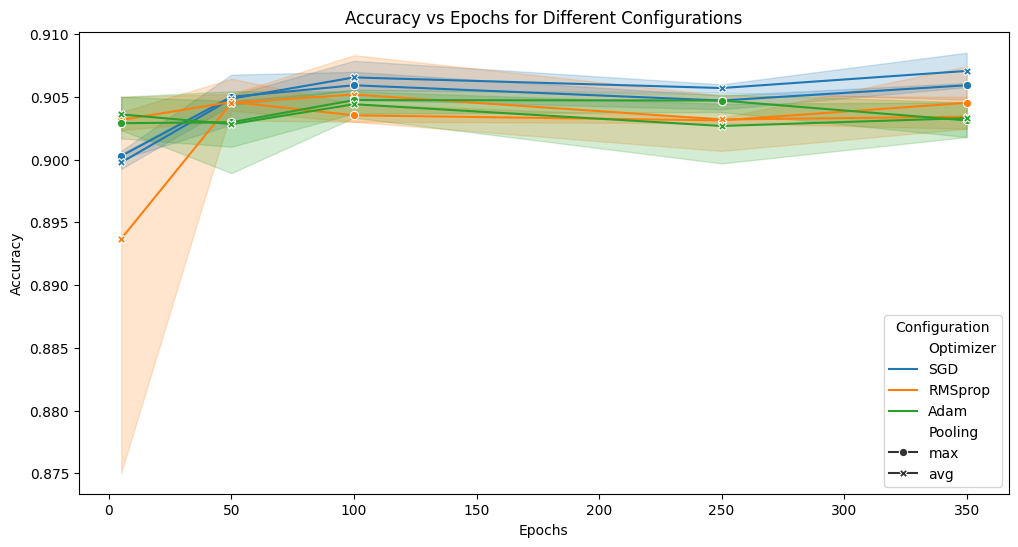

In [11]:
def visualize_results(results_df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=results_df, x='Epochs', y='Accuracy', hue='Optimizer', style='Pooling', markers=True, dashes=False)
    plt.title('Accuracy vs Epochs for Different Configurations')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(title='Configuration', loc='lower right')
    plt.show()

visualize_results(results_df)


In [16]:
 # Display top 10 as table
from tabulate import tabulate
top_10 = results_df.sort_values(by='Accuracy', ascending=False).head(10)
print("Top 10 Results:")
print(tabulate(top_10, headers='keys', tablefmt='pretty', showindex=False))


Top 10 Results:
+-------------+---------+-----------+--------+--------------------+
| Hidden Size | Pooling | Optimizer | Epochs |      Accuracy      |
+-------------+---------+-----------+--------+--------------------+
|     64      |   avg   |    SGD    |  350   | 0.9091009620701095 |
|     16      |   avg   |  RMSprop  |  100   | 0.9083268826716797 |
|     16      |   avg   |    SGD    |  100   | 0.9078845515868628 |
|     64      |   max   |  RMSprop  |  350   | 0.9074422205020458 |
|     32      |   avg   |    SGD    |  350   | 0.9073316377308416 |
|     32      |   max   |    SGD    |  100   | 0.9069998894172288 |
|     64      |   max   |    SGD    |   50   | 0.9067787238748203 |
|     16      |   max   |  RMSprop  |   50   | 0.9064469755612076 |
|     64      |   avg   |    SGD    |  100   | 0.9062258100187991 |
|     32      |   max   |    SGD    |  350   | 0.9061152272475949 |
+-------------+---------+-----------+--------+--------------------+
